### Tutorial: Training a Deep Neural Correction for the Forward Operator
In this Notebook, we show how one can train a learned correction for the forward operator in photon-counting CT. Please note that the code provided below will not reproduce our results. In particular, the original article used initial data from 2000 iterations of a BFGS algorithm, and here we use the zero tensor as initial guess.

In [1]:
# Import Session
from learned_reconstruction.learning_session import *
from learned_reconstruction.operator_modules import *
from learned_reconstruction.plots import *
from tools.logger import EventTracker
import matplotlib.pyplot as plt
import torch
import os

The training and evaluation is made using an instance of `FwdBwdSession`. Apart from hyper parameter settings, `FwdBwdSession` requires a number of session-specific variables:
* `detector_settings_path` Path to the detector settings file. The detector settings can be altered (see `TUT_detector_settings.ipynb`) the settings define the resolution of the phantoms and sinograms:
    * Phantoms are (1, M, W, H) pytorch tensors. M is number of basis materials, W is pixel width, H is height.
    * Sinograms are (1, B, D, A) pytorch tensors. B is number of energy bins, D is number of detectors, A is number of angles.
* `session_path` Path where data from the sessions is stored. This folder can require a lot of space if many checkpoints are made throughout training. The session will store training losses, current parameter values and the like. The session path itself requires a number of subfolders with specific names:
    * `data_test` contains phantoms named `phantom_test_N.Tensor`.
    * `data_init` contains phantoms named `phantom_N.Tensor` where `N` is a whole number.
    * `data_target` contains phantoms named `target_phantom_N.Tensor`, and sinograms named `target_sinogram_N.Tensor`.
    The phantom `phantom_N.Tensor` should be the initial guess in an iterative method that aims at reconstructing `target_phantom_N.Tensor` from the noisy measurement `target_sinogram_N.Tensor`. The test phantoms are unrelated.
* `data_loading_path` Path where the training data is stored for access during training, for example an SSD.

We need to make sure that the above paths exist before creating a new session. Here's an example of how one can do this using the available library and a file containing training data. We begin by creating the session directory. This is where all sessions will be stored.

In [3]:
# Choose device to run training and testing on.
device = "cuda"

# Create session directory
ses_path = "sessions/session_kits/"
os.makedirs(ses_path, exist_ok=True)
os.makedirs(ses_path+"data_init/", exist_ok=True)
os.makedirs(ses_path+"data_target/", exist_ok=True)
os.makedirs(ses_path+"data_test/", exist_ok=True)

# Make secret directory for data that will not be used in training.
os.makedirs(ses_path+"data_secret/", exist_ok=True)

# Create directory for quick loading into working memory
data_path = "data/ct_session_data/"
os.makedirs(data_path, exist_ok=True)

Next, we load data, split it into training and test, initialise and store in the correct folders. The resolution of the data is too high for the simulation capacity in this study. We create a simple max-pool operation to downsample the data into 128x128 images. The maxpool will ensure crisp edges, which are an important feature to preserve (it is exactly the blurring effect that we try to counteract in this work)

In [3]:
# Define function to store the phantoms
def store_separate(tensor, path, serial_name):
    for i in range(tensor.shape[0]):
        torch.save(tensor[None, i, :, :, :].clone(), f"{path}{serial_name}{i}.Tensor")

def downsample():
    # Downsample phantoms using max pool
    phantoms = torch.load("data/kits_phantoms.pt")
    downSampler = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
    phantoms = downSampler(phantoms)
    #assert (phantoms.shape[2] == 128) and (phantoms.shape[3] == 128)
    torch.save(phantoms, "data/kits_phantoms_256.pt")

Create measurements using simulated forward operator with poisson noise. We isolate this inside a function as well, to avoid unnecessary memory usage.

In [4]:
ntrain = 100
ntest = 100
nsecret = 100

img_w = 256
n_det = 512
n_ang = 512
    

def split_normalise_and_save_phantoms():
    # Seed
    seed = 0
    torch.manual_seed(seed)
    
    # Load data
    phantoms = torch.load("data/kits_phantoms_256.pt")
    
    # Normalise channels, divide by channel max
    chmax = [phantoms[:,i,:,:].max() for i in range(3)]
    for i in range(3):
        phantoms[:,i,:,:] /= chmax[i]

    
    # Shuffle data 
    idx_shuffled = torch.randperm(phantoms.shape[0])
    phantoms = phantoms[idx_shuffled, :, :, :]
    
    train = phantoms[:ntrain, :, :, :]
    test = phantoms[ntrain:(ntrain+ntest), :, :, :]
    secret = phantoms[(ntrain+ntest):(ntrain+ntest+nsecret),:,:,:]

    # Store true phantoms in target folder
    store_separate(train, ses_path + "/data_target/", "target_phantom_")

    # Store other phantoms in test folder
    store_separate(test, ses_path + "/data_test/", "phantom_test_")
    
    # Store secret phantoms in secret folder
    store_separate(test, ses_path + "/data_secret/", "phantom_secret_")

    # Store zero guess in init folder (don't do this now!)
    #store_separate(torch.zeros_like(train), ses_path + "/data_init/", "phantom_")
    

def save_sinograms():

    # Generate a forward operator using the settings data
    settings_path = "data/detector_settings.dict"

    # Create operator components
    components = create_operator_components(img_width_pix=img_w,#128
                                            img_width=0.8,
                                            n_detectors=n_det, #128
                                            n_views=n_ang, #128
                                            materials=["bone", "water", "iodine"],
                                            img_width_unit='fov_frac',
                                            device=device,
                                            settings_data_path=settings_path)

    # Assemble operator (don't care about the adjoint here)
    fwd_op, _ = assemble_fwd_bwd_modules(components, psf_width=21)

    #sinograms = torch.zeros(ntrain, 8, n_det, n_ang)
    
    path=ses_path + "/data_target/"
    # Iterate through existing phantoms and generate noisy measurements.
    for i in range(ntrain):
        print(f"storing {i}/{ntrain} phantoms", end="\r")
        # Load data
        train = torch.load(ses_path + f"/data_target/target_phantom_{i}.Tensor")
        
        # Draw from poisson distribution with mean according to fwd op
        # Have to simulate one at a time, otherwise takes to much memory
        sino = torch.poisson(fwd_op(train))
        torch.save(sino.clone(), f"{path}target_sinogram_{i}.Tensor")

In [5]:
downsample()
split_normalise_and_save_phantoms()
save_sinograms()

/home/emastr/anaconda3/envs/odl_torch/lib/python3.9/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


Here's a peek at the data:

Max values = [1.0, 0.867, 0.773]


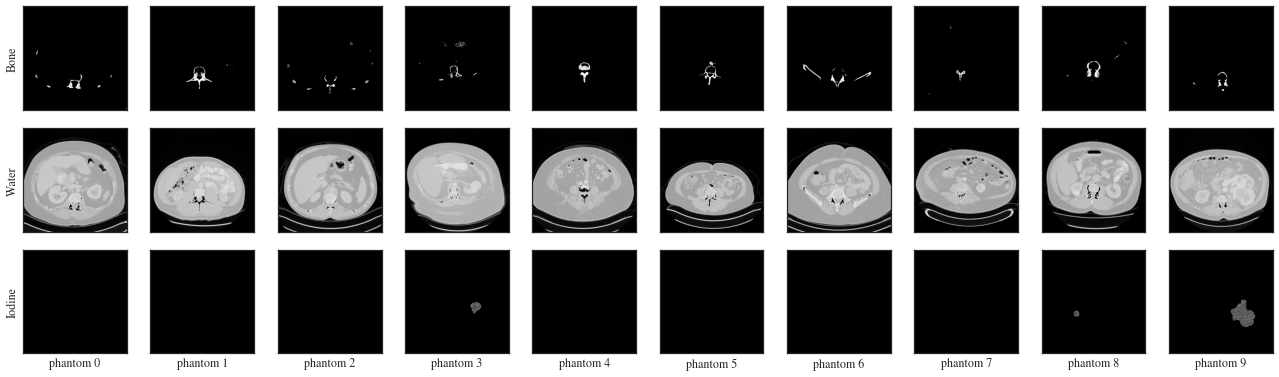

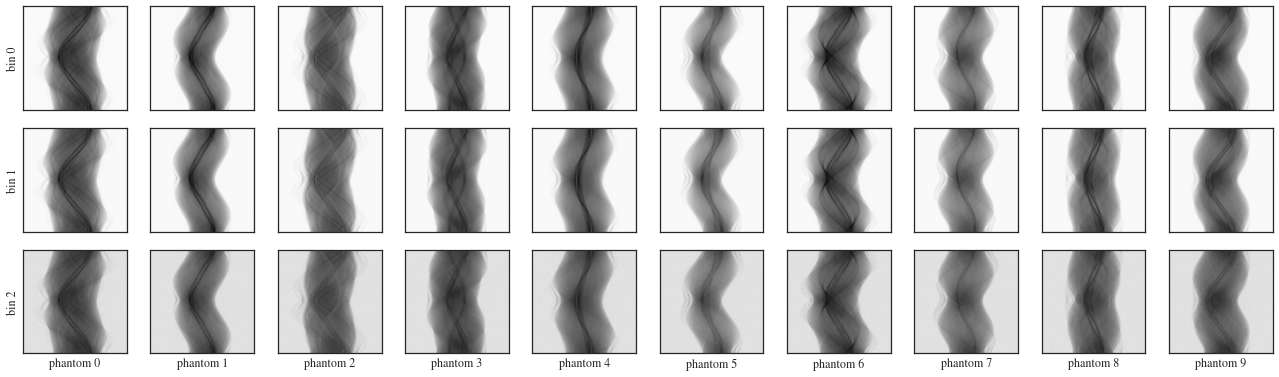

In [6]:
# Load some phantoms + measurements from the training data
nshow = 10 # Number of phantoms to show
x = torch.zeros((nshow,3,img_w,img_w))
y = torch.zeros((nshow,8,n_det,n_ang))
for i in range(nshow):
    x[i] = torch.load(ses_path + f"data_target/target_phantom_{i}.Tensor").to("cpu")
    y[i] = torch.load(ses_path + f"data_target/target_sinogram_{i}.Tensor").to("cpu")

print(f"Max values = {[round(x[:,i,:,:].max().item(),3) for i in range(3)]}")
    
# Take a look at the data
plot_image_channels(x,
                    image_labels=[f"phantom {i}" for i in range(nshow)],
                    channel_labels=["Bone", "Water", "Iodine"],
                    cmap="Greys_r",
                    vmax=1,
                    vmin=0)
    
plot_image_channels(y,
                    image_labels=[f"phantom {i}" for i in range(nshow)],
                    channel_labels=[f"bin {i}" for i in range(8)],
                    subset=[0,3,6],
                    cmap="Greys_r")


Now we are ready to create a session, let's call it `test_session`. Make sure that num_data is less than or equal to the number of tensors in the init folder. If the init process fails, you might have to delete the two folders named `test_session`. One can be found in the `sessions` directory, and one in the `data_loading_path` directory.

In [3]:
ses = FwdBwdSession(session_name = "test_session",
                    data_loading_path = data_path,
                    session_path = ses_path,
                    learning_rate=[1e-3, 1e-3],
                    num_data=20,
                    device="cuda",
                    verbose=True,
                    validate_every_n=100,
                    save_every_n=10,
                    batch_norm=(0, 0),
                    activations=(nn.LeakyReLU, nn.LeakyReLU),
                    in_ch=(8, 8),
                    bfgs_stepsize=1.0,
                    grad_clip=(0.002, 0.002),
                    reg_scale=0.000006)

Directory already exists! Loading session ...
Creating operators...


/home/emastr/anaconda3/envs/odl_torch/lib/python3.9/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


Creating corrective nets...
Preparing data ...
Found 20 data points. Returning data object.


## Reconstruction

Next, we need to generate initial guesses for training. In this work, we generate guesses using a one-step method with the approximate forward operator and bfgs.

In [31]:
y = ses.get_y_true(8).to("cuda")
ptm = [ses.get_x_true(8).to("cuda")]
losses = []

regpars = 10**(np.linspace(-6.5, -5,8))
for i,regpar in enumerate(regpars):
    print(f"{i} out of 10 done")
    x = torch.zeros((1,3,256,256)).to("cuda")
    ses.reg_scale=regpar
    #grad = lambda x: ses.loss_gradient_autograd(x, ses.fwd_acc, y)
    grad = lambda x: ses.loss_gradient(x, ses.fwd_apx, ses.bwd_apx, y)
    
    loss = []
    def callback(x, i, ss, ys):
        loss.append(ss[-1].norm())
        
    x, _, _ = ses.bfgs_steps(x, grad, ses.phantom_inner, step=1.0, iter=5000, num_store=10, verbose=True, logger=None, callback=callback)
    
    losses.append(loss)
    ptm.append(x.to("cpu"))

0 out of 10 done
1 out of 10 doneions
2 out of 10 doneions
3 out of 10 doneions
4 out of 10 doneions
5 out of 10 doneions
6 out of 10 doneions
7 out of 10 doneions


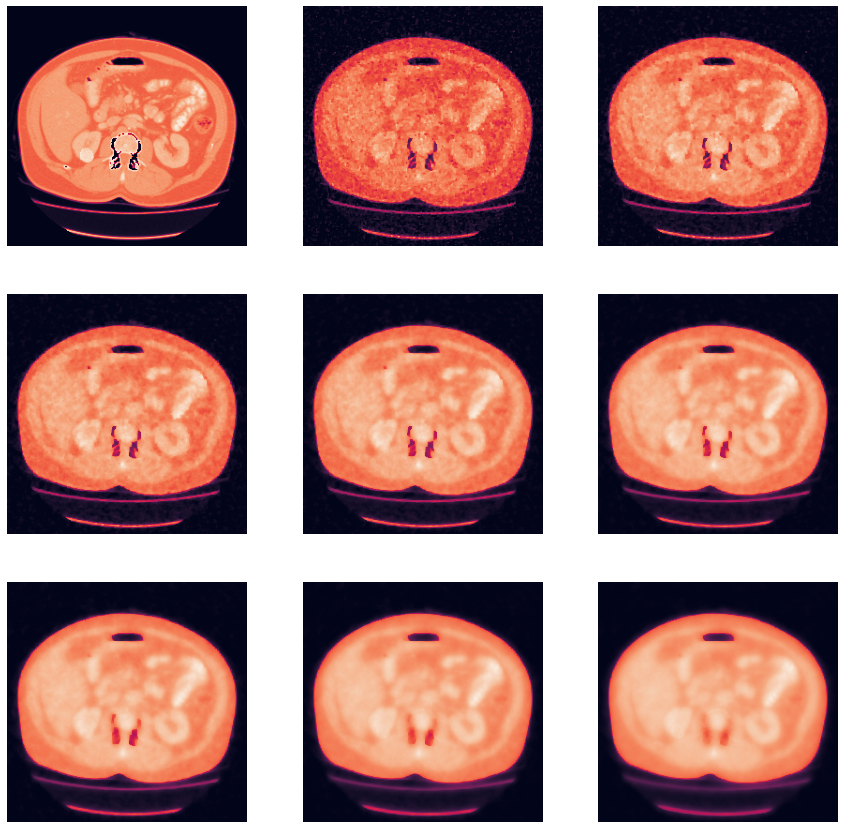

In [35]:
ptm_np = [p.detach().cpu().numpy() for p in ptm]
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(ptm_np[i][0,1,:,:], vmin=0)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.xticks([])
    plt.yticks([])

There is no clear best choice, but $6\times 10^{-6}$ looks decent. Let's see the same result but for the approximate forward operator. The next step is to train our model. We begin with some pretraining.

In [36]:
y = ses.get_y_true(8).to("cuda")
ptms = {}
ptms["true"] = ses.get_x_true(8).to("cuda")

# Reg parameter
#regpars = 10**(np.linspace(-8, -5,10))
regpars = 10**(np.linspace(-6.5, -5,8))
ses.reg_scale=regpars[3] # 5th choice is good

grad_apx = lambda x: ses.loss_gradient(x, ses.fwd_apx, ses.bwd_apx, y)
grad_acc = lambda x: ses.loss_gradient(x, ses.fwd_acc, ses.bwd_acc, y)


x_init = torch.zeros((1,3,256,256)).to("cuda")
x_init, _, _ = ses.bfgs_steps(x_init, grad_apx, ses.phantom_inner, step=1.0, iter=5000, num_store=10, verbose=True, logger=EventTracker())
x_acc, _, _ = ses.bfgs_steps(x_init, grad_acc, ses.phantom_inner, step=1.0, iter=1000, num_store=10, verbose=True, logger=EventTracker())
x_apx, _, _ = ses.bfgs_steps(x_init, grad_apx, ses.phantom_inner, step=1.0, iter=1000, num_store=10, verbose=True, logger=EventTracker())
ptms["acc"] = x_acc
ptms["apx"] = x_apx

Text(0.5, 1.0, 'apx_er - acc_er')

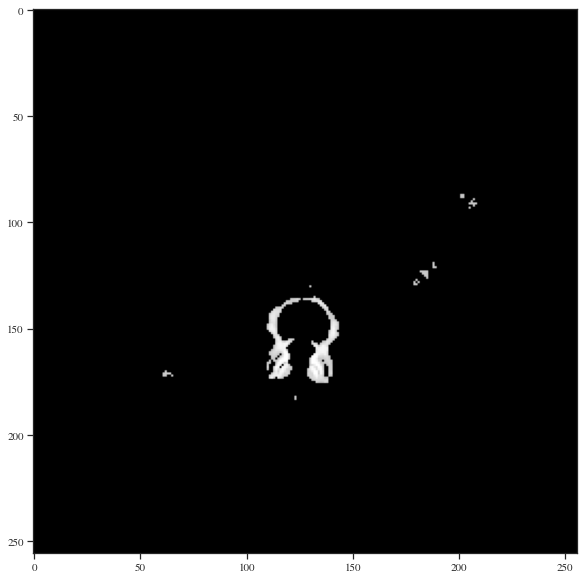

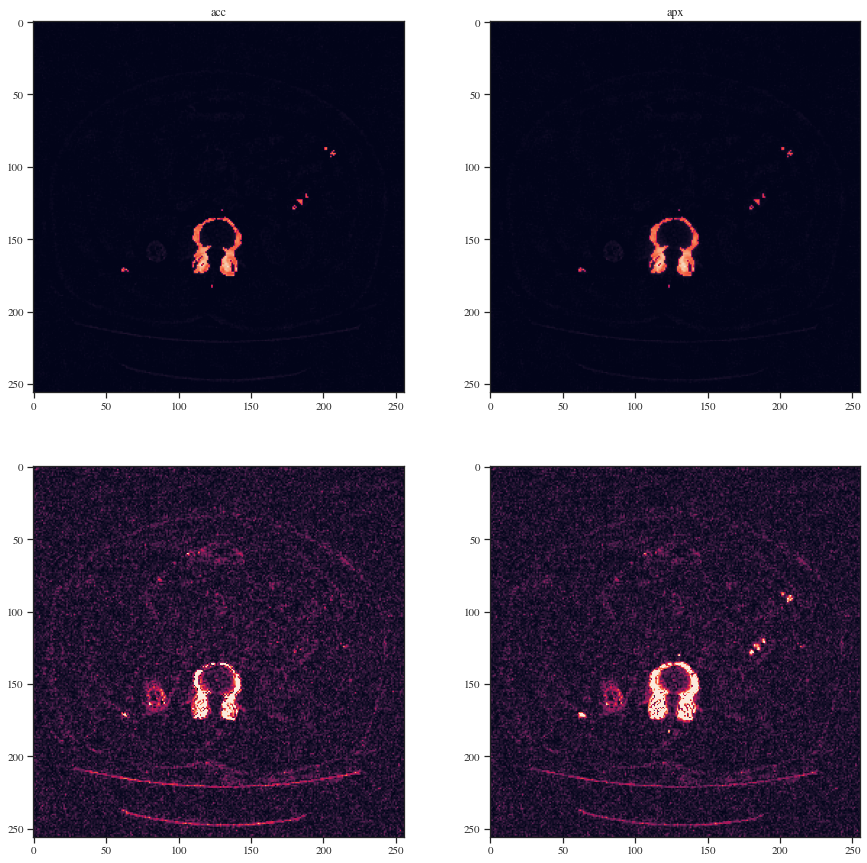

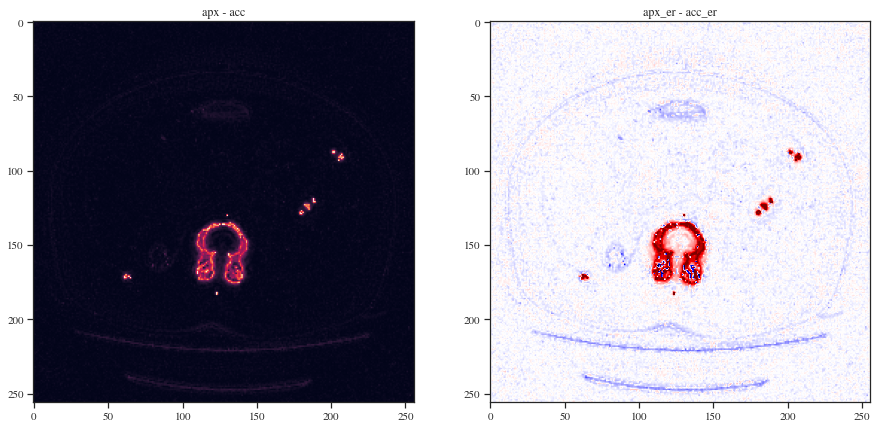

In [40]:
idx = 0
plt.figure(figsize=(10,10))
plt.imshow(ptms["true"].cpu().numpy()[0,idx,:,:], vmin=0, cmap="Greys_r")

plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.imshow(ptms["acc"].cpu().numpy()[0,idx,:,:], vmin=0)
plt.title("acc")

plt.subplot(2,2,2)
plt.imshow(ptms["apx"].cpu().numpy()[0,idx,:,:], vmin=0)
plt.title("apx")

plt.subplot(2,2,3)
plt.imshow(torch.abs(ptms["true"]-ptms["acc"]).cpu().numpy()[0,idx,:,:], vmin=0, vmax=0.1)

plt.subplot(2,2,4)
plt.imshow(torch.abs(ptms["true"] - ptms["apx"]).cpu().numpy()[0,idx,:,:], vmin=0, vmax=0.1)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(torch.abs(ptms["acc"] - ptms["apx"]).cpu().numpy()[0,idx,:,:], vmin=0, vmax=0.1)
plt.title("apx - acc")

plt.subplot(1,2,2)
plt.imshow((torch.abs(ptms["true"] - ptms["apx"])-torch.abs(ptms["true"] - ptms["acc"]))\
           .cpu().numpy()[0,idx,:,:], vmin=-0.05, vmax=0.05, cmap='seismic')
plt.title("apx_er - acc_er")

Now that we are confident in a good regularisation parameter, we generate training data by running 4000 steps of the approximate forward operator. This is sure to give us the best possible initialisation.

In [48]:
ntrain = 100
ntest = 100
nsecret = 100

img_w = 256
n_det = 512
n_ang = 512
    

def save_initial_data(niter=4000):
    
    class Callback():
        def __init__(self, name):
            self.counter=0
            self.name=name

        def __call__(self, *args):
            if self.counter % 10 == 0:
                print(f"Phantom {self.name}/{ntrain}: {self.counter}/{niter} iterations done.", end="\r")
            self.counter += 1


    regpars = 10**(np.linspace(-6.5, -5,8))
    ses.reg_scale=regpars[3] # 5th choice is good

    #sinograms = torch.zeros(ntrain, 8, n_det, n_ang)

    path=ses_path + "/data_target/"
    # Iterate through existing phantoms and generate noisy measurements.
    for i in range(ntrain):
        # Load data
        y = torch.load(f"{path}target_sinogram_{i}.Tensor").to("cuda")
        x0 = torch.zeros(1,3,img_w, img_w).to("cuda")

        grad = lambda x: ses.loss_gradient(x, ses.fwd_apx, ses.bwd_apx, y)
        x,_,_ = ses.bfgs_steps(x_init, 
                                   grad, 
                                   ses.phantom_inner, 
                                   step=1.0, 
                                   iter=niter, 
                                   num_store=10, 
                                   verbose=False,
                                   callback=Callback(i))


        torch.save(x, ses_path + f"/data_init/phantom_{i}.Tensor")

In [ ]:
save_initial_data(4000)

## Training
Having generated a bunch of training data, let's start training our network.

In [4]:
ses = FwdBwdSession.load_old_session(name = "test_session", path=ses_path, save_every_n=1)

# Run 10 epochs of training
ses.run_epochs(500, forward=True, backward=True, callback=None)

AssertionError: Session corrupted.

We can also run recursive training. The training data in each epoch is then multiplied by the number of recursions taken during that epoch. Therefore, it is better to make checkpoints more often. Consider therefore changing `save_every_n`=1. This is as easy as reloading your session with a new parameter configuration. Settings from the previous checkpoint are stored and used as default arguments for the next time the session is started. If the recursions are very long, it is possible to make checkpoints inside each recursion by passing the `save_every_n_steps` argument to the `run_epochs_recursion` function.

In [74]:
ses = FwdBwdSession.load_old_session(name = "test_session", path=ses_path, save_every_n=1)


# Run two epochs of recursive training
ses.run_epochs_recursion([1000, 3000]*3, train_every_n=10, save_every_n_steps=100, callback=None)

Picking most recent save: 491
Directory already exists! Loading session ...
Creating operators...
Creating corrective nets...
Preparing data ...
Found 20 data points. Returning data object.
Loading closest checkpoint, 491
Done loading states.
Done loading states.
Saved current state dicts..
Batch [1/20], Recursion [0 / 1000]phantom 18, iter 0, fwd loss 1.278741010792207e-07 - aim for 7.83568858862485e-12, bwd loss 0.00010439387805018694 - aim for 0.020415587539532914
Batch [1/20], Recursion [10 / 1000]phantom 18, iter 0, fwd loss 0.00019528381342992886 - aim for 2.05346547946296e-07, bwd loss 1.1582727420168453 - aim for 0.008304067975382606
Batch [1/20], Recursion [20 / 1000]phantom 18, iter 0, fwd loss 4.493995187472441e-05 - aim for 2.3306749369273485e-07, bwd loss 1.2128622074177207 - aim for 0.005553898580981712
Batch [1/20], Recursion [30 / 1000]phantom 18, iter 0, fwd loss 6.234178614560917e-05 - aim for 4.689415110881306e-07, bwd loss 0.18735437681793898 - aim for 0.00309573916

Batch [1/20], Recursion [430 / 1000]phantom 18, iter 0, fwd loss 5.153368305066098e-06 - aim for 9.51982734577047e-07, bwd loss 0.0001438999994925833 - aim for 0.00017953081868799184
Batch [1/20], Recursion [440 / 1000]phantom 18, iter 0, fwd loss 5.091246143509596e-06 - aim for 9.516701024417562e-07, bwd loss 0.00014404109807691933 - aim for 0.00018062340297144452
Batch [1/20], Recursion [450 / 1000]phantom 18, iter 0, fwd loss 9.095559987636489e-06 - aim for 9.470427323524991e-07, bwd loss 0.00014943583666381555 - aim for 0.00023141014497633168
Batch [1/20], Recursion [460 / 1000]phantom 18, iter 0, fwd loss 4.910874382844155e-06 - aim for 9.469722051093004e-07, bwd loss 0.00013268890327548775 - aim for 0.00020442241059261948
Batch [1/20], Recursion [470 / 1000]phantom 18, iter 0, fwd loss 1.3437027142529591e-05 - aim for 9.437349953453783e-07, bwd loss 0.00012861336860604735 - aim for 0.0001443518147603071
Batch [1/20], Recursion [480 / 1000]phantom 18, iter 0, fwd loss 1.5113003078

Batch [1/20], Recursion [870 / 1000]phantom 18, iter 0, fwd loss 1.5070779170811921e-06 - aim for 1.2123973253256594e-06, bwd loss 2.5210358999051163e-05 - aim for 3.103455954523242e-05
Batch [1/20], Recursion [880 / 1000]phantom 18, iter 0, fwd loss 1.49719628277906e-06 - aim for 1.209237732805814e-06, bwd loss 2.8404164157158317e-05 - aim for 3.2296355063440174e-05
Batch [1/20], Recursion [890 / 1000]phantom 18, iter 0, fwd loss 1.370366703725151e-06 - aim for 1.2087887195782364e-06, bwd loss 3.6819510944527953e-05 - aim for 2.783742852070839e-05
Saved current state dicts..
Batch [1/20], Recursion [900 / 1000]phantom 18, iter 0, fwd loss 1.4584840804107262e-06 - aim for 1.1972489027265396e-06, bwd loss 5.1221937743003e-05 - aim for 2.959882226591969e-05
Batch [1/20], Recursion [910 / 1000]phantom 18, iter 0, fwd loss 1.4465959149772554e-06 - aim for 1.1806409044295917e-06, bwd loss 4.556730454087167e-05 - aim for 3.184021439413381e-05
Batch [1/20], Recursion [920 / 1000]phantom 18, i

Batch [2/20], Recursion [310 / 1000]phantom 1, iter 0, fwd loss 1.7424700242829926e-06 - aim for 1.2698834206442487e-06, bwd loss 0.00020616606539597813 - aim for 7.794233146533973e-05
Batch [2/20], Recursion [320 / 1000]phantom 1, iter 0, fwd loss 1.6935057829733486e-06 - aim for 1.2580391913230033e-06, bwd loss 0.00022083696601735676 - aim for 8.014366886773515e-05
Batch [2/20], Recursion [330 / 1000]phantom 1, iter 0, fwd loss 1.6137047551318173e-06 - aim for 1.2316861410903043e-06, bwd loss 0.00015136705848506192 - aim for 7.034883349908086e-05
Batch [2/20], Recursion [340 / 1000]phantom 1, iter 0, fwd loss 1.672004055185112e-06 - aim for 1.238733852861345e-06, bwd loss 8.279363859616307e-05 - aim for 5.63256334656604e-05
Batch [2/20], Recursion [350 / 1000]phantom 1, iter 0, fwd loss 1.6349479193613062e-06 - aim for 1.2236405441197693e-06, bwd loss 6.177489935964983e-05 - aim for 7.625957931522805e-05
Batch [2/20], Recursion [360 / 1000]phantom 1, iter 0, fwd loss 1.55164846001385

Batch [2/20], Recursion [750 / 1000]phantom 1, iter 0, fwd loss 1.4906016742264493e-06 - aim for 1.3454425557440792e-06, bwd loss 0.0001394455405488642 - aim for 5.239456552155991e-05
Batch [2/20], Recursion [760 / 1000]phantom 1, iter 0, fwd loss 1.5082958893361936e-06 - aim for 1.3632828000976218e-06, bwd loss 0.00013918072187540467 - aim for 6.229952818118211e-05
Batch [2/20], Recursion [770 / 1000]phantom 1, iter 0, fwd loss 1.5022145596819773e-06 - aim for 1.354035882756955e-06, bwd loss 7.882459325411913e-05 - aim for 5.3531309412198695e-05
Batch [2/20], Recursion [780 / 1000]phantom 1, iter 0, fwd loss 1.4889309644043938e-06 - aim for 1.34257554828615e-06, bwd loss 6.373834840109433e-05 - aim for 5.27491269432189e-05
Batch [2/20], Recursion [790 / 1000]phantom 1, iter 0, fwd loss 1.481561041339409e-06 - aim for 1.3376940800210086e-06, bwd loss 3.466783508463595e-05 - aim for 5.2989256172758676e-05
Saved current state dicts..
Batch [2/20], Recursion [800 / 1000]phantom 1, iter 0,

Batch [3/20], Recursion [190 / 1000]phantom 19, iter 0, fwd loss 2.435098954733392e-06 - aim for 2.2093376338783878e-06, bwd loss 0.00015771799345584676 - aim for 0.0005711570468549989
Saved current state dicts..
Batch [3/20], Recursion [200 / 1000]phantom 19, iter 0, fwd loss 2.498294906543799e-06 - aim for 2.262764383851169e-06, bwd loss 0.00010694131936786854 - aim for 0.00030230400078104367
Batch [3/20], Recursion [210 / 1000]phantom 19, iter 0, fwd loss 2.766162556301698e-06 - aim for 2.2846428435184958e-06, bwd loss 0.00013306000412163576 - aim for 0.000333769221348954
Batch [3/20], Recursion [220 / 1000]phantom 19, iter 0, fwd loss 2.725262908320388e-06 - aim for 2.267096660332977e-06, bwd loss 0.00010250721718187868 - aim for 0.00029402889945056405
Batch [3/20], Recursion [230 / 1000]phantom 19, iter 0, fwd loss 2.5386776553006263e-06 - aim for 2.2705725595429735e-06, bwd loss 0.00011191722670742056 - aim for 0.0003050731271788041
Batch [3/20], Recursion [240 / 1000]phantom 19,

Batch [3/20], Recursion [630 / 1000]phantom 19, iter 0, fwd loss 2.2497038656145078e-06 - aim for 2.1674938573580663e-06, bwd loss 4.2280437815733546e-05 - aim for 9.321414551841145e-05
Batch [3/20], Recursion [640 / 1000]phantom 19, iter 0, fwd loss 2.2525804894036198e-06 - aim for 2.169718754025831e-06, bwd loss 4.032212244197438e-05 - aim for 8.55921278164412e-05
Batch [3/20], Recursion [650 / 1000]phantom 19, iter 0, fwd loss 2.20611680522893e-06 - aim for 2.1219430220034114e-06, bwd loss 3.6176802183139834e-05 - aim for 7.645168761512962e-05
Batch [3/20], Recursion [660 / 1000]phantom 19, iter 0, fwd loss 2.1772534402227163e-06 - aim for 2.0932513488970156e-06, bwd loss 3.267325272978507e-05 - aim for 7.361851737585335e-05
Batch [3/20], Recursion [670 / 1000]phantom 19, iter 0, fwd loss 2.1575392089386836e-06 - aim for 2.0724886517635224e-06, bwd loss 3.3425877102372604e-05 - aim for 5.9654255245941504e-05
Batch [3/20], Recursion [680 / 1000]phantom 19, iter 0, fwd loss 2.10453911

Saved current state dicts..
Batch [4/20], Recursion [200 / 1000]phantom 8, iter 0, fwd loss 1.9135838729710463e-06 - aim for 1.5856002203718848e-06, bwd loss 0.00014892715419385146 - aim for 0.0006929166257085729
Batch [4/20], Recursion [210 / 1000]phantom 8, iter 0, fwd loss 1.8659360833109902e-06 - aim for 1.6270545244298263e-06, bwd loss 0.00012199030026092188 - aim for 0.0004924402173771036
Batch [4/20], Recursion [220 / 1000]phantom 8, iter 0, fwd loss 1.7013253454091898e-06 - aim for 1.5281223370763281e-06, bwd loss 9.000324855286607e-05 - aim for 0.00033541903578414994
Batch [4/20], Recursion [230 / 1000]phantom 8, iter 0, fwd loss 1.6520586850007373e-06 - aim for 1.4341200588531175e-06, bwd loss 0.00012207432491339034 - aim for 0.0002524490623685986
Batch [4/20], Recursion [240 / 1000]phantom 8, iter 0, fwd loss 1.6911480385160281e-06 - aim for 1.4235293946521568e-06, bwd loss 7.002741035184835e-05 - aim for 0.00019715472324498008
Batch [4/20], Recursion [250 / 1000]phantom 8, 

Batch [4/20], Recursion [640 / 1000]phantom 8, iter 0, fwd loss 1.2476422888172244e-06 - aim for 1.1742970115315684e-06, bwd loss 0.00010329794951415226 - aim for 4.399428562476749e-05
Batch [4/20], Recursion [650 / 1000]phantom 8, iter 0, fwd loss 1.2769361898762769e-06 - aim for 1.1893792905189555e-06, bwd loss 7.655302657033439e-05 - aim for 4.25101825587326e-05
Batch [4/20], Recursion [660 / 1000]phantom 8, iter 0, fwd loss 1.3211618404490442e-06 - aim for 1.2066075800124037e-06, bwd loss 5.03214185982432e-05 - aim for 4.425058151355195e-05
Batch [4/20], Recursion [670 / 1000]phantom 8, iter 0, fwd loss 1.3745140675407975e-06 - aim for 1.214644453898211e-06, bwd loss 2.416178579940813e-05 - aim for 4.8327277959958124e-05
Batch [4/20], Recursion [680 / 1000]phantom 8, iter 0, fwd loss 1.4494584098146268e-06 - aim for 1.2136552327033308e-06, bwd loss 2.710187889161734e-05 - aim for 4.449597780681568e-05
Batch [4/20], Recursion [690 / 1000]phantom 8, iter 0, fwd loss 1.556001571279802

Batch [5/20], Recursion [90 / 1000]phantom 10, iter 0, fwd loss 3.826382445720723e-06 - aim for 1.968220665100167e-06, bwd loss 0.0002901449535300243 - aim for 0.0020560558288325835
Saved current state dicts..
Batch [5/20], Recursion [100 / 1000]phantom 10, iter 0, fwd loss 2.4920933423544003e-06 - aim for 2.1175424839491467e-06, bwd loss 0.0005095393608202314 - aim for 0.002509317391006703
Batch [5/20], Recursion [110 / 1000]phantom 10, iter 0, fwd loss 2.817495107090218e-06 - aim for 2.437389989703661e-06, bwd loss 0.0003459681424861369 - aim for 0.002437007693335706
Batch [5/20], Recursion [120 / 1000]phantom 10, iter 0, fwd loss 4.222807250758894e-06 - aim for 2.4230607907091178e-06, bwd loss 0.0002601988033420411 - aim for 0.002265753445525578
Batch [5/20], Recursion [130 / 1000]phantom 10, iter 0, fwd loss 2.731048864341094e-06 - aim for 2.2659952964284698e-06, bwd loss 0.0001866400363764866 - aim for 0.0015651426013649412
Batch [5/20], Recursion [140 / 1000]phantom 10, iter 0, f

Batch [6/20], Recursion [210 / 1000]phantom 17, iter 0, fwd loss 1.6611589805959516e-06 - aim for 1.5388849868341866e-06, bwd loss 8.872435246530954e-05 - aim for 0.00033884520665534236
Batch [6/20], Recursion [220 / 1000]phantom 17, iter 0, fwd loss 1.6832823179577886e-06 - aim for 1.5187426894711165e-06, bwd loss 9.043020217642499e-05 - aim for 0.00028415879202435003
Batch [6/20], Recursion [230 / 1000]phantom 17, iter 0, fwd loss 1.4537836843788535e-06 - aim for 1.3180371178203533e-06, bwd loss 8.10912411632732e-05 - aim for 0.00018459017791698154
Batch [6/20], Recursion [240 / 1000]phantom 17, iter 0, fwd loss 1.4495879737280282e-06 - aim for 1.3499927229753257e-06, bwd loss 0.00012732973659615836 - aim for 0.00012670504460630074
Batch [6/20], Recursion [250 / 1000]phantom 17, iter 0, fwd loss 1.4874327196703026e-06 - aim for 1.3461932118537992e-06, bwd loss 6.63401834364165e-05 - aim for 0.00011485867608501613
Batch [6/20], Recursion [260 / 1000]phantom 17, iter 0, fwd loss 1.4847

Batch [7/20], Recursion [310 / 1000]phantom 6, iter 0, fwd loss 1.3279564180056217e-06 - aim for 1.2643879123164933e-06, bwd loss 4.4514659198332626e-05 - aim for 0.0001329962449632294
Batch [7/20], Recursion [320 / 1000]phantom 6, iter 0, fwd loss 1.3040509985287288e-06 - aim for 1.2485499763301104e-06, bwd loss 6.279196427283049e-05 - aim for 0.00016815140657374143
Batch [7/20], Recursion [330 / 1000]phantom 6, iter 0, fwd loss 1.2869052309463393e-06 - aim for 1.2371117744979869e-06, bwd loss 6.85367714210384e-05 - aim for 0.00026420374576030737
Batch [7/20], Recursion [340 / 1000]phantom 6, iter 0, fwd loss 1.3014776485237573e-06 - aim for 1.258653112020058e-06, bwd loss 5.296429291965335e-05 - aim for 0.00021614466418896471
Batch [7/20], Recursion [350 / 1000]phantom 6, iter 0, fwd loss 1.394428849057587e-06 - aim for 1.355435581819451e-06, bwd loss 3.239045977822978e-05 - aim for 0.00010644352698188934
Batch [7/20], Recursion [360 / 1000]phantom 6, iter 0, fwd loss 1.4789835255965

Batch [7/20], Recursion [750 / 1000]phantom 6, iter 0, fwd loss 1.4962890533229154e-06 - aim for 1.4890785888684744e-06, bwd loss 1.997740532816644e-05 - aim for 2.9840888417888127e-05
Batch [7/20], Recursion [760 / 1000]phantom 6, iter 0, fwd loss 1.4979078738561967e-06 - aim for 1.4909705438229812e-06, bwd loss 2.7377158894453028e-05 - aim for 2.8658600694708695e-05
Batch [7/20], Recursion [770 / 1000]phantom 6, iter 0, fwd loss 1.4953016520703408e-06 - aim for 1.4887535582215973e-06, bwd loss 2.9422395037830027e-05 - aim for 2.7594748382927153e-05
Batch [7/20], Recursion [780 / 1000]phantom 6, iter 0, fwd loss 1.4889101151912382e-06 - aim for 1.4826459109800433e-06, bwd loss 2.0665964171083084e-05 - aim for 2.7416892399697836e-05
Batch [7/20], Recursion [790 / 1000]phantom 6, iter 0, fwd loss 1.47645196058405e-06 - aim for 1.4702959468537766e-06, bwd loss 2.5385300073422146e-05 - aim for 2.6615789379688153e-05
Saved current state dicts..
Batch [7/20], Recursion [800 / 1000]phantom 6

Batch [8/20], Recursion [190 / 1000]phantom 13, iter 0, fwd loss 2.252396901338211e-06 - aim for 1.7995336392344727e-06, bwd loss 0.00036429676877600917 - aim for 0.0006920736721913498
Saved current state dicts..
Batch [8/20], Recursion [200 / 1000]phantom 13, iter 0, fwd loss 2.2687156789434845e-06 - aim for 1.5336591270967457e-06, bwd loss 0.00034684532522670665 - aim for 0.00042977116827855723
Batch [8/20], Recursion [210 / 1000]phantom 13, iter 0, fwd loss 2.7760667642412025e-06 - aim for 1.57265702691894e-06, bwd loss 0.00020082500689284002 - aim for 0.00032868283049454847
Batch [8/20], Recursion [220 / 1000]phantom 13, iter 0, fwd loss 1.762957946924919e-06 - aim for 1.3713915245769816e-06, bwd loss 0.00012510327387718723 - aim for 0.0001603978674504297
Batch [8/20], Recursion [230 / 1000]phantom 13, iter 0, fwd loss 2.213386571901372e-06 - aim for 1.3958364832839394e-06, bwd loss 6.297472417440161e-05 - aim for 0.00017866706236473136
Batch [8/20], Recursion [240 / 1000]phantom 1

Batch [8/20], Recursion [630 / 1000]phantom 13, iter 0, fwd loss 1.3304433156962777e-06 - aim for 1.3143247245317118e-06, bwd loss 1.8255160999735527e-05 - aim for 4.525012772946379e-05
Batch [8/20], Recursion [640 / 1000]phantom 13, iter 0, fwd loss 1.3281782437642116e-06 - aim for 1.323790060783765e-06, bwd loss 1.855052710293917e-05 - aim for 4.660759690229307e-05
Batch [8/20], Recursion [650 / 1000]phantom 13, iter 0, fwd loss 1.3330944710255664e-06 - aim for 1.3238216579629473e-06, bwd loss 1.9014264632421843e-05 - aim for 4.826449191903956e-05
Batch [8/20], Recursion [660 / 1000]phantom 13, iter 0, fwd loss 1.328720039910449e-06 - aim for 1.3176454421973839e-06, bwd loss 2.078889907366891e-05 - aim for 4.358827773823367e-05
Batch [8/20], Recursion [670 / 1000]phantom 13, iter 0, fwd loss 1.3236064536026698e-06 - aim for 1.321277985257106e-06, bwd loss 2.0214100483392423e-05 - aim for 4.283506663372997e-05
Batch [8/20], Recursion [680 / 1000]phantom 13, iter 0, fwd loss 1.32131423

Batch [9/20], Recursion [70 / 1000]phantom 4, iter 0, fwd loss 1.7819101745024952e-06 - aim for 1.5832161347950207e-06, bwd loss 0.0013224150995224224 - aim for 0.0026516664565368994
Batch [9/20], Recursion [80 / 1000]phantom 4, iter 0, fwd loss 2.5628281138378486e-06 - aim for 1.8526822278842802e-06, bwd loss 0.001080090429064734 - aim for 0.0037353707491198413
Batch [9/20], Recursion [90 / 1000]phantom 4, iter 0, fwd loss 3.019152061852974e-06 - aim for 1.9413616858218536e-06, bwd loss 0.0003224795047249531 - aim for 0.003146049071158282
Saved current state dicts..
Batch [9/20], Recursion [100 / 1000]phantom 4, iter 0, fwd loss 3.1968669263878855e-06 - aim for 2.2194862049257782e-06, bwd loss 0.0009731544299480723 - aim for 0.0037461123082299925
Batch [9/20], Recursion [110 / 1000]phantom 4, iter 0, fwd loss 2.6997455693059947e-06 - aim for 2.3196344759641344e-06, bwd loss 0.0005521886954696663 - aim for 0.0032446856472386366
Batch [9/20], Recursion [120 / 1000]phantom 4, iter 0, fwd

Batch [9/20], Recursion [510 / 1000]phantom 4, iter 0, fwd loss 9.759367189441572e-07 - aim for 9.80258912598674e-07, bwd loss 2.8688052897037723e-05 - aim for 0.0001358279121880896
Batch [9/20], Recursion [520 / 1000]phantom 4, iter 0, fwd loss 9.481270288789428e-07 - aim for 9.608961093808012e-07, bwd loss 2.9381375782121724e-05 - aim for 0.00013770288986762776
Batch [9/20], Recursion [530 / 1000]phantom 4, iter 0, fwd loss 9.43376286255706e-07 - aim for 9.506196099918118e-07, bwd loss 2.6302837265653005e-05 - aim for 0.00011998093017273906
Batch [9/20], Recursion [540 / 1000]phantom 4, iter 0, fwd loss 9.87171082132033e-07 - aim for 9.85287952807167e-07, bwd loss 2.2260934632957667e-05 - aim for 7.003697527600204e-05
Batch [9/20], Recursion [550 / 1000]phantom 4, iter 0, fwd loss 9.917535789657204e-07 - aim for 9.884318449053321e-07, bwd loss 2.8105043094750675e-05 - aim for 7.061664555184934e-05
Batch [9/20], Recursion [560 / 1000]phantom 4, iter 0, fwd loss 1.0040371426862414e-06 

Batch [9/20], Recursion [950 / 1000]phantom 4, iter 0, fwd loss 1.0249988018124585e-06 - aim for 1.0484369601988906e-06, bwd loss 1.698230970413576e-05 - aim for 3.793978062255877e-05
Batch [9/20], Recursion [960 / 1000]phantom 4, iter 0, fwd loss 1.0304893705781007e-06 - aim for 1.0538157788633458e-06, bwd loss 1.8380314116375387e-05 - aim for 3.526586755249832e-05
Batch [9/20], Recursion [970 / 1000]phantom 4, iter 0, fwd loss 1.0306075176726619e-06 - aim for 1.053919612034783e-06, bwd loss 1.755994288577006e-05 - aim for 3.3458502722548686e-05
Batch [9/20], Recursion [980 / 1000]phantom 4, iter 0, fwd loss 1.020817890706477e-06 - aim for 1.0441042020900765e-06, bwd loss 1.919958419552581e-05 - aim for 3.784594056601029e-05
Batch [9/20], Recursion [990 / 1000]phantom 4, iter 0, fwd loss 1.0195847178660443e-06 - aim for 1.0427416795599043e-06, bwd loss 2.356898591677255e-05 - aim for 3.963977783846074e-05
Saved current state dicts..
Batch [10/20], Recursion [0 / 1000]phantom 2, iter 0

Batch [10/20], Recursion [390 / 1000]phantom 2, iter 0, fwd loss 9.809530511148664e-07 - aim for 9.815240501588208e-07, bwd loss 3.537682353183277e-05 - aim for 0.0002536717414802461
Saved current state dicts..
Batch [10/20], Recursion [400 / 1000]phantom 2, iter 0, fwd loss 9.077794914755938e-07 - aim for 9.154415438015046e-07, bwd loss 4.908522455740843e-05 - aim for 0.0002932059532318682
Batch [10/20], Recursion [410 / 1000]phantom 2, iter 0, fwd loss 8.363386301727798e-07 - aim for 8.462804607443649e-07, bwd loss 4.852869868779096e-05 - aim for 0.0003749344488437233
Batch [10/20], Recursion [420 / 1000]phantom 2, iter 0, fwd loss 8.152036042046516e-07 - aim for 8.210264294767418e-07, bwd loss 5.166178722725367e-05 - aim for 0.00041381433380806835
Batch [10/20], Recursion [430 / 1000]phantom 2, iter 0, fwd loss 8.265851199556433e-07 - aim for 8.337459597787199e-07, bwd loss 5.255709295304388e-05 - aim for 0.00042039085755693234
Batch [10/20], Recursion [440 / 1000]phantom 2, iter 0,

Batch [10/20], Recursion [830 / 1000]phantom 2, iter 0, fwd loss 1.1389464603761332e-06 - aim for 1.1750636324483839e-06, bwd loss 1.5322391675539444e-05 - aim for 2.7343727122091808e-05
Batch [10/20], Recursion [840 / 1000]phantom 2, iter 0, fwd loss 1.1298612630508624e-06 - aim for 1.1664627919375668e-06, bwd loss 1.5262752150577065e-05 - aim for 2.8430510628201073e-05
Batch [10/20], Recursion [850 / 1000]phantom 2, iter 0, fwd loss 1.1126861490866134e-06 - aim for 1.150132294845287e-06, bwd loss 1.608624248398642e-05 - aim for 3.400457286133242e-05
Batch [10/20], Recursion [860 / 1000]phantom 2, iter 0, fwd loss 1.1105523520727254e-06 - aim for 1.1483234561135304e-06, bwd loss 1.5842168024258852e-05 - aim for 3.5764947829433346e-05
Batch [10/20], Recursion [870 / 1000]phantom 2, iter 0, fwd loss 1.1155379273721818e-06 - aim for 1.1535906914066784e-06, bwd loss 1.554287880789196e-05 - aim for 3.376794938541858e-05
Batch [10/20], Recursion [880 / 1000]phantom 2, iter 0, fwd loss 1.118

Batch [11/20], Recursion [270 / 1000]phantom 5, iter 0, fwd loss 1.1794095405650266e-06 - aim for 1.113248919770766e-06, bwd loss 8.29118181485364e-05 - aim for 9.718196981838195e-05
Batch [11/20], Recursion [280 / 1000]phantom 5, iter 0, fwd loss 1.2327594779072233e-06 - aim for 1.1144388374474975e-06, bwd loss 4.1049130328462994e-05 - aim for 0.0001000273055921844
Batch [11/20], Recursion [290 / 1000]phantom 5, iter 0, fwd loss 1.2093437287916374e-06 - aim for 1.0914227123384651e-06, bwd loss 3.005409549457876e-05 - aim for 0.00011259881097179712
Saved current state dicts..
Batch [11/20], Recursion [300 / 1000]phantom 5, iter 0, fwd loss 1.1312974680636679e-06 - aim for 1.0848852082631508e-06, bwd loss 3.3685163396392005e-05 - aim for 9.521812932859388e-05
Batch [11/20], Recursion [310 / 1000]phantom 5, iter 0, fwd loss 1.1002951101188719e-06 - aim for 1.0926212567994466e-06, bwd loss 5.3015373448863725e-05 - aim for 9.261788591887343e-05
Batch [11/20], Recursion [320 / 1000]phantom 

Batch [11/20], Recursion [710 / 1000]phantom 5, iter 0, fwd loss 1.0139201862132883e-06 - aim for 1.0537199871123296e-06, bwd loss 1.667592417750017e-05 - aim for 2.8073109120065574e-05
Batch [11/20], Recursion [720 / 1000]phantom 5, iter 0, fwd loss 1.0131637121177947e-06 - aim for 1.053861114912453e-06, bwd loss 1.61548551770542e-05 - aim for 2.7411888187585995e-05
Batch [11/20], Recursion [730 / 1000]phantom 5, iter 0, fwd loss 1.0109603616739585e-06 - aim for 1.0527291861349373e-06, bwd loss 1.598837019549233e-05 - aim for 2.7084685522276782e-05
Batch [11/20], Recursion [740 / 1000]phantom 5, iter 0, fwd loss 1.0094015765184513e-06 - aim for 1.051774716037684e-06, bwd loss 1.5841084321413624e-05 - aim for 2.702248079925602e-05
Batch [11/20], Recursion [750 / 1000]phantom 5, iter 0, fwd loss 1.0072320041524857e-06 - aim for 1.0499092299019482e-06, bwd loss 1.5870839808479437e-05 - aim for 2.755395800844815e-05
Batch [11/20], Recursion [760 / 1000]phantom 5, iter 0, fwd loss 1.005566

Batch [12/20], Recursion [150 / 1000]phantom 14, iter 0, fwd loss 2.526376667846004e-06 - aim for 2.5879096220592248e-06, bwd loss 0.00012631272970783377 - aim for 0.0012722584484492969
Batch [12/20], Recursion [160 / 1000]phantom 14, iter 0, fwd loss 2.6407398772553856e-06 - aim for 2.6078038520323124e-06, bwd loss 0.0002374045619492961 - aim for 0.0012417478977856595
Batch [12/20], Recursion [170 / 1000]phantom 14, iter 0, fwd loss 2.759125351182257e-06 - aim for 2.627123667622954e-06, bwd loss 0.0004325291706507271 - aim for 0.0011649954066849046
Batch [12/20], Recursion [180 / 1000]phantom 14, iter 0, fwd loss 2.6801090860035593e-06 - aim for 2.450154236692341e-06, bwd loss 0.00035199118734829694 - aim for 0.0008207721465776071
Batch [12/20], Recursion [190 / 1000]phantom 14, iter 0, fwd loss 2.5066637027615405e-06 - aim for 2.350403749127126e-06, bwd loss 0.00020312573175425112 - aim for 0.0006858769807786082
Saved current state dicts..
Batch [12/20], Recursion [200 / 1000]phantom

Batch [12/20], Recursion [590 / 1000]phantom 14, iter 0, fwd loss 1.4846549208612139e-06 - aim for 1.5405705627163413e-06, bwd loss 1.9757375300070403e-05 - aim for 9.179558132482738e-05
Saved current state dicts..
Batch [12/20], Recursion [600 / 1000]phantom 14, iter 0, fwd loss 1.485366104594702e-06 - aim for 1.544009564820342e-06, bwd loss 2.3877371981992777e-05 - aim for 0.0001059480953466966
Batch [12/20], Recursion [610 / 1000]phantom 14, iter 0, fwd loss 1.4964726283114913e-06 - aim for 1.5578404594425835e-06, bwd loss 1.967455013082892e-05 - aim for 9.967067373649876e-05
Batch [12/20], Recursion [620 / 1000]phantom 14, iter 0, fwd loss 1.4934451949288553e-06 - aim for 1.5551588469146424e-06, bwd loss 1.8448477398479245e-05 - aim for 7.437427687006702e-05
Batch [12/20], Recursion [630 / 1000]phantom 14, iter 0, fwd loss 1.49578436354354e-06 - aim for 1.5580581382262598e-06, bwd loss 1.831018599768236e-05 - aim for 5.8290312334107565e-05
Batch [12/20], Recursion [640 / 1000]phant

Batch [13/20], Recursion [30 / 1000]phantom 9, iter 0, fwd loss 1.6564932414171503e-06 - aim for 3.8177317287615714e-07, bwd loss 0.0002378724208793711 - aim for 0.0015978707982230655
Batch [13/20], Recursion [40 / 1000]phantom 9, iter 0, fwd loss 1.9431556261987576e-06 - aim for 5.136228544099853e-07, bwd loss 0.00016982724340264656 - aim for 0.0012197401298851779
Batch [13/20], Recursion [50 / 1000]phantom 9, iter 0, fwd loss 1.705448436810446e-06 - aim for 6.504436297895013e-07, bwd loss 0.00017112786596239598 - aim for 0.0010548771254084044
Batch [13/20], Recursion [60 / 1000]phantom 9, iter 0, fwd loss 1.7284338781844375e-06 - aim for 5.625666432127712e-07, bwd loss 0.00013224830056556382 - aim for 0.0007620937663030382
Batch [13/20], Recursion [70 / 1000]phantom 9, iter 0, fwd loss 1.6009013429543175e-06 - aim for 5.444344850975262e-07, bwd loss 0.00010235355955282038 - aim for 0.0007063220174092666
Batch [13/20], Recursion [80 / 1000]phantom 9, iter 0, fwd loss 1.480730453455534

Batch [13/20], Recursion [470 / 1000]phantom 9, iter 0, fwd loss 6.38092104314515e-07 - aim for 6.797815221051946e-07, bwd loss 3.525127039529256e-05 - aim for 0.00035003330321077563
Batch [13/20], Recursion [480 / 1000]phantom 9, iter 0, fwd loss 6.39042754246167e-07 - aim for 6.859844196806009e-07, bwd loss 3.846678424992554e-05 - aim for 0.0003560968043566907
Batch [13/20], Recursion [490 / 1000]phantom 9, iter 0, fwd loss 6.449338401315928e-07 - aim for 6.890850819699845e-07, bwd loss 4.375419302158619e-05 - aim for 0.00038349645917318547
Saved current state dicts..
Batch [13/20], Recursion [500 / 1000]phantom 9, iter 0, fwd loss 6.507352403637315e-07 - aim for 6.901062065389968e-07, bwd loss 3.704696853995923e-05 - aim for 0.00038199009861348166
Batch [13/20], Recursion [510 / 1000]phantom 9, iter 0, fwd loss 6.599893854651684e-07 - aim for 7.017668936637283e-07, bwd loss 3.2552977058816865e-05 - aim for 0.0002473736250362869
Batch [13/20], Recursion [520 / 1000]phantom 9, iter 0,

Batch [13/20], Recursion [910 / 1000]phantom 9, iter 0, fwd loss 8.627640960897099e-07 - aim for 9.252882398295967e-07, bwd loss 1.5576437985407085e-05 - aim for 3.14961895298609e-05
Batch [13/20], Recursion [920 / 1000]phantom 9, iter 0, fwd loss 8.853628675346426e-07 - aim for 9.480632205160607e-07, bwd loss 1.4446697674604465e-05 - aim for 2.700752828782253e-05
Batch [13/20], Recursion [930 / 1000]phantom 9, iter 0, fwd loss 8.890807509015891e-07 - aim for 9.51827664271912e-07, bwd loss 1.53517483970309e-05 - aim for 2.8285956919544984e-05
Batch [13/20], Recursion [940 / 1000]phantom 9, iter 0, fwd loss 8.94976839523984e-07 - aim for 9.576246114102227e-07, bwd loss 1.4971722196938992e-05 - aim for 3.084027537873856e-05
Batch [13/20], Recursion [950 / 1000]phantom 9, iter 0, fwd loss 9.010025898706929e-07 - aim for 9.636653225745678e-07, bwd loss 1.5033126348380971e-05 - aim for 3.3492895948321085e-05
Batch [13/20], Recursion [960 / 1000]phantom 9, iter 0, fwd loss 9.113607805866406e

Batch [14/20], Recursion [350 / 1000]phantom 7, iter 0, fwd loss 7.9397409505389e-07 - aim for 8.221827298153892e-07, bwd loss 2.5217980168137504e-05 - aim for 4.852109606562557e-05
Batch [14/20], Recursion [360 / 1000]phantom 7, iter 0, fwd loss 7.863034990819224e-07 - aim for 7.833426299893422e-07, bwd loss 1.8274835973583524e-05 - aim for 4.718932276290349e-05
Batch [14/20], Recursion [370 / 1000]phantom 7, iter 0, fwd loss 7.995002057786722e-07 - aim for 7.49763216134958e-07, bwd loss 2.038718290180026e-05 - aim for 6.548098423555672e-05
Batch [14/20], Recursion [380 / 1000]phantom 7, iter 0, fwd loss 8.092502254115592e-07 - aim for 7.523168881285604e-07, bwd loss 2.20708454594782e-05 - aim for 7.175738655102258e-05
Batch [14/20], Recursion [390 / 1000]phantom 7, iter 0, fwd loss 7.388502955243953e-07 - aim for 7.191084112547201e-07, bwd loss 2.1978250369275204e-05 - aim for 0.00010152151187563105
Saved current state dicts..
Batch [14/20], Recursion [400 / 1000]phantom 7, iter 0, f

Saved current state dicts..
Batch [14/20], Recursion [800 / 1000]phantom 7, iter 0, fwd loss 7.997921207219145e-07 - aim for 8.587378216691434e-07, bwd loss 1.4709632544533587e-05 - aim for 2.9209983567957536e-05
Batch [14/20], Recursion [810 / 1000]phantom 7, iter 0, fwd loss 8.032560907800258e-07 - aim for 8.626708629177028e-07, bwd loss 1.4643793993173901e-05 - aim for 2.774179881111986e-05
Batch [14/20], Recursion [820 / 1000]phantom 7, iter 0, fwd loss 8.073120944064065e-07 - aim for 8.674299249840495e-07, bwd loss 1.420043185365684e-05 - aim for 2.759673104516402e-05
Batch [14/20], Recursion [830 / 1000]phantom 7, iter 0, fwd loss 8.064249180123217e-07 - aim for 8.667585532911682e-07, bwd loss 1.4348813985170786e-05 - aim for 2.719852721353129e-05
Batch [14/20], Recursion [840 / 1000]phantom 7, iter 0, fwd loss 8.011812236320022e-07 - aim for 8.616385538640806e-07, bwd loss 1.4114346318051079e-05 - aim for 2.6938565952383718e-05
Batch [14/20], Recursion [850 / 1000]phantom 7, ite

Batch [15/20], Recursion [240 / 1000]phantom 16, iter 0, fwd loss 1.902845371548409e-06 - aim for 1.9223054787656386e-06, bwd loss 0.00012777140132179662 - aim for 0.0005584727014885233
Batch [15/20], Recursion [250 / 1000]phantom 16, iter 0, fwd loss 1.934869960904403e-06 - aim for 1.9131778579585857e-06, bwd loss 0.00011651032064946756 - aim for 0.0003982163441396161
Batch [15/20], Recursion [260 / 1000]phantom 16, iter 0, fwd loss 1.9156327576388764e-06 - aim for 1.8593748677390946e-06, bwd loss 8.094510903520227e-05 - aim for 0.0003537897124631859
Batch [15/20], Recursion [270 / 1000]phantom 16, iter 0, fwd loss 1.7968358870529395e-06 - aim for 1.8042700078750066e-06, bwd loss 9.675150696930913e-05 - aim for 0.000255629459475334
Batch [15/20], Recursion [280 / 1000]phantom 16, iter 0, fwd loss 1.7471052432296216e-06 - aim for 1.7842757951338469e-06, bwd loss 5.75536507866914e-05 - aim for 0.00019477648013885147
Batch [15/20], Recursion [290 / 1000]phantom 16, iter 0, fwd loss 1.714

Batch [15/20], Recursion [680 / 1000]phantom 16, iter 0, fwd loss 1.635740284660012e-06 - aim for 1.7327615772398603e-06, bwd loss 2.157642568866848e-05 - aim for 0.00012730005634908418
Batch [15/20], Recursion [690 / 1000]phantom 16, iter 0, fwd loss 1.6246859542221051e-06 - aim for 1.7239975756060674e-06, bwd loss 1.900245088472176e-05 - aim for 0.00010304284221155189
Saved current state dicts..
Batch [15/20], Recursion [700 / 1000]phantom 16, iter 0, fwd loss 1.621164057044281e-06 - aim for 1.7223269275968757e-06, bwd loss 1.7504594157817666e-05 - aim for 0.00010069443150662653
Batch [15/20], Recursion [710 / 1000]phantom 16, iter 0, fwd loss 1.6099056008428304e-06 - aim for 1.7123168230776547e-06, bwd loss 1.5750770484728017e-05 - aim for 9.912847524902174e-05
Batch [15/20], Recursion [720 / 1000]phantom 16, iter 0, fwd loss 1.6037481531466367e-06 - aim for 1.7051542113295185e-06, bwd loss 1.622640400902133e-05 - aim for 8.75175258572331e-05
Batch [15/20], Recursion [730 / 1000]pha

Batch [16/20], Recursion [120 / 1000]phantom 11, iter 0, fwd loss 2.1917305576245524e-06 - aim for 2.0284339444769416e-06, bwd loss 0.0005148977361676253 - aim for 0.0019791057449079093
Batch [16/20], Recursion [130 / 1000]phantom 11, iter 0, fwd loss 2.335435458314347e-06 - aim for 2.2417117931144176e-06, bwd loss 0.0005469485153983874 - aim for 0.0022165291774073415
Batch [16/20], Recursion [140 / 1000]phantom 11, iter 0, fwd loss 2.236347750310314e-06 - aim for 2.1937714034589557e-06, bwd loss 0.00032215707519996106 - aim for 0.0018010559809829101
Batch [16/20], Recursion [150 / 1000]phantom 11, iter 0, fwd loss 2.1711501120640593e-06 - aim for 2.0994343312203318e-06, bwd loss 0.00015588524949318073 - aim for 0.0014284470565070764
Batch [16/20], Recursion [160 / 1000]phantom 11, iter 0, fwd loss 2.3535967392929903e-06 - aim for 2.1171452640523715e-06, bwd loss 0.00012500392592612226 - aim for 0.0014807446604521316
Batch [16/20], Recursion [170 / 1000]phantom 11, iter 0, fwd loss 2.2

Batch [16/20], Recursion [560 / 1000]phantom 11, iter 0, fwd loss 1.0605632412896971e-06 - aim for 1.163499147635745e-06, bwd loss 3.529856836605276e-05 - aim for 7.189821488155479e-05
Batch [16/20], Recursion [570 / 1000]phantom 11, iter 0, fwd loss 1.0631569227723675e-06 - aim for 1.1667629274647059e-06, bwd loss 2.2578832554475044e-05 - aim for 6.464696665941169e-05
Batch [16/20], Recursion [580 / 1000]phantom 11, iter 0, fwd loss 1.060970345229424e-06 - aim for 1.165871849283929e-06, bwd loss 1.5779331950326407e-05 - aim for 5.411385927839383e-05
Batch [16/20], Recursion [590 / 1000]phantom 11, iter 0, fwd loss 1.0635168149735355e-06 - aim for 1.1673506250227574e-06, bwd loss 2.3826569270118693e-05 - aim for 5.079705140646414e-05
Saved current state dicts..
Batch [16/20], Recursion [600 / 1000]phantom 11, iter 0, fwd loss 1.070014553375727e-06 - aim for 1.1722386853147672e-06, bwd loss 3.968171993997797e-05 - aim for 4.704974206212127e-05
Batch [16/20], Recursion [610 / 1000]phanto

Saved current state dicts..
Batch [17/20], Recursion [0 / 1000]phantom 3, iter 0, fwd loss 3.1127721183398076e-07 - aim for 1.0947313608475845e-11, bwd loss 0.22766432244215143 - aim for 0.021331535741814588
Batch [17/20], Recursion [10 / 1000]phantom 3, iter 0, fwd loss 1.3455900898708098e-06 - aim for 2.5237162119390626e-07, bwd loss 0.0005512382570567255 - aim for 0.004638721556833992
Batch [17/20], Recursion [20 / 1000]phantom 3, iter 0, fwd loss 2.378661357101608e-06 - aim for 3.223522792895475e-07, bwd loss 0.00039631351201688746 - aim for 0.0026629803451176442
Batch [17/20], Recursion [30 / 1000]phantom 3, iter 0, fwd loss 1.352645993536418e-06 - aim for 3.751966726893405e-07, bwd loss 0.00028023981607824296 - aim for 0.0023315642339042865
Batch [17/20], Recursion [40 / 1000]phantom 3, iter 0, fwd loss 1.3736893702990154e-06 - aim for 7.769192896986189e-07, bwd loss 0.00015429990638571995 - aim for 0.0011581856554641096
Batch [17/20], Recursion [50 / 1000]phantom 3, iter 0, fwd 

Batch [17/20], Recursion [440 / 1000]phantom 3, iter 0, fwd loss 8.887004421538172e-07 - aim for 9.491372095526893e-07, bwd loss 3.4254063922964565e-05 - aim for 0.0001279604461190162
Batch [17/20], Recursion [450 / 1000]phantom 3, iter 0, fwd loss 8.615528612532751e-07 - aim for 9.340408099788615e-07, bwd loss 3.6625851153878094e-05 - aim for 0.00011985254169641731
Batch [17/20], Recursion [460 / 1000]phantom 3, iter 0, fwd loss 8.508369797621539e-07 - aim for 9.286034822501374e-07, bwd loss 3.0884707321990134e-05 - aim for 0.00016265970592368382
Batch [17/20], Recursion [470 / 1000]phantom 3, iter 0, fwd loss 8.522152627389391e-07 - aim for 9.374200766795524e-07, bwd loss 2.1891164033619774e-05 - aim for 0.0001363237274992481
Batch [17/20], Recursion [480 / 1000]phantom 3, iter 0, fwd loss 8.796205431024254e-07 - aim for 9.670782550821902e-07, bwd loss 2.7778296094837336e-05 - aim for 7.413335399233561e-05
Batch [17/20], Recursion [490 / 1000]phantom 3, iter 0, fwd loss 8.85373518557

Batch [17/20], Recursion [880 / 1000]phantom 3, iter 0, fwd loss 9.87999737943875e-07 - aim for 1.1012935285754481e-06, bwd loss 1.3313940693009881e-05 - aim for 3.054893320512778e-05
Batch [17/20], Recursion [890 / 1000]phantom 3, iter 0, fwd loss 9.848616777814583e-07 - aim for 1.0976331622196235e-06, bwd loss 1.3943748563800635e-05 - aim for 3.493240724324766e-05
Saved current state dicts..
Batch [17/20], Recursion [900 / 1000]phantom 3, iter 0, fwd loss 9.8371604914158e-07 - aim for 1.0960476477950028e-06, bwd loss 1.3634254447995828e-05 - aim for 3.622665627050752e-05
Batch [17/20], Recursion [910 / 1000]phantom 3, iter 0, fwd loss 9.882832164735209e-07 - aim for 1.100324576714929e-06, bwd loss 1.3422537439252081e-05 - aim for 3.053757383396279e-05
Batch [17/20], Recursion [920 / 1000]phantom 3, iter 0, fwd loss 9.884052111997605e-07 - aim for 1.0995253096460973e-06, bwd loss 1.3658956340424536e-05 - aim for 3.1336759752751e-05
Batch [17/20], Recursion [930 / 1000]phantom 3, iter 

Batch [18/20], Recursion [320 / 1000]phantom 0, iter 0, fwd loss 8.844206437796373e-07 - aim for 9.41906831776679e-07, bwd loss 0.00012926790145033484 - aim for 0.0002782235538785345
Batch [18/20], Recursion [330 / 1000]phantom 0, iter 0, fwd loss 8.986735762819806e-07 - aim for 8.766733700824874e-07, bwd loss 0.00017074262341795692 - aim for 0.0004176122946716775
Batch [18/20], Recursion [340 / 1000]phantom 0, iter 0, fwd loss 9.506606906521304e-07 - aim for 8.735273677667322e-07, bwd loss 0.0002115713477225974 - aim for 0.00039217958899429094
Batch [18/20], Recursion [350 / 1000]phantom 0, iter 0, fwd loss 9.102818915060583e-07 - aim for 8.907002755926461e-07, bwd loss 0.00012531419760911878 - aim for 0.00036882116867991327
Batch [18/20], Recursion [360 / 1000]phantom 0, iter 0, fwd loss 8.886969219559921e-07 - aim for 9.42880265101098e-07, bwd loss 0.000107688861380365 - aim for 0.0003134314938993402
Batch [18/20], Recursion [370 / 1000]phantom 0, iter 0, fwd loss 8.874576232790477e

Batch [18/20], Recursion [760 / 1000]phantom 0, iter 0, fwd loss 1.1195591802863937e-06 - aim for 1.2344961580568948e-06, bwd loss 1.324401825919866e-05 - aim for 3.434983541187964e-05
Batch [18/20], Recursion [770 / 1000]phantom 0, iter 0, fwd loss 1.1099339010949607e-06 - aim for 1.2243691905819158e-06, bwd loss 1.316965049477424e-05 - aim for 3.195610027633813e-05
Batch [18/20], Recursion [780 / 1000]phantom 0, iter 0, fwd loss 1.0957171611086977e-06 - aim for 1.2102963564417942e-06, bwd loss 1.3095285470540587e-05 - aim for 3.1064616495845773e-05
Batch [18/20], Recursion [790 / 1000]phantom 0, iter 0, fwd loss 1.0833485067708947e-06 - aim for 1.1977997403327286e-06, bwd loss 1.3146930392420456e-05 - aim for 3.860082848067479e-05
Saved current state dicts..
Batch [18/20], Recursion [800 / 1000]phantom 0, iter 0, fwd loss 1.0729743669001878e-06 - aim for 1.1869198986232693e-06, bwd loss 1.3360205006305467e-05 - aim for 4.5592751079513986e-05
Batch [18/20], Recursion [810 / 1000]phant

Saved current state dicts..
Batch [19/20], Recursion [200 / 1000]phantom 15, iter 0, fwd loss 1.2212737821860072e-06 - aim for 1.1959025582551818e-06, bwd loss 0.0001810659218175587 - aim for 0.0003091377792283894
Batch [19/20], Recursion [210 / 1000]phantom 15, iter 0, fwd loss 1.164448650388746e-06 - aim for 1.25965247482159e-06, bwd loss 0.00010670917614219974 - aim for 0.0001781477161007245
Batch [19/20], Recursion [220 / 1000]phantom 15, iter 0, fwd loss 1.2006824843521639e-06 - aim for 1.1653542386659357e-06, bwd loss 3.372611335546957e-05 - aim for 0.00015531595098987422
Batch [19/20], Recursion [230 / 1000]phantom 15, iter 0, fwd loss 1.1762503520988868e-06 - aim for 1.1498529227418e-06, bwd loss 3.3075594820433696e-05 - aim for 0.00013224596761543102
Batch [19/20], Recursion [240 / 1000]phantom 15, iter 0, fwd loss 1.11754289709787e-06 - aim for 1.1365501056971257e-06, bwd loss 5.062341356694563e-05 - aim for 0.0001418531408873355
Batch [19/20], Recursion [250 / 1000]phantom 1

Batch [19/20], Recursion [640 / 1000]phantom 15, iter 0, fwd loss 9.820990746020548e-07 - aim for 1.11222049983563e-06, bwd loss 1.4933459323347866e-05 - aim for 5.7361841397366516e-05
Batch [19/20], Recursion [650 / 1000]phantom 15, iter 0, fwd loss 9.869584739636894e-07 - aim for 1.1189870119258648e-06, bwd loss 1.4755695508903329e-05 - aim for 5.092396437102889e-05
Batch [19/20], Recursion [660 / 1000]phantom 15, iter 0, fwd loss 9.879843242004902e-07 - aim for 1.1194119567369072e-06, bwd loss 1.486061718787256e-05 - aim for 4.98196694235018e-05
Batch [19/20], Recursion [670 / 1000]phantom 15, iter 0, fwd loss 9.837939642453138e-07 - aim for 1.1145056121014327e-06, bwd loss 1.4731356188522926e-05 - aim for 5.1739726568820266e-05
Batch [19/20], Recursion [680 / 1000]phantom 15, iter 0, fwd loss 9.871573907527375e-07 - aim for 1.1179248278719472e-06, bwd loss 1.4144252695176713e-05 - aim for 4.6094097506508465e-05
Batch [19/20], Recursion [690 / 1000]phantom 15, iter 0, fwd loss 9.855

Batch [20/20], Recursion [80 / 1000]phantom 12, iter 0, fwd loss 2.0117233453725573e-06 - aim for 1.6941704626226467e-06, bwd loss 0.0007237553580669414 - aim for 0.0028783764212515755
Batch [20/20], Recursion [90 / 1000]phantom 12, iter 0, fwd loss 2.2784781310395266e-06 - aim for 2.331445112321804e-06, bwd loss 0.0008446725429487142 - aim for 0.004210159723128689
Saved current state dicts..
Batch [20/20], Recursion [100 / 1000]phantom 12, iter 0, fwd loss 2.4369317335583596e-06 - aim for 2.2508547116220983e-06, bwd loss 0.0004910220339323678 - aim for 0.0034698189283205896
Batch [20/20], Recursion [110 / 1000]phantom 12, iter 0, fwd loss 2.467068213221401e-06 - aim for 2.2631386345955994e-06, bwd loss 0.00048315458050894556 - aim for 0.0034144161988926836
Batch [20/20], Recursion [120 / 1000]phantom 12, iter 0, fwd loss 2.4782042984846066e-06 - aim for 2.5259656453762544e-06, bwd loss 0.00040775308703687723 - aim for 0.0036241001567613273
Batch [20/20], Recursion [130 / 1000]phantom 

Batch [20/20], Recursion [520 / 1000]phantom 12, iter 0, fwd loss 9.113166112142018e-07 - aim for 1.0241535569593872e-06, bwd loss 1.5890160674069744e-05 - aim for 5.351744872616877e-05
Batch [20/20], Recursion [530 / 1000]phantom 12, iter 0, fwd loss 9.074278277483465e-07 - aim for 1.023836123167882e-06, bwd loss 1.8403014058636254e-05 - aim for 4.83225581821192e-05
Batch [20/20], Recursion [540 / 1000]phantom 12, iter 0, fwd loss 9.059303688653947e-07 - aim for 1.0222289305336484e-06, bwd loss 1.5791623842316003e-05 - aim for 5.0897064195601245e-05
Batch [20/20], Recursion [550 / 1000]phantom 12, iter 0, fwd loss 9.402809964024504e-07 - aim for 1.055457735327152e-06, bwd loss 1.615055956796162e-05 - aim for 6.710117729638917e-05
Batch [20/20], Recursion [560 / 1000]phantom 12, iter 0, fwd loss 1.0084573116936099e-06 - aim for 1.1239446174263798e-06, bwd loss 1.944541711325351e-05 - aim for 8.469799874237253e-05
Batch [20/20], Recursion [570 / 1000]phantom 12, iter 0, fwd loss 1.06046

Batch [1/20], Recursion [10 / 3000]phantom 14, iter 0, fwd loss 1.77558523651831e-06 - aim for 2.628337360963658e-07, bwd loss 0.0007564240685556999 - aim for 0.006384405979336737
Batch [1/20], Recursion [20 / 3000]phantom 14, iter 0, fwd loss 1.3449626889410926e-06 - aim for 3.727657738154442e-07, bwd loss 0.00039041390744002307 - aim for 0.0037281283219506487
Batch [1/20], Recursion [30 / 3000]phantom 14, iter 0, fwd loss 1.0516823131981908e-06 - aim for 4.820634260560828e-07, bwd loss 0.0002845548018684819 - aim for 0.00298298666368242
Batch [1/20], Recursion [40 / 3000]phantom 14, iter 0, fwd loss 8.707942884738066e-07 - aim for 8.162321616890007e-07, bwd loss 0.00018127029005603158 - aim for 0.0018432875776203854
Batch [1/20], Recursion [50 / 3000]phantom 14, iter 0, fwd loss 1.2255809150884701e-06 - aim for 1.0597499067554735e-06, bwd loss 0.00019191689423381724 - aim for 0.0019345689384444283
Batch [1/20], Recursion [60 / 3000]phantom 14, iter 0, fwd loss 2.018444255911709e-06 -

Batch [1/20], Recursion [450 / 3000]phantom 14, iter 0, fwd loss 1.2495406883844342e-06 - aim for 1.4281092979915818e-06, bwd loss 2.745366286703626e-05 - aim for 0.00031144698153314464
Batch [1/20], Recursion [460 / 3000]phantom 14, iter 0, fwd loss 1.2097376738598456e-06 - aim for 1.3892883164586425e-06, bwd loss 3.241495507677251e-05 - aim for 0.0002864473043006213
Batch [1/20], Recursion [470 / 3000]phantom 14, iter 0, fwd loss 1.167948833216609e-06 - aim for 1.3348131418742854e-06, bwd loss 2.5724316339648222e-05 - aim for 0.0002635025254266487
Batch [1/20], Recursion [480 / 3000]phantom 14, iter 0, fwd loss 1.1705635330791904e-06 - aim for 1.3388209576688154e-06, bwd loss 2.322797146281153e-05 - aim for 0.00021870584339771622
Batch [1/20], Recursion [490 / 3000]phantom 14, iter 0, fwd loss 1.1830912948724521e-06 - aim for 1.3526846442510707e-06, bwd loss 1.9163930321821264e-05 - aim for 0.00017052586596163867
Saved current state dicts..
Batch [1/20], Recursion [500 / 3000]phantom

Batch [1/20], Recursion [890 / 3000]phantom 14, iter 0, fwd loss 1.4847927082210967e-06 - aim for 1.6365388735480538e-06, bwd loss 1.2256615684443569e-05 - aim for 3.1086766311693477e-05
Saved current state dicts..
Batch [1/20], Recursion [900 / 3000]phantom 14, iter 0, fwd loss 1.461904710281692e-06 - aim for 1.6077206709447821e-06, bwd loss 1.2408161398018055e-05 - aim for 3.6545933456666174e-05
Batch [1/20], Recursion [910 / 3000]phantom 14, iter 0, fwd loss 1.430649515954025e-06 - aim for 1.6022662596934447e-06, bwd loss 1.240630189428839e-05 - aim for 3.698041903594612e-05
Batch [1/20], Recursion [920 / 3000]phantom 14, iter 0, fwd loss 1.4089352074238287e-06 - aim for 1.5913066965432317e-06, bwd loss 1.2299489505111367e-05 - aim for 3.756022275356001e-05
Batch [1/20], Recursion [930 / 3000]phantom 14, iter 0, fwd loss 1.4067731045687393e-06 - aim for 1.5928346433757021e-06, bwd loss 1.2232809833554656e-05 - aim for 3.56304625018371e-05
Batch [1/20], Recursion [940 / 3000]phantom 

Batch [1/20], Recursion [1330 / 3000]phantom 14, iter 0, fwd loss 1.4498944808060755e-06 - aim for 1.651018386873229e-06, bwd loss 1.163673795277796e-05 - aim for 2.4259763133238818e-05
Batch [1/20], Recursion [1340 / 3000]phantom 14, iter 0, fwd loss 1.4514178228387285e-06 - aim for 1.6530648747126575e-06, bwd loss 1.1609288834555081e-05 - aim for 2.396201398337701e-05
Batch [1/20], Recursion [1350 / 3000]phantom 14, iter 0, fwd loss 1.4504351463128225e-06 - aim for 1.652520415513989e-06, bwd loss 1.1603821586017662e-05 - aim for 2.3995944548214657e-05
Batch [1/20], Recursion [1360 / 3000]phantom 14, iter 0, fwd loss 1.4425579101726185e-06 - aim for 1.644953254018476e-06, bwd loss 1.1619680855301222e-05 - aim for 2.4262671944759846e-05
Batch [1/20], Recursion [1370 / 3000]phantom 14, iter 0, fwd loss 1.4397801057956618e-06 - aim for 1.6420540087542275e-06, bwd loss 1.1601505575633331e-05 - aim for 2.453226516947454e-05
Batch [1/20], Recursion [1380 / 3000]phantom 14, iter 0, fwd loss 

Batch [1/20], Recursion [1770 / 3000]phantom 14, iter 0, fwd loss 1.4173342917476408e-06 - aim for 1.6312470663574113e-06, bwd loss 1.1478657950244472e-05 - aim for 2.3777240555292963e-05
Batch [1/20], Recursion [1780 / 3000]phantom 14, iter 0, fwd loss 1.4186468166591802e-06 - aim for 1.6329459044391783e-06, bwd loss 1.1459707827725608e-05 - aim for 2.3715713295386145e-05
Batch [1/20], Recursion [1790 / 3000]phantom 14, iter 0, fwd loss 1.4190369186174415e-06 - aim for 1.633605927298485e-06, bwd loss 1.1451007937546924e-05 - aim for 2.3687499017045146e-05
Saved current state dicts..
Batch [1/20], Recursion [1800 / 3000]phantom 14, iter 0, fwd loss 1.4208321418008091e-06 - aim for 1.6357289598394405e-06, bwd loss 1.143781632240076e-05 - aim for 2.3618599045629507e-05
Batch [1/20], Recursion [1810 / 3000]phantom 14, iter 0, fwd loss 1.422196646215954e-06 - aim for 1.6372978841905751e-06, bwd loss 1.1440846564099001e-05 - aim for 2.354717853270197e-05
Batch [1/20], Recursion [1820 / 3000

Batch [1/20], Recursion [2210 / 3000]phantom 14, iter 0, fwd loss 1.4491010684326901e-06 - aim for 1.6373179445590894e-06, bwd loss 1.1342058291242824e-05 - aim for 2.3603216095120446e-05
Batch [1/20], Recursion [2220 / 3000]phantom 14, iter 0, fwd loss 1.6729295927143737e-06 - aim for 1.6372161971442094e-06, bwd loss 1.1345614097453145e-05 - aim for 2.3848419482166304e-05
Batch [1/20], Recursion [2230 / 3000]phantom 14, iter 0, fwd loss 1.9711124923996416e-06 - aim for 1.637181585531607e-06, bwd loss 1.1335985674392418e-05 - aim for 2.3672727076369942e-05
Batch [1/20], Recursion [2240 / 3000]phantom 14, iter 0, fwd loss 2.1506405263728085e-06 - aim for 1.6369950821944977e-06, bwd loss 1.141488075999216e-05 - aim for 2.446347393944728e-05
Batch [1/20], Recursion [2250 / 3000]phantom 14, iter 0, fwd loss 2.1363810744436472e-06 - aim for 1.6366049301561188e-06, bwd loss 1.1425036328502277e-05 - aim for 2.392650687281535e-05
Batch [1/20], Recursion [2260 / 3000]phantom 14, iter 0, fwd los

Batch [1/20], Recursion [2650 / 3000]phantom 14, iter 0, fwd loss 1.4281260069505328e-06 - aim for 1.6556942083462737e-06, bwd loss 1.1123817142494135e-05 - aim for 2.3279762556668772e-05
Batch [1/20], Recursion [2660 / 3000]phantom 14, iter 0, fwd loss 1.4240659916254614e-06 - aim for 1.656373780444714e-06, bwd loss 1.1121896191313658e-05 - aim for 2.3274838038193234e-05
Batch [1/20], Recursion [2670 / 3000]phantom 14, iter 0, fwd loss 1.418562092988769e-06 - aim for 1.6547074505923997e-06, bwd loss 1.1117209707980573e-05 - aim for 2.3254779557307752e-05
Batch [1/20], Recursion [2680 / 3000]phantom 14, iter 0, fwd loss 1.415072424427171e-06 - aim for 1.652002579562755e-06, bwd loss 1.112242154215323e-05 - aim for 2.327120160028467e-05
Batch [1/20], Recursion [2690 / 3000]phantom 14, iter 0, fwd loss 1.4148895309322632e-06 - aim for 1.6501436585615052e-06, bwd loss 1.1130944453751375e-05 - aim for 2.3344122230553687e-05
Saved current state dicts..
Batch [1/20], Recursion [2700 / 3000]p

Batch [2/20], Recursion [90 / 3000]phantom 18, iter 0, fwd loss 2.2704648398973676e-06 - aim for 1.5995293935330633e-06, bwd loss 0.0002150491734339127 - aim for 0.0020989551243406376
Saved current state dicts..
Batch [2/20], Recursion [100 / 3000]phantom 18, iter 0, fwd loss 1.9581815175797355e-06 - aim for 1.8992183316629742e-06, bwd loss 0.0008171620704752751 - aim for 0.0023416212068668903
Batch [2/20], Recursion [110 / 3000]phantom 18, iter 0, fwd loss 2.37021878766077e-06 - aim for 2.3293514311040497e-06, bwd loss 0.0005894551708737756 - aim for 0.0032113137716478705
Batch [2/20], Recursion [120 / 3000]phantom 18, iter 0, fwd loss 2.2004715034836766e-06 - aim for 2.411158009692014e-06, bwd loss 0.00038754383444962166 - aim for 0.0030978175463796083
Batch [2/20], Recursion [130 / 3000]phantom 18, iter 0, fwd loss 1.8611045342295586e-06 - aim for 2.003846619194205e-06, bwd loss 0.00021262697419138218 - aim for 0.0016273526176026555
Batch [2/20], Recursion [140 / 3000]phantom 18, it

Batch [2/20], Recursion [530 / 3000]phantom 18, iter 0, fwd loss 9.860924006636623e-07 - aim for 1.1882389456701145e-06, bwd loss 1.622652001658154e-05 - aim for 0.00010922180142313825
Batch [2/20], Recursion [540 / 3000]phantom 18, iter 0, fwd loss 9.74048053007351e-07 - aim for 1.1775717454543259e-06, bwd loss 2.257386551270642e-05 - aim for 6.0639449945924005e-05
Batch [2/20], Recursion [550 / 3000]phantom 18, iter 0, fwd loss 1.0170473826213157e-06 - aim for 1.2228465799684736e-06, bwd loss 2.293258866704044e-05 - aim for 6.900792073569968e-05
Batch [2/20], Recursion [560 / 3000]phantom 18, iter 0, fwd loss 9.997929816574443e-07 - aim for 1.2079134049717497e-06, bwd loss 2.084673322426299e-05 - aim for 5.6680647801869885e-05
Batch [2/20], Recursion [570 / 3000]phantom 18, iter 0, fwd loss 1.006599013658992e-06 - aim for 1.214624544956552e-06, bwd loss 1.400042482857404e-05 - aim for 5.713789074667264e-05
Batch [2/20], Recursion [580 / 3000]phantom 18, iter 0, fwd loss 1.05904372767

Batch [2/20], Recursion [970 / 3000]phantom 18, iter 0, fwd loss 1.0080984869429056e-06 - aim for 1.16857819471085e-06, bwd loss 1.283717770063476e-05 - aim for 4.034002313121782e-05
Batch [2/20], Recursion [980 / 3000]phantom 18, iter 0, fwd loss 1.0725630559805567e-06 - aim for 1.1701244638129368e-06, bwd loss 1.227196158596324e-05 - aim for 3.892112259454492e-05
Batch [2/20], Recursion [990 / 3000]phantom 18, iter 0, fwd loss 1.1914904326840254e-06 - aim for 1.173156951486876e-06, bwd loss 1.5208481983574341e-05 - aim for 4.1806115245428685e-05
Saved current state dicts..
Batch [2/20], Recursion [1000 / 3000]phantom 18, iter 0, fwd loss 1.4172921712398124e-06 - aim for 1.1757451372777524e-06, bwd loss 1.2389361009769526e-05 - aim for 4.0778702385785684e-05
Batch [2/20], Recursion [1010 / 3000]phantom 18, iter 0, fwd loss 1.8022640718623317e-06 - aim for 1.1802391784578846e-06, bwd loss 1.2356111172557014e-05 - aim for 4.111753515849978e-05
Batch [2/20], Recursion [1020 / 3000]phanto

Batch [3/20], Recursion [290 / 3000]phantom 6, iter 0, fwd loss 1.542075248877951e-06 - aim for 1.7740090047486451e-06, bwd loss 3.110924183378329e-05 - aim for 0.0003608217725927215
Saved current state dicts..
Batch [3/20], Recursion [300 / 3000]phantom 6, iter 0, fwd loss 1.5177732881587712e-06 - aim for 1.733600468314346e-06, bwd loss 3.499938754938473e-05 - aim for 0.00022471126106436449
Batch [3/20], Recursion [310 / 3000]phantom 6, iter 0, fwd loss 1.4952995334758887e-06 - aim for 1.7188544625168235e-06, bwd loss 3.5320209593655597e-05 - aim for 0.00016868962929811999
Batch [3/20], Recursion [320 / 3000]phantom 6, iter 0, fwd loss 1.5057906711136034e-06 - aim for 1.7165151453540172e-06, bwd loss 2.4957833233358496e-05 - aim for 0.00016721336322668513
Batch [3/20], Recursion [330 / 3000]phantom 6, iter 0, fwd loss 1.4359741382473492e-06 - aim for 1.712050812078032e-06, bwd loss 2.4691658383558827e-05 - aim for 0.00013204771520006957
Batch [3/20], Recursion [340 / 3000]phantom 6, i

Batch [3/20], Recursion [730 / 3000]phantom 6, iter 0, fwd loss 1.2325970479791733e-06 - aim for 1.5249126306307137e-06, bwd loss 2.2208613770156222e-05 - aim for 4.440439975965291e-05
Batch [3/20], Recursion [740 / 3000]phantom 6, iter 0, fwd loss 1.2162366172612424e-06 - aim for 1.5074400110782992e-06, bwd loss 1.604314266407301e-05 - aim for 3.773280623426215e-05
Batch [3/20], Recursion [750 / 3000]phantom 6, iter 0, fwd loss 1.2204867028965762e-06 - aim for 1.512631600292389e-06, bwd loss 1.3317570980242394e-05 - aim for 3.75485069098899e-05
Batch [3/20], Recursion [760 / 3000]phantom 6, iter 0, fwd loss 1.2360887149684355e-06 - aim for 1.529518107186919e-06, bwd loss 1.7445388226205916e-05 - aim for 3.797366144028801e-05
Batch [3/20], Recursion [770 / 3000]phantom 6, iter 0, fwd loss 1.2348010154837837e-06 - aim for 1.5281290565444963e-06, bwd loss 1.2801425316338567e-05 - aim for 3.6235864778537226e-05
Batch [3/20], Recursion [780 / 3000]phantom 6, iter 0, fwd loss 1.251794939706

Batch [3/20], Recursion [1170 / 3000]phantom 6, iter 0, fwd loss 1.1999906055793482e-06 - aim for 1.5120341580479384e-06, bwd loss 1.1880876301456769e-05 - aim for 2.8278638782061656e-05
Batch [3/20], Recursion [1180 / 3000]phantom 6, iter 0, fwd loss 1.1988514834230362e-06 - aim for 1.5114299736683488e-06, bwd loss 1.2138583929949175e-05 - aim for 2.8581580789709433e-05
Batch [3/20], Recursion [1190 / 3000]phantom 6, iter 0, fwd loss 1.1990710882066386e-06 - aim for 1.5122171362328907e-06, bwd loss 1.1939353585755156e-05 - aim for 2.8767620498171163e-05
Saved current state dicts..
Batch [3/20], Recursion [1200 / 3000]phantom 6, iter 0, fwd loss 1.1960542288303613e-06 - aim for 1.509158396476903e-06, bwd loss 1.2084359882853524e-05 - aim for 2.839256299275441e-05
Batch [3/20], Recursion [1210 / 3000]phantom 6, iter 0, fwd loss 1.192632326013902e-06 - aim for 1.5057907247305556e-06, bwd loss 1.1865270411482395e-05 - aim for 2.8246460257725253e-05
Batch [3/20], Recursion [1220 / 3000]pha

Batch [3/20], Recursion [1610 / 3000]phantom 6, iter 0, fwd loss 1.1564014267131614e-06 - aim for 1.490067383884287e-06, bwd loss 1.1607182735049974e-05 - aim for 2.5486169225900894e-05
Batch [3/20], Recursion [1620 / 3000]phantom 6, iter 0, fwd loss 1.1548633369048156e-06 - aim for 1.4887771559177755e-06, bwd loss 1.1617865767184952e-05 - aim for 2.5696230720442073e-05
Batch [3/20], Recursion [1630 / 3000]phantom 6, iter 0, fwd loss 1.151984911979658e-06 - aim for 1.4857629415108233e-06, bwd loss 1.1715267026938954e-05 - aim for 2.589030808931401e-05
Batch [3/20], Recursion [1640 / 3000]phantom 6, iter 0, fwd loss 1.1480528156594153e-06 - aim for 1.4814873711720863e-06, bwd loss 1.1640665486999117e-05 - aim for 2.620172969504341e-05
Batch [3/20], Recursion [1650 / 3000]phantom 6, iter 0, fwd loss 1.1452540512337033e-06 - aim for 1.4786904766115481e-06, bwd loss 1.161381069248738e-05 - aim for 2.6352452605003604e-05
Batch [3/20], Recursion [1660 / 3000]phantom 6, iter 0, fwd loss 1.143

Batch [3/20], Recursion [2050 / 3000]phantom 6, iter 0, fwd loss 1.2791013507107966e-06 - aim for 1.4941896015665834e-06, bwd loss 1.2248092537294254e-05 - aim for 2.6722234797580022e-05
Batch [3/20], Recursion [2060 / 3000]phantom 6, iter 0, fwd loss 1.2624619819168804e-06 - aim for 1.4940187837201411e-06, bwd loss 1.21193476593136e-05 - aim for 2.6772159361020233e-05
Batch [3/20], Recursion [2070 / 3000]phantom 6, iter 0, fwd loss 1.3084050623420639e-06 - aim for 1.4850510844407136e-06, bwd loss 1.1807574136495018e-05 - aim for 2.5619608805752064e-05
Batch [3/20], Recursion [2080 / 3000]phantom 6, iter 0, fwd loss 1.3322513106142504e-06 - aim for 1.4912518364539339e-06, bwd loss 1.2568750444882528e-05 - aim for 2.6201260646614886e-05
Batch [3/20], Recursion [2090 / 3000]phantom 6, iter 0, fwd loss 1.2772235475769474e-06 - aim for 1.4904394865164928e-06, bwd loss 1.172600676415605e-05 - aim for 2.5962912813236286e-05
Saved current state dicts..
Batch [3/20], Recursion [2100 / 3000]pha

Batch [3/20], Recursion [2490 / 3000]phantom 6, iter 0, fwd loss 1.1159315849909883e-06 - aim for 1.4942865835179013e-06, bwd loss 1.1348180708880816e-05 - aim for 2.558486063278463e-05
Saved current state dicts..
Batch [3/20], Recursion [2500 / 3000]phantom 6, iter 0, fwd loss 1.1127835100030788e-06 - aim for 1.4935193302792246e-06, bwd loss 1.1311188219317647e-05 - aim for 2.5429693655677917e-05
Batch [3/20], Recursion [2510 / 3000]phantom 6, iter 0, fwd loss 1.1112282285880373e-06 - aim for 1.494129020200497e-06, bwd loss 1.1334742897718003e-05 - aim for 2.555281263799487e-05
Batch [3/20], Recursion [2520 / 3000]phantom 6, iter 0, fwd loss 1.1117263417258048e-06 - aim for 1.4958400723182436e-06, bwd loss 1.1371626536329652e-05 - aim for 2.5704290008230995e-05
Batch [3/20], Recursion [2530 / 3000]phantom 6, iter 0, fwd loss 1.1122178632307348e-06 - aim for 1.4962245827473094e-06, bwd loss 1.1353604057846552e-05 - aim for 2.566070860598569e-05
Batch [3/20], Recursion [2540 / 3000]phan

Batch [3/20], Recursion [2930 / 3000]phantom 6, iter 0, fwd loss 1.0922405928168919e-06 - aim for 1.5083626173303704e-06, bwd loss 1.1266860035588983e-05 - aim for 2.524667870237127e-05
Batch [3/20], Recursion [2940 / 3000]phantom 6, iter 0, fwd loss 1.0916405417185794e-06 - aim for 1.5085100496218373e-06, bwd loss 1.1251680455400696e-05 - aim for 2.523314944951179e-05
Batch [3/20], Recursion [2950 / 3000]phantom 6, iter 0, fwd loss 1.0903413561847225e-06 - aim for 1.5077052971902352e-06, bwd loss 1.1216250406124542e-05 - aim for 2.5166083107129013e-05
Batch [3/20], Recursion [2960 / 3000]phantom 6, iter 0, fwd loss 1.0896682411098388e-06 - aim for 1.50777620675601e-06, bwd loss 1.1194671726805242e-05 - aim for 2.512437738359548e-05
Batch [3/20], Recursion [2970 / 3000]phantom 6, iter 0, fwd loss 1.0893244072413286e-06 - aim for 1.5083275478281857e-06, bwd loss 1.12081899136193e-05 - aim for 2.514072479094798e-05
Batch [3/20], Recursion [2980 / 3000]phantom 6, iter 0, fwd loss 1.088757

Batch [4/20], Recursion [380 / 3000]phantom 4, iter 0, fwd loss 3.827784005486174e-06 - aim for 1.1659096715254496e-06, bwd loss 2.6089568109713238e-05 - aim for 9.984081222785194e-05
Batch [4/20], Recursion [390 / 3000]phantom 4, iter 0, fwd loss 2.4608304308923398e-06 - aim for 1.0924793021183295e-06, bwd loss 3.3515547924952826e-05 - aim for 0.00014225112646045856
Saved current state dicts..
Batch [4/20], Recursion [400 / 3000]phantom 4, iter 0, fwd loss 2.0325193245962873e-06 - aim for 1.100130458993564e-06, bwd loss 0.00032153653126717704 - aim for 0.0001272668878599624
Batch [4/20], Recursion [410 / 3000]phantom 4, iter 0, fwd loss 4.078276577785602e-06 - aim for 1.0129959888776766e-06, bwd loss 8.494237878970692e-05 - aim for 0.00013820518110233977
Batch [4/20], Recursion [420 / 3000]phantom 4, iter 0, fwd loss 3.101229268240926e-06 - aim for 9.773155945897126e-07, bwd loss 2.156257507242154e-05 - aim for 0.00015759528525773652
Batch [4/20], Recursion [430 / 3000]phantom 4, iter

Batch [4/20], Recursion [820 / 3000]phantom 4, iter 0, fwd loss 1.8351544850648058e-06 - aim for 1.1477541483814354e-06, bwd loss 3.322310731482537e-05 - aim for 4.336170043984882e-05
Batch [4/20], Recursion [830 / 3000]phantom 4, iter 0, fwd loss 2.183123135805168e-06 - aim for 1.1436140953526604e-06, bwd loss 1.7204290091497393e-05 - aim for 4.76728607784083e-05
Batch [4/20], Recursion [840 / 3000]phantom 4, iter 0, fwd loss 1.4695717367546145e-06 - aim for 1.1342511137991386e-06, bwd loss 4.3894352645790794e-05 - aim for 4.3364695673117156e-05
Batch [4/20], Recursion [850 / 3000]phantom 4, iter 0, fwd loss 2.519366774697671e-06 - aim for 1.138147812131404e-06, bwd loss 2.909515936277059e-05 - aim for 4.065717057731318e-05
Batch [4/20], Recursion [860 / 3000]phantom 4, iter 0, fwd loss 1.6848818851635252e-06 - aim for 1.1467105530561257e-06, bwd loss 2.1200310111090758e-05 - aim for 3.518616059575223e-05
Batch [4/20], Recursion [870 / 3000]phantom 4, iter 0, fwd loss 2.89965888036260

Batch [4/20], Recursion [1260 / 3000]phantom 4, iter 0, fwd loss 9.633474434486933e-07 - aim for 1.1014362749238714e-06, bwd loss 1.258646009125138e-05 - aim for 3.9862808840628154e-05
Batch [4/20], Recursion [1270 / 3000]phantom 4, iter 0, fwd loss 1.065100551433787e-06 - aim for 1.101820022741522e-06, bwd loss 1.1647316807632525e-05 - aim for 3.584609021505093e-05
Batch [4/20], Recursion [1280 / 3000]phantom 4, iter 0, fwd loss 8.028887676946981e-07 - aim for 1.1021626948978746e-06, bwd loss 1.1952242650585714e-05 - aim for 3.587546289293247e-05
Batch [4/20], Recursion [1290 / 3000]phantom 4, iter 0, fwd loss 8.16834499285523e-07 - aim for 1.1039164162733659e-06, bwd loss 1.1708656158981047e-05 - aim for 3.432746852280995e-05
Saved current state dicts..
Batch [4/20], Recursion [1300 / 3000]phantom 4, iter 0, fwd loss 9.886725558170637e-07 - aim for 1.1042665463979354e-06, bwd loss 1.1403975018338744e-05 - aim for 3.226462496660905e-05
Batch [4/20], Recursion [1310 / 3000]phantom 4, i

Saved current state dicts..
Batch [4/20], Recursion [1700 / 3000]phantom 4, iter 0, fwd loss 7.506377302224719e-07 - aim for 1.1308114822867698e-06, bwd loss 1.1223802163398759e-05 - aim for 2.590567565337002e-05
Batch [4/20], Recursion [1710 / 3000]phantom 4, iter 0, fwd loss 7.474986160629975e-07 - aim for 1.1311204250114541e-06, bwd loss 1.1255044241662188e-05 - aim for 2.5856472853355126e-05
Batch [4/20], Recursion [1720 / 3000]phantom 4, iter 0, fwd loss 7.479145557926759e-07 - aim for 1.1317930516545754e-06, bwd loss 1.125370409538984e-05 - aim for 2.5887513337666897e-05
Batch [4/20], Recursion [1730 / 3000]phantom 4, iter 0, fwd loss 7.5004650928388e-07 - aim for 1.1329659498229078e-06, bwd loss 1.1283199569208207e-05 - aim for 2.5859839081072206e-05
Batch [4/20], Recursion [1740 / 3000]phantom 4, iter 0, fwd loss 7.495343123476167e-07 - aim for 1.134952370299371e-06, bwd loss 1.123761519916355e-05 - aim for 2.5774429944615765e-05
Batch [4/20], Recursion [1750 / 3000]phantom 4, 

Batch [4/20], Recursion [2140 / 3000]phantom 4, iter 0, fwd loss 7.418880729946217e-07 - aim for 1.1515457728285394e-06, bwd loss 1.1048630981975204e-05 - aim for 2.4108781434512154e-05
Batch [4/20], Recursion [2150 / 3000]phantom 4, iter 0, fwd loss 7.427166112585277e-07 - aim for 1.1532115043024077e-06, bwd loss 1.1008243592671113e-05 - aim for 2.3866504109845916e-05
Batch [4/20], Recursion [2160 / 3000]phantom 4, iter 0, fwd loss 7.434199874332449e-07 - aim for 1.1547931404423643e-06, bwd loss 1.1010400712434242e-05 - aim for 2.369505190359317e-05
Batch [4/20], Recursion [2170 / 3000]phantom 4, iter 0, fwd loss 7.4483163977831e-07 - aim for 1.157385863067758e-06, bwd loss 1.107541616438913e-05 - aim for 2.3680683991329606e-05
Batch [4/20], Recursion [2180 / 3000]phantom 4, iter 0, fwd loss 7.470863867169823e-07 - aim for 1.16084542651528e-06, bwd loss 1.105331738097523e-05 - aim for 2.3503927506916396e-05
Batch [4/20], Recursion [2190 / 3000]phantom 4, iter 0, fwd loss 7.49615815358

Batch [4/20], Recursion [2580 / 3000]phantom 4, iter 0, fwd loss 7.344979139264222e-07 - aim for 1.1669638148449484e-06, bwd loss 1.0987227675600586e-05 - aim for 2.3302913062737297e-05
Batch [4/20], Recursion [2590 / 3000]phantom 4, iter 0, fwd loss 7.341604416558827e-07 - aim for 1.166950588548996e-06, bwd loss 1.0972592735275836e-05 - aim for 2.3166241080218466e-05
Saved current state dicts..
Batch [4/20], Recursion [2600 / 3000]phantom 4, iter 0, fwd loss 7.334250652040666e-07 - aim for 1.1666430701615156e-06, bwd loss 1.0988793140819353e-05 - aim for 2.3191908622668576e-05
Batch [4/20], Recursion [2610 / 3000]phantom 4, iter 0, fwd loss 7.330170825455127e-07 - aim for 1.1666669648618253e-06, bwd loss 1.0989639976569156e-05 - aim for 2.3178786585690297e-05
Batch [4/20], Recursion [2620 / 3000]phantom 4, iter 0, fwd loss 7.32681052607633e-07 - aim for 1.166757721259236e-06, bwd loss 1.0976410697156757e-05 - aim for 2.3108457597120267e-05
Batch [4/20], Recursion [2630 / 3000]phantom 

Batch [5/20], Recursion [20 / 3000]phantom 15, iter 0, fwd loss 1.934514784993857e-06 - aim for 4.070193093506645e-07, bwd loss 0.0005953750212441835 - aim for 0.0028748815608970585
Batch [5/20], Recursion [30 / 3000]phantom 15, iter 0, fwd loss 1.2312717105325093e-06 - aim for 5.743170069636011e-07, bwd loss 0.00016793441254626208 - aim for 0.0013069022483262107
Batch [5/20], Recursion [40 / 3000]phantom 15, iter 0, fwd loss 2.118375736117997e-06 - aim for 1.0543010995369038e-06, bwd loss 0.00023663505481601047 - aim for 0.0016261066037060676
Exploding gradient at recursion 50!
Saved current state dicts..
Batch [6/20], Recursion [0 / 3000]phantom 3, iter 0, fwd loss 3.30435460503495e-07 - aim for 1.1129078027431738e-11, bwd loss 0.03961424206639911 - aim for 0.021334419626644164
Batch [6/20], Recursion [10 / 3000]phantom 3, iter 0, fwd loss 1.1464309736347573e-06 - aim for 2.550737124508565e-07, bwd loss 0.0005668785590584596 - aim for 0.004623299477068661
Batch [6/20], Recursion [20 

Batch [6/20], Recursion [410 / 3000]phantom 3, iter 0, fwd loss 5.697528181570419e-07 - aim for 9.046052169902754e-07, bwd loss 2.459436529487163e-05 - aim for 0.00025587167826474674
Batch [6/20], Recursion [420 / 3000]phantom 3, iter 0, fwd loss 5.289105566813941e-07 - aim for 8.897647470147897e-07, bwd loss 3.097215692169993e-05 - aim for 0.0002937039325771794
Batch [6/20], Recursion [430 / 3000]phantom 3, iter 0, fwd loss 5.558230114846873e-07 - aim for 9.401424863811018e-07, bwd loss 6.585134243566697e-05 - aim for 0.00023324387831476389
Batch [6/20], Recursion [440 / 3000]phantom 3, iter 0, fwd loss 5.731495404295679e-07 - aim for 9.722309248718715e-07, bwd loss 3.1270693445922514e-05 - aim for 0.0002112594172832699
Batch [6/20], Recursion [450 / 3000]phantom 3, iter 0, fwd loss 5.851998648834368e-07 - aim for 9.851425638829599e-07, bwd loss 2.3414387600700972e-05 - aim for 0.00015446200515731025
Batch [6/20], Recursion [460 / 3000]phantom 3, iter 0, fwd loss 5.966222159983595e-07

Batch [6/20], Recursion [860 / 3000]phantom 3, iter 0, fwd loss 6.74355261870167e-07 - aim for 1.156015178929361e-06, bwd loss 1.1706253009199884e-05 - aim for 2.8627328666852657e-05
Batch [6/20], Recursion [870 / 3000]phantom 3, iter 0, fwd loss 6.706321835348468e-07 - aim for 1.152994279078095e-06, bwd loss 1.1777196795682666e-05 - aim for 2.8344896587230683e-05
Batch [6/20], Recursion [880 / 3000]phantom 3, iter 0, fwd loss 6.71860519748206e-07 - aim for 1.157204038406687e-06, bwd loss 1.1428417536130577e-05 - aim for 2.807763643021593e-05
Batch [6/20], Recursion [890 / 3000]phantom 3, iter 0, fwd loss 6.749548950704789e-07 - aim for 1.164227732711336e-06, bwd loss 1.3237484675653785e-05 - aim for 2.860626960626751e-05
Saved current state dicts..
Batch [6/20], Recursion [900 / 3000]phantom 3, iter 0, fwd loss 6.751634199359026e-07 - aim for 1.165818692050295e-06, bwd loss 1.1524533844553175e-05 - aim for 2.901958333701563e-05
Batch [6/20], Recursion [910 / 3000]phantom 3, iter 0, fw

Saved current state dicts..
Batch [6/20], Recursion [1300 / 3000]phantom 3, iter 0, fwd loss 6.985198794708556e-07 - aim for 1.201692286532508e-06, bwd loss 1.0985169754997484e-05 - aim for 2.4833354698307497e-05
Batch [6/20], Recursion [1310 / 3000]phantom 3, iter 0, fwd loss 7.021046899413894e-07 - aim for 1.196430366111395e-06, bwd loss 1.0982414583307172e-05 - aim for 2.5352015732267784e-05
Batch [6/20], Recursion [1320 / 3000]phantom 3, iter 0, fwd loss 7.168577485185956e-07 - aim for 1.2012045827788141e-06, bwd loss 1.1005245657836758e-05 - aim for 2.4365814799547838e-05
Batch [6/20], Recursion [1330 / 3000]phantom 3, iter 0, fwd loss 7.3156748527305e-07 - aim for 1.1946891053267738e-06, bwd loss 1.0972276273954813e-05 - aim for 2.458264704234217e-05
Batch [6/20], Recursion [1340 / 3000]phantom 3, iter 0, fwd loss 7.626863526998815e-07 - aim for 1.1972061083450258e-06, bwd loss 1.0997053591385209e-05 - aim for 2.43265719065917e-05
Batch [6/20], Recursion [1350 / 3000]phantom 3, i

Batch [6/20], Recursion [1740 / 3000]phantom 3, iter 0, fwd loss 6.811017002931627e-07 - aim for 1.2112755697517967e-06, bwd loss 1.0839210986534466e-05 - aim for 2.3066122978794627e-05
Batch [6/20], Recursion [1750 / 3000]phantom 3, iter 0, fwd loss 6.971867218817512e-07 - aim for 1.2087078906368146e-06, bwd loss 1.0817722910537394e-05 - aim for 2.3217443407058373e-05
Batch [6/20], Recursion [1760 / 3000]phantom 3, iter 0, fwd loss 6.998882401344452e-07 - aim for 1.2107648202822424e-06, bwd loss 1.0819878639228351e-05 - aim for 2.3073880851219053e-05
Batch [6/20], Recursion [1770 / 3000]phantom 3, iter 0, fwd loss 6.831117457834314e-07 - aim for 1.2108397349854356e-06, bwd loss 1.0820169975375558e-05 - aim for 2.307096821324041e-05
Batch [6/20], Recursion [1780 / 3000]phantom 3, iter 0, fwd loss 6.739507130915624e-07 - aim for 1.2086115694774853e-06, bwd loss 1.0855476036531952e-05 - aim for 2.3316760461860897e-05
Batch [6/20], Recursion [1790 / 3000]phantom 3, iter 0, fwd loss 6.8429

Batch [6/20], Recursion [2180 / 3000]phantom 3, iter 0, fwd loss 6.635435482349886e-07 - aim for 1.2172579881481425e-06, bwd loss 1.078299289029595e-05 - aim for 2.3137589546277264e-05
Batch [6/20], Recursion [2190 / 3000]phantom 3, iter 0, fwd loss 6.629558333651847e-07 - aim for 1.21743414859394e-06, bwd loss 1.0783619800043012e-05 - aim for 2.311422887955569e-05
Saved current state dicts..
Batch [6/20], Recursion [2200 / 3000]phantom 3, iter 0, fwd loss 6.624694209150666e-07 - aim for 1.2172479682655767e-06, bwd loss 1.0760757140775405e-05 - aim for 2.3093443106837024e-05
Batch [6/20], Recursion [2210 / 3000]phantom 3, iter 0, fwd loss 6.622553493910113e-07 - aim for 1.2171411636039513e-06, bwd loss 1.0750863324626647e-05 - aim for 2.311533277172798e-05
Batch [6/20], Recursion [2220 / 3000]phantom 3, iter 0, fwd loss 6.62381243401207e-07 - aim for 1.217475926298476e-06, bwd loss 1.0752129187611626e-05 - aim for 2.31682522377536e-05
Batch [6/20], Recursion [2230 / 3000]phantom 3, ite

Batch [6/20], Recursion [2620 / 3000]phantom 3, iter 0, fwd loss 6.589409136136174e-07 - aim for 1.2382085023034534e-06, bwd loss 1.0708714044617614e-05 - aim for 2.243866837740713e-05
Batch [6/20], Recursion [2630 / 3000]phantom 3, iter 0, fwd loss 6.589598646085992e-07 - aim for 1.238966647571508e-06, bwd loss 1.0702099002096853e-05 - aim for 2.2402463396088195e-05
Batch [6/20], Recursion [2640 / 3000]phantom 3, iter 0, fwd loss 6.581131543464102e-07 - aim for 1.238517225912187e-06, bwd loss 1.070157336503079e-05 - aim for 2.248137650839604e-05
Batch [6/20], Recursion [2650 / 3000]phantom 3, iter 0, fwd loss 6.573869695079009e-07 - aim for 1.238153663962238e-06, bwd loss 1.0700162660714212e-05 - aim for 2.2531935124854926e-05
Batch [6/20], Recursion [2660 / 3000]phantom 3, iter 0, fwd loss 6.572150619827621e-07 - aim for 1.2386708576743493e-06, bwd loss 1.0696930384003582e-05 - aim for 2.2494958929715037e-05
Batch [6/20], Recursion [2670 / 3000]phantom 3, iter 0, fwd loss 6.577756024

Batch [7/20], Recursion [60 / 3000]phantom 8, iter 0, fwd loss 9.462076222862139e-07 - aim for 7.71086848910958e-07, bwd loss 9.516991026873609e-05 - aim for 0.0008941090011952396
Batch [7/20], Recursion [70 / 3000]phantom 8, iter 0, fwd loss 8.15330521915903e-07 - aim for 9.586070044234625e-07, bwd loss 0.0003690398214849568 - aim for 0.00117344570843096
Batch [7/20], Recursion [80 / 3000]phantom 8, iter 0, fwd loss 1.3897393514859078e-06 - aim for 1.4045957273170287e-06, bwd loss 0.0007202130011882096 - aim for 0.0018790821237444995
Batch [7/20], Recursion [90 / 3000]phantom 8, iter 0, fwd loss 8.78486276630756e-07 - aim for 1.642439296940512e-06, bwd loss 0.0012010712156955991 - aim for 0.0020149235385088942
Saved current state dicts..
Batch [7/20], Recursion [100 / 3000]phantom 8, iter 0, fwd loss 1.081994724885561e-06 - aim for 1.6841081909199548e-06, bwd loss 0.0009838277329161042 - aim for 0.0020990237912999915
Batch [7/20], Recursion [110 / 3000]phantom 8, iter 0, fwd loss 1.44

Batch [7/20], Recursion [500 / 3000]phantom 8, iter 0, fwd loss 5.664230725292446e-07 - aim for 1.1944809842509483e-06, bwd loss 1.7156971093466138e-05 - aim for 6.432902706308004e-05
Batch [7/20], Recursion [510 / 3000]phantom 8, iter 0, fwd loss 5.752446878261794e-07 - aim for 1.2067132614262435e-06, bwd loss 1.356489953226591e-05 - aim for 5.614672202769609e-05
Batch [7/20], Recursion [520 / 3000]phantom 8, iter 0, fwd loss 5.827522418623912e-07 - aim for 1.2154284659086737e-06, bwd loss 2.1893261716066894e-05 - aim for 5.02278275441925e-05
Batch [7/20], Recursion [530 / 3000]phantom 8, iter 0, fwd loss 5.965472397550906e-07 - aim for 1.2433161627237899e-06, bwd loss 2.5287714556337227e-05 - aim for 4.371252583342783e-05
Batch [7/20], Recursion [540 / 3000]phantom 8, iter 0, fwd loss 6.039793402906343e-07 - aim for 1.2578943967658913e-06, bwd loss 1.779555459557845e-05 - aim for 4.3456733317567726e-05
Batch [7/20], Recursion [550 / 3000]phantom 8, iter 0, fwd loss 6.100705343789176e

Batch [7/20], Recursion [940 / 3000]phantom 8, iter 0, fwd loss 6.217168403956641e-07 - aim for 1.3211253478716904e-06, bwd loss 1.118471546024753e-05 - aim for 2.7776468877404062e-05
Batch [7/20], Recursion [950 / 3000]phantom 8, iter 0, fwd loss 6.256266166481488e-07 - aim for 1.329802391365354e-06, bwd loss 1.1322105272724556e-05 - aim for 2.792718131238679e-05
Batch [7/20], Recursion [960 / 3000]phantom 8, iter 0, fwd loss 6.245555975228825e-07 - aim for 1.328197581033189e-06, bwd loss 1.1059008331341497e-05 - aim for 2.781895684284979e-05
Batch [7/20], Recursion [970 / 3000]phantom 8, iter 0, fwd loss 6.218482859459471e-07 - aim for 1.3233880501909375e-06, bwd loss 1.1492578960545022e-05 - aim for 2.753825732474995e-05
Batch [7/20], Recursion [980 / 3000]phantom 8, iter 0, fwd loss 6.209248286392288e-07 - aim for 1.3221943951492865e-06, bwd loss 1.0855298024727384e-05 - aim for 2.6907154419278598e-05
Batch [7/20], Recursion [990 / 3000]phantom 8, iter 0, fwd loss 6.259257572663777

Batch [7/20], Recursion [1380 / 3000]phantom 8, iter 0, fwd loss 6.286307468556051e-07 - aim for 1.3604955454685788e-06, bwd loss 1.0746819611382549e-05 - aim for 2.4387453947477788e-05
Batch [7/20], Recursion [1390 / 3000]phantom 8, iter 0, fwd loss 6.282545667834721e-07 - aim for 1.3594781458350048e-06, bwd loss 1.0688611021370922e-05 - aim for 2.4151827288298816e-05
Saved current state dicts..
Batch [7/20], Recursion [1400 / 3000]phantom 8, iter 0, fwd loss 6.278963645891488e-07 - aim for 1.3589983749886292e-06, bwd loss 1.0724835954547824e-05 - aim for 2.4178274137803754e-05
Batch [7/20], Recursion [1410 / 3000]phantom 8, iter 0, fwd loss 6.274690141242764e-07 - aim for 1.3585889490450345e-06, bwd loss 1.0689268413915311e-05 - aim for 2.4114558758736474e-05
Batch [7/20], Recursion [1420 / 3000]phantom 8, iter 0, fwd loss 6.273939457634391e-07 - aim for 1.359156929434809e-06, bwd loss 1.0727259915396717e-05 - aim for 2.4030790698735388e-05
Batch [7/20], Recursion [1430 / 3000]phanto

Batch [7/20], Recursion [1820 / 3000]phantom 8, iter 0, fwd loss 8.133745545311112e-07 - aim for 1.3648743127220628e-06, bwd loss 1.0711335514483685e-05 - aim for 2.468915782239181e-05
Batch [7/20], Recursion [1830 / 3000]phantom 8, iter 0, fwd loss 9.494933953876951e-07 - aim for 1.3709556846601888e-06, bwd loss 1.076315348509373e-05 - aim for 2.5171744717055743e-05
Batch [7/20], Recursion [1840 / 3000]phantom 8, iter 0, fwd loss 1.1413350084274716e-06 - aim for 1.3649145869310815e-06, bwd loss 1.0748411884508086e-05 - aim for 2.4876759484583073e-05
Batch [7/20], Recursion [1850 / 3000]phantom 8, iter 0, fwd loss 1.4515107809410379e-06 - aim for 1.3584727460299318e-06, bwd loss 1.0713859819565905e-05 - aim for 2.5570601608866722e-05
Batch [7/20], Recursion [1860 / 3000]phantom 8, iter 0, fwd loss 1.79035831744074e-06 - aim for 1.3511402530165837e-06, bwd loss 1.070239305651516e-05 - aim for 2.6005079352153882e-05
Batch [7/20], Recursion [1870 / 3000]phantom 8, iter 0, fwd loss 2.21382

Batch [7/20], Recursion [2260 / 3000]phantom 8, iter 0, fwd loss 6.1877079481444e-07 - aim for 1.374507071288387e-06, bwd loss 1.0628548390258919e-05 - aim for 2.38182881687666e-05
Batch [7/20], Recursion [2270 / 3000]phantom 8, iter 0, fwd loss 6.214264970739709e-07 - aim for 1.3732477710806968e-06, bwd loss 1.0598205067078103e-05 - aim for 2.373892736419623e-05
Batch [7/20], Recursion [2280 / 3000]phantom 8, iter 0, fwd loss 6.131495652287665e-07 - aim for 1.374055066685507e-06, bwd loss 1.0624154133359559e-05 - aim for 2.378492513350611e-05
Batch [7/20], Recursion [2290 / 3000]phantom 8, iter 0, fwd loss 6.072103047670151e-07 - aim for 1.3768036910805732e-06, bwd loss 1.062880806162852e-05 - aim for 2.3686874349448874e-05
Saved current state dicts..
Batch [7/20], Recursion [2300 / 3000]phantom 8, iter 0, fwd loss 6.109974662210742e-07 - aim for 1.380540726419894e-06, bwd loss 1.0651142614405245e-05 - aim for 2.349829115696943e-05
Batch [7/20], Recursion [2310 / 3000]phantom 8, iter 

Saved current state dicts..
Batch [7/20], Recursion [2700 / 3000]phantom 8, iter 0, fwd loss 5.965512381093846e-07 - aim for 1.3885326230101407e-06, bwd loss 1.0562159212047236e-05 - aim for 2.3319585125987608e-05
Batch [7/20], Recursion [2710 / 3000]phantom 8, iter 0, fwd loss 5.960503566953809e-07 - aim for 1.3882864484329845e-06, bwd loss 1.0558648909228891e-05 - aim for 2.3360841550936467e-05
Batch [7/20], Recursion [2720 / 3000]phantom 8, iter 0, fwd loss 5.952733855696034e-07 - aim for 1.387762892698433e-06, bwd loss 1.0563619983067786e-05 - aim for 2.3438708533870225e-05
Batch [7/20], Recursion [2730 / 3000]phantom 8, iter 0, fwd loss 5.946173803852511e-07 - aim for 1.3877279440637363e-06, bwd loss 1.056968806467006e-05 - aim for 2.3512347076473367e-05
Batch [7/20], Recursion [2740 / 3000]phantom 8, iter 0, fwd loss 5.938845573785285e-07 - aim for 1.3872498908539244e-06, bwd loss 1.0567180279113783e-05 - aim for 2.3541233709333374e-05
Batch [7/20], Recursion [2750 / 3000]phantom

Batch [8/20], Recursion [140 / 3000]phantom 1, iter 0, fwd loss 5.552426131964992e-06 - aim for 2.3723238226639374e-06, bwd loss 0.0002960781010442829 - aim for 0.0025548685371451596
Batch [8/20], Recursion [150 / 3000]phantom 1, iter 0, fwd loss 5.690341879961457e-06 - aim for 2.0770483109753914e-06, bwd loss 7.55126131482278e-05 - aim for 0.0012193121663499015
Batch [8/20], Recursion [160 / 3000]phantom 1, iter 0, fwd loss 1.3565589785039733e-06 - aim for 2.0995801208752066e-06, bwd loss 9.101444764330809e-05 - aim for 0.0010882380119883815
Batch [8/20], Recursion [170 / 3000]phantom 1, iter 0, fwd loss 3.4648405933815833e-06 - aim for 2.3407854203796988e-06, bwd loss 0.00013279836857163157 - aim for 0.0015134056927508673
Batch [8/20], Recursion [180 / 3000]phantom 1, iter 0, fwd loss 1.290026495975532e-06 - aim for 2.17157469369795e-06, bwd loss 8.990823601992144e-05 - aim for 0.0011842990828036864
Batch [8/20], Recursion [190 / 3000]phantom 1, iter 0, fwd loss 2.01571097648196e-06 

Batch [8/20], Recursion [590 / 3000]phantom 1, iter 0, fwd loss 5.735927056864444e-07 - aim for 1.278361764023469e-06, bwd loss 1.8438688323598333e-05 - aim for 5.7695912690631455e-05
Saved current state dicts..
Batch [8/20], Recursion [600 / 3000]phantom 1, iter 0, fwd loss 5.813132659042945e-07 - aim for 1.2828784283022651e-06, bwd loss 2.4097041874013195e-05 - aim for 5.8697893283212446e-05
Batch [8/20], Recursion [610 / 3000]phantom 1, iter 0, fwd loss 6.014095800211384e-07 - aim for 1.2958407552149444e-06, bwd loss 1.9363265513644048e-05 - aim for 7.015851912248361e-05
Batch [8/20], Recursion [620 / 3000]phantom 1, iter 0, fwd loss 5.849033345118113e-07 - aim for 1.2943338440260924e-06, bwd loss 1.2747446449806062e-05 - aim for 5.9970875294470506e-05
Batch [8/20], Recursion [630 / 3000]phantom 1, iter 0, fwd loss 5.851092984651316e-07 - aim for 1.2929690083055895e-06, bwd loss 1.558390295362682e-05 - aim for 5.289866307707658e-05
Batch [8/20], Recursion [640 / 3000]phantom 1, iter

Batch [8/20], Recursion [1030 / 3000]phantom 1, iter 0, fwd loss 6.227634628630074e-07 - aim for 1.3972990995847161e-06, bwd loss 1.157492134092624e-05 - aim for 3.333815190293235e-05
Batch [8/20], Recursion [1040 / 3000]phantom 1, iter 0, fwd loss 6.201931601083385e-07 - aim for 1.3913007255536179e-06, bwd loss 1.1698353433263359e-05 - aim for 3.679070315792795e-05
Batch [8/20], Recursion [1050 / 3000]phantom 1, iter 0, fwd loss 6.218202285432232e-07 - aim for 1.3959401019838857e-06, bwd loss 1.1810019653143244e-05 - aim for 3.601155538342202e-05
Batch [8/20], Recursion [1060 / 3000]phantom 1, iter 0, fwd loss 6.243560277781838e-07 - aim for 1.403317942758161e-06, bwd loss 1.157107654500104e-05 - aim for 3.364762216476865e-05
Batch [8/20], Recursion [1070 / 3000]phantom 1, iter 0, fwd loss 6.254598094130505e-07 - aim for 1.4052249241164506e-06, bwd loss 1.1799385869709759e-05 - aim for 3.592908699636473e-05
Batch [8/20], Recursion [1080 / 3000]phantom 1, iter 0, fwd loss 6.23901372185

Batch [8/20], Recursion [1470 / 3000]phantom 1, iter 0, fwd loss 6.198918478755129e-07 - aim for 1.4138951796968482e-06, bwd loss 1.1108221565564621e-05 - aim for 2.6170487592102153e-05
Batch [8/20], Recursion [1480 / 3000]phantom 1, iter 0, fwd loss 6.17333903227991e-07 - aim for 1.4105036260032152e-06, bwd loss 1.1149490883398331e-05 - aim for 2.6806805409421462e-05
Batch [8/20], Recursion [1490 / 3000]phantom 1, iter 0, fwd loss 6.153528175270251e-07 - aim for 1.4082028628437608e-06, bwd loss 1.1143724766582536e-05 - aim for 2.721178960641096e-05
Saved current state dicts..
Batch [8/20], Recursion [1500 / 3000]phantom 1, iter 0, fwd loss 6.150713360840136e-07 - aim for 1.408278634806548e-06, bwd loss 1.110761266704224e-05 - aim for 2.6814391538092388e-05
Batch [8/20], Recursion [1510 / 3000]phantom 1, iter 0, fwd loss 6.155707804556084e-07 - aim for 1.4092645948583359e-06, bwd loss 1.1087561986231579e-05 - aim for 2.650761151558235e-05
Batch [8/20], Recursion [1520 / 3000]phantom 1,

Batch [8/20], Recursion [1910 / 3000]phantom 1, iter 0, fwd loss 6.082215789547204e-07 - aim for 1.42133779175226e-06, bwd loss 1.089065298359746e-05 - aim for 2.531446617958396e-05
Batch [8/20], Recursion [1920 / 3000]phantom 1, iter 0, fwd loss 6.080020499526925e-07 - aim for 1.4216379977268175e-06, bwd loss 1.0873153363631054e-05 - aim for 2.5243630767941353e-05
Batch [8/20], Recursion [1930 / 3000]phantom 1, iter 0, fwd loss 6.076398299612325e-07 - aim for 1.421402746937896e-06, bwd loss 1.0863778655306181e-05 - aim for 2.5194504293311347e-05
Batch [8/20], Recursion [1940 / 3000]phantom 1, iter 0, fwd loss 6.074952024723421e-07 - aim for 1.421745868300567e-06, bwd loss 1.0866575888571563e-05 - aim for 2.5204664629382174e-05
Batch [8/20], Recursion [1950 / 3000]phantom 1, iter 0, fwd loss 6.074703188921968e-07 - aim for 1.422403658721659e-06, bwd loss 1.088228618898809e-05 - aim for 2.5279072540625006e-05
Batch [8/20], Recursion [1960 / 3000]phantom 1, iter 0, fwd loss 6.07166908727

Batch [8/20], Recursion [2350 / 3000]phantom 1, iter 0, fwd loss 5.980690062320399e-07 - aim for 1.4275602190553285e-06, bwd loss 1.0771936779807869e-05 - aim for 2.515103544633399e-05
Batch [8/20], Recursion [2360 / 3000]phantom 1, iter 0, fwd loss 5.978313150460589e-07 - aim for 1.4276439807939282e-06, bwd loss 1.0771953395014187e-05 - aim for 2.5172867094032743e-05
Batch [8/20], Recursion [2370 / 3000]phantom 1, iter 0, fwd loss 5.978610421159715e-07 - aim for 1.4280993716414058e-06, bwd loss 1.0767280868146585e-05 - aim for 2.5172892850601127e-05
Batch [8/20], Recursion [2380 / 3000]phantom 1, iter 0, fwd loss 5.981496801424061e-07 - aim for 1.428920798522222e-06, bwd loss 1.0754633298174506e-05 - aim for 2.5175630401279154e-05
Batch [8/20], Recursion [2390 / 3000]phantom 1, iter 0, fwd loss 5.985561038311237e-07 - aim for 1.4299853033569674e-06, bwd loss 1.0758859268601828e-05 - aim for 2.5243419909380432e-05
Saved current state dicts..
Batch [8/20], Recursion [2400 / 3000]phantom

Batch [8/20], Recursion [2790 / 3000]phantom 1, iter 0, fwd loss 5.907219428738622e-07 - aim for 1.4381964255155158e-06, bwd loss 1.0711556838779354e-05 - aim for 2.5011170241276115e-05
Saved current state dicts..
Batch [8/20], Recursion [2800 / 3000]phantom 1, iter 0, fwd loss 5.90484792328882e-07 - aim for 1.4381432518546998e-06, bwd loss 1.0723674753489203e-05 - aim for 2.506275605462663e-05
Batch [8/20], Recursion [2810 / 3000]phantom 1, iter 0, fwd loss 5.901343563546207e-07 - aim for 1.438147352824155e-06, bwd loss 1.0716135152702473e-05 - aim for 2.5029749655684375e-05
Batch [8/20], Recursion [2820 / 3000]phantom 1, iter 0, fwd loss 5.896358305720571e-07 - aim for 1.4378017486672405e-06, bwd loss 1.0701124131002704e-05 - aim for 2.4988647768058718e-05
Batch [8/20], Recursion [2830 / 3000]phantom 1, iter 0, fwd loss 5.89695883001811e-07 - aim for 1.4386521040192876e-06, bwd loss 1.0692819554665108e-05 - aim for 2.492093101413155e-05
Batch [8/20], Recursion [2840 / 3000]phantom 1,

Batch [9/20], Recursion [230 / 3000]phantom 11, iter 0, fwd loss 4.798270993934777e-06 - aim for 1.7267565661323173e-06, bwd loss 0.00010329588805021792 - aim for 0.000258332777186085
Batch [9/20], Recursion [240 / 3000]phantom 11, iter 0, fwd loss 2.2846963281335065e-06 - aim for 1.7698381429277862e-06, bwd loss 7.564043426665713e-05 - aim for 0.0002504717628990291
Batch [9/20], Recursion [250 / 3000]phantom 11, iter 0, fwd loss 3.8925131965111315e-06 - aim for 1.71865833503699e-06, bwd loss 9.962420207164275e-05 - aim for 0.0002795065981034824
Batch [9/20], Recursion [260 / 3000]phantom 11, iter 0, fwd loss 1.2468849098603785e-06 - aim for 1.7014670983369715e-06, bwd loss 3.805390616850189e-05 - aim for 0.00019552152500512893
Batch [9/20], Recursion [270 / 3000]phantom 11, iter 0, fwd loss 3.980573670165166e-06 - aim for 1.5376241360133719e-06, bwd loss 2.2315523168701722e-05 - aim for 9.585097336982964e-05
Batch [9/20], Recursion [280 / 3000]phantom 11, iter 0, fwd loss 1.2026491865

Batch [9/20], Recursion [670 / 3000]phantom 11, iter 0, fwd loss 5.369934569821928e-07 - aim for 1.3366376534974334e-06, bwd loss 2.9084872648802725e-05 - aim for 8.762252590934078e-05
Batch [9/20], Recursion [680 / 3000]phantom 11, iter 0, fwd loss 5.492437510977281e-07 - aim for 1.3364489741400662e-06, bwd loss 3.3993957140137396e-05 - aim for 6.845819114523163e-05
Batch [9/20], Recursion [690 / 3000]phantom 11, iter 0, fwd loss 5.217819617154472e-07 - aim for 1.337222380763005e-06, bwd loss 1.8494042493388958e-05 - aim for 5.680725951155506e-05
Saved current state dicts..
Batch [9/20], Recursion [700 / 3000]phantom 11, iter 0, fwd loss 5.249171670092742e-07 - aim for 1.3403590222778233e-06, bwd loss 1.5660243914655542e-05 - aim for 5.982744418106825e-05
Batch [9/20], Recursion [710 / 3000]phantom 11, iter 0, fwd loss 5.108636029745324e-07 - aim for 1.3422379905653867e-06, bwd loss 1.3636562247211646e-05 - aim for 5.103088025661012e-05
Batch [9/20], Recursion [720 / 3000]phantom 11, 

Batch [9/20], Recursion [1110 / 3000]phantom 11, iter 0, fwd loss 4.94028843393522e-07 - aim for 1.374481398055331e-06, bwd loss 1.0217537605674486e-05 - aim for 3.230616164838699e-05
Batch [9/20], Recursion [1120 / 3000]phantom 11, iter 0, fwd loss 4.946668613678051e-07 - aim for 1.373932821553225e-06, bwd loss 1.030867510389022e-05 - aim for 3.0992400968206904e-05
Batch [9/20], Recursion [1130 / 3000]phantom 11, iter 0, fwd loss 4.963105733212454e-07 - aim for 1.3769782809370582e-06, bwd loss 1.0342099627156799e-05 - aim for 3.0252437503146586e-05
Batch [9/20], Recursion [1140 / 3000]phantom 11, iter 0, fwd loss 4.964480793064455e-07 - aim for 1.3785553050061471e-06, bwd loss 1.0274018854744834e-05 - aim for 2.9502019399205325e-05
Batch [9/20], Recursion [1150 / 3000]phantom 11, iter 0, fwd loss 4.99908766362253e-07 - aim for 1.3844235355717313e-06, bwd loss 1.0360180854018528e-05 - aim for 2.8682141594414454e-05
Batch [9/20], Recursion [1160 / 3000]phantom 11, iter 0, fwd loss 5.037

Batch [9/20], Recursion [1550 / 3000]phantom 11, iter 0, fwd loss 4.92744110017932e-07 - aim for 1.3975671074372341e-06, bwd loss 1.0097443431060971e-05 - aim for 2.702575926462961e-05
Batch [9/20], Recursion [1560 / 3000]phantom 11, iter 0, fwd loss 4.913830266663288e-07 - aim for 1.396460256495487e-06, bwd loss 1.0110260311965429e-05 - aim for 2.7516216643356333e-05
Batch [9/20], Recursion [1570 / 3000]phantom 11, iter 0, fwd loss 4.909424575026425e-07 - aim for 1.3968284882082794e-06, bwd loss 1.0105053541642959e-05 - aim for 2.7631195513769932e-05
Batch [9/20], Recursion [1580 / 3000]phantom 11, iter 0, fwd loss 4.930734542896383e-07 - aim for 1.4012941191552234e-06, bwd loss 1.0060877412739739e-05 - aim for 2.6440046480123045e-05
Batch [9/20], Recursion [1590 / 3000]phantom 11, iter 0, fwd loss 4.930109709179211e-07 - aim for 1.4019633918121146e-06, bwd loss 1.0046734190992419e-05 - aim for 2.6395258879139182e-05
Saved current state dicts..
Batch [9/20], Recursion [1600 / 3000]pha

Batch [9/20], Recursion [1990 / 3000]phantom 11, iter 0, fwd loss 5.000583967604547e-07 - aim for 1.4421439302455947e-06, bwd loss 9.900003786206344e-06 - aim for 2.3001221205464918e-05
Saved current state dicts..
Batch [9/20], Recursion [2000 / 3000]phantom 11, iter 0, fwd loss 4.996478101013909e-07 - aim for 1.44151701035826e-06, bwd loss 9.903233262184579e-06 - aim for 2.294867553467748e-05
Batch [9/20], Recursion [2010 / 3000]phantom 11, iter 0, fwd loss 4.995562980741462e-07 - aim for 1.441819637750434e-06, bwd loss 9.906781199347025e-06 - aim for 2.2951400653170055e-05
Batch [9/20], Recursion [2020 / 3000]phantom 11, iter 0, fwd loss 4.996983534235507e-07 - aim for 1.4429787223523467e-06, bwd loss 9.905531231398517e-06 - aim for 2.2902505791410096e-05
Batch [9/20], Recursion [2030 / 3000]phantom 11, iter 0, fwd loss 5.000424634870573e-07 - aim for 1.4446126396872244e-06, bwd loss 9.895410466799672e-06 - aim for 2.2865978411365753e-05
Batch [9/20], Recursion [2040 / 3000]phantom 1

Batch [9/20], Recursion [2430 / 3000]phantom 11, iter 0, fwd loss 4.917336869408265e-07 - aim for 1.447801131546458e-06, bwd loss 9.836572814729789e-06 - aim for 2.2973726648132638e-05
Batch [9/20], Recursion [2440 / 3000]phantom 11, iter 0, fwd loss 4.912789310435853e-07 - aim for 1.4473450233232814e-06, bwd loss 9.838276689759967e-06 - aim for 2.300287283487939e-05
Batch [9/20], Recursion [2450 / 3000]phantom 11, iter 0, fwd loss 4.907199220556616e-07 - aim for 1.4468244524779242e-06, bwd loss 9.836669855407706e-06 - aim for 2.300113719016037e-05
Batch [9/20], Recursion [2460 / 3000]phantom 11, iter 0, fwd loss 4.904107081675049e-07 - aim for 1.4468291230856231e-06, bwd loss 9.841807522475818e-06 - aim for 2.298622249363826e-05
Batch [9/20], Recursion [2470 / 3000]phantom 11, iter 0, fwd loss 4.902072100131517e-07 - aim for 1.447149659024815e-06, bwd loss 9.839864549355751e-06 - aim for 2.297732739178843e-05
Batch [9/20], Recursion [2480 / 3000]phantom 11, iter 0, fwd loss 4.90018826

Batch [9/20], Recursion [2870 / 3000]phantom 11, iter 0, fwd loss 4.818842006061358e-07 - aim for 1.4540953007222022e-06, bwd loss 9.789751890445207e-06 - aim for 2.2626706275751665e-05
Batch [9/20], Recursion [2880 / 3000]phantom 11, iter 0, fwd loss 4.816502716560436e-07 - aim for 1.4542490468325299e-06, bwd loss 9.792557492056675e-06 - aim for 2.2640679130237388e-05
Batch [9/20], Recursion [2890 / 3000]phantom 11, iter 0, fwd loss 4.814230051323687e-07 - aim for 1.454366709802282e-06, bwd loss 9.791701619156564e-06 - aim for 2.2646990246089097e-05
Saved current state dicts..
Batch [9/20], Recursion [2900 / 3000]phantom 11, iter 0, fwd loss 4.812025307401929e-07 - aim for 1.4545333459819487e-06, bwd loss 9.792802368814255e-06 - aim for 2.265097385463929e-05
Batch [9/20], Recursion [2910 / 3000]phantom 11, iter 0, fwd loss 4.809592801742329e-07 - aim for 1.4546193045769901e-06, bwd loss 9.790945200021355e-06 - aim for 2.265040865678054e-05
Batch [9/20], Recursion [2920 / 3000]phantom 

Batch [10/20], Recursion [310 / 3000]phantom 17, iter 0, fwd loss 6.207347007025005e-07 - aim for 1.2033609177135907e-06, bwd loss 3.1796392900668474e-05 - aim for 0.00017508881086292742
Batch [10/20], Recursion [320 / 3000]phantom 17, iter 0, fwd loss 5.558123509982376e-07 - aim for 1.1679388559136865e-06, bwd loss 4.442512102549718e-05 - aim for 0.00021824575373027025
Batch [10/20], Recursion [330 / 3000]phantom 17, iter 0, fwd loss 5.262772225873281e-07 - aim for 1.1498862834667953e-06, bwd loss 2.6979902231732952e-05 - aim for 0.00020482607125389224
Batch [10/20], Recursion [340 / 3000]phantom 17, iter 0, fwd loss 4.406312917785267e-07 - aim for 1.1562080376470538e-06, bwd loss 2.6557447566847973e-05 - aim for 0.00023564133018523593
Batch [10/20], Recursion [350 / 3000]phantom 17, iter 0, fwd loss 4.797332958699511e-07 - aim for 1.1130827893913982e-06, bwd loss 2.284065300763559e-05 - aim for 0.00022052026663623082
Batch [10/20], Recursion [360 / 3000]phantom 17, iter 0, fwd loss 5

Batch [10/20], Recursion [750 / 3000]phantom 17, iter 0, fwd loss 5.259597772397794e-07 - aim for 1.437728061879744e-06, bwd loss 1.0702405534204547e-05 - aim for 3.202367620629681e-05
Batch [10/20], Recursion [760 / 3000]phantom 17, iter 0, fwd loss 5.226655676618791e-07 - aim for 1.4318824256517348e-06, bwd loss 1.0834835651538337e-05 - aim for 3.2724698827910606e-05
Batch [10/20], Recursion [770 / 3000]phantom 17, iter 0, fwd loss 5.147800888006052e-07 - aim for 1.4126868049724263e-06, bwd loss 1.0749675746987033e-05 - aim for 3.1414491567241584e-05
Batch [10/20], Recursion [780 / 3000]phantom 17, iter 0, fwd loss 5.036307359553582e-07 - aim for 1.3865147119592147e-06, bwd loss 1.1068825952205467e-05 - aim for 3.494274002363666e-05
Batch [10/20], Recursion [790 / 3000]phantom 17, iter 0, fwd loss 4.84541926952794e-07 - aim for 1.3450469850852063e-06, bwd loss 1.1158592429134206e-05 - aim for 4.9882120087554526e-05
Saved current state dicts..
Batch [10/20], Recursion [800 / 3000]phan

Batch [10/20], Recursion [1190 / 3000]phantom 17, iter 0, fwd loss 5.155282777597078e-07 - aim for 1.4128930525466986e-06, bwd loss 1.0478744210210088e-05 - aim for 2.985914589536843e-05
Saved current state dicts..
Batch [10/20], Recursion [1200 / 3000]phantom 17, iter 0, fwd loss 5.181090443620703e-07 - aim for 1.4208677851788482e-06, bwd loss 1.0380253256748313e-05 - aim for 2.899423083417452e-05
Batch [10/20], Recursion [1210 / 3000]phantom 17, iter 0, fwd loss 5.211588962845724e-07 - aim for 1.43025844383898e-06, bwd loss 1.0463084603916032e-05 - aim for 2.7965735082224834e-05
Batch [10/20], Recursion [1220 / 3000]phantom 17, iter 0, fwd loss 5.198585219817062e-07 - aim for 1.4267931991175733e-06, bwd loss 1.0384653310432304e-05 - aim for 2.7976170305155525e-05
Batch [10/20], Recursion [1230 / 3000]phantom 17, iter 0, fwd loss 5.192027536616988e-07 - aim for 1.4251948579212614e-06, bwd loss 1.0347330089343816e-05 - aim for 2.8230601298800227e-05
Batch [10/20], Recursion [1240 / 300

Batch [10/20], Recursion [1630 / 3000]phantom 17, iter 0, fwd loss 5.296735929838683e-07 - aim for 1.4755348007755355e-06, bwd loss 1.020386615778093e-05 - aim for 2.3699373447404238e-05
Batch [10/20], Recursion [1640 / 3000]phantom 17, iter 0, fwd loss 5.280108021253294e-07 - aim for 1.4712848148860811e-06, bwd loss 1.0212007053389883e-05 - aim for 2.3852559628944837e-05
Batch [10/20], Recursion [1650 / 3000]phantom 17, iter 0, fwd loss 5.264154972403156e-07 - aim for 1.4672648164308486e-06, bwd loss 1.0209462708649919e-05 - aim for 2.4049790552030265e-05
Batch [10/20], Recursion [1660 / 3000]phantom 17, iter 0, fwd loss 5.258629183683554e-07 - aim for 1.4662465023874493e-06, bwd loss 1.0211381475111083e-05 - aim for 2.4022147671631028e-05
Batch [10/20], Recursion [1670 / 3000]phantom 17, iter 0, fwd loss 5.255275508889184e-07 - aim for 1.4658590829501387e-06, bwd loss 1.0206868840667017e-05 - aim for 2.4006077165142017e-05
Batch [10/20], Recursion [1680 / 3000]phantom 17, iter 0, fwd

Batch [10/20], Recursion [2070 / 3000]phantom 17, iter 0, fwd loss 5.206696940959887e-07 - aim for 1.4751798381716705e-06, bwd loss 1.0150950852467924e-05 - aim for 2.360143926233427e-05
Batch [10/20], Recursion [2080 / 3000]phantom 17, iter 0, fwd loss 5.20348160986746e-07 - aim for 1.4753782770827492e-06, bwd loss 1.0155249479165049e-05 - aim for 2.3573412409262833e-05
Batch [10/20], Recursion [2090 / 3000]phantom 17, iter 0, fwd loss 5.201995601431373e-07 - aim for 1.4761893109842154e-06, bwd loss 1.0149845727011186e-05 - aim for 2.35441821189586e-05
Saved current state dicts..
Batch [10/20], Recursion [2100 / 3000]phantom 17, iter 0, fwd loss 5.200863897322479e-07 - aim for 1.4773868365094113e-06, bwd loss 1.0150963326439505e-05 - aim for 2.353253613765604e-05
Batch [10/20], Recursion [2110 / 3000]phantom 17, iter 0, fwd loss 5.197943666892982e-07 - aim for 1.477511624612559e-06, bwd loss 1.014520000153869e-05 - aim for 2.352609106012507e-05
Batch [10/20], Recursion [2120 / 3000]ph

Batch [10/20], Recursion [2510 / 3000]phantom 17, iter 0, fwd loss 5.13228517254949e-07 - aim for 1.4806057899697682e-06, bwd loss 1.010854942848839e-05 - aim for 2.33919478892475e-05
Batch [10/20], Recursion [2520 / 3000]phantom 17, iter 0, fwd loss 5.128275644805523e-07 - aim for 1.4798234478878907e-06, bwd loss 1.0103088083023381e-05 - aim for 2.3432127155141148e-05
Batch [10/20], Recursion [2530 / 3000]phantom 17, iter 0, fwd loss 5.125754469451557e-07 - aim for 1.47899449310776e-06, bwd loss 1.0105443367663317e-05 - aim for 2.3478921075177858e-05
Batch [10/20], Recursion [2540 / 3000]phantom 17, iter 0, fwd loss 5.129516745845354e-07 - aim for 1.4794688579219992e-06, bwd loss 1.01310403338071e-05 - aim for 2.3476815920799742e-05
Batch [10/20], Recursion [2550 / 3000]phantom 17, iter 0, fwd loss 5.136262371273757e-07 - aim for 1.4797372363504526e-06, bwd loss 1.011209660061164e-05 - aim for 2.3463681392874123e-05
Batch [10/20], Recursion [2560 / 3000]phantom 17, iter 0, fwd loss 5.

Batch [10/20], Recursion [2950 / 3000]phantom 17, iter 0, fwd loss 5.702121704306707e-07 - aim for 1.4778618888267955e-06, bwd loss 1.0177752647933087e-05 - aim for 2.3879584019302008e-05
Batch [10/20], Recursion [2960 / 3000]phantom 17, iter 0, fwd loss 5.88883868352302e-07 - aim for 1.4750169766600932e-06, bwd loss 1.053782013244666e-05 - aim for 2.485619134556513e-05
Batch [10/20], Recursion [2970 / 3000]phantom 17, iter 0, fwd loss 5.651727476919976e-07 - aim for 1.476882815112407e-06, bwd loss 1.0260983720038238e-05 - aim for 2.364500131705297e-05
Batch [10/20], Recursion [2980 / 3000]phantom 17, iter 0, fwd loss 5.229828752792392e-07 - aim for 1.4786152128169781e-06, bwd loss 1.0286796119344718e-05 - aim for 2.3706785898590535e-05
Batch [10/20], Recursion [2990 / 3000]phantom 17, iter 0, fwd loss 5.03688969280286e-07 - aim for 1.4785232128387916e-06, bwd loss 1.023905672650477e-05 - aim for 2.3602454762317768e-05
Saved current state dicts..
Batch [11/20], Recursion [0 / 3000]phan

Batch [11/20], Recursion [390 / 3000]phantom 12, iter 0, fwd loss 8.019099570170431e-07 - aim for 1.2556042441678426e-06, bwd loss 6.490740753489276e-05 - aim for 5.659132065997047e-05
Saved current state dicts..
Batch [11/20], Recursion [400 / 3000]phantom 12, iter 0, fwd loss 1.9411650696694673e-06 - aim for 1.2715770676084153e-06, bwd loss 3.1570490338229524e-05 - aim for 5.895186829111064e-05
Batch [11/20], Recursion [410 / 3000]phantom 12, iter 0, fwd loss 8.748603799110467e-07 - aim for 1.1053965541733682e-06, bwd loss 3.6448426487939515e-05 - aim for 0.00015044879719911525
Batch [11/20], Recursion [420 / 3000]phantom 12, iter 0, fwd loss 1.3036146510084174e-06 - aim for 1.1254262571058242e-06, bwd loss 3.086749366530444e-05 - aim for 0.00012086672780022034
Batch [11/20], Recursion [430 / 3000]phantom 12, iter 0, fwd loss 1.0883776618080836e-06 - aim for 1.1444254243506237e-06, bwd loss 0.00016199738426262992 - aim for 7.707015778901457e-05
Batch [11/20], Recursion [440 / 3000]ph

Batch [11/20], Recursion [830 / 3000]phantom 12, iter 0, fwd loss 3.989552878880898e-07 - aim for 1.1529248048361153e-06, bwd loss 1.2963268798441112e-05 - aim for 3.38566089901628e-05
Batch [11/20], Recursion [840 / 3000]phantom 12, iter 0, fwd loss 4.0564813588872454e-07 - aim for 1.1482321928124132e-06, bwd loss 1.1305102578351643e-05 - aim for 3.415909214777448e-05
Batch [11/20], Recursion [850 / 3000]phantom 12, iter 0, fwd loss 3.9618748452022597e-07 - aim for 1.1477583727357904e-06, bwd loss 1.244720522022362e-05 - aim for 3.4644730143702635e-05
Batch [11/20], Recursion [860 / 3000]phantom 12, iter 0, fwd loss 4.015737092452297e-07 - aim for 1.1507769318144477e-06, bwd loss 1.1819162573177476e-05 - aim for 3.495648470170339e-05
Batch [11/20], Recursion [870 / 3000]phantom 12, iter 0, fwd loss 3.98806512369793e-07 - aim for 1.151019570836406e-06, bwd loss 1.2698204408670375e-05 - aim for 3.3749448416890654e-05
Batch [11/20], Recursion [880 / 3000]phantom 12, iter 0, fwd loss 3.96

Batch [11/20], Recursion [1270 / 3000]phantom 12, iter 0, fwd loss 3.810668312123064e-07 - aim for 1.1543392300165899e-06, bwd loss 1.0840627137727621e-05 - aim for 3.891967942009507e-05
Batch [11/20], Recursion [1280 / 3000]phantom 12, iter 0, fwd loss 3.8138857512400713e-07 - aim for 1.155352607883729e-06, bwd loss 1.0883389064104232e-05 - aim for 3.776488484451154e-05
Batch [11/20], Recursion [1290 / 3000]phantom 12, iter 0, fwd loss 3.83657703166675e-07 - aim for 1.1603587662470825e-06, bwd loss 1.0794788430219327e-05 - aim for 3.5597117937386546e-05
Saved current state dicts..
Batch [11/20], Recursion [1300 / 3000]phantom 12, iter 0, fwd loss 3.9121787439259776e-07 - aim for 1.1762747012558036e-06, bwd loss 1.0754999300373657e-05 - aim for 3.19101572563674e-05
Batch [11/20], Recursion [1310 / 3000]phantom 12, iter 0, fwd loss 3.952452639592986e-07 - aim for 1.1855187354584602e-06, bwd loss 1.0721282619756832e-05 - aim for 3.314357806326178e-05
Batch [11/20], Recursion [1320 / 3000

Batch [11/20], Recursion [1700 / 3000]phantom 12, iter 0, fwd loss 4.159083956168126e-07 - aim for 1.2444228757555351e-06, bwd loss 1.0348799318671825e-05 - aim for 2.4029270921055836e-05
Batch [11/20], Recursion [1710 / 3000]phantom 12, iter 0, fwd loss 4.149938866416843e-07 - aim for 1.2416036341585802e-06, bwd loss 1.0340720681752969e-05 - aim for 2.389614749811059e-05
Batch [11/20], Recursion [1720 / 3000]phantom 12, iter 0, fwd loss 4.1439121892097894e-07 - aim for 1.2400255870734777e-06, bwd loss 1.0335084817448177e-05 - aim for 2.387731730375037e-05
Batch [11/20], Recursion [1730 / 3000]phantom 12, iter 0, fwd loss 4.133501582173507e-07 - aim for 1.236570712249053e-06, bwd loss 1.0342701153765174e-05 - aim for 2.407341755143528e-05
Batch [11/20], Recursion [1740 / 3000]phantom 12, iter 0, fwd loss 4.125517432992312e-07 - aim for 1.2341602843604052e-06, bwd loss 1.0349532567532165e-05 - aim for 2.4272381075415236e-05
Batch [11/20], Recursion [1750 / 3000]phantom 12, iter 0, fwd l

Batch [11/20], Recursion [2130 / 3000]phantom 12, iter 0, fwd loss 4.0606614435686083e-07 - aim for 1.232228762175361e-06, bwd loss 1.0314140379111101e-05 - aim for 2.4770655987014334e-05
Batch [11/20], Recursion [2140 / 3000]phantom 12, iter 0, fwd loss 4.061919843472259e-07 - aim for 1.2331972988256558e-06, bwd loss 1.0310618621036129e-05 - aim for 2.4652516034981958e-05
Batch [11/20], Recursion [2150 / 3000]phantom 12, iter 0, fwd loss 4.0633434275433725e-07 - aim for 1.2341762051962575e-06, bwd loss 1.0307013813242579e-05 - aim for 2.457101316336227e-05
Batch [11/20], Recursion [2160 / 3000]phantom 12, iter 0, fwd loss 4.061769975827485e-07 - aim for 1.2340009282163612e-06, bwd loss 1.0303311233257238e-05 - aim for 2.451745949806459e-05
Batch [11/20], Recursion [2170 / 3000]phantom 12, iter 0, fwd loss 4.0636560874312774e-07 - aim for 1.2351175154442696e-06, bwd loss 1.029787375295251e-05 - aim for 2.4448075615619306e-05
Batch [11/20], Recursion [2180 / 3000]phantom 12, iter 0, fwd

Batch [11/20], Recursion [2570 / 3000]phantom 12, iter 0, fwd loss 4.034388945760693e-07 - aim for 1.241906945897495e-06, bwd loss 1.0244176455795775e-05 - aim for 2.4050495501534092e-05
Batch [11/20], Recursion [2580 / 3000]phantom 12, iter 0, fwd loss 4.03381110666896e-07 - aim for 1.2422504299087133e-06, bwd loss 1.0242806185613944e-05 - aim for 2.4022334084138712e-05
Batch [11/20], Recursion [2590 / 3000]phantom 12, iter 0, fwd loss 4.0330620685143236e-07 - aim for 1.2425185974897326e-06, bwd loss 1.0240605967236643e-05 - aim for 2.400170576892286e-05
Saved current state dicts..
Batch [11/20], Recursion [2600 / 3000]phantom 12, iter 0, fwd loss 4.032500577530876e-07 - aim for 1.2428561856312574e-06, bwd loss 1.0238159402074918e-05 - aim for 2.3979655652327375e-05
Batch [11/20], Recursion [2610 / 3000]phantom 12, iter 0, fwd loss 4.032403813363552e-07 - aim for 1.2433682815867093e-06, bwd loss 1.0236049147406812e-05 - aim for 2.3961909301133684e-05
Batch [11/20], Recursion [2620 / 3

Batch [12/20], Recursion [0 / 3000]phantom 2, iter 0, fwd loss 1.071974253960455e-07 - aim for 9.442167276228955e-12, bwd loss 0.024705607583848377 - aim for 0.019951209196364263
Batch [12/20], Recursion [10 / 3000]phantom 2, iter 0, fwd loss 1.1561383955455943e-06 - aim for 2.2249947837672267e-07, bwd loss 0.0005033459246390344 - aim for 0.005140714280096108
Batch [12/20], Recursion [20 / 3000]phantom 2, iter 0, fwd loss 1.640436617208834e-06 - aim for 3.260415033558678e-07, bwd loss 0.0002696593176562561 - aim for 0.0028158349750789726
Batch [12/20], Recursion [30 / 3000]phantom 2, iter 0, fwd loss 1.4917474612001786e-06 - aim for 3.6932991406564457e-07, bwd loss 0.00016695283946042836 - aim for 0.002256194395128937
Batch [12/20], Recursion [40 / 3000]phantom 2, iter 0, fwd loss 1.4225106082302302e-06 - aim for 6.449850829520155e-07, bwd loss 0.00010136408163019601 - aim for 0.0012543800989229855
Batch [12/20], Recursion [50 / 3000]phantom 2, iter 0, fwd loss 1.3533364335190535e-06 -

Batch [12/20], Recursion [440 / 3000]phantom 2, iter 0, fwd loss 3.689053961670011e-07 - aim for 1.0826748444688531e-06, bwd loss 1.9151768751335478e-05 - aim for 0.0001874002806180682
Batch [12/20], Recursion [450 / 3000]phantom 2, iter 0, fwd loss 3.8349916671219235e-07 - aim for 1.0836076226337573e-06, bwd loss 2.7474718883448126e-05 - aim for 0.00017822912911965924
Batch [12/20], Recursion [460 / 3000]phantom 2, iter 0, fwd loss 3.6896914850032466e-07 - aim for 1.0593847952480409e-06, bwd loss 2.8428890792411015e-05 - aim for 0.0002031610629337487
Batch [12/20], Recursion [470 / 3000]phantom 2, iter 0, fwd loss 3.738790359420572e-07 - aim for 1.0759490525532019e-06, bwd loss 2.993839239990246e-05 - aim for 0.0002191769253074206
Batch [12/20], Recursion [480 / 3000]phantom 2, iter 0, fwd loss 3.857022408147732e-07 - aim for 1.1138437698233784e-06, bwd loss 1.9341741476537684e-05 - aim for 0.00018694364804133188
Batch [12/20], Recursion [490 / 3000]phantom 2, iter 0, fwd loss 3.89695

Batch [12/20], Recursion [880 / 3000]phantom 2, iter 0, fwd loss 4.78683212119221e-07 - aim for 1.3509228464252954e-06, bwd loss 1.0972247721544872e-05 - aim for 3.670401185509883e-05
Batch [12/20], Recursion [890 / 3000]phantom 2, iter 0, fwd loss 4.788281344887819e-07 - aim for 1.352136057351583e-06, bwd loss 1.2877397684600634e-05 - aim for 3.658880187902197e-05
Saved current state dicts..
Batch [12/20], Recursion [900 / 3000]phantom 2, iter 0, fwd loss 4.776076415912016e-07 - aim for 1.3556602425296793e-06, bwd loss 1.1200860138939147e-05 - aim for 3.015101929359443e-05
Batch [12/20], Recursion [910 / 3000]phantom 2, iter 0, fwd loss 4.7577429736950076e-07 - aim for 1.3565712885848151e-06, bwd loss 1.1405469982175878e-05 - aim for 2.870309156433041e-05
Batch [12/20], Recursion [920 / 3000]phantom 2, iter 0, fwd loss 4.7450783065758005e-07 - aim for 1.3565100500174996e-06, bwd loss 1.1655806115721002e-05 - aim for 2.9215384580658573e-05
Batch [12/20], Recursion [930 / 3000]phantom 2

Batch [12/20], Recursion [1320 / 3000]phantom 2, iter 0, fwd loss 4.886011071242834e-07 - aim for 1.3897652902616634e-06, bwd loss 1.0294615266230615e-05 - aim for 2.462882860158424e-05
Batch [12/20], Recursion [1330 / 3000]phantom 2, iter 0, fwd loss 4.884435423888211e-07 - aim for 1.390225879293404e-06, bwd loss 1.0541204589071183e-05 - aim for 2.4546812424982193e-05
Batch [12/20], Recursion [1340 / 3000]phantom 2, iter 0, fwd loss 4.884635050379678e-07 - aim for 1.3912163083481087e-06, bwd loss 1.026320634092061e-05 - aim for 2.4482182546737753e-05
Batch [12/20], Recursion [1350 / 3000]phantom 2, iter 0, fwd loss 4.893028628455402e-07 - aim for 1.3968899806758338e-06, bwd loss 1.0480945265950878e-05 - aim for 2.4466500399258883e-05
Batch [12/20], Recursion [1360 / 3000]phantom 2, iter 0, fwd loss 4.897473678944654e-07 - aim for 1.3995833532977664e-06, bwd loss 1.0394059458230022e-05 - aim for 2.4752809262421408e-05
Batch [12/20], Recursion [1370 / 3000]phantom 2, iter 0, fwd loss 4.

Batch [12/20], Recursion [1760 / 3000]phantom 2, iter 0, fwd loss 4.999628121483057e-07 - aim for 1.4341571531344039e-06, bwd loss 1.0142999559972336e-05 - aim for 2.2789934916635528e-05
Batch [12/20], Recursion [1770 / 3000]phantom 2, iter 0, fwd loss 4.982006713984153e-07 - aim for 1.430366094053639e-06, bwd loss 1.0147530807727038e-05 - aim for 2.2856862841503734e-05
Batch [12/20], Recursion [1780 / 3000]phantom 2, iter 0, fwd loss 4.949229635476842e-07 - aim for 1.4237984806157222e-06, bwd loss 1.013420550651818e-05 - aim for 2.3092652572653228e-05
Batch [12/20], Recursion [1790 / 3000]phantom 2, iter 0, fwd loss 4.940574340468473e-07 - aim for 1.4217224576781912e-06, bwd loss 1.0145525949611695e-05 - aim for 2.3411861583666628e-05
Saved current state dicts..
Batch [12/20], Recursion [1800 / 3000]phantom 2, iter 0, fwd loss 4.946332078663787e-07 - aim for 1.4234022021725854e-06, bwd loss 1.015143815427578e-05 - aim for 2.3255556385042368e-05
Batch [12/20], Recursion [1810 / 3000]ph

Saved current state dicts..
Batch [12/20], Recursion [2200 / 3000]phantom 2, iter 0, fwd loss 4.881087849125318e-07 - aim for 1.4242528169106119e-06, bwd loss 1.0108473033802948e-05 - aim for 2.3060850050086164e-05
Batch [12/20], Recursion [2210 / 3000]phantom 2, iter 0, fwd loss 4.88333125943672e-07 - aim for 1.423672250637371e-06, bwd loss 1.013116328632033e-05 - aim for 2.310889110736089e-05
Batch [12/20], Recursion [2220 / 3000]phantom 2, iter 0, fwd loss 4.899511739656211e-07 - aim for 1.4252856060967845e-06, bwd loss 1.0108042044566512e-05 - aim for 2.298241401268653e-05
Batch [12/20], Recursion [2230 / 3000]phantom 2, iter 0, fwd loss 4.914643809568625e-07 - aim for 1.4249639085960957e-06, bwd loss 1.0107593092518758e-05 - aim for 2.3017272255207575e-05
Batch [12/20], Recursion [2240 / 3000]phantom 2, iter 0, fwd loss 4.937018089524406e-07 - aim for 1.4238053079516683e-06, bwd loss 1.013166401186883e-05 - aim for 2.303479415753698e-05
Batch [12/20], Recursion [2250 / 3000]phanto

Batch [12/20], Recursion [2640 / 3000]phantom 2, iter 0, fwd loss 4.848436006013357e-07 - aim for 1.4261723845742987e-06, bwd loss 1.0082757466637263e-05 - aim for 2.2981009711898195e-05
Batch [12/20], Recursion [2650 / 3000]phantom 2, iter 0, fwd loss 4.883615279803835e-07 - aim for 1.426653279092559e-06, bwd loss 1.0092770154320078e-05 - aim for 2.2963217288352398e-05
Batch [12/20], Recursion [2660 / 3000]phantom 2, iter 0, fwd loss 4.906544671199642e-07 - aim for 1.4262314137845566e-06, bwd loss 1.009433653732601e-05 - aim for 2.297656190575011e-05
Batch [12/20], Recursion [2670 / 3000]phantom 2, iter 0, fwd loss 4.918763918629756e-07 - aim for 1.426725123076062e-06, bwd loss 1.0075418784398834e-05 - aim for 2.2963093796747926e-05
Batch [12/20], Recursion [2680 / 3000]phantom 2, iter 0, fwd loss 4.912149967016551e-07 - aim for 1.4263820212962454e-06, bwd loss 1.0078337962573994e-05 - aim for 2.2976484118684467e-05
Batch [12/20], Recursion [2690 / 3000]phantom 2, iter 0, fwd loss 4.8

Batch [13/20], Recursion [80 / 3000]phantom 19, iter 0, fwd loss 2.297036938093156e-06 - aim for 1.6937818280812094e-06, bwd loss 9.571523350770834e-05 - aim for 0.0011364378435267809
Batch [13/20], Recursion [90 / 3000]phantom 19, iter 0, fwd loss 4.964545558899898e-07 - aim for 2.3393957622369275e-06, bwd loss 0.0001217186623747903 - aim for 0.001500043165100246
Saved current state dicts..
Batch [13/20], Recursion [100 / 3000]phantom 19, iter 0, fwd loss 2.433605760141572e-06 - aim for 2.6069386681776076e-06, bwd loss 0.00014631607081939553 - aim for 0.0019406253702757906
Batch [13/20], Recursion [110 / 3000]phantom 19, iter 0, fwd loss 1.4610978132503938e-06 - aim for 2.721783543743117e-06, bwd loss 0.00012194076201455585 - aim for 0.0021686641085721945
Batch [13/20], Recursion [120 / 3000]phantom 19, iter 0, fwd loss 1.1050458556666666e-06 - aim for 2.9696260988503803e-06, bwd loss 0.00010380774659291433 - aim for 0.0020547800890123955
Batch [13/20], Recursion [130 / 3000]phantom 1

Batch [13/20], Recursion [520 / 3000]phantom 19, iter 0, fwd loss 5.395454648229835e-07 - aim for 2.092435880494027e-06, bwd loss 1.7081957692737347e-05 - aim for 0.0001675350974517455
Batch [13/20], Recursion [530 / 3000]phantom 19, iter 0, fwd loss 5.597291156271862e-07 - aim for 2.1039444834986496e-06, bwd loss 1.4908205069200814e-05 - aim for 0.00018425200181361757
Batch [13/20], Recursion [540 / 3000]phantom 19, iter 0, fwd loss 5.693510768011265e-07 - aim for 2.152552928628182e-06, bwd loss 1.7420664538516435e-05 - aim for 0.00011943944854805436
Batch [13/20], Recursion [550 / 3000]phantom 19, iter 0, fwd loss 5.675989616260296e-07 - aim for 2.1657337550651466e-06, bwd loss 1.5717808753634577e-05 - aim for 8.903941255543014e-05
Batch [13/20], Recursion [560 / 3000]phantom 19, iter 0, fwd loss 5.759722956618002e-07 - aim for 2.1668356037654343e-06, bwd loss 1.282486789548023e-05 - aim for 6.202863480703018e-05
Batch [13/20], Recursion [570 / 3000]phantom 19, iter 0, fwd loss 5.821

Batch [14/20], Recursion [240 / 3000]phantom 0, iter 0, fwd loss 6.780084533611077e-07 - aim for 1.3181316068859058e-06, bwd loss 0.00014265823444953584 - aim for 0.00024875404314200696
Batch [14/20], Recursion [250 / 3000]phantom 0, iter 0, fwd loss 5.837371215412498e-07 - aim for 1.302148707110341e-06, bwd loss 0.0001604407432073644 - aim for 0.0002726158139987296
Batch [14/20], Recursion [260 / 3000]phantom 0, iter 0, fwd loss 5.991713653956629e-07 - aim for 1.2350380163064092e-06, bwd loss 0.00017270672954938622 - aim for 0.0003207035391905419
Batch [14/20], Recursion [270 / 3000]phantom 0, iter 0, fwd loss 6.250450775114953e-07 - aim for 1.250231319522996e-06, bwd loss 8.68199649763665e-05 - aim for 0.0002956344650171864
Batch [14/20], Recursion [280 / 3000]phantom 0, iter 0, fwd loss 5.377906628513233e-07 - aim for 1.275743375442727e-06, bwd loss 3.714401408022297e-05 - aim for 0.0001588562644301983
Batch [14/20], Recursion [290 / 3000]phantom 0, iter 0, fwd loss 4.40105528350286

Batch [14/20], Recursion [680 / 3000]phantom 0, iter 0, fwd loss 4.585622549563949e-07 - aim for 1.4498210718793938e-06, bwd loss 1.1422974186782963e-05 - aim for 6.515995495082656e-05
Batch [14/20], Recursion [690 / 3000]phantom 0, iter 0, fwd loss 4.579522443334809e-07 - aim for 1.448128350914952e-06, bwd loss 1.2240086109073185e-05 - aim for 5.7259910603365656e-05
Saved current state dicts..
Batch [14/20], Recursion [700 / 3000]phantom 0, iter 0, fwd loss 4.5034126933252e-07 - aim for 1.4285324260950964e-06, bwd loss 1.1612669523229531e-05 - aim for 4.765083096683936e-05
Batch [14/20], Recursion [710 / 3000]phantom 0, iter 0, fwd loss 4.381423539658425e-07 - aim for 1.3969895406314115e-06, bwd loss 1.1452793079940876e-05 - aim for 3.7953123326632395e-05
Batch [14/20], Recursion [720 / 3000]phantom 0, iter 0, fwd loss 4.358260047374557e-07 - aim for 1.392478023974392e-06, bwd loss 1.1775323080655917e-05 - aim for 3.9679044612893794e-05
Batch [14/20], Recursion [730 / 3000]phantom 0, 

Batch [14/20], Recursion [1120 / 3000]phantom 0, iter 0, fwd loss 4.2590841497844704e-07 - aim for 1.3961466862019848e-06, bwd loss 1.0456809926952562e-05 - aim for 2.6458640963965043e-05
Batch [14/20], Recursion [1130 / 3000]phantom 0, iter 0, fwd loss 4.2525136654978606e-07 - aim for 1.3973544376571207e-06, bwd loss 1.0379209949317234e-05 - aim for 2.6682206358096053e-05
Batch [14/20], Recursion [1140 / 3000]phantom 0, iter 0, fwd loss 4.2322219066850207e-07 - aim for 1.394279858653607e-06, bwd loss 1.0471422876655896e-05 - aim for 2.6871609209257887e-05
Batch [14/20], Recursion [1150 / 3000]phantom 0, iter 0, fwd loss 4.1930085447659185e-07 - aim for 1.3875044766815138e-06, bwd loss 1.0451606219505213e-05 - aim for 2.8309544287154965e-05
Batch [14/20], Recursion [1160 / 3000]phantom 0, iter 0, fwd loss 4.164411923206949e-07 - aim for 1.381244926648981e-06, bwd loss 1.0400427915056114e-05 - aim for 2.9782725014891006e-05
Batch [14/20], Recursion [1170 / 3000]phantom 0, iter 0, fwd lo

Batch [14/20], Recursion [1560 / 3000]phantom 0, iter 0, fwd loss 4.307274186384989e-07 - aim for 1.4191947434315396e-06, bwd loss 1.0271262943864738e-05 - aim for 2.352560088602898e-05
Batch [14/20], Recursion [1570 / 3000]phantom 0, iter 0, fwd loss 4.3103555778589374e-07 - aim for 1.4208325661132146e-06, bwd loss 1.0272089089216426e-05 - aim for 2.3524678062324964e-05
Batch [14/20], Recursion [1580 / 3000]phantom 0, iter 0, fwd loss 4.3068443191763444e-07 - aim for 1.4207761104207822e-06, bwd loss 1.025160787780789e-05 - aim for 2.3554760863523013e-05
Batch [14/20], Recursion [1590 / 3000]phantom 0, iter 0, fwd loss 4.315555602160171e-07 - aim for 1.4240920573821643e-06, bwd loss 1.0253545315954083e-05 - aim for 2.3663732004366823e-05
Saved current state dicts..
Batch [14/20], Recursion [1600 / 3000]phantom 0, iter 0, fwd loss 4.315261774265575e-07 - aim for 1.4250836973139106e-06, bwd loss 1.022596857849393e-05 - aim for 2.382161948032237e-05
Batch [14/20], Recursion [1610 / 3000]p

Saved current state dicts..
Batch [14/20], Recursion [2000 / 3000]phantom 0, iter 0, fwd loss 4.2067450984331364e-07 - aim for 1.418468407283418e-06, bwd loss 1.0163267020841276e-05 - aim for 2.3304322772505957e-05
Batch [14/20], Recursion [2010 / 3000]phantom 0, iter 0, fwd loss 4.2069693898319853e-07 - aim for 1.4189286555908736e-06, bwd loss 1.0166610250041745e-05 - aim for 2.3288457464532992e-05
Batch [14/20], Recursion [2020 / 3000]phantom 0, iter 0, fwd loss 4.2057295737325046e-07 - aim for 1.4190139279160493e-06, bwd loss 1.0152612734720596e-05 - aim for 2.3300398988608608e-05
Batch [14/20], Recursion [2030 / 3000]phantom 0, iter 0, fwd loss 4.2042053919988956e-07 - aim for 1.4190260253529135e-06, bwd loss 1.0141591574501741e-05 - aim for 2.3329099626245418e-05
Batch [14/20], Recursion [2040 / 3000]phantom 0, iter 0, fwd loss 4.2046357746414605e-07 - aim for 1.419540400737413e-06, bwd loss 1.0141058316682177e-05 - aim for 2.3332739101061396e-05
Batch [14/20], Recursion [2050 / 3

Batch [14/20], Recursion [2440 / 3000]phantom 0, iter 0, fwd loss 4.1550614497417226e-07 - aim for 1.4260481998927545e-06, bwd loss 1.0084922513250643e-05 - aim for 2.3073420511853502e-05
Batch [14/20], Recursion [2450 / 3000]phantom 0, iter 0, fwd loss 4.1535313279640637e-07 - aim for 1.4256350447337199e-06, bwd loss 1.0089474695816356e-05 - aim for 2.3090207494703857e-05
Batch [14/20], Recursion [2460 / 3000]phantom 0, iter 0, fwd loss 4.15213473273412e-07 - aim for 1.4249974998734712e-06, bwd loss 1.0093741833125095e-05 - aim for 2.3114186347486574e-05
Batch [14/20], Recursion [2470 / 3000]phantom 0, iter 0, fwd loss 4.1507556121737335e-07 - aim for 1.4247655511776291e-06, bwd loss 1.0090895398992013e-05 - aim for 2.312778586406979e-05
Batch [14/20], Recursion [2480 / 3000]phantom 0, iter 0, fwd loss 4.149540457972701e-07 - aim for 1.4248336902943542e-06, bwd loss 1.0084147859737033e-05 - aim for 2.312589179301951e-05
Batch [14/20], Recursion [2490 / 3000]phantom 0, iter 0, fwd loss

Batch [14/20], Recursion [2880 / 3000]phantom 0, iter 0, fwd loss 9.399469945409043e-07 - aim for 1.4314762162728559e-06, bwd loss 1.0895485473890844e-05 - aim for 2.2793762102843445e-05
Batch [14/20], Recursion [2890 / 3000]phantom 0, iter 0, fwd loss 1.1169194381831961e-06 - aim for 1.4311983512109159e-06, bwd loss 1.023776814167954e-05 - aim for 2.272361425005758e-05
Saved current state dicts..
Batch [14/20], Recursion [2900 / 3000]phantom 0, iter 0, fwd loss 1.2117726786107652e-06 - aim for 1.430474420947743e-06, bwd loss 1.0414041583748203e-05 - aim for 2.285307978927142e-05
Batch [14/20], Recursion [2910 / 3000]phantom 0, iter 0, fwd loss 1.2021595093244935e-06 - aim for 1.4354613714848872e-06, bwd loss 1.13662131350246e-05 - aim for 2.638657911028708e-05
Batch [14/20], Recursion [2920 / 3000]phantom 0, iter 0, fwd loss 9.995495963734874e-07 - aim for 1.430268699119415e-06, bwd loss 1.0167251543222722e-05 - aim for 2.2825950756667408e-05
Batch [14/20], Recursion [2930 / 3000]phan

Batch [15/20], Recursion [320 / 3000]phantom 9, iter 0, fwd loss 3.878901165424275e-07 - aim for 9.752215880299462e-07, bwd loss 2.9235371297369075e-05 - aim for 0.00017078340269548612
Batch [15/20], Recursion [330 / 3000]phantom 9, iter 0, fwd loss 3.9382313734222324e-07 - aim for 9.405249966659187e-07, bwd loss 1.889539002418491e-05 - aim for 0.00012610703416116102
Batch [15/20], Recursion [340 / 3000]phantom 9, iter 0, fwd loss 4.518876565933234e-07 - aim for 8.917468781524997e-07, bwd loss 1.6723728250628555e-05 - aim for 0.00017061123140914045
Batch [15/20], Recursion [350 / 3000]phantom 9, iter 0, fwd loss 2.93383029740021e-07 - aim for 9.062008836562379e-07, bwd loss 2.279225575006116e-05 - aim for 0.00013303715900712633
Batch [15/20], Recursion [360 / 3000]phantom 9, iter 0, fwd loss 3.3773362529515913e-07 - aim for 8.879235537571162e-07, bwd loss 2.308732045693379e-05 - aim for 0.00016092385861233845
Batch [15/20], Recursion [370 / 3000]phantom 9, iter 0, fwd loss 3.6350237188

Batch [15/20], Recursion [760 / 3000]phantom 9, iter 0, fwd loss 3.1965539508865085e-07 - aim for 1.0878958313051932e-06, bwd loss 1.1565081242563245e-05 - aim for 4.307178859853706e-05
Batch [15/20], Recursion [770 / 3000]phantom 9, iter 0, fwd loss 3.200671940059587e-07 - aim for 1.0851584117906096e-06, bwd loss 1.61817351396201e-05 - aim for 4.16473363114328e-05
Batch [15/20], Recursion [780 / 3000]phantom 9, iter 0, fwd loss 3.2090913866833195e-07 - aim for 1.0890511308378006e-06, bwd loss 1.6695739975153396e-05 - aim for 4.322788837838785e-05
Batch [15/20], Recursion [790 / 3000]phantom 9, iter 0, fwd loss 3.2395779173234064e-07 - aim for 1.093061236406786e-06, bwd loss 1.3975712677656135e-05 - aim for 4.291105319334842e-05
Saved current state dicts..
Batch [15/20], Recursion [800 / 3000]phantom 9, iter 0, fwd loss 3.261023907326618e-07 - aim for 1.097030790070245e-06, bwd loss 1.1056053449197075e-05 - aim for 4.2143722966526055e-05
Batch [15/20], Recursion [810 / 3000]phantom 9, 

Saved current state dicts..
Batch [15/20], Recursion [1200 / 3000]phantom 9, iter 0, fwd loss 3.0904885520828774e-07 - aim for 1.104857650236925e-06, bwd loss 1.1113102467913246e-05 - aim for 2.5556704289826183e-05
Batch [15/20], Recursion [1210 / 3000]phantom 9, iter 0, fwd loss 3.0629714206357913e-07 - aim for 1.0978920488361253e-06, bwd loss 1.0293657049020075e-05 - aim for 2.6349839312381438e-05
Batch [15/20], Recursion [1220 / 3000]phantom 9, iter 0, fwd loss 3.0328286406149937e-07 - aim for 1.0899108566799925e-06, bwd loss 1.0609324824765848e-05 - aim for 2.778507998209969e-05
Batch [15/20], Recursion [1230 / 3000]phantom 9, iter 0, fwd loss 2.986245626157075e-07 - aim for 1.078822991859569e-06, bwd loss 1.0706618247761448e-05 - aim for 3.007349821663799e-05
Batch [15/20], Recursion [1240 / 3000]phantom 9, iter 0, fwd loss 2.9280903636882746e-07 - aim for 1.0662330538688904e-06, bwd loss 1.0504069021915487e-05 - aim for 3.363455956498881e-05
Batch [15/20], Recursion [1250 / 3000]

Batch [15/20], Recursion [1640 / 3000]phantom 9, iter 0, fwd loss 3.161756231364004e-07 - aim for 1.1316793973358297e-06, bwd loss 1.019731148997479e-05 - aim for 2.5157634912094497e-05
Batch [15/20], Recursion [1650 / 3000]phantom 9, iter 0, fwd loss 3.166709767190556e-07 - aim for 1.1317390634726965e-06, bwd loss 1.016673099658171e-05 - aim for 2.4325269370230384e-05
Batch [15/20], Recursion [1660 / 3000]phantom 9, iter 0, fwd loss 3.1639926556073405e-07 - aim for 1.1315379009459553e-06, bwd loss 1.0180263263998423e-05 - aim for 2.422435286486216e-05
Batch [15/20], Recursion [1670 / 3000]phantom 9, iter 0, fwd loss 3.157710037187807e-07 - aim for 1.1311207166222635e-06, bwd loss 1.0164660516308013e-05 - aim for 2.4178007165762783e-05
Batch [15/20], Recursion [1680 / 3000]phantom 9, iter 0, fwd loss 3.1551182839318026e-07 - aim for 1.1308832245207372e-06, bwd loss 1.0133697598980248e-05 - aim for 2.4159262374015174e-05
Batch [15/20], Recursion [1690 / 3000]phantom 9, iter 0, fwd loss 

Batch [15/20], Recursion [2080 / 3000]phantom 9, iter 0, fwd loss 3.154324679325811e-07 - aim for 1.1304423123720308e-06, bwd loss 1.0186975735764813e-05 - aim for 2.4166657035561173e-05
Batch [15/20], Recursion [2090 / 3000]phantom 9, iter 0, fwd loss 3.177862474335677e-07 - aim for 1.1308902242291594e-06, bwd loss 1.0114703921264113e-05 - aim for 2.4211040815492583e-05
Saved current state dicts..
Batch [15/20], Recursion [2100 / 3000]phantom 9, iter 0, fwd loss 3.205689142597781e-07 - aim for 1.1310185847628948e-06, bwd loss 1.024325986771861e-05 - aim for 2.408519777006637e-05
Batch [15/20], Recursion [2110 / 3000]phantom 9, iter 0, fwd loss 3.2545406336447977e-07 - aim for 1.1318190704051933e-06, bwd loss 1.0182759435545236e-05 - aim for 2.4204576855239734e-05
Batch [15/20], Recursion [2120 / 3000]phantom 9, iter 0, fwd loss 3.3248905721150323e-07 - aim for 1.1334472315490854e-06, bwd loss 1.0156135839826857e-05 - aim for 2.41611278523219e-05
Batch [15/20], Recursion [2130 / 3000]p

Batch [15/20], Recursion [2520 / 3000]phantom 9, iter 0, fwd loss 3.3176847431715575e-07 - aim for 1.1333420644915992e-06, bwd loss 1.0237879763900914e-05 - aim for 2.4059796013663463e-05
Batch [15/20], Recursion [2530 / 3000]phantom 9, iter 0, fwd loss 3.4076241459950214e-07 - aim for 1.1325870880313228e-06, bwd loss 1.0136450258438067e-05 - aim for 2.409507547999468e-05
Batch [15/20], Recursion [2540 / 3000]phantom 9, iter 0, fwd loss 3.4034318151000207e-07 - aim for 1.1332610018070514e-06, bwd loss 1.0069243317459276e-05 - aim for 2.405718054522541e-05
Batch [15/20], Recursion [2550 / 3000]phantom 9, iter 0, fwd loss 3.3131340567761856e-07 - aim for 1.1325200536950472e-06, bwd loss 1.0180414012607589e-05 - aim for 2.405160153843975e-05
Batch [15/20], Recursion [2560 / 3000]phantom 9, iter 0, fwd loss 3.190726351126178e-07 - aim for 1.1327228899675896e-06, bwd loss 1.0081237454740577e-05 - aim for 2.3962988543290308e-05
Batch [15/20], Recursion [2570 / 3000]phantom 9, iter 0, fwd los

Batch [15/20], Recursion [2960 / 3000]phantom 9, iter 0, fwd loss 3.0426938237785234e-07 - aim for 1.136998272960669e-06, bwd loss 1.000171407949005e-05 - aim for 2.3930094210756034e-05
Batch [15/20], Recursion [2970 / 3000]phantom 9, iter 0, fwd loss 3.0405225819677455e-07 - aim for 1.1371764642711438e-06, bwd loss 9.99082306671901e-06 - aim for 2.3886502933672852e-05
Batch [15/20], Recursion [2980 / 3000]phantom 9, iter 0, fwd loss 3.0382183459327015e-07 - aim for 1.137200172292987e-06, bwd loss 9.989641773833062e-06 - aim for 2.3887018799201586e-05
Batch [15/20], Recursion [2990 / 3000]phantom 9, iter 0, fwd loss 3.0368057545932945e-07 - aim for 1.137456047148928e-06, bwd loss 9.994838124868567e-06 - aim for 2.3846976742346246e-05
Saved current state dicts..
Batch [16/20], Recursion [0 / 3000]phantom 5, iter 0, fwd loss 7.382419455002143e-08 - aim for 4.566295088577792e-12, bwd loss 0.11312787803362785 - aim for 0.019577812878858875
Batch [16/20], Recursion [10 / 3000]phantom 5, ite

Saved current state dicts..
Batch [16/20], Recursion [400 / 3000]phantom 5, iter 0, fwd loss 2.4562991517515013e-07 - aim for 9.905638160652494e-07, bwd loss 1.966602309485811e-05 - aim for 0.0001915701681354782
Batch [16/20], Recursion [410 / 3000]phantom 5, iter 0, fwd loss 2.580876138109497e-07 - aim for 1.0016545438184016e-06, bwd loss 1.9858004739484347e-05 - aim for 0.0001429939443575465
Batch [16/20], Recursion [420 / 3000]phantom 5, iter 0, fwd loss 2.418506000372325e-07 - aim for 1.0042071835733055e-06, bwd loss 2.170783950583606e-05 - aim for 0.0001597857085365146
Batch [16/20], Recursion [430 / 3000]phantom 5, iter 0, fwd loss 2.2607441034712286e-07 - aim for 1.0334596624804141e-06, bwd loss 1.6245304338161485e-05 - aim for 0.000172308848387441
Batch [16/20], Recursion [440 / 3000]phantom 5, iter 0, fwd loss 2.3288622696679068e-07 - aim for 1.0615222057896612e-06, bwd loss 2.0877768679009523e-05 - aim for 0.00020559863017186332
Batch [16/20], Recursion [450 / 3000]phantom 5,

Batch [16/20], Recursion [840 / 3000]phantom 5, iter 0, fwd loss 2.912930061244217e-07 - aim for 1.226909548418762e-06, bwd loss 1.1810184797796632e-05 - aim for 3.9507041219624305e-05
Batch [16/20], Recursion [850 / 3000]phantom 5, iter 0, fwd loss 2.8839495211902154e-07 - aim for 1.216869604682024e-06, bwd loss 1.1578009565933821e-05 - aim for 4.3198716569761876e-05
Batch [16/20], Recursion [860 / 3000]phantom 5, iter 0, fwd loss 2.8934691113337905e-07 - aim for 1.215275009931125e-06, bwd loss 1.2967445946138183e-05 - aim for 4.038569654353008e-05
Batch [16/20], Recursion [870 / 3000]phantom 5, iter 0, fwd loss 2.889496649748025e-07 - aim for 1.2116435890095111e-06, bwd loss 1.1543709258849649e-05 - aim for 3.9076965165168826e-05
Batch [16/20], Recursion [880 / 3000]phantom 5, iter 0, fwd loss 2.8842305840251854e-07 - aim for 1.2099717611193681e-06, bwd loss 1.1934277875874084e-05 - aim for 3.816475761203753e-05
Batch [16/20], Recursion [890 / 3000]phantom 5, iter 0, fwd loss 2.88459

Batch [16/20], Recursion [1280 / 3000]phantom 5, iter 0, fwd loss 2.933456629218847e-07 - aim for 1.2467412615674688e-06, bwd loss 1.0930364291828932e-05 - aim for 2.709107475448812e-05
Batch [16/20], Recursion [1290 / 3000]phantom 5, iter 0, fwd loss 2.9408412721278096e-07 - aim for 1.2492616900416088e-06, bwd loss 1.0903660466804373e-05 - aim for 2.7064234049391898e-05
Saved current state dicts..
Batch [16/20], Recursion [1300 / 3000]phantom 5, iter 0, fwd loss 2.951294913792685e-07 - aim for 1.2531031881332538e-06, bwd loss 1.0880329001915046e-05 - aim for 2.7435383024386565e-05
Batch [16/20], Recursion [1310 / 3000]phantom 5, iter 0, fwd loss 2.9560609596518103e-07 - aim for 1.2560195379621167e-06, bwd loss 1.0813524404378372e-05 - aim for 2.6515253415790227e-05
Batch [16/20], Recursion [1320 / 3000]phantom 5, iter 0, fwd loss 2.9553093493772154e-07 - aim for 1.2566111348464908e-06, bwd loss 1.0885945451566188e-05 - aim for 2.6411483674377915e-05
Batch [16/20], Recursion [1330 / 30

Batch [17/20], Recursion [70 / 3000]phantom 7, iter 0, fwd loss 1.7654360026555042e-06 - aim for 1.119004755765636e-06, bwd loss 0.00011863837726113186 - aim for 0.0016623886398170944
Batch [17/20], Recursion [80 / 3000]phantom 7, iter 0, fwd loss 1.828292455177546e-06 - aim for 1.5137692303406269e-06, bwd loss 0.00019295927697247833 - aim for 0.002921919854865662
Batch [17/20], Recursion [90 / 3000]phantom 7, iter 0, fwd loss 1.2010518939882555e-06 - aim for 1.6654549242520452e-06, bwd loss 0.00016812983812742913 - aim for 0.002835923422942859
Saved current state dicts..
Batch [17/20], Recursion [100 / 3000]phantom 7, iter 0, fwd loss 3.236588655419077e-07 - aim for 1.2212917951639357e-06, bwd loss 8.319792013802889e-05 - aim for 0.0010709512400423114
Batch [17/20], Recursion [110 / 3000]phantom 7, iter 0, fwd loss 7.212502776994679e-07 - aim for 9.73085156105043e-07, bwd loss 4.0407084070551716e-05 - aim for 0.00042992308314959113
Batch [17/20], Recursion [120 / 3000]phantom 7, iter 

Batch [17/20], Recursion [510 / 3000]phantom 7, iter 0, fwd loss 1.7624850457411026e-07 - aim for 8.554904428116151e-07, bwd loss 1.4289494087944371e-05 - aim for 0.00010610352788389618
Batch [17/20], Recursion [520 / 3000]phantom 7, iter 0, fwd loss 1.651598353026226e-07 - aim for 8.54826591310929e-07, bwd loss 1.2487092992291553e-05 - aim for 9.169439875064805e-05
Batch [17/20], Recursion [530 / 3000]phantom 7, iter 0, fwd loss 1.7481598932466528e-07 - aim for 8.653221272621224e-07, bwd loss 1.4077331520250761e-05 - aim for 8.559027082312534e-05
Batch [17/20], Recursion [540 / 3000]phantom 7, iter 0, fwd loss 1.7498265942049967e-07 - aim for 8.532508570731006e-07, bwd loss 1.225458309220267e-05 - aim for 7.776442090469064e-05
Batch [17/20], Recursion [550 / 3000]phantom 7, iter 0, fwd loss 1.7483779011045688e-07 - aim for 8.517758973519927e-07, bwd loss 1.2540925827379534e-05 - aim for 6.904314168560259e-05
Batch [17/20], Recursion [560 / 3000]phantom 7, iter 0, fwd loss 1.7681606230

Batch [17/20], Recursion [950 / 3000]phantom 7, iter 0, fwd loss 1.9787320349377331e-07 - aim for 9.370891935130106e-07, bwd loss 1.0382556606521277e-05 - aim for 3.473425985286614e-05
Batch [17/20], Recursion [960 / 3000]phantom 7, iter 0, fwd loss 1.9561064248694539e-07 - aim for 9.341358799419359e-07, bwd loss 1.0458079500725797e-05 - aim for 3.9045562179020204e-05
Batch [17/20], Recursion [970 / 3000]phantom 7, iter 0, fwd loss 1.9453424231419196e-07 - aim for 9.333116047743245e-07, bwd loss 1.0528423511805566e-05 - aim for 4.132550631771844e-05
Batch [17/20], Recursion [980 / 3000]phantom 7, iter 0, fwd loss 1.9250017227341228e-07 - aim for 9.312133176831888e-07, bwd loss 1.0551336785151588e-05 - aim for 4.41324471735754e-05
Batch [17/20], Recursion [990 / 3000]phantom 7, iter 0, fwd loss 1.9209810655714502e-07 - aim for 9.348690172828903e-07, bwd loss 1.0482777715559837e-05 - aim for 3.967754498438373e-05
Saved current state dicts..
Batch [17/20], Recursion [1000 / 3000]phantom 7

Batch [17/20], Recursion [1390 / 3000]phantom 7, iter 0, fwd loss 2.198046466042559e-07 - aim for 1.0010035450143865e-06, bwd loss 1.0101346727700015e-05 - aim for 2.659194329882889e-05
Saved current state dicts..
Batch [17/20], Recursion [1400 / 3000]phantom 7, iter 0, fwd loss 2.1941528348623726e-07 - aim for 1.0002324667603154e-06, bwd loss 1.0089826200552388e-05 - aim for 2.6522794547497214e-05
Batch [17/20], Recursion [1410 / 3000]phantom 7, iter 0, fwd loss 2.1826204656133573e-07 - aim for 9.977812404146592e-07, bwd loss 1.0090592893399595e-05 - aim for 2.644598963522494e-05
Batch [17/20], Recursion [1420 / 3000]phantom 7, iter 0, fwd loss 2.1803337063807717e-07 - aim for 9.973137836903563e-07, bwd loss 1.0067604466700183e-05 - aim for 2.6432247582813003e-05
Batch [17/20], Recursion [1430 / 3000]phantom 7, iter 0, fwd loss 2.1785686973142798e-07 - aim for 9.971873610557322e-07, bwd loss 1.0078061315835714e-05 - aim for 2.6394462172294686e-05
Batch [17/20], Recursion [1440 / 3000]

Batch [17/20], Recursion [1830 / 3000]phantom 7, iter 0, fwd loss 2.1536433037315907e-07 - aim for 1.0002645704640017e-06, bwd loss 1.004575946891038e-05 - aim for 2.6243453315664424e-05
Batch [17/20], Recursion [1840 / 3000]phantom 7, iter 0, fwd loss 2.1541307268483571e-07 - aim for 1.0004924785630677e-06, bwd loss 1.0047032384318421e-05 - aim for 2.6212088645225965e-05
Batch [17/20], Recursion [1850 / 3000]phantom 7, iter 0, fwd loss 2.1555714532167167e-07 - aim for 1.0003925498480777e-06, bwd loss 1.004771474824092e-05 - aim for 2.6146403259815728e-05
Batch [17/20], Recursion [1860 / 3000]phantom 7, iter 0, fwd loss 2.1590268353895135e-07 - aim for 1.001041112515256e-06, bwd loss 1.0048053609152781e-05 - aim for 2.612913116690087e-05
Batch [17/20], Recursion [1870 / 3000]phantom 7, iter 0, fwd loss 2.1631416154053822e-07 - aim for 1.0019530370132985e-06, bwd loss 1.004232040396226e-05 - aim for 2.6131005276403552e-05
Batch [17/20], Recursion [1880 / 3000]phantom 7, iter 0, fwd loss

Batch [17/20], Recursion [2270 / 3000]phantom 7, iter 0, fwd loss 3.985908521286073e-07 - aim for 9.95518916232529e-07, bwd loss 1.0847745186214596e-05 - aim for 2.784161318967041e-05
Batch [17/20], Recursion [2280 / 3000]phantom 7, iter 0, fwd loss 6.223934625693153e-07 - aim for 9.929786203538163e-07, bwd loss 1.0462340882986598e-05 - aim for 2.9121416462418843e-05
Batch [17/20], Recursion [2290 / 3000]phantom 7, iter 0, fwd loss 6.746037425505081e-07 - aim for 9.958514791389976e-07, bwd loss 1.0177640184688409e-05 - aim for 2.734678162770326e-05
Saved current state dicts..
Batch [17/20], Recursion [2300 / 3000]phantom 7, iter 0, fwd loss 5.014440190673566e-07 - aim for 9.95740111332078e-07, bwd loss 1.014749725161996e-05 - aim for 2.715125503663218e-05
Batch [17/20], Recursion [2310 / 3000]phantom 7, iter 0, fwd loss 2.8982393134800386e-07 - aim for 9.977112907569538e-07, bwd loss 1.039572231568063e-05 - aim for 2.760516037118995e-05
Batch [17/20], Recursion [2320 / 3000]phantom 7, 

Batch [17/20], Recursion [2710 / 3000]phantom 7, iter 0, fwd loss 2.1324557378256534e-07 - aim for 1.0043920860541137e-06, bwd loss 9.985920865868123e-06 - aim for 2.5956949677040346e-05
Batch [17/20], Recursion [2720 / 3000]phantom 7, iter 0, fwd loss 2.1562424519266144e-07 - aim for 1.0093802460786054e-06, bwd loss 9.966276864512478e-06 - aim for 2.5770249365257266e-05
Batch [17/20], Recursion [2730 / 3000]phantom 7, iter 0, fwd loss 2.175390732244038e-07 - aim for 1.0090166789932708e-06, bwd loss 9.971774179600384e-06 - aim for 2.575448444220662e-05
Batch [17/20], Recursion [2740 / 3000]phantom 7, iter 0, fwd loss 2.2103846317803416e-07 - aim for 1.0148369311447912e-06, bwd loss 9.983678579350052e-06 - aim for 2.5681511878806073e-05
Batch [17/20], Recursion [2750 / 3000]phantom 7, iter 0, fwd loss 2.2185440469157273e-07 - aim for 1.0165996607032624e-06, bwd loss 9.98779973695237e-06 - aim for 2.5575599899110437e-05
Batch [17/20], Recursion [2760 / 3000]phantom 7, iter 0, fwd loss 2.

Batch [18/20], Recursion [150 / 3000]phantom 16, iter 0, fwd loss 2.880625219047472e-06 - aim for 2.403987128733708e-06, bwd loss 0.00034756322622287643 - aim for 0.0013595950509326259
Batch [18/20], Recursion [160 / 3000]phantom 16, iter 0, fwd loss 9.137688304192655e-06 - aim for 3.84907414089417e-06, bwd loss 0.0003428427730166836 - aim for 0.004377893945940793
Batch [18/20], Recursion [170 / 3000]phantom 16, iter 0, fwd loss 7.592453675649093e-06 - aim for 2.9699580906536995e-06, bwd loss 0.00021748762225986903 - aim for 0.002939834653856418
Batch [18/20], Recursion [180 / 3000]phantom 16, iter 0, fwd loss 2.647251338290284e-06 - aim for 2.3707409638062225e-06, bwd loss 8.773102374743255e-05 - aim for 0.0016192274440737769
Batch [18/20], Recursion [190 / 3000]phantom 16, iter 0, fwd loss 6.179318459109481e-06 - aim for 2.4122330794106693e-06, bwd loss 7.71839178562949e-05 - aim for 0.0017768149336400132
Saved current state dicts..
Batch [18/20], Recursion [200 / 3000]phantom 16, it

Batch [19/20], Recursion [150 / 3000]phantom 13, iter 0, fwd loss 3.1955056593093077e-06 - aim for 1.8622763542431797e-06, bwd loss 8.463075371998563e-05 - aim for 0.001234001904357001
Batch [19/20], Recursion [160 / 3000]phantom 13, iter 0, fwd loss 3.519890433742904e-06 - aim for 1.9701072227863127e-06, bwd loss 8.65496578584562e-05 - aim for 0.0013069164350636403
Batch [19/20], Recursion [170 / 3000]phantom 13, iter 0, fwd loss 3.386783114331686e-06 - aim for 1.8360005059696362e-06, bwd loss 4.956697841774747e-05 - aim for 0.0007958455375312623
Batch [19/20], Recursion [180 / 3000]phantom 13, iter 0, fwd loss 2.80919732947005e-06 - aim for 1.7411444195044852e-06, bwd loss 6.602592250890728e-05 - aim for 0.0006375753823645633
Batch [19/20], Recursion [190 / 3000]phantom 13, iter 0, fwd loss 3.1321147971946895e-06 - aim for 1.6703299169436233e-06, bwd loss 9.045581745745089e-05 - aim for 0.0006212464278477324
Saved current state dicts..
Batch [19/20], Recursion [200 / 3000]phantom 13,

Batch [19/20], Recursion [590 / 3000]phantom 13, iter 0, fwd loss 1.0166631339217958e-06 - aim for 1.2223054249292438e-06, bwd loss 1.0524575764444398e-05 - aim for 3.7202150550171234e-05
Saved current state dicts..
Batch [19/20], Recursion [600 / 3000]phantom 13, iter 0, fwd loss 9.97674856371647e-07 - aim for 1.2102677014940423e-06, bwd loss 1.2004668680914561e-05 - aim for 4.056631121276568e-05
Batch [19/20], Recursion [610 / 3000]phantom 13, iter 0, fwd loss 9.92393538419578e-07 - aim for 1.2004338846023318e-06, bwd loss 1.2158959252905767e-05 - aim for 4.439968517727856e-05
Batch [19/20], Recursion [620 / 3000]phantom 13, iter 0, fwd loss 9.75580391100543e-07 - aim for 1.1982754052442179e-06, bwd loss 1.0998382407092434e-05 - aim for 4.2999609459023145e-05
Batch [19/20], Recursion [630 / 3000]phantom 13, iter 0, fwd loss 9.91972201593565e-07 - aim for 1.203006129412739e-06, bwd loss 1.2471041199075113e-05 - aim for 4.157395231650496e-05
Batch [19/20], Recursion [640 / 3000]phantom

Batch [19/20], Recursion [1030 / 3000]phantom 13, iter 0, fwd loss 1.033680856398551e-06 - aim for 1.2743341847177737e-06, bwd loss 9.978147233682672e-06 - aim for 2.8054706113316773e-05
Batch [19/20], Recursion [1040 / 3000]phantom 13, iter 0, fwd loss 1.0221646195570322e-06 - aim for 1.2752387572599616e-06, bwd loss 1.0029151306372801e-05 - aim for 2.793790452709813e-05
Batch [19/20], Recursion [1050 / 3000]phantom 13, iter 0, fwd loss 1.0267211136386454e-06 - aim for 1.2856385245064084e-06, bwd loss 9.958601283003961e-06 - aim for 2.7060085659567782e-05
Batch [19/20], Recursion [1060 / 3000]phantom 13, iter 0, fwd loss 1.0275932305931208e-06 - aim for 1.2856121146655575e-06, bwd loss 9.943171089385356e-06 - aim for 2.7476910463996665e-05
Batch [19/20], Recursion [1070 / 3000]phantom 13, iter 0, fwd loss 1.0281116545872703e-06 - aim for 1.2812572920177597e-06, bwd loss 1.0040634737739695e-05 - aim for 2.724092211224287e-05
Batch [19/20], Recursion [1080 / 3000]phantom 13, iter 0, fwd

Batch [19/20], Recursion [1470 / 3000]phantom 13, iter 0, fwd loss 1.0060029644100037e-06 - aim for 1.2920149966433612e-06, bwd loss 9.892921307015823e-06 - aim for 2.545158298714351e-05
Batch [19/20], Recursion [1480 / 3000]phantom 13, iter 0, fwd loss 1.0106293447373522e-06 - aim for 1.2974083430914973e-06, bwd loss 9.844504990067982e-06 - aim for 2.4969535133161014e-05
Batch [19/20], Recursion [1490 / 3000]phantom 13, iter 0, fwd loss 1.0146661613737924e-06 - aim for 1.301974392297546e-06, bwd loss 9.87320770657911e-06 - aim for 2.488773610559213e-05
Saved current state dicts..
Batch [19/20], Recursion [1500 / 3000]phantom 13, iter 0, fwd loss 1.0129375211315058e-06 - aim for 1.3004748376365958e-06, bwd loss 9.932544545208698e-06 - aim for 2.503893870830856e-05
Batch [19/20], Recursion [1510 / 3000]phantom 13, iter 0, fwd loss 1.0156389543247985e-06 - aim for 1.3037333563914772e-06, bwd loss 9.943858011719544e-06 - aim for 2.529374820310221e-05
Batch [19/20], Recursion [1520 / 3000]

Batch [19/20], Recursion [1910 / 3000]phantom 13, iter 0, fwd loss 1.0173555912528344e-06 - aim for 1.3144978394393538e-06, bwd loss 9.784289912851477e-06 - aim for 2.3579771955406698e-05
Batch [19/20], Recursion [1920 / 3000]phantom 13, iter 0, fwd loss 1.0166752705090046e-06 - aim for 1.3140455848228385e-06, bwd loss 9.804583224295281e-06 - aim for 2.3590692308749966e-05
Batch [19/20], Recursion [1930 / 3000]phantom 13, iter 0, fwd loss 1.0165042320474449e-06 - aim for 1.314119422504344e-06, bwd loss 9.797723037670812e-06 - aim for 2.3589690033554144e-05
Batch [19/20], Recursion [1940 / 3000]phantom 13, iter 0, fwd loss 1.016403393145374e-06 - aim for 1.3142789828530844e-06, bwd loss 9.806781533046498e-06 - aim for 2.3595763491159743e-05
Batch [19/20], Recursion [1950 / 3000]phantom 13, iter 0, fwd loss 1.0182373109249196e-06 - aim for 1.3165404692921522e-06, bwd loss 9.797771755916851e-06 - aim for 2.3472755976681078e-05
Batch [19/20], Recursion [1960 / 3000]phantom 13, iter 0, fwd 

Batch [19/20], Recursion [2350 / 3000]phantom 13, iter 0, fwd loss 1.017781100044928e-06 - aim for 1.324544599849604e-06, bwd loss 9.784707044260125e-06 - aim for 2.3246804915746977e-05
Batch [19/20], Recursion [2360 / 3000]phantom 13, iter 0, fwd loss 1.018084242050893e-06 - aim for 1.3250832325279048e-06, bwd loss 9.799256315378323e-06 - aim for 2.3264033503127538e-05
Batch [19/20], Recursion [2370 / 3000]phantom 13, iter 0, fwd loss 1.0195945792925324e-06 - aim for 1.326937711942517e-06, bwd loss 9.813516165254575e-06 - aim for 2.320385391200942e-05
Batch [19/20], Recursion [2380 / 3000]phantom 13, iter 0, fwd loss 1.0209145850166862e-06 - aim for 1.3285104820856846e-06, bwd loss 9.814196223374339e-06 - aim for 2.3161343429271472e-05
Batch [19/20], Recursion [2390 / 3000]phantom 13, iter 0, fwd loss 1.0212551149784333e-06 - aim for 1.3290666030564774e-06, bwd loss 9.791143779343781e-06 - aim for 2.3060642237810682e-05
Saved current state dicts..
Batch [19/20], Recursion [2400 / 3000

Batch [19/20], Recursion [2790 / 3000]phantom 13, iter 0, fwd loss 1.0223406000051913e-06 - aim for 1.3391735429433984e-06, bwd loss 9.727922393366846e-06 - aim for 2.2453148165713907e-05
Saved current state dicts..
Batch [19/20], Recursion [2800 / 3000]phantom 13, iter 0, fwd loss 1.0222606493810105e-06 - aim for 1.339416646238947e-06, bwd loss 9.732207724783229e-06 - aim for 2.2433435997676043e-05
Batch [19/20], Recursion [2810 / 3000]phantom 13, iter 0, fwd loss 1.0222213370926704e-06 - aim for 1.3396748177239562e-06, bwd loss 9.726105867849946e-06 - aim for 2.2433474594640358e-05
Batch [19/20], Recursion [2820 / 3000]phantom 13, iter 0, fwd loss 1.0222808502197366e-06 - aim for 1.340097263588114e-06, bwd loss 9.732825647154737e-06 - aim for 2.2430397607929447e-05
Batch [19/20], Recursion [2830 / 3000]phantom 13, iter 0, fwd loss 1.0222019508600766e-06 - aim for 1.3403002619460694e-06, bwd loss 9.729400154458368e-06 - aim for 2.2441165863638017e-05
Batch [19/20], Recursion [2840 / 3

Batch [20/20], Recursion [230 / 3000]phantom 10, iter 0, fwd loss 1.2787422579938005e-06 - aim for 1.4222664548743853e-06, bwd loss 3.112751731164329e-05 - aim for 0.00012771859280240712
Batch [20/20], Recursion [240 / 3000]phantom 10, iter 0, fwd loss 1.1862293511378957e-06 - aim for 1.413972031439723e-06, bwd loss 2.0562361224542374e-05 - aim for 0.0001288705234913773
Batch [20/20], Recursion [250 / 3000]phantom 10, iter 0, fwd loss 1.2255939594295867e-06 - aim for 1.366924825504474e-06, bwd loss 1.6100737499859283e-05 - aim for 0.00013322852524926302
Batch [20/20], Recursion [260 / 3000]phantom 10, iter 0, fwd loss 1.1871157450462023e-06 - aim for 1.3438249717257868e-06, bwd loss 4.5583492687075274e-05 - aim for 0.00012240010665368132
Batch [20/20], Recursion [270 / 3000]phantom 10, iter 0, fwd loss 1.2274544669980434e-06 - aim for 1.3475139165672634e-06, bwd loss 3.740763159401227e-05 - aim for 0.0001263282475348508
Batch [20/20], Recursion [280 / 3000]phantom 10, iter 0, fwd loss 

Batch [20/20], Recursion [670 / 3000]phantom 10, iter 0, fwd loss 9.744753340118316e-07 - aim for 1.2949023121481221e-06, bwd loss 1.1417057954976658e-05 - aim for 3.4744540257601464e-05
Batch [20/20], Recursion [680 / 3000]phantom 10, iter 0, fwd loss 9.727595395753021e-07 - aim for 1.2923654353710432e-06, bwd loss 1.1100170354016457e-05 - aim for 3.4464994274596995e-05
Batch [20/20], Recursion [690 / 3000]phantom 10, iter 0, fwd loss 9.704463752485909e-07 - aim for 1.2904870803648585e-06, bwd loss 1.1404990437949621e-05 - aim for 3.483629640593694e-05
Saved current state dicts..
Batch [20/20], Recursion [700 / 3000]phantom 10, iter 0, fwd loss 9.675275125080263e-07 - aim for 1.287860913689043e-06, bwd loss 1.0949171263923795e-05 - aim for 3.3753223083229454e-05
Batch [20/20], Recursion [710 / 3000]phantom 10, iter 0, fwd loss 9.682875998057506e-07 - aim for 1.286995188109877e-06, bwd loss 1.2639487746582105e-05 - aim for 3.346199456866954e-05
Batch [20/20], Recursion [720 / 3000]phan

Batch [20/20], Recursion [1110 / 3000]phantom 10, iter 0, fwd loss 9.437555393575911e-07 - aim for 1.2762783247896275e-06, bwd loss 1.1038615174114526e-05 - aim for 3.541134914778523e-05
Batch [20/20], Recursion [1120 / 3000]phantom 10, iter 0, fwd loss 9.411711412512761e-07 - aim for 1.2734553580277475e-06, bwd loss 1.1991602869353015e-05 - aim for 3.623352507922966e-05
Batch [20/20], Recursion [1130 / 3000]phantom 10, iter 0, fwd loss 9.389916013955042e-07 - aim for 1.2709142282190265e-06, bwd loss 1.077801894925967e-05 - aim for 3.666134539902037e-05
Batch [20/20], Recursion [1140 / 3000]phantom 10, iter 0, fwd loss 9.416068811287656e-07 - aim for 1.2734233176058782e-06, bwd loss 1.0996285208816214e-05 - aim for 3.350080614614764e-05
Batch [20/20], Recursion [1150 / 3000]phantom 10, iter 0, fwd loss 9.448352083143711e-07 - aim for 1.2770823031819174e-06, bwd loss 1.146238467136766e-05 - aim for 3.185714360550775e-05
Batch [20/20], Recursion [1160 / 3000]phantom 10, iter 0, fwd loss 

Batch [20/20], Recursion [1550 / 3000]phantom 10, iter 0, fwd loss 9.74385362866009e-07 - aim for 1.3278226135849175e-06, bwd loss 1.0309655902306156e-05 - aim for 2.4589624910348794e-05
Batch [20/20], Recursion [1560 / 3000]phantom 10, iter 0, fwd loss 9.739561388415171e-07 - aim for 1.3277821557679156e-06, bwd loss 1.0314563351305148e-05 - aim for 2.4761543186278674e-05
Batch [20/20], Recursion [1570 / 3000]phantom 10, iter 0, fwd loss 9.733696757483293e-07 - aim for 1.3277207333473328e-06, bwd loss 1.0317289218434996e-05 - aim for 2.476438054123218e-05
Batch [20/20], Recursion [1580 / 3000]phantom 10, iter 0, fwd loss 9.727768111334158e-07 - aim for 1.3276764470042047e-06, bwd loss 1.0290931724465814e-05 - aim for 2.4731045128982115e-05
Batch [20/20], Recursion [1590 / 3000]phantom 10, iter 0, fwd loss 9.723309242107273e-07 - aim for 1.3278934281618258e-06, bwd loss 1.0295504770835897e-05 - aim for 2.460186681976267e-05
Saved current state dicts..
Batch [20/20], Recursion [1600 / 30

Batch [20/20], Recursion [1990 / 3000]phantom 10, iter 0, fwd loss 9.582282733613484e-07 - aim for 1.3406860583379985e-06, bwd loss 1.021466534755183e-05 - aim for 2.4450396197345546e-05
Saved current state dicts..
Batch [20/20], Recursion [2000 / 3000]phantom 10, iter 0, fwd loss 9.584389520839747e-07 - aim for 1.3418499234701265e-06, bwd loss 1.0210414789615035e-05 - aim for 2.43473891171961e-05
Batch [20/20], Recursion [2010 / 3000]phantom 10, iter 0, fwd loss 9.584088544235382e-07 - aim for 1.3426155574257243e-06, bwd loss 1.0210009235857913e-05 - aim for 2.437746497009357e-05
Batch [20/20], Recursion [2020 / 3000]phantom 10, iter 0, fwd loss 9.578229219606978e-07 - aim for 1.3424715853183472e-06, bwd loss 1.0214996818931171e-05 - aim for 2.438616103079136e-05
Batch [20/20], Recursion [2030 / 3000]phantom 10, iter 0, fwd loss 9.582632022042047e-07 - aim for 1.34324295053305e-06, bwd loss 1.0200898340795685e-05 - aim for 2.4340464852596334e-05
Batch [20/20], Recursion [2040 / 3000]p

Batch [20/20], Recursion [2420 / 3000]phantom 10, iter 0, fwd loss 1.1143567327908607e-06 - aim for 1.3495465457212711e-06, bwd loss 1.0240647112778417e-05 - aim for 2.3908302541829068e-05
Batch [20/20], Recursion [2430 / 3000]phantom 10, iter 0, fwd loss 1.1565119183278031e-06 - aim for 1.346664356852378e-06, bwd loss 1.0253465902392888e-05 - aim for 2.4017048480360792e-05
Batch [20/20], Recursion [2440 / 3000]phantom 10, iter 0, fwd loss 1.2214497614749338e-06 - aim for 1.3509816752703098e-06, bwd loss 1.0288125485104262e-05 - aim for 2.389842726499167e-05
Batch [20/20], Recursion [2450 / 3000]phantom 10, iter 0, fwd loss 1.2774907393606042e-06 - aim for 1.3471845713634576e-06, bwd loss 1.0341232384462405e-05 - aim for 2.398400688748075e-05
Batch [20/20], Recursion [2460 / 3000]phantom 10, iter 0, fwd loss 1.3507722934882366e-06 - aim for 1.3511071548279334e-06, bwd loss 1.0261900444947907e-05 - aim for 2.3978447468580753e-05
Batch [20/20], Recursion [2470 / 3000]phantom 10, iter 0, 

Batch [20/20], Recursion [2860 / 3000]phantom 10, iter 0, fwd loss 8.976775251830555e-07 - aim for 1.3530813705491736e-06, bwd loss 1.0099886995464404e-05 - aim for 2.375003307586513e-05
Batch [20/20], Recursion [2870 / 3000]phantom 10, iter 0, fwd loss 8.962491093686926e-07 - aim for 1.3536827155573893e-06, bwd loss 1.0098100762995889e-05 - aim for 2.3724917893757992e-05
Batch [20/20], Recursion [2880 / 3000]phantom 10, iter 0, fwd loss 8.951600232236218e-07 - aim for 1.3541874354673063e-06, bwd loss 1.0105013424244735e-05 - aim for 2.3717178097127703e-05
Batch [20/20], Recursion [2890 / 3000]phantom 10, iter 0, fwd loss 8.951529529956637e-07 - aim for 1.355954280538316e-06, bwd loss 1.011234291685594e-05 - aim for 2.37445176995605e-05
Saved current state dicts..
Batch [20/20], Recursion [2900 / 3000]phantom 10, iter 0, fwd loss 8.946036726367387e-07 - aim for 1.3565586555004545e-06, bwd loss 1.0108907954344896e-05 - aim for 2.3746491641337165e-05
Batch [20/20], Recursion [2910 / 3000

Saved current state dicts..
Batch [1/20], Recursion [300 / 1000]phantom 0, iter 0, fwd loss 1.0815141208842496e-06 - aim for 1.4525155629014645e-06, bwd loss 2.9314970004472355e-05 - aim for 0.0002402011972710185
Batch [1/20], Recursion [310 / 1000]phantom 0, iter 0, fwd loss 1.1387405521497653e-06 - aim for 1.3871233532813523e-06, bwd loss 3.796017480962676e-05 - aim for 0.00019901960302468394
Batch [1/20], Recursion [320 / 1000]phantom 0, iter 0, fwd loss 1.0367347379046114e-06 - aim for 1.3882863135154828e-06, bwd loss 8.881381665822755e-05 - aim for 0.00017529496249101264
Batch [1/20], Recursion [330 / 1000]phantom 0, iter 0, fwd loss 9.986178793194896e-07 - aim for 1.3532877386119894e-06, bwd loss 0.00010543707313908284 - aim for 0.0001262006574366924
Batch [1/20], Recursion [340 / 1000]phantom 0, iter 0, fwd loss 1.0106702174960701e-06 - aim for 1.3317300791640765e-06, bwd loss 5.826481932387897e-05 - aim for 0.00010724794947093656
Batch [1/20], Recursion [350 / 1000]phantom 0, i

Batch [1/20], Recursion [740 / 1000]phantom 0, iter 0, fwd loss 8.036814952273889e-07 - aim for 1.2718435871502896e-06, bwd loss 1.1184665171623816e-05 - aim for 5.2810553878173806e-05
Batch [1/20], Recursion [750 / 1000]phantom 0, iter 0, fwd loss 8.116694610551589e-07 - aim for 1.283944857292039e-06, bwd loss 1.1434458325178192e-05 - aim for 6.0782139146071e-05
Batch [1/20], Recursion [760 / 1000]phantom 0, iter 0, fwd loss 8.141696763441987e-07 - aim for 1.2906107256847165e-06, bwd loss 1.1216325696838559e-05 - aim for 5.805363835416574e-05
Batch [1/20], Recursion [770 / 1000]phantom 0, iter 0, fwd loss 8.243310863140133e-07 - aim for 1.304132138731708e-06, bwd loss 1.0968616116011678e-05 - aim for 5.3010491581869736e-05
Batch [1/20], Recursion [780 / 1000]phantom 0, iter 0, fwd loss 8.316736257762713e-07 - aim for 1.3159489112790813e-06, bwd loss 1.0972139831574658e-05 - aim for 6.069327702021205e-05
Batch [1/20], Recursion [790 / 1000]phantom 0, iter 0, fwd loss 8.255964564215573e

Batch [3/20], Recursion [140 / 1000]phantom 3, iter 0, fwd loss 1.1871785691039805e-05 - aim for 2.2483881868746874e-06, bwd loss 7.735327941871805e-05 - aim for 0.0018204194215471576
Batch [3/20], Recursion [150 / 1000]phantom 3, iter 0, fwd loss 1.6155652639479643e-06 - aim for 1.7777226888579149e-06, bwd loss 9.857999827068604e-05 - aim for 0.0010456324856723607
Batch [3/20], Recursion [160 / 1000]phantom 3, iter 0, fwd loss 7.506795738003252e-06 - aim for 1.513734746059657e-06, bwd loss 3.222074529641802e-05 - aim for 0.0006444154113341849
Batch [3/20], Recursion [170 / 1000]phantom 3, iter 0, fwd loss 2.923672520719271e-06 - aim for 1.439170417152731e-06, bwd loss 0.0001033036328930172 - aim for 0.0005848255346567056
Batch [3/20], Recursion [180 / 1000]phantom 3, iter 0, fwd loss 7.8621896109952e-06 - aim for 1.5484304766704722e-06, bwd loss 0.00010644826171827683 - aim for 0.0006490846568418491
Batch [3/20], Recursion [190 / 1000]phantom 3, iter 0, fwd loss 8.252592024772418e-06 

Batch [3/20], Recursion [580 / 1000]phantom 3, iter 0, fwd loss 8.873328010643301e-07 - aim for 1.071240125741771e-06, bwd loss 2.5421269244949506e-05 - aim for 0.0001503555200210415
Batch [3/20], Recursion [590 / 1000]phantom 3, iter 0, fwd loss 6.531019982290242e-07 - aim for 1.0875822010516738e-06, bwd loss 1.799257284777846e-05 - aim for 0.00011475107888582921
Saved current state dicts..
Batch [3/20], Recursion [600 / 1000]phantom 3, iter 0, fwd loss 8.361166129743561e-07 - aim for 1.0807896664845387e-06, bwd loss 2.537148925677135e-05 - aim for 0.00010958632591148295
Batch [3/20], Recursion [610 / 1000]phantom 3, iter 0, fwd loss 6.171557550065523e-07 - aim for 1.0576832133502304e-06, bwd loss 1.8538270678913803e-05 - aim for 0.00013712145434614787
Batch [3/20], Recursion [620 / 1000]phantom 3, iter 0, fwd loss 8.068243988586622e-07 - aim for 1.084647059977269e-06, bwd loss 1.37865373889874e-05 - aim for 8.52649973907956e-05
Batch [3/20], Recursion [630 / 1000]phantom 3, iter 0, f

Batch [4/20], Recursion [20 / 1000]phantom 5, iter 0, fwd loss 4.931057416603255e-07 - aim for 2.783268358760052e-07, bwd loss 0.00019777638035619623 - aim for 0.002877967830429079
Batch [4/20], Recursion [30 / 1000]phantom 5, iter 0, fwd loss 4.805751008387742e-07 - aim for 4.859868672084585e-07, bwd loss 9.050447682013173e-05 - aim for 0.0013832568102421327
Batch [4/20], Recursion [40 / 1000]phantom 5, iter 0, fwd loss 6.576249628153086e-07 - aim for 5.577741478554384e-07, bwd loss 0.00015586162783010976 - aim for 0.0012105206230199022
Batch [4/20], Recursion [50 / 1000]phantom 5, iter 0, fwd loss 6.96994064755944e-07 - aim for 6.031041686304971e-07, bwd loss 5.608865728577234e-05 - aim for 0.0009164923722979906
Batch [4/20], Recursion [60 / 1000]phantom 5, iter 0, fwd loss 4.690740717364324e-07 - aim for 8.599404620184937e-07, bwd loss 7.332864028475623e-05 - aim for 0.0008737101004246413
Batch [4/20], Recursion [70 / 1000]phantom 5, iter 0, fwd loss 8.368657994741584e-07 - aim for 

Batch [4/20], Recursion [470 / 1000]phantom 5, iter 0, fwd loss 5.184497698646343e-07 - aim for 1.059357486284361e-06, bwd loss 1.1784144095579902e-05 - aim for 5.3215427787789145e-05
Batch [4/20], Recursion [480 / 1000]phantom 5, iter 0, fwd loss 5.140899173209796e-07 - aim for 1.0577630491751573e-06, bwd loss 1.3974051557570112e-05 - aim for 5.5378457450402215e-05
Batch [4/20], Recursion [490 / 1000]phantom 5, iter 0, fwd loss 5.148597613182963e-07 - aim for 1.0579670048423497e-06, bwd loss 1.2638867333370557e-05 - aim for 5.3400091773751545e-05
Saved current state dicts..
Batch [4/20], Recursion [500 / 1000]phantom 5, iter 0, fwd loss 5.170416609788593e-07 - aim for 1.0645011554223444e-06, bwd loss 1.2662988687878092e-05 - aim for 4.641790700542791e-05
Batch [4/20], Recursion [510 / 1000]phantom 5, iter 0, fwd loss 5.169619993171563e-07 - aim for 1.06238108131514e-06, bwd loss 1.3384885083061921e-05 - aim for 4.8491221610376704e-05
Batch [4/20], Recursion [520 / 1000]phantom 5, iter

Batch [4/20], Recursion [910 / 1000]phantom 5, iter 0, fwd loss 5.075349364057347e-07 - aim for 1.1122107277102502e-06, bwd loss 1.1391766363937986e-05 - aim for 4.263620413909517e-05
Batch [4/20], Recursion [920 / 1000]phantom 5, iter 0, fwd loss 5.070155516557405e-07 - aim for 1.1124278485382614e-06, bwd loss 1.1288206230461083e-05 - aim for 3.9549197813170734e-05
Batch [4/20], Recursion [930 / 1000]phantom 5, iter 0, fwd loss 5.061216984088972e-07 - aim for 1.1126569030826077e-06, bwd loss 1.1443063969929137e-05 - aim for 3.420248070299945e-05
Batch [4/20], Recursion [940 / 1000]phantom 5, iter 0, fwd loss 5.054060977342294e-07 - aim for 1.112623210715451e-06, bwd loss 1.092598898550971e-05 - aim for 3.2972638071853514e-05
Batch [4/20], Recursion [950 / 1000]phantom 5, iter 0, fwd loss 5.053040707770633e-07 - aim for 1.111738116883374e-06, bwd loss 1.1337671828242167e-05 - aim for 3.277860683500272e-05
Batch [4/20], Recursion [960 / 1000]phantom 5, iter 0, fwd loss 5.052884310538507

Batch [5/20], Recursion [360 / 1000]phantom 9, iter 0, fwd loss 3.9077047189906476e-07 - aim for 8.499911029768947e-07, bwd loss 2.40294929622837e-05 - aim for 0.00025900221515864235
Batch [5/20], Recursion [370 / 1000]phantom 9, iter 0, fwd loss 3.67168220922166e-07 - aim for 8.441292239806305e-07, bwd loss 2.2829244950449655e-05 - aim for 0.00020729881977963924
Batch [5/20], Recursion [380 / 1000]phantom 9, iter 0, fwd loss 3.602709539527535e-07 - aim for 8.210501973351521e-07, bwd loss 1.8815363676691886e-05 - aim for 0.00019645391428673513
Batch [5/20], Recursion [390 / 1000]phantom 9, iter 0, fwd loss 3.873830786953704e-07 - aim for 8.300811768799956e-07, bwd loss 2.329183707490474e-05 - aim for 0.00016533073953537092
Saved current state dicts..
Batch [5/20], Recursion [400 / 1000]phantom 9, iter 0, fwd loss 3.726945503764676e-07 - aim for 8.644144695958657e-07, bwd loss 2.80794002053059e-05 - aim for 0.0001674645392626886
Batch [5/20], Recursion [410 / 1000]phantom 9, iter 0, fwd

Batch [5/20], Recursion [800 / 1000]phantom 9, iter 0, fwd loss 4.712961996083287e-07 - aim for 1.0006947054714824e-06, bwd loss 1.0509048253439444e-05 - aim for 3.114856445985022e-05
Batch [5/20], Recursion [810 / 1000]phantom 9, iter 0, fwd loss 4.6857362945783105e-07 - aim for 9.978362576817829e-07, bwd loss 1.05114712115901e-05 - aim for 3.0291697621667907e-05
Batch [5/20], Recursion [820 / 1000]phantom 9, iter 0, fwd loss 4.675760178207741e-07 - aim for 9.968258649070399e-07, bwd loss 1.0458794078839293e-05 - aim for 3.0295918455373866e-05
Batch [5/20], Recursion [830 / 1000]phantom 9, iter 0, fwd loss 4.660410925232069e-07 - aim for 9.960165075750123e-07, bwd loss 1.0454426153164908e-05 - aim for 3.044005481813557e-05
Batch [5/20], Recursion [840 / 1000]phantom 9, iter 0, fwd loss 4.6707890229785354e-07 - aim for 9.97400617206676e-07, bwd loss 1.0388427342187203e-05 - aim for 3.138982792003743e-05
Batch [5/20], Recursion [850 / 1000]phantom 9, iter 0, fwd loss 4.6820781627473863e

Batch [6/20], Recursion [250 / 1000]phantom 11, iter 0, fwd loss 6.916848919311765e-07 - aim for 1.4277287602122623e-06, bwd loss 4.239088268302893e-05 - aim for 0.00026492986705695896
Batch [6/20], Recursion [260 / 1000]phantom 11, iter 0, fwd loss 6.80494307689382e-07 - aim for 1.4752397496618791e-06, bwd loss 5.699504670992476e-05 - aim for 0.0001664731504484866
Batch [6/20], Recursion [270 / 1000]phantom 11, iter 0, fwd loss 5.962759643176731e-07 - aim for 1.4960528356591395e-06, bwd loss 4.100306349369774e-05 - aim for 0.00015991137943187955
Batch [6/20], Recursion [280 / 1000]phantom 11, iter 0, fwd loss 6.477716570212827e-07 - aim for 1.487995193427048e-06, bwd loss 2.4645085647078505e-05 - aim for 0.00015146498848511014
Batch [6/20], Recursion [290 / 1000]phantom 11, iter 0, fwd loss 6.476416372429453e-07 - aim for 1.5156261512914052e-06, bwd loss 1.652967734956267e-05 - aim for 0.00013844728698826604
Saved current state dicts..
Batch [6/20], Recursion [300 / 1000]phantom 11, i

Batch [6/20], Recursion [690 / 1000]phantom 11, iter 0, fwd loss 4.442257731154214e-07 - aim for 1.3467861959576275e-06, bwd loss 1.0301429800602052e-05 - aim for 2.9511700407098126e-05
Saved current state dicts..
Batch [6/20], Recursion [700 / 1000]phantom 11, iter 0, fwd loss 4.444530033749715e-07 - aim for 1.3522127279999055e-06, bwd loss 1.0781642964817034e-05 - aim for 2.9290751474173818e-05
Batch [6/20], Recursion [710 / 1000]phantom 11, iter 0, fwd loss 4.4509000101483295e-07 - aim for 1.354098481066599e-06, bwd loss 1.0984088164121735e-05 - aim for 2.887450668601434e-05
Batch [6/20], Recursion [720 / 1000]phantom 11, iter 0, fwd loss 4.46845800703353e-07 - aim for 1.3575078946489354e-06, bwd loss 1.0208599078381696e-05 - aim for 2.886093400786539e-05
Batch [6/20], Recursion [730 / 1000]phantom 11, iter 0, fwd loss 4.509367789602424e-07 - aim for 1.366587148816206e-06, bwd loss 1.0605183346111655e-05 - aim for 2.8615019072900617e-05
Batch [6/20], Recursion [740 / 1000]phantom 11

Batch [7/20], Recursion [130 / 1000]phantom 6, iter 0, fwd loss 9.157358597516031e-07 - aim for 1.834212478681965e-06, bwd loss 0.00037655986795950684 - aim for 0.002407413568122864
Batch [7/20], Recursion [140 / 1000]phantom 6, iter 0, fwd loss 1.3806827660741583e-06 - aim for 2.3863387891695467e-06, bwd loss 0.00023650406055633944 - aim for 0.0032907086065284926
Batch [7/20], Recursion [150 / 1000]phantom 6, iter 0, fwd loss 8.443093488776178e-07 - aim for 2.2983970231764295e-06, bwd loss 0.0002088528884809332 - aim for 0.002354527277923677
Batch [7/20], Recursion [160 / 1000]phantom 6, iter 0, fwd loss 1.043677984875642e-06 - aim for 2.2934340675261743e-06, bwd loss 0.00010040107038008257 - aim for 0.0016086709051358027
Batch [7/20], Recursion [170 / 1000]phantom 6, iter 0, fwd loss 1.1919967388257974e-06 - aim for 2.3573264075643307e-06, bwd loss 7.235861368522467e-05 - aim for 0.001309475640628129
Batch [7/20], Recursion [180 / 1000]phantom 6, iter 0, fwd loss 1.0017192049162235e-

Batch [7/20], Recursion [570 / 1000]phantom 6, iter 0, fwd loss 5.483427315910988e-07 - aim for 1.5195561630160048e-06, bwd loss 1.1845628731546899e-05 - aim for 5.4369333442203537e-05
Batch [7/20], Recursion [580 / 1000]phantom 6, iter 0, fwd loss 5.492348979195369e-07 - aim for 1.5286126818564924e-06, bwd loss 1.226309185228625e-05 - aim for 4.099331462823202e-05
Batch [7/20], Recursion [590 / 1000]phantom 6, iter 0, fwd loss 5.581612819125845e-07 - aim for 1.5459657276357943e-06, bwd loss 1.0754218002877337e-05 - aim for 3.6932440023646275e-05
Saved current state dicts..
Batch [7/20], Recursion [600 / 1000]phantom 6, iter 0, fwd loss 5.695263771392023e-07 - aim for 1.5724379534902245e-06, bwd loss 1.1074935852577522e-05 - aim for 3.496402212572845e-05
Batch [7/20], Recursion [610 / 1000]phantom 6, iter 0, fwd loss 5.692425074941793e-07 - aim for 1.5725460471557033e-06, bwd loss 1.142014830151865e-05 - aim for 3.445877818689409e-05
Batch [7/20], Recursion [620 / 1000]phantom 6, iter 

Batch [8/20], Recursion [10 / 1000]phantom 12, iter 0, fwd loss 1.3642823878157069e-06 - aim for 2.5658677036405045e-07, bwd loss 0.00023251827508231535 - aim for 0.0033924429716971484
Batch [8/20], Recursion [20 / 1000]phantom 12, iter 0, fwd loss 1.8548797438352491e-06 - aim for 3.572918916078582e-07, bwd loss 0.00026298508086721584 - aim for 0.002145963796295053
Batch [8/20], Recursion [30 / 1000]phantom 12, iter 0, fwd loss 1.0481824845240457e-06 - aim for 5.353250565377974e-07, bwd loss 0.00012046010798761232 - aim for 0.0013714677220244935
Batch [8/20], Recursion [40 / 1000]phantom 12, iter 0, fwd loss 8.668921069681748e-07 - aim for 8.450140247723594e-07, bwd loss 0.00015712258688903362 - aim for 0.001280627753534047
Batch [8/20], Recursion [50 / 1000]phantom 12, iter 0, fwd loss 6.600727382084155e-07 - aim for 9.018583272676134e-07, bwd loss 0.0001100956959099005 - aim for 0.0012677187567578397
Batch [8/20], Recursion [60 / 1000]phantom 12, iter 0, fwd loss 1.3438547559663442e-

Batch [8/20], Recursion [450 / 1000]phantom 12, iter 0, fwd loss 3.244925423377026e-07 - aim for 1.0221568432276206e-06, bwd loss 1.5093039304344202e-05 - aim for 0.00026343526391269103
Batch [8/20], Recursion [460 / 1000]phantom 12, iter 0, fwd loss 3.588715979415046e-07 - aim for 1.0972282830986853e-06, bwd loss 1.6407263022236295e-05 - aim for 0.000232646074988317
Batch [8/20], Recursion [470 / 1000]phantom 12, iter 0, fwd loss 3.7575701230064565e-07 - aim for 1.1524641449501992e-06, bwd loss 1.4070680432205159e-05 - aim for 0.0002115771991906997
Batch [8/20], Recursion [480 / 1000]phantom 12, iter 0, fwd loss 4.0544733880074646e-07 - aim for 1.2129069553010438e-06, bwd loss 1.5066019477729704e-05 - aim for 0.00023717263400819727
Batch [8/20], Recursion [490 / 1000]phantom 12, iter 0, fwd loss 4.130178719275103e-07 - aim for 1.2233631550545335e-06, bwd loss 1.5500486943405015e-05 - aim for 0.00021841360358439152
Saved current state dicts..
Batch [8/20], Recursion [500 / 1000]phantom

Batch [8/20], Recursion [890 / 1000]phantom 12, iter 0, fwd loss 4.0204174903323986e-07 - aim for 1.2177808208918155e-06, bwd loss 1.0623630296804509e-05 - aim for 3.425914902486133e-05
Saved current state dicts..
Batch [8/20], Recursion [900 / 1000]phantom 12, iter 0, fwd loss 4.0361206119869075e-07 - aim for 1.2266654163397264e-06, bwd loss 1.0641185125585368e-05 - aim for 3.5736866257272055e-05
Batch [8/20], Recursion [910 / 1000]phantom 12, iter 0, fwd loss 4.0605723263754597e-07 - aim for 1.2384089551785908e-06, bwd loss 1.0815922920338732e-05 - aim for 4.081200660453608e-05
Batch [8/20], Recursion [920 / 1000]phantom 12, iter 0, fwd loss 4.0556263953621694e-07 - aim for 1.234639105744086e-06, bwd loss 1.0809798585607188e-05 - aim for 4.1245020551254074e-05
Batch [8/20], Recursion [930 / 1000]phantom 12, iter 0, fwd loss 4.032048579628765e-07 - aim for 1.223436488138044e-06, bwd loss 1.0618440681486464e-05 - aim for 3.556923026211428e-05
Batch [8/20], Recursion [940 / 1000]phantom

Batch [9/20], Recursion [330 / 1000]phantom 1, iter 0, fwd loss 4.556408278902796e-07 - aim for 1.3417273947922901e-06, bwd loss 4.044388912301291e-05 - aim for 0.00011548122046890648
Batch [9/20], Recursion [340 / 1000]phantom 1, iter 0, fwd loss 4.107732337084489e-07 - aim for 1.2392987153952483e-06, bwd loss 3.811331058470175e-05 - aim for 0.00019420717820495771
Batch [9/20], Recursion [350 / 1000]phantom 1, iter 0, fwd loss 3.9264825485785573e-07 - aim for 1.2503083569336594e-06, bwd loss 2.9294942376141624e-05 - aim for 0.00019079075067936286
Batch [9/20], Recursion [360 / 1000]phantom 1, iter 0, fwd loss 3.588805786604837e-07 - aim for 1.1173311645389275e-06, bwd loss 2.642242344810832e-05 - aim for 0.0002731673021352447
Batch [9/20], Recursion [370 / 1000]phantom 1, iter 0, fwd loss 3.403577105876079e-07 - aim for 1.0638594275381412e-06, bwd loss 2.180791969807371e-05 - aim for 0.00032052518957619225
Batch [9/20], Recursion [380 / 1000]phantom 1, iter 0, fwd loss 3.0587034496676

Batch [9/20], Recursion [770 / 1000]phantom 1, iter 0, fwd loss 4.110237590981032e-07 - aim for 1.3879022181284022e-06, bwd loss 1.0926494158636664e-05 - aim for 4.283235036518905e-05
Batch [9/20], Recursion [780 / 1000]phantom 1, iter 0, fwd loss 4.0440819337271553e-07 - aim for 1.380877936982633e-06, bwd loss 1.0927467135663404e-05 - aim for 4.8698045113838555e-05
Batch [9/20], Recursion [790 / 1000]phantom 1, iter 0, fwd loss 4.032374040939589e-07 - aim for 1.3825439831632947e-06, bwd loss 1.1091881994116603e-05 - aim for 4.691820010090661e-05
Saved current state dicts..
Batch [9/20], Recursion [800 / 1000]phantom 1, iter 0, fwd loss 4.023993963134912e-07 - aim for 1.3812089683069753e-06, bwd loss 1.1376841529574021e-05 - aim for 4.6102734120877715e-05
Batch [9/20], Recursion [810 / 1000]phantom 1, iter 0, fwd loss 3.9818621934061507e-07 - aim for 1.3768782375038248e-06, bwd loss 1.141011225013508e-05 - aim for 5.2879449555983016e-05
Batch [9/20], Recursion [820 / 1000]phantom 1, it

Batch [10/20], Recursion [210 / 1000]phantom 10, iter 0, fwd loss 8.265768068812128e-07 - aim for 1.876783329308369e-06, bwd loss 5.996896003949343e-05 - aim for 0.0004303957946329322
Batch [10/20], Recursion [220 / 1000]phantom 10, iter 0, fwd loss 7.869387382161831e-07 - aim for 1.8871256409654064e-06, bwd loss 7.046724427528044e-05 - aim for 0.00044088021257253596
Batch [10/20], Recursion [230 / 1000]phantom 10, iter 0, fwd loss 7.36747423609336e-07 - aim for 1.918475964115653e-06, bwd loss 5.984346956030969e-05 - aim for 0.0004189564595277139
Batch [10/20], Recursion [240 / 1000]phantom 10, iter 0, fwd loss 7.064281683350673e-07 - aim for 1.8258442726235342e-06, bwd loss 4.70586395202212e-05 - aim for 0.0002901941887598803
Batch [10/20], Recursion [250 / 1000]phantom 10, iter 0, fwd loss 6.635773738753794e-07 - aim for 1.8042304092902506e-06, bwd loss 3.0027621166859183e-05 - aim for 0.00025566959686893447
Batch [10/20], Recursion [260 / 1000]phantom 10, iter 0, fwd loss 6.84029818

Batch [10/20], Recursion [650 / 1000]phantom 10, iter 0, fwd loss 4.0121168964855154e-07 - aim for 1.3537779292825451e-06, bwd loss 1.1247621384376644e-05 - aim for 5.099997301285294e-05
Batch [10/20], Recursion [660 / 1000]phantom 10, iter 0, fwd loss 4.0016869754015805e-07 - aim for 1.3549889962228148e-06, bwd loss 1.0891754970835883e-05 - aim for 4.924109321851239e-05
Batch [10/20], Recursion [670 / 1000]phantom 10, iter 0, fwd loss 3.9978123731376545e-07 - aim for 1.354765174197395e-06, bwd loss 1.1546283330083037e-05 - aim for 4.880291010093302e-05
Batch [10/20], Recursion [680 / 1000]phantom 10, iter 0, fwd loss 4.0763033113693366e-07 - aim for 1.3819384759337394e-06, bwd loss 1.1429074202049206e-05 - aim for 4.389309804408388e-05
Batch [10/20], Recursion [690 / 1000]phantom 10, iter 0, fwd loss 4.3177908004131384e-07 - aim for 1.4383120421254635e-06, bwd loss 1.08995806729858e-05 - aim for 4.012172088659955e-05
Saved current state dicts..
Batch [10/20], Recursion [700 / 1000]pha

Batch [11/20], Recursion [90 / 1000]phantom 4, iter 0, fwd loss 4.885282558660747e-07 - aim for 1.6542444017786397e-06, bwd loss 0.00011226272420099436 - aim for 0.0021118714486449736
Saved current state dicts..
Batch [11/20], Recursion [100 / 1000]phantom 4, iter 0, fwd loss 9.595686259186239e-07 - aim for 2.0070679726893884e-06, bwd loss 0.0002178703943988991 - aim for 0.00296659637137808
Batch [11/20], Recursion [110 / 1000]phantom 4, iter 0, fwd loss 6.0235759075465e-07 - aim for 1.7994727568693967e-06, bwd loss 0.0001689024829708723 - aim for 0.002283984826250799
Batch [11/20], Recursion [120 / 1000]phantom 4, iter 0, fwd loss 4.7555500085385307e-07 - aim for 1.9184956856683533e-06, bwd loss 6.978453675260293e-05 - aim for 0.0025163708931800386
Batch [11/20], Recursion [130 / 1000]phantom 4, iter 0, fwd loss 6.932707152895654e-07 - aim for 1.8964367895927644e-06, bwd loss 0.0001067891800872929 - aim for 0.001835125412277416
Batch [11/20], Recursion [140 / 1000]phantom 4, iter 0, f

Batch [11/20], Recursion [530 / 1000]phantom 4, iter 0, fwd loss 2.6110506915921064e-07 - aim for 1.0480792684000278e-06, bwd loss 1.2080532167944383e-05 - aim for 0.00010816249327822171
Batch [11/20], Recursion [540 / 1000]phantom 4, iter 0, fwd loss 2.8736025686603934e-07 - aim for 1.1265408038020039e-06, bwd loss 1.1571005571555343e-05 - aim for 7.21353478367514e-05
Batch [11/20], Recursion [550 / 1000]phantom 4, iter 0, fwd loss 2.943859882214816e-07 - aim for 1.142442213803473e-06, bwd loss 1.0905554067167277e-05 - aim for 5.611649078906271e-05
Batch [11/20], Recursion [560 / 1000]phantom 4, iter 0, fwd loss 3.040201737518245e-07 - aim for 1.1751129039577197e-06, bwd loss 1.09110862075068e-05 - aim for 4.834188818885395e-05
Batch [11/20], Recursion [570 / 1000]phantom 4, iter 0, fwd loss 3.059240189506134e-07 - aim for 1.180596050216997e-06, bwd loss 1.1721818656508247e-05 - aim for 4.313799141149322e-05
Batch [11/20], Recursion [580 / 1000]phantom 4, iter 0, fwd loss 2.9960261709

Batch [11/20], Recursion [970 / 1000]phantom 4, iter 0, fwd loss 3.275305941248357e-07 - aim for 1.2462466206012034e-06, bwd loss 1.0176894637252906e-05 - aim for 2.960009637120524e-05
Batch [11/20], Recursion [980 / 1000]phantom 4, iter 0, fwd loss 3.2813372344207604e-07 - aim for 1.2455328132422517e-06, bwd loss 1.0212649090836542e-05 - aim for 2.9497683681670283e-05
Batch [11/20], Recursion [990 / 1000]phantom 4, iter 0, fwd loss 3.269306270429473e-07 - aim for 1.2439326925477718e-06, bwd loss 1.0345377813911582e-05 - aim for 2.9200076538458268e-05
Saved current state dicts..
Batch [12/20], Recursion [0 / 1000]phantom 15, iter 0, fwd loss 8.834037600731087e-08 - aim for 2.0040718801922087e-11, bwd loss 0.8773021305009906 - aim for 0.02062714940241843
Batch [12/20], Recursion [10 / 1000]phantom 15, iter 0, fwd loss 1.348681663315153e-06 - aim for 4.131631740370223e-07, bwd loss 0.00014540320746342223 - aim for 0.0033744619370736193
Batch [12/20], Recursion [20 / 1000]phantom 15, iter

Batch [12/20], Recursion [410 / 1000]phantom 15, iter 0, fwd loss 4.201329237916711e-07 - aim for 1.3025884271918026e-06, bwd loss 1.2043836723703603e-05 - aim for 9.184552898164951e-05
Batch [12/20], Recursion [420 / 1000]phantom 15, iter 0, fwd loss 4.2634701587156607e-07 - aim for 1.3127106872198443e-06, bwd loss 1.3747566493451878e-05 - aim for 8.070448364640951e-05
Batch [12/20], Recursion [430 / 1000]phantom 15, iter 0, fwd loss 4.2876141385543734e-07 - aim for 1.3222433939564239e-06, bwd loss 1.5169374327504972e-05 - aim for 0.00011154234687953062
Batch [12/20], Recursion [440 / 1000]phantom 15, iter 0, fwd loss 4.1653931296208314e-07 - aim for 1.3678462975039011e-06, bwd loss 2.010243731042176e-05 - aim for 0.00022618742420776455
Batch [12/20], Recursion [450 / 1000]phantom 15, iter 0, fwd loss 4.093642869558892e-07 - aim for 1.3677897624284671e-06, bwd loss 1.9583694800823557e-05 - aim for 0.00023495399315403784
Batch [12/20], Recursion [460 / 1000]phantom 15, iter 0, fwd loss

Batch [12/20], Recursion [850 / 1000]phantom 15, iter 0, fwd loss 4.060698724480063e-07 - aim for 1.254750316518633e-06, bwd loss 1.1734568845363264e-05 - aim for 3.0140381707597512e-05
Batch [12/20], Recursion [860 / 1000]phantom 15, iter 0, fwd loss 4.054397324488685e-07 - aim for 1.2503842967184192e-06, bwd loss 1.1092532976701626e-05 - aim for 3.0328169611215113e-05
Batch [12/20], Recursion [870 / 1000]phantom 15, iter 0, fwd loss 4.052095325417501e-07 - aim for 1.2495088681078769e-06, bwd loss 1.062543805549174e-05 - aim for 3.0062053794727033e-05
Batch [12/20], Recursion [880 / 1000]phantom 15, iter 0, fwd loss 4.070464124872302e-07 - aim for 1.256121772429751e-06, bwd loss 1.1532806648416473e-05 - aim for 2.9037255282783295e-05
Batch [12/20], Recursion [890 / 1000]phantom 15, iter 0, fwd loss 4.074495280508659e-07 - aim for 1.2571909797204473e-06, bwd loss 1.0830977569055134e-05 - aim for 2.8957057241361432e-05
Saved current state dicts..
Batch [12/20], Recursion [900 / 1000]pha

Batch [13/20], Recursion [290 / 1000]phantom 18, iter 0, fwd loss 4.393686118721564e-07 - aim for 1.4639524141630213e-06, bwd loss 1.4574059346327592e-05 - aim for 0.00011158610973093152
Saved current state dicts..
Batch [13/20], Recursion [300 / 1000]phantom 18, iter 0, fwd loss 4.7150983976351753e-07 - aim for 1.4726642989584095e-06, bwd loss 1.2982637492982213e-05 - aim for 9.539842997789365e-05
Batch [13/20], Recursion [310 / 1000]phantom 18, iter 0, fwd loss 4.643314062593519e-07 - aim for 1.4056463101714132e-06, bwd loss 1.5327532900949765e-05 - aim for 9.117886924698929e-05
Batch [13/20], Recursion [320 / 1000]phantom 18, iter 0, fwd loss 3.9993069511257665e-07 - aim for 1.2979698617137476e-06, bwd loss 1.920391069788124e-05 - aim for 0.00011622353612103934
Batch [13/20], Recursion [330 / 1000]phantom 18, iter 0, fwd loss 4.16575652213012e-07 - aim for 1.3272227414375912e-06, bwd loss 1.3585543375820687e-05 - aim for 0.00010022696670345764
Batch [13/20], Recursion [340 / 1000]ph

Batch [13/20], Recursion [730 / 1000]phantom 18, iter 0, fwd loss 4.0429012023818713e-07 - aim for 1.4313224127441978e-06, bwd loss 1.1804205715499608e-05 - aim for 3.9637155874383096e-05
Batch [13/20], Recursion [740 / 1000]phantom 18, iter 0, fwd loss 4.1344673828145895e-07 - aim for 1.4585276092139827e-06, bwd loss 1.1363002773128103e-05 - aim for 4.397804611766555e-05
Batch [13/20], Recursion [750 / 1000]phantom 18, iter 0, fwd loss 4.117175134775982e-07 - aim for 1.4501712624507764e-06, bwd loss 1.0747267839911964e-05 - aim for 4.051983888543608e-05
Batch [13/20], Recursion [760 / 1000]phantom 18, iter 0, fwd loss 4.105614446411524e-07 - aim for 1.4436070456490183e-06, bwd loss 1.1326033770743332e-05 - aim for 3.751440301602088e-05
Batch [13/20], Recursion [770 / 1000]phantom 18, iter 0, fwd loss 4.174991703064893e-07 - aim for 1.4514715464124283e-06, bwd loss 1.1168430697651406e-05 - aim for 3.821700992501453e-05
Batch [13/20], Recursion [780 / 1000]phantom 18, iter 0, fwd loss 4

Batch [14/20], Recursion [170 / 1000]phantom 13, iter 0, fwd loss 7.110560105366233e-07 - aim for 2.2417230788138468e-06, bwd loss 0.00012820020226484417 - aim for 0.001615672357600923
Batch [14/20], Recursion [180 / 1000]phantom 13, iter 0, fwd loss 6.279814958170267e-07 - aim for 2.35844519694102e-06, bwd loss 8.406670108247802e-05 - aim for 0.0017543624721523291
Batch [14/20], Recursion [190 / 1000]phantom 13, iter 0, fwd loss 6.820393176512993e-07 - aim for 2.4242039449338635e-06, bwd loss 4.269594353153436e-05 - aim for 0.0017123926931569401
Saved current state dicts..
Batch [14/20], Recursion [200 / 1000]phantom 13, iter 0, fwd loss 7.662974865519384e-07 - aim for 2.4592586628837735e-06, bwd loss 4.9430046305014096e-05 - aim for 0.0011861651186873216
Batch [14/20], Recursion [210 / 1000]phantom 13, iter 0, fwd loss 7.034242704881474e-07 - aim for 2.294717791698188e-06, bwd loss 5.573185057317908e-05 - aim for 0.0009018701468530837
Batch [14/20], Recursion [220 / 1000]phantom 13, 

Batch [14/20], Recursion [610 / 1000]phantom 13, iter 0, fwd loss 3.487941059730801e-07 - aim for 1.331826231612897e-06, bwd loss 1.4231498234250647e-05 - aim for 5.4365106335039276e-05
Batch [14/20], Recursion [620 / 1000]phantom 13, iter 0, fwd loss 3.560918184963539e-07 - aim for 1.3594513610721305e-06, bwd loss 1.0678667867671643e-05 - aim for 4.917473130596122e-05
Batch [14/20], Recursion [630 / 1000]phantom 13, iter 0, fwd loss 3.6247536573632613e-07 - aim for 1.3845491535539608e-06, bwd loss 1.2717231885985362e-05 - aim for 4.8956516952503276e-05
Batch [14/20], Recursion [640 / 1000]phantom 13, iter 0, fwd loss 3.7105997811414755e-07 - aim for 1.4101714055099795e-06, bwd loss 1.6251180694754997e-05 - aim for 4.691795782202463e-05
Batch [14/20], Recursion [650 / 1000]phantom 13, iter 0, fwd loss 3.8973084019278005e-07 - aim for 1.464250059876067e-06, bwd loss 1.2978222303069751e-05 - aim for 4.84091485569126e-05
Batch [14/20], Recursion [660 / 1000]phantom 13, iter 0, fwd loss 4.

Batch [15/20], Recursion [50 / 1000]phantom 19, iter 0, fwd loss 6.75796270780428e-07 - aim for 1.1854284587577207e-06, bwd loss 0.0001185092865543239 - aim for 0.0026068989242094896
Batch [15/20], Recursion [60 / 1000]phantom 19, iter 0, fwd loss 8.286933250307915e-07 - aim for 1.2394075309478184e-06, bwd loss 0.00014260622969765452 - aim for 0.0016951896459549195
Batch [15/20], Recursion [70 / 1000]phantom 19, iter 0, fwd loss 8.808814509123034e-07 - aim for 1.4027377759116307e-06, bwd loss 0.0002557858892552583 - aim for 0.001191951111333026
Batch [15/20], Recursion [80 / 1000]phantom 19, iter 0, fwd loss 7.793361706298351e-07 - aim for 1.5329772190100816e-06, bwd loss 7.449748730722207e-05 - aim for 0.0009132632339753501
Batch [15/20], Recursion [90 / 1000]phantom 19, iter 0, fwd loss 5.824344169602112e-07 - aim for 2.567358729044072e-06, bwd loss 9.635514052650059e-05 - aim for 0.0017710684184643229
Saved current state dicts..
Batch [15/20], Recursion [100 / 1000]phantom 19, iter 

Batch [15/20], Recursion [490 / 1000]phantom 19, iter 0, fwd loss 5.190467755787796e-07 - aim for 1.908042341367255e-06, bwd loss 1.8345120646707625e-05 - aim for 0.00019000726639265803
Saved current state dicts..
Batch [15/20], Recursion [500 / 1000]phantom 19, iter 0, fwd loss 5.179025633010482e-07 - aim for 1.912489759534668e-06, bwd loss 1.8198271141709312e-05 - aim for 0.00017459272040580809
Batch [15/20], Recursion [510 / 1000]phantom 19, iter 0, fwd loss 5.207661702648808e-07 - aim for 1.924710405266569e-06, bwd loss 1.3301539469098835e-05 - aim for 0.00016146082577616993
Batch [15/20], Recursion [520 / 1000]phantom 19, iter 0, fwd loss 5.215151642218763e-07 - aim for 1.9306615511886363e-06, bwd loss 1.3641677942979048e-05 - aim for 0.00015486833210701147
Batch [15/20], Recursion [530 / 1000]phantom 19, iter 0, fwd loss 5.220368314784959e-07 - aim for 1.9305953731791964e-06, bwd loss 1.3663335184380108e-05 - aim for 0.00015325814167980618
Batch [15/20], Recursion [540 / 1000]pha

Batch [15/20], Recursion [930 / 1000]phantom 19, iter 0, fwd loss 6.931857707626796e-07 - aim for 2.2936570494070837e-06, bwd loss 1.1140641037424604e-05 - aim for 3.670520498998035e-05
Batch [15/20], Recursion [940 / 1000]phantom 19, iter 0, fwd loss 6.860234158821899e-07 - aim for 2.2963150423660894e-06, bwd loss 1.0851081912125554e-05 - aim for 3.168663048923047e-05
Batch [15/20], Recursion [950 / 1000]phantom 19, iter 0, fwd loss 6.835793667937829e-07 - aim for 2.2962505758074963e-06, bwd loss 1.0679677219350377e-05 - aim for 2.939797299116052e-05
Batch [15/20], Recursion [960 / 1000]phantom 19, iter 0, fwd loss 6.837436842894369e-07 - aim for 2.2947957434829476e-06, bwd loss 1.0708530201552286e-05 - aim for 2.925951168548538e-05
Batch [15/20], Recursion [970 / 1000]phantom 19, iter 0, fwd loss 6.850063200242405e-07 - aim for 2.2929027990422066e-06, bwd loss 1.0732986366487833e-05 - aim for 3.0140591669129787e-05
Batch [15/20], Recursion [980 / 1000]phantom 19, iter 0, fwd loss 6.8

Batch [16/20], Recursion [370 / 1000]phantom 8, iter 0, fwd loss 2.805725632719439e-07 - aim for 1.0163437854313558e-06, bwd loss 2.0206250360996748e-05 - aim for 0.0002942607202771879
Batch [16/20], Recursion [380 / 1000]phantom 8, iter 0, fwd loss 2.499794129441688e-07 - aim for 1.0249718855859754e-06, bwd loss 1.8061201284855722e-05 - aim for 0.0003065238751863794
Batch [16/20], Recursion [390 / 1000]phantom 8, iter 0, fwd loss 2.794128712830662e-07 - aim for 1.0748201717159708e-06, bwd loss 1.9437484430287812e-05 - aim for 0.00024008907395700848
Saved current state dicts..
Batch [16/20], Recursion [400 / 1000]phantom 8, iter 0, fwd loss 2.9476526238734446e-07 - aim for 1.1327641090518593e-06, bwd loss 2.4486450159629945e-05 - aim for 0.0001494065671827689
Batch [16/20], Recursion [410 / 1000]phantom 8, iter 0, fwd loss 2.7564591692139653e-07 - aim for 1.1380463724082153e-06, bwd loss 2.7841821335120274e-05 - aim for 0.00015787767232851118
Batch [16/20], Recursion [420 / 1000]phanto

Batch [16/20], Recursion [810 / 1000]phantom 8, iter 0, fwd loss 3.404480398064542e-07 - aim for 1.4130318794295596e-06, bwd loss 1.0466963012529019e-05 - aim for 3.336516353324313e-05
Batch [16/20], Recursion [820 / 1000]phantom 8, iter 0, fwd loss 3.423248867174831e-07 - aim for 1.4156797774075961e-06, bwd loss 1.0392479255205467e-05 - aim for 3.082471331353346e-05
Batch [16/20], Recursion [830 / 1000]phantom 8, iter 0, fwd loss 3.4695358568905977e-07 - aim for 1.4227889591100595e-06, bwd loss 1.039081286936783e-05 - aim for 3.1435904535111e-05
Batch [16/20], Recursion [840 / 1000]phantom 8, iter 0, fwd loss 3.48765607251719e-07 - aim for 1.4204999495990923e-06, bwd loss 1.0427556450287913e-05 - aim for 3.137770791115823e-05
Batch [16/20], Recursion [850 / 1000]phantom 8, iter 0, fwd loss 3.489525929764971e-07 - aim for 1.4104448855712093e-06, bwd loss 1.0458647497133935e-05 - aim for 3.378870576818109e-05
Batch [16/20], Recursion [860 / 1000]phantom 8, iter 0, fwd loss 3.52616050085

Batch [17/20], Recursion [250 / 1000]phantom 16, iter 0, fwd loss 7.906196990604577e-07 - aim for 2.0719388767219575e-06, bwd loss 5.668221357355802e-05 - aim for 0.0001810928055828828
Batch [17/20], Recursion [260 / 1000]phantom 16, iter 0, fwd loss 6.621400618830983e-07 - aim for 1.989395384362652e-06, bwd loss 4.8899415109718254e-05 - aim for 0.0001571010898182977
Batch [17/20], Recursion [270 / 1000]phantom 16, iter 0, fwd loss 6.190119076217413e-07 - aim for 1.8495646991689678e-06, bwd loss 2.8684034436318528e-05 - aim for 0.00013388288738223862
Batch [17/20], Recursion [280 / 1000]phantom 16, iter 0, fwd loss 6.132157164601159e-07 - aim for 1.736340974870647e-06, bwd loss 2.0656737773035156e-05 - aim for 0.0001482006454208301
Batch [17/20], Recursion [290 / 1000]phantom 16, iter 0, fwd loss 5.638477841914968e-07 - aim for 1.5830183091800353e-06, bwd loss 2.0517031915982437e-05 - aim for 0.0001529287907840851
Saved current state dicts..
Batch [17/20], Recursion [300 / 1000]phantom

Batch [17/20], Recursion [690 / 1000]phantom 16, iter 0, fwd loss 5.359209200282874e-07 - aim for 1.7782233421324352e-06, bwd loss 1.0155161926199842e-05 - aim for 2.902130963466174e-05
Saved current state dicts..
Batch [17/20], Recursion [700 / 1000]phantom 16, iter 0, fwd loss 5.336968740529417e-07 - aim for 1.7840418342971539e-06, bwd loss 1.0210681191590979e-05 - aim for 3.086671730914832e-05
Batch [17/20], Recursion [710 / 1000]phantom 16, iter 0, fwd loss 5.293070923767383e-07 - aim for 1.7840208302186715e-06, bwd loss 1.0313524042514856e-05 - aim for 3.6917185880511726e-05
Batch [17/20], Recursion [720 / 1000]phantom 16, iter 0, fwd loss 5.269653982758463e-07 - aim for 1.7802546142205577e-06, bwd loss 1.033641636230939e-05 - aim for 3.8648870441256826e-05
Batch [17/20], Recursion [730 / 1000]phantom 16, iter 0, fwd loss 5.268978114568027e-07 - aim for 1.7824916421982936e-06, bwd loss 1.0429354272308854e-05 - aim for 3.528563236433662e-05
Batch [17/20], Recursion [740 / 1000]phan

Batch [18/20], Recursion [130 / 1000]phantom 2, iter 0, fwd loss 9.301843332920566e-07 - aim for 2.3628035550457118e-06, bwd loss 9.407480853364318e-05 - aim for 0.001871779110096632
Batch [18/20], Recursion [140 / 1000]phantom 2, iter 0, fwd loss 1.1318026496113904e-06 - aim for 2.3497854417932175e-06, bwd loss 0.00014071182948355792 - aim for 0.001968187665438489
Batch [18/20], Recursion [150 / 1000]phantom 2, iter 0, fwd loss 1.0119741174411939e-06 - aim for 2.2217468492605497e-06, bwd loss 5.608492067536741e-05 - aim for 0.0014309412632025548
Batch [18/20], Recursion [160 / 1000]phantom 2, iter 0, fwd loss 8.909297710140312e-07 - aim for 2.101497455767506e-06, bwd loss 7.375255697912033e-05 - aim for 0.0009654724917051587
Batch [18/20], Recursion [170 / 1000]phantom 2, iter 0, fwd loss 8.592180292494139e-07 - aim for 1.9891319814000897e-06, bwd loss 6.359089479061274e-05 - aim for 0.0007811768917389301
Batch [18/20], Recursion [180 / 1000]phantom 2, iter 0, fwd loss 8.9280514068185

Batch [18/20], Recursion [570 / 1000]phantom 2, iter 0, fwd loss 4.1510393794590704e-07 - aim for 1.2669728651314443e-06, bwd loss 1.4125813734479882e-05 - aim for 4.628639183693792e-05
Batch [18/20], Recursion [580 / 1000]phantom 2, iter 0, fwd loss 4.174955929183682e-07 - aim for 1.2669741881951867e-06, bwd loss 1.0908297301711095e-05 - aim for 4.481885993474866e-05
Batch [18/20], Recursion [590 / 1000]phantom 2, iter 0, fwd loss 4.161548868741495e-07 - aim for 1.2686088974472522e-06, bwd loss 1.4102887926563814e-05 - aim for 4.1083255061158906e-05
Saved current state dicts..
Batch [18/20], Recursion [600 / 1000]phantom 2, iter 0, fwd loss 4.1509769816589386e-07 - aim for 1.2658191278665272e-06, bwd loss 1.567293651109929e-05 - aim for 4.519110223650867e-05
Batch [18/20], Recursion [610 / 1000]phantom 2, iter 0, fwd loss 4.2261150116454053e-07 - aim for 1.2770983924082217e-06, bwd loss 1.3669843522598483e-05 - aim for 4.1369076235956516e-05
Batch [18/20], Recursion [620 / 1000]phanto

Batch [19/20], Recursion [10 / 1000]phantom 7, iter 0, fwd loss 9.490737181471126e-07 - aim for 1.9294675630668464e-07, bwd loss 0.00019711875349400434 - aim for 0.0034601321260638407
Batch [19/20], Recursion [20 / 1000]phantom 7, iter 0, fwd loss 1.2265140774080388e-06 - aim for 2.469441639689246e-07, bwd loss 0.0003411060709638994 - aim for 0.0021357994725065637
Batch [19/20], Recursion [30 / 1000]phantom 7, iter 0, fwd loss 7.204535303938497e-07 - aim for 4.507303197160577e-07, bwd loss 5.972197076584962e-05 - aim for 0.0009871062928205963
Batch [19/20], Recursion [40 / 1000]phantom 7, iter 0, fwd loss 5.279400108094158e-07 - aim for 6.075543404600357e-07, bwd loss 5.569277770467999e-05 - aim for 0.0010414422491847714
Batch [19/20], Recursion [50 / 1000]phantom 7, iter 0, fwd loss 4.971920222902392e-07 - aim for 8.792949719937179e-07, bwd loss 5.8132754460166764e-05 - aim for 0.0008830915123456504
Batch [19/20], Recursion [60 / 1000]phantom 7, iter 0, fwd loss 7.159951942249756e-07 

Batch [20/20], Recursion [150 / 1000]phantom 17, iter 0, fwd loss 7.023255994441274e-07 - aim for 2.2302562022167496e-06, bwd loss 7.25563696541457e-05 - aim for 0.0013507054344100958
Batch [20/20], Recursion [160 / 1000]phantom 17, iter 0, fwd loss 7.472959219222439e-07 - aim for 2.3486217846206393e-06, bwd loss 4.513034797320642e-05 - aim for 0.001349652471503074
Batch [20/20], Recursion [170 / 1000]phantom 17, iter 0, fwd loss 7.818522615472616e-07 - aim for 2.3869316271157475e-06, bwd loss 2.6911746150151438e-05 - aim for 0.0010770156268331155
Batch [20/20], Recursion [180 / 1000]phantom 17, iter 0, fwd loss 7.042673768527723e-07 - aim for 2.049733312762563e-06, bwd loss 5.044156259460977e-05 - aim for 0.000678519936490865
Batch [20/20], Recursion [190 / 1000]phantom 17, iter 0, fwd loss 6.443030564385077e-07 - aim for 1.934924390207678e-06, bwd loss 6.920806511332558e-05 - aim for 0.0006103059287002356
Saved current state dicts..
Batch [20/20], Recursion [200 / 1000]phantom 17, it

Batch [20/20], Recursion [590 / 1000]phantom 17, iter 0, fwd loss 4.4835828471425735e-07 - aim for 1.4898819077749124e-06, bwd loss 1.2229929759420214e-05 - aim for 5.2550243287223067e-05
Saved current state dicts..
Batch [20/20], Recursion [600 / 1000]phantom 17, iter 0, fwd loss 4.539994267763389e-07 - aim for 1.506133176786419e-06, bwd loss 1.1327109884262034e-05 - aim for 4.9333093595557754e-05
Batch [20/20], Recursion [610 / 1000]phantom 17, iter 0, fwd loss 4.6502859327122996e-07 - aim for 1.5296425330617959e-06, bwd loss 1.057828458216908e-05 - aim for 5.333059097155795e-05
Batch [20/20], Recursion [620 / 1000]phantom 17, iter 0, fwd loss 4.698589327499385e-07 - aim for 1.536079739888326e-06, bwd loss 1.1028499914743833e-05 - aim for 5.034381896266781e-05
Batch [20/20], Recursion [630 / 1000]phantom 17, iter 0, fwd loss 4.763429691835962e-07 - aim for 1.5448484748776709e-06, bwd loss 1.1733765923659334e-05 - aim for 4.7855994175603605e-05
Batch [20/20], Recursion [640 / 1000]pha

Batch [1/20], Recursion [30 / 3000]phantom 16, iter 0, fwd loss 7.554936718004068e-07 - aim for 5.588694936383347e-07, bwd loss 0.00012340971462437654 - aim for 0.0027396443091531873
Batch [1/20], Recursion [40 / 3000]phantom 16, iter 0, fwd loss 8.769100249595899e-07 - aim for 8.643636143045462e-07, bwd loss 0.00010744880855085514 - aim for 0.0017846110614291124
Batch [1/20], Recursion [50 / 3000]phantom 16, iter 0, fwd loss 8.976264079372048e-07 - aim for 8.975932522752027e-07, bwd loss 0.00013460700493491017 - aim for 0.001306214897653073
Batch [1/20], Recursion [60 / 3000]phantom 16, iter 0, fwd loss 1.163803552175517e-06 - aim for 1.3052866995284911e-06, bwd loss 5.547665016252934e-05 - aim for 0.001371790293742608
Batch [1/20], Recursion [70 / 3000]phantom 16, iter 0, fwd loss 1.1305185570075834e-06 - aim for 2.4753595946451683e-06, bwd loss 0.00026999213497540535 - aim for 0.0033616230354479876
Batch [1/20], Recursion [80 / 3000]phantom 16, iter 0, fwd loss 1.1752024824161326e-0

Batch [1/20], Recursion [470 / 3000]phantom 16, iter 0, fwd loss 5.391158375297511e-07 - aim for 2.0056972054735203e-06, bwd loss 1.476733854991466e-05 - aim for 0.00031117927901389274
Batch [1/20], Recursion [480 / 3000]phantom 16, iter 0, fwd loss 5.218841334658321e-07 - aim for 1.9582006303677797e-06, bwd loss 1.405524043913449e-05 - aim for 0.00023507322664043264
Batch [1/20], Recursion [490 / 3000]phantom 16, iter 0, fwd loss 5.275225907300073e-07 - aim for 1.9425447074732662e-06, bwd loss 1.3788431609888445e-05 - aim for 0.00018181424298554158
Saved current state dicts..
Batch [1/20], Recursion [500 / 3000]phantom 16, iter 0, fwd loss 5.387624474518337e-07 - aim for 2.019074047010928e-06, bwd loss 1.449762343734431e-05 - aim for 0.0002522068893734488
Batch [1/20], Recursion [510 / 3000]phantom 16, iter 0, fwd loss 5.090735398524031e-07 - aim for 1.9100009272382234e-06, bwd loss 1.2466127502798473e-05 - aim for 0.00013375632648788264
Batch [1/20], Recursion [520 / 3000]phantom 16,

Batch [1/20], Recursion [910 / 3000]phantom 16, iter 0, fwd loss 5.265566070963721e-07 - aim for 1.8021128596924916e-06, bwd loss 1.0175896296868002e-05 - aim for 3.0657589991162535e-05
Batch [1/20], Recursion [920 / 3000]phantom 16, iter 0, fwd loss 5.227977037641929e-07 - aim for 1.794429268801413e-06, bwd loss 1.0182903750232659e-05 - aim for 3.273751032663201e-05
Batch [1/20], Recursion [930 / 3000]phantom 16, iter 0, fwd loss 5.219596356074421e-07 - aim for 1.7927923575298163e-06, bwd loss 1.018211000636572e-05 - aim for 3.219653256553613e-05
Batch [1/20], Recursion [940 / 3000]phantom 16, iter 0, fwd loss 5.214377440678304e-07 - aim for 1.790138170074663e-06, bwd loss 1.0152242433207975e-05 - aim for 3.119121616765877e-05
Batch [1/20], Recursion [950 / 3000]phantom 16, iter 0, fwd loss 5.216930786642027e-07 - aim for 1.7874350207572134e-06, bwd loss 1.0094248173603987e-05 - aim for 2.920310471016723e-05
Batch [1/20], Recursion [960 / 3000]phantom 16, iter 0, fwd loss 5.2027951119

Batch [1/20], Recursion [1350 / 3000]phantom 16, iter 0, fwd loss 5.367078262713726e-07 - aim for 1.8160713942720366e-06, bwd loss 9.920133943313816e-06 - aim for 2.7797580619271095e-05
Batch [1/20], Recursion [1360 / 3000]phantom 16, iter 0, fwd loss 5.383137041715608e-07 - aim for 1.8141902615468894e-06, bwd loss 9.942582373176287e-06 - aim for 2.7718309134361814e-05
Batch [1/20], Recursion [1370 / 3000]phantom 16, iter 0, fwd loss 5.397725118329902e-07 - aim for 1.8159049998260154e-06, bwd loss 9.960353882005486e-06 - aim for 2.6625612662243857e-05
Batch [1/20], Recursion [1380 / 3000]phantom 16, iter 0, fwd loss 5.413399518751263e-07 - aim for 1.8166230086694287e-06, bwd loss 9.912311595679993e-06 - aim for 2.579267168287209e-05
Batch [1/20], Recursion [1390 / 3000]phantom 16, iter 0, fwd loss 5.417818308634103e-07 - aim for 1.8173059973641344e-06, bwd loss 9.89543001451247e-06 - aim for 2.5264646303238833e-05
Saved current state dicts..
Batch [1/20], Recursion [1400 / 3000]phantom

Batch [1/20], Recursion [1790 / 3000]phantom 16, iter 0, fwd loss 5.438007329869074e-07 - aim for 1.8382637792482855e-06, bwd loss 9.835743629086622e-06 - aim for 2.299003539674402e-05
Saved current state dicts..
Batch [1/20], Recursion [1800 / 3000]phantom 16, iter 0, fwd loss 5.439400476597136e-07 - aim for 1.8406357396098836e-06, bwd loss 9.849565892527177e-06 - aim for 2.2906652065455932e-05
Batch [1/20], Recursion [1810 / 3000]phantom 16, iter 0, fwd loss 5.439611262116153e-07 - aim for 1.84215780670402e-06, bwd loss 9.834480602611835e-06 - aim for 2.2920836894762526e-05
Batch [1/20], Recursion [1820 / 3000]phantom 16, iter 0, fwd loss 5.440348136178876e-07 - aim for 1.8441913991013387e-06, bwd loss 9.826696251228325e-06 - aim for 2.2897318752170066e-05
Batch [1/20], Recursion [1830 / 3000]phantom 16, iter 0, fwd loss 5.440910742154356e-07 - aim for 1.8467559603371832e-06, bwd loss 9.829646180597013e-06 - aim for 2.289577006719626e-05
Batch [1/20], Recursion [1840 / 3000]phantom 1

Batch [1/20], Recursion [2230 / 3000]phantom 16, iter 0, fwd loss 5.391193167106492e-07 - aim for 1.8442765306348657e-06, bwd loss 9.810101638940514e-06 - aim for 2.2864921632865958e-05
Batch [1/20], Recursion [2240 / 3000]phantom 16, iter 0, fwd loss 5.388495939599467e-07 - aim for 1.8435382020841448e-06, bwd loss 9.808388957550418e-06 - aim for 2.2891397439725433e-05
Batch [1/20], Recursion [2250 / 3000]phantom 16, iter 0, fwd loss 5.387128315178325e-07 - aim for 1.8432623556669179e-06, bwd loss 9.808167463489947e-06 - aim for 2.2901250867091447e-05
Batch [1/20], Recursion [2260 / 3000]phantom 16, iter 0, fwd loss 5.386823318576417e-07 - aim for 1.8434655496605295e-06, bwd loss 9.803644419054815e-06 - aim for 2.286764701171331e-05
Batch [1/20], Recursion [2270 / 3000]phantom 16, iter 0, fwd loss 5.386286465696277e-07 - aim for 1.8435716273129432e-06, bwd loss 9.800552662169673e-06 - aim for 2.2833464035357512e-05
Batch [1/20], Recursion [2280 / 3000]phantom 16, iter 0, fwd loss 5.385

Batch [1/20], Recursion [2670 / 3000]phantom 16, iter 0, fwd loss 5.377495259203366e-07 - aim for 1.8461334231574088e-06, bwd loss 9.787959905144384e-06 - aim for 2.2698043901970586e-05
Batch [1/20], Recursion [2680 / 3000]phantom 16, iter 0, fwd loss 5.380169561633025e-07 - aim for 1.8474687405912167e-06, bwd loss 9.786197015826084e-06 - aim for 2.2635813039611875e-05
Batch [1/20], Recursion [2690 / 3000]phantom 16, iter 0, fwd loss 5.379582828651565e-07 - aim for 1.8479592469806055e-06, bwd loss 9.783727236809532e-06 - aim for 2.260763840292607e-05
Saved current state dicts..
Batch [1/20], Recursion [2700 / 3000]phantom 16, iter 0, fwd loss 5.378588818535337e-07 - aim for 1.8480539529055142e-06, bwd loss 9.78216199654392e-06 - aim for 2.2619805556693658e-05
Batch [1/20], Recursion [2710 / 3000]phantom 16, iter 0, fwd loss 5.377401087378834e-07 - aim for 1.8478496408051192e-06, bwd loss 9.783101914961817e-06 - aim for 2.263204703118688e-05
Batch [1/20], Recursion [2720 / 3000]phantom 

Batch [2/20], Recursion [110 / 3000]phantom 5, iter 0, fwd loss 6.073491527805185e-07 - aim for 1.189113192059572e-06, bwd loss 6.48105153725621e-05 - aim for 0.0005446246340120573
Batch [2/20], Recursion [120 / 3000]phantom 5, iter 0, fwd loss 1.0783459964150554e-06 - aim for 1.2137914916203787e-06, bwd loss 4.962104690212849e-05 - aim for 0.0007180768407679186
Batch [2/20], Recursion [130 / 3000]phantom 5, iter 0, fwd loss 1.09720368545735e-06 - aim for 1.1546331018022127e-06, bwd loss 7.390882440904262e-05 - aim for 0.0004949531303583511
Batch [2/20], Recursion [140 / 3000]phantom 5, iter 0, fwd loss 5.189672268927586e-07 - aim for 1.219221889131154e-06, bwd loss 6.424498299351553e-05 - aim for 0.00045829612880805083
Batch [2/20], Recursion [150 / 3000]phantom 5, iter 0, fwd loss 5.558851413544474e-07 - aim for 1.351970003295535e-06, bwd loss 4.684963473589339e-05 - aim for 0.0007227984429634932
Batch [2/20], Recursion [160 / 3000]phantom 5, iter 0, fwd loss 7.378835999737158e-07 - 

Batch [2/20], Recursion [550 / 3000]phantom 5, iter 0, fwd loss 2.9810441977157406e-07 - aim for 1.2377659649844357e-06, bwd loss 1.1742770276748163e-05 - aim for 8.832674915303802e-05
Batch [2/20], Recursion [560 / 3000]phantom 5, iter 0, fwd loss 3.020438674450436e-07 - aim for 1.2187356949959847e-06, bwd loss 1.165538686813698e-05 - aim for 7.472542655098414e-05
Batch [2/20], Recursion [570 / 3000]phantom 5, iter 0, fwd loss 2.9610726774042e-07 - aim for 1.193758645855279e-06, bwd loss 1.164560378198807e-05 - aim for 6.844708980209953e-05
Batch [2/20], Recursion [580 / 3000]phantom 5, iter 0, fwd loss 2.921208495848135e-07 - aim for 1.1620395541362096e-06, bwd loss 1.1186899736017775e-05 - aim for 5.414843512402605e-05
Batch [2/20], Recursion [590 / 3000]phantom 5, iter 0, fwd loss 2.9665617765806007e-07 - aim for 1.1361898003605337e-06, bwd loss 1.1424064648507331e-05 - aim for 5.195976030795416e-05
Saved current state dicts..
Batch [2/20], Recursion [600 / 3000]phantom 5, iter 0, 

Batch [2/20], Recursion [990 / 3000]phantom 5, iter 0, fwd loss 3.4723647533156565e-07 - aim for 1.2222785221108575e-06, bwd loss 1.096180569687748e-05 - aim for 2.7418646214475913e-05
Saved current state dicts..
Batch [2/20], Recursion [1000 / 3000]phantom 5, iter 0, fwd loss 3.5244524556750235e-07 - aim for 1.228104457878153e-06, bwd loss 1.0794792645019567e-05 - aim for 2.947976260964867e-05
Batch [2/20], Recursion [1010 / 3000]phantom 5, iter 0, fwd loss 3.51827696733372e-07 - aim for 1.2240893739657168e-06, bwd loss 1.0902040906483834e-05 - aim for 2.9536531526153616e-05
Batch [2/20], Recursion [1020 / 3000]phantom 5, iter 0, fwd loss 3.521748124548285e-07 - aim for 1.2204193654668e-06, bwd loss 1.0912353566007667e-05 - aim for 3.0679703997349195e-05
Batch [2/20], Recursion [1030 / 3000]phantom 5, iter 0, fwd loss 3.5366145912892017e-07 - aim for 1.2187973249866326e-06, bwd loss 1.0736540982083988e-05 - aim for 3.192729362896827e-05
Batch [2/20], Recursion [1040 / 3000]phantom 5, 

Batch [2/20], Recursion [1430 / 3000]phantom 5, iter 0, fwd loss 3.5306301290921356e-07 - aim for 1.2296606466838601e-06, bwd loss 1.063970610321608e-05 - aim for 2.591053878982967e-05
Batch [2/20], Recursion [1440 / 3000]phantom 5, iter 0, fwd loss 3.5327750710243954e-07 - aim for 1.229254765302813e-06, bwd loss 1.0628608064029215e-05 - aim for 2.6140763030766206e-05
Batch [2/20], Recursion [1450 / 3000]phantom 5, iter 0, fwd loss 3.5376019787775715e-07 - aim for 1.2311436968177648e-06, bwd loss 1.0629583587691489e-05 - aim for 2.5982845396192368e-05
Batch [2/20], Recursion [1460 / 3000]phantom 5, iter 0, fwd loss 3.5415278314220663e-07 - aim for 1.2315616706622697e-06, bwd loss 1.0601488720314918e-05 - aim for 2.60286882371029e-05
Batch [2/20], Recursion [1470 / 3000]phantom 5, iter 0, fwd loss 3.5463458450086853e-07 - aim for 1.2319793053621892e-06, bwd loss 1.060558165799686e-05 - aim for 2.604907795721275e-05
Batch [2/20], Recursion [1480 / 3000]phantom 5, iter 0, fwd loss 3.54831

Batch [2/20], Recursion [1870 / 3000]phantom 5, iter 0, fwd loss 5.410128935076731e-07 - aim for 1.2483096128507354e-06, bwd loss 1.0934613661155427e-05 - aim for 2.5160211874649003e-05
Batch [2/20], Recursion [1880 / 3000]phantom 5, iter 0, fwd loss 6.624377276989552e-07 - aim for 1.2423818737467734e-06, bwd loss 1.1333815162372293e-05 - aim for 2.486865483050581e-05
Batch [2/20], Recursion [1890 / 3000]phantom 5, iter 0, fwd loss 5.939754197966092e-07 - aim for 1.246295658721598e-06, bwd loss 1.0707353588069154e-05 - aim for 2.510345580029023e-05
Saved current state dicts..
Batch [2/20], Recursion [1900 / 3000]phantom 5, iter 0, fwd loss 4.349060753129671e-07 - aim for 1.2484325061198024e-06, bwd loss 1.0668084702861292e-05 - aim for 2.512167581401572e-05
Batch [2/20], Recursion [1910 / 3000]phantom 5, iter 0, fwd loss 3.6317427614642335e-07 - aim for 1.2436651713914715e-06, bwd loss 1.060741933066311e-05 - aim for 2.4703575188669135e-05
Batch [2/20], Recursion [1920 / 3000]phantom 5

Batch [2/20], Recursion [2310 / 3000]phantom 5, iter 0, fwd loss 3.5653005315416874e-07 - aim for 1.2282240099733113e-06, bwd loss 1.0574495914266123e-05 - aim for 2.576610006391856e-05
Batch [2/20], Recursion [2320 / 3000]phantom 5, iter 0, fwd loss 3.5524510605530706e-07 - aim for 1.2279478157759417e-06, bwd loss 1.05650918087214e-05 - aim for 2.5760958085054456e-05
Batch [2/20], Recursion [2330 / 3000]phantom 5, iter 0, fwd loss 3.5343087916548194e-07 - aim for 1.228288694808693e-06, bwd loss 1.0569489384739703e-05 - aim for 2.5759665739477836e-05
Batch [2/20], Recursion [2340 / 3000]phantom 5, iter 0, fwd loss 3.5242936169937964e-07 - aim for 1.2282854015707025e-06, bwd loss 1.0571795977123632e-05 - aim for 2.5780192452061713e-05
Batch [2/20], Recursion [2350 / 3000]phantom 5, iter 0, fwd loss 3.531909344765185e-07 - aim for 1.228720518673079e-06, bwd loss 1.0565229861891494e-05 - aim for 2.5740087782386273e-05
Batch [2/20], Recursion [2360 / 3000]phantom 5, iter 0, fwd loss 3.5422

Batch [2/20], Recursion [2750 / 3000]phantom 5, iter 0, fwd loss 3.514392600675848e-07 - aim for 1.2330182549438086e-06, bwd loss 1.0542227240398534e-05 - aim for 2.557282935283517e-05
Batch [2/20], Recursion [2760 / 3000]phantom 5, iter 0, fwd loss 3.51968771417838e-07 - aim for 1.233847844488129e-06, bwd loss 1.0546879734238733e-05 - aim for 2.5518131518599243e-05
Batch [2/20], Recursion [2770 / 3000]phantom 5, iter 0, fwd loss 3.525368112980057e-07 - aim for 1.2343897184805016e-06, bwd loss 1.0561696760200083e-05 - aim for 2.564328177056996e-05
Batch [2/20], Recursion [2780 / 3000]phantom 5, iter 0, fwd loss 3.5255421711329237e-07 - aim for 1.2346391921309762e-06, bwd loss 1.0559336553418106e-05 - aim for 2.5549191704882155e-05
Batch [2/20], Recursion [2790 / 3000]phantom 5, iter 0, fwd loss 3.5267822333499525e-07 - aim for 1.2350522456572801e-06, bwd loss 1.0552121587895563e-05 - aim for 2.541986037134445e-05
Saved current state dicts..
Batch [2/20], Recursion [2800 / 3000]phantom 

Batch [3/20], Recursion [190 / 3000]phantom 17, iter 0, fwd loss 9.277511008005831e-07 - aim for 2.0154431169179795e-06, bwd loss 2.4489304172178244e-05 - aim for 0.000446221813346824
Saved current state dicts..
Batch [3/20], Recursion [200 / 3000]phantom 17, iter 0, fwd loss 9.221478453357752e-07 - aim for 1.873986064243959e-06, bwd loss 1.7631747459050456e-05 - aim for 0.0003439127561071778
Batch [3/20], Recursion [210 / 3000]phantom 17, iter 0, fwd loss 6.828513699569098e-07 - aim for 1.778039192203202e-06, bwd loss 3.535716598860831e-05 - aim for 0.0002677172696079213
Batch [3/20], Recursion [220 / 3000]phantom 17, iter 0, fwd loss 8.69948766710943e-07 - aim for 1.7172835745062993e-06, bwd loss 2.412188654127802e-05 - aim for 0.0001798170833545475
Batch [3/20], Recursion [230 / 3000]phantom 17, iter 0, fwd loss 6.728673157658464e-07 - aim for 1.6022078440290648e-06, bwd loss 1.3943301391950886e-05 - aim for 0.0001367054695863426
Batch [3/20], Recursion [240 / 3000]phantom 17, iter 

Batch [3/20], Recursion [630 / 3000]phantom 17, iter 0, fwd loss 3.5375940767483076e-07 - aim for 1.3069014577409618e-06, bwd loss 1.0695658949146134e-05 - aim for 5.977925914002455e-05
Batch [3/20], Recursion [640 / 3000]phantom 17, iter 0, fwd loss 3.5010488518586627e-07 - aim for 1.302146037609093e-06, bwd loss 1.031431896690719e-05 - aim for 5.7639629068858434e-05
Batch [3/20], Recursion [650 / 3000]phantom 17, iter 0, fwd loss 3.4958710727724017e-07 - aim for 1.3032994676482726e-06, bwd loss 1.051016661175615e-05 - aim for 5.441678025203207e-05
Batch [3/20], Recursion [660 / 3000]phantom 17, iter 0, fwd loss 3.5334076013993447e-07 - aim for 1.3079912873806942e-06, bwd loss 1.0395486661914543e-05 - aim for 5.2425912433261244e-05
Batch [3/20], Recursion [670 / 3000]phantom 17, iter 0, fwd loss 3.5454517338745343e-07 - aim for 1.3094929626727657e-06, bwd loss 1.0306263423819e-05 - aim for 5.169754571824978e-05
Batch [3/20], Recursion [680 / 3000]phantom 17, iter 0, fwd loss 3.6627979

Batch [3/20], Recursion [1070 / 3000]phantom 17, iter 0, fwd loss 4.0526209905585484e-07 - aim for 1.4324938574348658e-06, bwd loss 1.003193309869119e-05 - aim for 3.1040823352072394e-05
Batch [3/20], Recursion [1080 / 3000]phantom 17, iter 0, fwd loss 4.0697972206604205e-07 - aim for 1.4362947183653802e-06, bwd loss 1.0032793968018989e-05 - aim for 3.1406577932356354e-05
Batch [3/20], Recursion [1090 / 3000]phantom 17, iter 0, fwd loss 4.0894250985606725e-07 - aim for 1.4414423042934794e-06, bwd loss 1.0102211786945993e-05 - aim for 3.4252562557816055e-05
Saved current state dicts..
Batch [3/20], Recursion [1100 / 3000]phantom 17, iter 0, fwd loss 4.0897502597035216e-07 - aim for 1.44104450053234e-06, bwd loss 1.002211058170648e-05 - aim for 3.44248337168015e-05
Batch [3/20], Recursion [1110 / 3000]phantom 17, iter 0, fwd loss 4.083939103554158e-07 - aim for 1.4384248689777886e-06, bwd loss 1.0023354956649873e-05 - aim for 3.440306305399452e-05
Batch [3/20], Recursion [1120 / 3000]pha

Batch [3/20], Recursion [1510 / 3000]phantom 17, iter 0, fwd loss 4.255287311150851e-07 - aim for 1.481948265899058e-06, bwd loss 9.893825177594469e-06 - aim for 2.4780028165060622e-05
Batch [3/20], Recursion [1520 / 3000]phantom 17, iter 0, fwd loss 4.25376500087681e-07 - aim for 1.4815568982245222e-06, bwd loss 9.871990658224959e-06 - aim for 2.449038114812827e-05
Batch [3/20], Recursion [1530 / 3000]phantom 17, iter 0, fwd loss 4.2543321174873993e-07 - aim for 1.4822009456237808e-06, bwd loss 9.88800032423236e-06 - aim for 2.442427649724262e-05
Batch [3/20], Recursion [1540 / 3000]phantom 17, iter 0, fwd loss 4.257286937848867e-07 - aim for 1.4840055463426889e-06, bwd loss 9.864957301561168e-06 - aim for 2.424871300195251e-05
Batch [3/20], Recursion [1550 / 3000]phantom 17, iter 0, fwd loss 4.2515849488000187e-07 - aim for 1.481748432316062e-06, bwd loss 9.83587333687954e-06 - aim for 2.408018095262053e-05
Batch [3/20], Recursion [1560 / 3000]phantom 17, iter 0, fwd loss 4.245653578

Batch [3/20], Recursion [1950 / 3000]phantom 17, iter 0, fwd loss 4.2779439126223265e-07 - aim for 1.4906393275828063e-06, bwd loss 9.826862023983621e-06 - aim for 2.361013038775645e-05
Batch [3/20], Recursion [1960 / 3000]phantom 17, iter 0, fwd loss 4.278236287746694e-07 - aim for 1.4915128576926542e-06, bwd loss 9.820101160671702e-06 - aim for 2.3480726245669406e-05
Batch [3/20], Recursion [1970 / 3000]phantom 17, iter 0, fwd loss 4.27883515551461e-07 - aim for 1.4922386243259205e-06, bwd loss 9.8131233338559e-06 - aim for 2.340771825595948e-05
Batch [3/20], Recursion [1980 / 3000]phantom 17, iter 0, fwd loss 4.2803710866878164e-07 - aim for 1.4929569082341357e-06, bwd loss 9.811271940924877e-06 - aim for 2.3400513151836866e-05
Batch [3/20], Recursion [1990 / 3000]phantom 17, iter 0, fwd loss 4.281884704960119e-07 - aim for 1.4938846870364765e-06, bwd loss 9.813429637275136e-06 - aim for 2.336718355623045e-05
Saved current state dicts..
Batch [3/20], Recursion [2000 / 3000]phantom 1

Batch [3/20], Recursion [2390 / 3000]phantom 17, iter 0, fwd loss 1.4207229490144723e-06 - aim for 1.5022722813934825e-06, bwd loss 1.0131109937507003e-05 - aim for 2.317766596535417e-05
Saved current state dicts..
Batch [3/20], Recursion [2400 / 3000]phantom 17, iter 0, fwd loss 7.684775702634419e-07 - aim for 1.4963292966682443e-06, bwd loss 9.959880361700229e-06 - aim for 2.3749392530492413e-05
Batch [3/20], Recursion [2410 / 3000]phantom 17, iter 0, fwd loss 4.3894232616742046e-07 - aim for 1.4990253645009756e-06, bwd loss 9.943147493880314e-06 - aim for 2.3945935501119992e-05
Batch [3/20], Recursion [2420 / 3000]phantom 17, iter 0, fwd loss 5.798337143248138e-07 - aim for 1.497070044329399e-06, bwd loss 1.0073514716757612e-05 - aim for 2.3118577319285772e-05
Batch [3/20], Recursion [2430 / 3000]phantom 17, iter 0, fwd loss 9.24012417499163e-07 - aim for 1.4950013998616595e-06, bwd loss 9.89271424431241e-06 - aim for 2.386233687294684e-05
Batch [3/20], Recursion [2440 / 3000]phanto

Batch [3/20], Recursion [2830 / 3000]phantom 17, iter 0, fwd loss 4.321590479491097e-07 - aim for 1.50076231512369e-06, bwd loss 9.810246038950555e-06 - aim for 2.3070648323286178e-05
Batch [3/20], Recursion [2840 / 3000]phantom 17, iter 0, fwd loss 4.370345201050102e-07 - aim for 1.5004400381416525e-06, bwd loss 9.787981392021146e-06 - aim for 2.3086731079460698e-05
Batch [3/20], Recursion [2850 / 3000]phantom 17, iter 0, fwd loss 4.371477186748994e-07 - aim for 1.5022369825091777e-06, bwd loss 9.776040131749667e-06 - aim for 2.3039656118901134e-05
Batch [3/20], Recursion [2860 / 3000]phantom 17, iter 0, fwd loss 4.3144309457229586e-07 - aim for 1.4977031785127175e-06, bwd loss 9.772110897330909e-06 - aim for 2.324986777376768e-05
Batch [3/20], Recursion [2870 / 3000]phantom 17, iter 0, fwd loss 4.285139538316732e-07 - aim for 1.5013234500855438e-06, bwd loss 9.79814538162417e-06 - aim for 2.3061706985467743e-05
Batch [3/20], Recursion [2880 / 3000]phantom 17, iter 0, fwd loss 4.29312

Batch [4/20], Recursion [270 / 3000]phantom 7, iter 0, fwd loss 2.810969508089816e-07 - aim for 7.994852483198215e-07, bwd loss 1.5444444777836604e-05 - aim for 0.0001877960900625894
Batch [4/20], Recursion [280 / 3000]phantom 7, iter 0, fwd loss 3.401001246353371e-07 - aim for 8.291762407732746e-07, bwd loss 1.4283303691378992e-05 - aim for 0.00014397167421208092
Batch [4/20], Recursion [290 / 3000]phantom 7, iter 0, fwd loss 2.672065228218095e-07 - aim for 8.258821308180251e-07, bwd loss 1.3731742418484631e-05 - aim for 0.00011060543000257504
Saved current state dicts..
Batch [4/20], Recursion [300 / 3000]phantom 7, iter 0, fwd loss 2.3247387311024047e-07 - aim for 7.61360908933769e-07, bwd loss 1.828426429794232e-05 - aim for 0.0001544816175431386
Batch [4/20], Recursion [310 / 3000]phantom 7, iter 0, fwd loss 2.7496249887729874e-07 - aim for 8.109944470007592e-07, bwd loss 1.4180152480465045e-05 - aim for 0.00014983702765694138
Batch [4/20], Recursion [320 / 3000]phantom 7, iter 0,

Batch [4/20], Recursion [710 / 3000]phantom 7, iter 0, fwd loss 2.579537695038416e-07 - aim for 9.683622919955742e-07, bwd loss 1.064358684582219e-05 - aim for 3.606495726900836e-05
Batch [4/20], Recursion [720 / 3000]phantom 7, iter 0, fwd loss 2.5699764033944184e-07 - aim for 9.753504326522084e-07, bwd loss 1.0384316287011919e-05 - aim for 3.713855561565917e-05
Batch [4/20], Recursion [730 / 3000]phantom 7, iter 0, fwd loss 2.5855124288711127e-07 - aim for 9.796425912794247e-07, bwd loss 1.0378305309535128e-05 - aim for 4.080348100476208e-05
Batch [4/20], Recursion [740 / 3000]phantom 7, iter 0, fwd loss 2.591232433739094e-07 - aim for 9.731889235807842e-07, bwd loss 1.0730583068869598e-05 - aim for 4.1199613425223e-05
Batch [4/20], Recursion [750 / 3000]phantom 7, iter 0, fwd loss 2.5792854594840945e-07 - aim for 9.70752978911305e-07, bwd loss 1.0128674487274074e-05 - aim for 4.3357762036141564e-05
Batch [4/20], Recursion [760 / 3000]phantom 7, iter 0, fwd loss 2.568162851519779e-07

Batch [4/20], Recursion [1160 / 3000]phantom 7, iter 0, fwd loss 2.5605858012080444e-07 - aim for 9.68934121733682e-07, bwd loss 9.96347512742949e-06 - aim for 2.849012606002132e-05
Batch [4/20], Recursion [1170 / 3000]phantom 7, iter 0, fwd loss 2.5658245069631014e-07 - aim for 9.705604462147715e-07, bwd loss 9.971560339417945e-06 - aim for 2.8083028533024412e-05
Batch [4/20], Recursion [1180 / 3000]phantom 7, iter 0, fwd loss 2.5771631993888615e-07 - aim for 9.735926814039218e-07, bwd loss 9.984108034332082e-06 - aim for 2.7621640797079334e-05
Batch [4/20], Recursion [1190 / 3000]phantom 7, iter 0, fwd loss 2.590553283279643e-07 - aim for 9.77977922008123e-07, bwd loss 9.997915887430051e-06 - aim for 2.686895264039092e-05
Saved current state dicts..
Batch [4/20], Recursion [1200 / 3000]phantom 7, iter 0, fwd loss 2.602042897764213e-07 - aim for 9.821634787599126e-07, bwd loss 9.9688002477482e-06 - aim for 2.662056026918827e-05
Batch [4/20], Recursion [1210 / 3000]phantom 7, iter 0, f

Saved current state dicts..
Batch [4/20], Recursion [1600 / 3000]phantom 7, iter 0, fwd loss 2.607741321673596e-07 - aim for 9.916488603403048e-07, bwd loss 9.894144923566551e-06 - aim for 2.57185296287661e-05
Batch [4/20], Recursion [1610 / 3000]phantom 7, iter 0, fwd loss 2.6022854105354815e-07 - aim for 9.906571448595894e-07, bwd loss 9.899805566401723e-06 - aim for 2.5845216411363253e-05
Batch [4/20], Recursion [1620 / 3000]phantom 7, iter 0, fwd loss 2.596833420271553e-07 - aim for 9.895169876927087e-07, bwd loss 9.895922495131417e-06 - aim for 2.590567624482503e-05
Batch [4/20], Recursion [1630 / 3000]phantom 7, iter 0, fwd loss 2.589174190549339e-07 - aim for 9.881882326431083e-07, bwd loss 9.89425362261403e-06 - aim for 2.608715308460416e-05
Batch [4/20], Recursion [1640 / 3000]phantom 7, iter 0, fwd loss 2.5780491715501236e-07 - aim for 9.857618715485028e-07, bwd loss 9.899828789319427e-06 - aim for 2.649337236379714e-05
Batch [4/20], Recursion [1650 / 3000]phantom 7, iter 0, 

Batch [4/20], Recursion [2040 / 3000]phantom 7, iter 0, fwd loss 2.6310632527978005e-07 - aim for 1.0072506077282662e-06, bwd loss 9.833341616998912e-06 - aim for 2.4713084715597512e-05
Batch [4/20], Recursion [2050 / 3000]phantom 7, iter 0, fwd loss 2.6268163623080147e-07 - aim for 1.0070587566280236e-06, bwd loss 9.838293477215989e-06 - aim for 2.47681429273414e-05
Batch [4/20], Recursion [2060 / 3000]phantom 7, iter 0, fwd loss 2.625216279794787e-07 - aim for 1.0074533919525691e-06, bwd loss 9.836366162331518e-06 - aim for 2.474359044471976e-05
Batch [4/20], Recursion [2070 / 3000]phantom 7, iter 0, fwd loss 2.6243528242382765e-07 - aim for 1.0078080629038838e-06, bwd loss 9.835620097815332e-06 - aim for 2.4748433793767052e-05
Batch [4/20], Recursion [2080 / 3000]phantom 7, iter 0, fwd loss 2.6238500463431623e-07 - aim for 1.0079908147478944e-06, bwd loss 9.837750590947402e-06 - aim for 2.475560085896693e-05
Batch [4/20], Recursion [2090 / 3000]phantom 7, iter 0, fwd loss 2.62332135

Batch [4/20], Recursion [2480 / 3000]phantom 7, iter 0, fwd loss 2.630368572036079e-07 - aim for 1.0110457261761572e-06, bwd loss 9.81179788640559e-06 - aim for 2.4563985978155948e-05
Batch [4/20], Recursion [2490 / 3000]phantom 7, iter 0, fwd loss 2.6313505755899535e-07 - aim for 1.0109566235496537e-06, bwd loss 9.80994062760333e-06 - aim for 2.4572887691385345e-05
Saved current state dicts..
Batch [4/20], Recursion [2500 / 3000]phantom 7, iter 0, fwd loss 2.633885073464028e-07 - aim for 1.0110426621127853e-06, bwd loss 9.81120144867826e-06 - aim for 2.45725783717115e-05
Batch [4/20], Recursion [2510 / 3000]phantom 7, iter 0, fwd loss 2.637787141077948e-07 - aim for 1.0114419084792442e-06, bwd loss 9.813818277862692e-06 - aim for 2.4554419078303875e-05
Batch [4/20], Recursion [2520 / 3000]phantom 7, iter 0, fwd loss 2.643020080681129e-07 - aim for 1.0113828656381448e-06, bwd loss 9.809133357479599e-06 - aim for 2.454866909003102e-05
Batch [4/20], Recursion [2530 / 3000]phantom 7, iter

Batch [4/20], Recursion [2920 / 3000]phantom 7, iter 0, fwd loss 3.1893763094580954e-07 - aim for 1.0083293667454571e-06, bwd loss 9.908963506740024e-06 - aim for 2.4387850144708187e-05
Batch [4/20], Recursion [2930 / 3000]phantom 7, iter 0, fwd loss 2.8679448454782687e-07 - aim for 1.0083310429179202e-06, bwd loss 9.91512936861351e-06 - aim for 2.4380561508090492e-05
Batch [4/20], Recursion [2940 / 3000]phantom 7, iter 0, fwd loss 2.8052827749467903e-07 - aim for 1.0075198898587789e-06, bwd loss 1.0106379776922695e-05 - aim for 2.4910590332776105e-05
Batch [4/20], Recursion [2950 / 3000]phantom 7, iter 0, fwd loss 3.0053028933978615e-07 - aim for 1.0089561594112373e-06, bwd loss 9.785575325244541e-06 - aim for 2.4342652454623178e-05
Batch [4/20], Recursion [2960 / 3000]phantom 7, iter 0, fwd loss 3.1164007833247326e-07 - aim for 1.0076524868622953e-06, bwd loss 1.0062507858043486e-05 - aim for 2.4762144675305384e-05
Batch [4/20], Recursion [2970 / 3000]phantom 7, iter 0, fwd loss 2.96

Batch [5/20], Recursion [370 / 3000]phantom 8, iter 0, fwd loss 2.7550954873124705e-07 - aim for 1.2278905444976464e-06, bwd loss 1.78207107867089e-05 - aim for 0.00019475429477304012
Batch [5/20], Recursion [380 / 3000]phantom 8, iter 0, fwd loss 2.723035945668079e-07 - aim for 1.2452175681781994e-06, bwd loss 3.3615029729930014e-05 - aim for 0.00014644446052082576
Batch [5/20], Recursion [390 / 3000]phantom 8, iter 0, fwd loss 2.5297970352314376e-07 - aim for 1.2324552246238002e-06, bwd loss 4.626978204408359e-05 - aim for 0.00012038825997176288
Saved current state dicts..
Batch [5/20], Recursion [400 / 3000]phantom 8, iter 0, fwd loss 2.7137645553039074e-07 - aim for 1.2447923427599002e-06, bwd loss 2.0854274610554396e-05 - aim for 9.296382418679451e-05
Batch [5/20], Recursion [410 / 3000]phantom 8, iter 0, fwd loss 2.725779288127476e-07 - aim for 1.2645047531570337e-06, bwd loss 1.517566273567711e-05 - aim for 8.870366443898562e-05
Batch [5/20], Recursion [420 / 3000]phantom 8, ite

Batch [5/20], Recursion [810 / 3000]phantom 8, iter 0, fwd loss 3.3412743311855475e-07 - aim for 1.4254888627230824e-06, bwd loss 1.0529481492557529e-05 - aim for 3.208172273205955e-05
Batch [5/20], Recursion [820 / 3000]phantom 8, iter 0, fwd loss 3.341732578702579e-07 - aim for 1.4266718581303124e-06, bwd loss 1.0834965873171837e-05 - aim for 3.3343032401689156e-05
Batch [5/20], Recursion [830 / 3000]phantom 8, iter 0, fwd loss 3.3209704343028467e-07 - aim for 1.4254912809261372e-06, bwd loss 1.0369053042076408e-05 - aim for 3.7690319916035185e-05
Batch [5/20], Recursion [840 / 3000]phantom 8, iter 0, fwd loss 3.3050814940158104e-07 - aim for 1.4272237273946674e-06, bwd loss 1.0678285248134446e-05 - aim for 4.0515503514182e-05
Batch [5/20], Recursion [850 / 3000]phantom 8, iter 0, fwd loss 3.2814697206703653e-07 - aim for 1.4338408589677533e-06, bwd loss 1.0464827695937344e-05 - aim for 3.229994852038469e-05
Batch [5/20], Recursion [860 / 3000]phantom 8, iter 0, fwd loss 3.2743292580

Batch [5/20], Recursion [1250 / 3000]phantom 8, iter 0, fwd loss 3.4683683590285904e-07 - aim for 1.4620136215314563e-06, bwd loss 1.0119679003332463e-05 - aim for 2.4172701149641126e-05
Batch [5/20], Recursion [1260 / 3000]phantom 8, iter 0, fwd loss 3.4970195119354846e-07 - aim for 1.4664955970529811e-06, bwd loss 1.0095740964140194e-05 - aim for 2.419726848109346e-05
Batch [5/20], Recursion [1270 / 3000]phantom 8, iter 0, fwd loss 3.504866733439305e-07 - aim for 1.46760101228003e-06, bwd loss 1.0072620921401526e-05 - aim for 2.4067332516376397e-05
Batch [5/20], Recursion [1280 / 3000]phantom 8, iter 0, fwd loss 3.4988987828287343e-07 - aim for 1.467219773378295e-06, bwd loss 1.0102686690470627e-05 - aim for 2.3875903897328528e-05
Batch [5/20], Recursion [1290 / 3000]phantom 8, iter 0, fwd loss 3.4912105262550254e-07 - aim for 1.467643166457383e-06, bwd loss 1.0082262627650847e-05 - aim for 2.360031659162096e-05
Saved current state dicts..
Batch [5/20], Recursion [1300 / 3000]phantom

Batch [5/20], Recursion [1690 / 3000]phantom 8, iter 0, fwd loss 3.2952792087959897e-07 - aim for 1.4438838176121949e-06, bwd loss 1.0059173887005296e-05 - aim for 2.456811609270557e-05
Saved current state dicts..
Batch [5/20], Recursion [1700 / 3000]phantom 8, iter 0, fwd loss 3.310166553057674e-07 - aim for 1.4448567727595717e-06, bwd loss 1.0066646091640281e-05 - aim for 2.4452041247741072e-05
Batch [5/20], Recursion [1710 / 3000]phantom 8, iter 0, fwd loss 3.3444375298215225e-07 - aim for 1.4486053060306581e-06, bwd loss 1.0044640913124145e-05 - aim for 2.4284004893507305e-05
Batch [5/20], Recursion [1720 / 3000]phantom 8, iter 0, fwd loss 3.346337007675058e-07 - aim for 1.4506034002535288e-06, bwd loss 1.0067249734341258e-05 - aim for 2.3949569479169557e-05
Batch [5/20], Recursion [1730 / 3000]phantom 8, iter 0, fwd loss 3.36919908533314e-07 - aim for 1.4544760414753625e-06, bwd loss 1.0056039692755212e-05 - aim for 2.3736548946805704e-05
Batch [5/20], Recursion [1740 / 3000]phant

Batch [5/20], Recursion [2130 / 3000]phantom 8, iter 0, fwd loss 3.387548625226801e-07 - aim for 1.4640577169333744e-06, bwd loss 1.0033472921660244e-05 - aim for 2.328825430807462e-05
Batch [5/20], Recursion [2140 / 3000]phantom 8, iter 0, fwd loss 3.386145856422599e-07 - aim for 1.463939356415144e-06, bwd loss 1.0032910933723467e-05 - aim for 2.3263680987080932e-05
Batch [5/20], Recursion [2150 / 3000]phantom 8, iter 0, fwd loss 3.385355580002406e-07 - aim for 1.4640090584984714e-06, bwd loss 1.0034972352601084e-05 - aim for 2.324748669300699e-05
Batch [5/20], Recursion [2160 / 3000]phantom 8, iter 0, fwd loss 3.384917918314922e-07 - aim for 1.4635861088897237e-06, bwd loss 1.0037375542760801e-05 - aim for 2.325630281576475e-05
Batch [5/20], Recursion [2170 / 3000]phantom 8, iter 0, fwd loss 3.385600707304496e-07 - aim for 1.463325711545052e-06, bwd loss 1.0037724613154248e-05 - aim for 2.32817919556417e-05
Batch [5/20], Recursion [2180 / 3000]phantom 8, iter 0, fwd loss 3.3870155023

Batch [5/20], Recursion [2570 / 3000]phantom 8, iter 0, fwd loss 3.388480449730042e-07 - aim for 1.467172422239493e-06, bwd loss 1.0019424767589185e-05 - aim for 2.310071744046375e-05
Batch [5/20], Recursion [2580 / 3000]phantom 8, iter 0, fwd loss 3.390769026861615e-07 - aim for 1.4677056695705672e-06, bwd loss 1.002202310825497e-05 - aim for 2.3085801704118155e-05
Batch [5/20], Recursion [2590 / 3000]phantom 8, iter 0, fwd loss 3.392801614973734e-07 - aim for 1.4680327876312013e-06, bwd loss 1.0024055962512184e-05 - aim for 2.3090152169302885e-05
Saved current state dicts..
Batch [5/20], Recursion [2600 / 3000]phantom 8, iter 0, fwd loss 3.393539549994246e-07 - aim for 1.4682381589504725e-06, bwd loss 1.001916171797632e-05 - aim for 2.3079152557929804e-05
Batch [5/20], Recursion [2610 / 3000]phantom 8, iter 0, fwd loss 3.393997521077351e-07 - aim for 1.4682488001111131e-06, bwd loss 1.0022204343881758e-05 - aim for 2.309010040759367e-05
Batch [5/20], Recursion [2620 / 3000]phantom 8,

Batch [8/20], Recursion [90 / 3000]phantom 3, iter 0, fwd loss 1.7065093335236925e-06 - aim for 1.941561134250207e-06, bwd loss 0.00015820106149635237 - aim for 0.0036651435792682792
Saved current state dicts..
Batch [8/20], Recursion [100 / 3000]phantom 3, iter 0, fwd loss 8.167770876410877e-07 - aim for 1.9367866566544284e-06, bwd loss 0.00023202729910227349 - aim for 0.003263411484384037
Batch [8/20], Recursion [110 / 3000]phantom 3, iter 0, fwd loss 7.164131754602028e-07 - aim for 1.9651226920954536e-06, bwd loss 0.00016507364566092266 - aim for 0.002924955297470534
Batch [8/20], Recursion [120 / 3000]phantom 3, iter 0, fwd loss 1.1555398003495152e-06 - aim for 1.8618725383586137e-06, bwd loss 0.0003234798178443286 - aim for 0.0029095947989595207
Batch [8/20], Recursion [130 / 3000]phantom 3, iter 0, fwd loss 5.248209288401968e-07 - aim for 2.142090971310569e-06, bwd loss 0.0006892798838756666 - aim for 0.002065828713479018
Batch [8/20], Recursion [140 / 3000]phantom 3, iter 0, fwd

Batch [8/20], Recursion [530 / 3000]phantom 3, iter 0, fwd loss 2.574985636349468e-07 - aim for 1.063039065717841e-06, bwd loss 1.3658484500642812e-05 - aim for 0.00015560474440061417
Batch [8/20], Recursion [540 / 3000]phantom 3, iter 0, fwd loss 2.571579985878534e-07 - aim for 1.0297213810543232e-06, bwd loss 1.2753288385347256e-05 - aim for 0.0001657317301901847
Batch [8/20], Recursion [550 / 3000]phantom 3, iter 0, fwd loss 2.8941472462375266e-07 - aim for 1.208407592537492e-06, bwd loss 1.15957168820174e-05 - aim for 6.450808340190264e-05
Batch [8/20], Recursion [560 / 3000]phantom 3, iter 0, fwd loss 3.053870503319874e-07 - aim for 1.2817283818074819e-06, bwd loss 1.1975829751731143e-05 - aim for 5.340985310101073e-05
Batch [8/20], Recursion [570 / 3000]phantom 3, iter 0, fwd loss 3.101424530326518e-07 - aim for 1.2892146558720579e-06, bwd loss 1.0480760351573827e-05 - aim for 5.333544030728148e-05
Batch [8/20], Recursion [580 / 3000]phantom 3, iter 0, fwd loss 3.034038044982189e

Batch [8/20], Recursion [970 / 3000]phantom 3, iter 0, fwd loss 3.261666696746284e-07 - aim for 1.295922460673109e-06, bwd loss 9.994598968550771e-06 - aim for 2.9950963633500082e-05
Batch [8/20], Recursion [980 / 3000]phantom 3, iter 0, fwd loss 3.260351312759787e-07 - aim for 1.2956419325613715e-06, bwd loss 9.99832355466942e-06 - aim for 2.9407781921382865e-05
Batch [8/20], Recursion [990 / 3000]phantom 3, iter 0, fwd loss 3.257062187067609e-07 - aim for 1.2965606267080953e-06, bwd loss 1.0023098649185636e-05 - aim for 2.887302611799125e-05
Saved current state dicts..
Batch [8/20], Recursion [1000 / 3000]phantom 3, iter 0, fwd loss 3.256353496439967e-07 - aim for 1.300388329681329e-06, bwd loss 1.0127080114528589e-05 - aim for 3.1215782579212606e-05
Batch [8/20], Recursion [1010 / 3000]phantom 3, iter 0, fwd loss 3.2497610961006204e-07 - aim for 1.3037100936233948e-06, bwd loss 1.016133818376347e-05 - aim for 3.47350097269499e-05
Batch [8/20], Recursion [1020 / 3000]phantom 3, iter 

Batch [8/20], Recursion [1410 / 3000]phantom 3, iter 0, fwd loss 3.2863260003343176e-07 - aim for 1.3146638987225138e-06, bwd loss 9.946798784798728e-06 - aim for 2.4222781675812385e-05
Batch [8/20], Recursion [1420 / 3000]phantom 3, iter 0, fwd loss 3.2844027061408986e-07 - aim for 1.313112607314001e-06, bwd loss 9.908957999515707e-06 - aim for 2.414886373349538e-05
Batch [8/20], Recursion [1430 / 3000]phantom 3, iter 0, fwd loss 3.271359809755096e-07 - aim for 1.3090626283777488e-06, bwd loss 9.912082058763341e-06 - aim for 2.4622979662540485e-05
Batch [8/20], Recursion [1440 / 3000]phantom 3, iter 0, fwd loss 3.257643349813634e-07 - aim for 1.3060456494065705e-06, bwd loss 9.957265399233972e-06 - aim for 2.5136484006328463e-05
Batch [8/20], Recursion [1450 / 3000]phantom 3, iter 0, fwd loss 3.2447523275723323e-07 - aim for 1.3002634894545537e-06, bwd loss 9.964115424487739e-06 - aim for 2.5548088824792746e-05
Batch [8/20], Recursion [1460 / 3000]phantom 3, iter 0, fwd loss 3.2330728

Batch [8/20], Recursion [1850 / 3000]phantom 3, iter 0, fwd loss 3.2836500578521003e-07 - aim for 1.3166367761530421e-06, bwd loss 9.869011036361305e-06 - aim for 2.344631406386145e-05
Batch [8/20], Recursion [1860 / 3000]phantom 3, iter 0, fwd loss 3.284461797206207e-07 - aim for 1.3170149071826612e-06, bwd loss 9.864528030131928e-06 - aim for 2.3398897959377e-05
Batch [8/20], Recursion [1870 / 3000]phantom 3, iter 0, fwd loss 3.287882505072955e-07 - aim for 1.3176971932618564e-06, bwd loss 9.871429940604886e-06 - aim for 2.3405971701959768e-05
Batch [8/20], Recursion [1880 / 3000]phantom 3, iter 0, fwd loss 3.288908944786769e-07 - aim for 1.31751296973902e-06, bwd loss 9.871163184780238e-06 - aim for 2.3461421629108025e-05
Batch [8/20], Recursion [1890 / 3000]phantom 3, iter 0, fwd loss 3.290312821541083e-07 - aim for 1.3174150331667222e-06, bwd loss 9.87194281358044e-06 - aim for 2.3483780872308958e-05
Saved current state dicts..
Batch [8/20], Recursion [1900 / 3000]phantom 3, iter 

Batch [8/20], Recursion [2290 / 3000]phantom 3, iter 0, fwd loss 4.5087064310358855e-07 - aim for 1.327435079631715e-06, bwd loss 9.826730494628146e-06 - aim for 2.290385258375567e-05
Saved current state dicts..
Batch [8/20], Recursion [2300 / 3000]phantom 3, iter 0, fwd loss 3.618570441792077e-07 - aim for 1.321496848800634e-06, bwd loss 9.817529727433614e-06 - aim for 2.313710294432165e-05
Batch [8/20], Recursion [2310 / 3000]phantom 3, iter 0, fwd loss 3.317184784198999e-07 - aim for 1.322904874786436e-06, bwd loss 9.828627167394563e-06 - aim for 2.2898962525073442e-05
Batch [8/20], Recursion [2320 / 3000]phantom 3, iter 0, fwd loss 3.700632478833786e-07 - aim for 1.3237949746297412e-06, bwd loss 9.822904532549617e-06 - aim for 2.2848833311356796e-05
Batch [8/20], Recursion [2330 / 3000]phantom 3, iter 0, fwd loss 4.200404962998938e-07 - aim for 1.3204067824386594e-06, bwd loss 9.822353206378094e-06 - aim for 2.309720038804767e-05
Batch [8/20], Recursion [2340 / 3000]phantom 3, iter

Batch [9/20], Recursion [160 / 3000]phantom 15, iter 0, fwd loss 5.28913985314087e-07 - aim for 1.7974037437989438e-06, bwd loss 4.470456778151063e-05 - aim for 0.0008932288695091789
Batch [9/20], Recursion [170 / 3000]phantom 15, iter 0, fwd loss 8.364888326264951e-07 - aim for 1.749163144514731e-06, bwd loss 4.6049775202501555e-05 - aim for 0.0005731847844127757
Batch [9/20], Recursion [180 / 3000]phantom 15, iter 0, fwd loss 7.49605328962783e-07 - aim for 1.7595103705385372e-06, bwd loss 4.550042127259225e-05 - aim for 0.000543545644113443
Batch [9/20], Recursion [190 / 3000]phantom 15, iter 0, fwd loss 5.460745048787884e-07 - aim for 1.706869153497135e-06, bwd loss 4.9207055832714976e-05 - aim for 0.0004552981337575981
Saved current state dicts..
Batch [9/20], Recursion [200 / 3000]phantom 15, iter 0, fwd loss 6.517118352205035e-07 - aim for 1.6332994528275396e-06, bwd loss 4.416314588748311e-05 - aim for 0.00030480841993125156
Batch [9/20], Recursion [210 / 3000]phantom 15, iter 0

Saved current state dicts..
Batch [9/20], Recursion [600 / 3000]phantom 15, iter 0, fwd loss 2.640031373511702e-07 - aim for 1.0667667887281954e-06, bwd loss 1.3478026780601407e-05 - aim for 0.00015653456840872447
Batch [9/20], Recursion [610 / 3000]phantom 15, iter 0, fwd loss 2.5940468232232875e-07 - aim for 1.05355352218909e-06, bwd loss 1.2521779173256166e-05 - aim for 0.00017485177425716702
Batch [9/20], Recursion [620 / 3000]phantom 15, iter 0, fwd loss 2.6682673658060173e-07 - aim for 1.0737561399355322e-06, bwd loss 1.4653854231994111e-05 - aim for 0.00014747807067131224
Batch [9/20], Recursion [630 / 3000]phantom 15, iter 0, fwd loss 2.719308338660306e-07 - aim for 1.079017781490593e-06, bwd loss 1.247690329967777e-05 - aim for 0.00014944136717188078
Batch [9/20], Recursion [640 / 3000]phantom 15, iter 0, fwd loss 2.7585408117512777e-07 - aim for 1.0867677167008724e-06, bwd loss 1.347740182749271e-05 - aim for 0.0001283629037876857
Batch [9/20], Recursion [650 / 3000]phantom 1

Batch [9/20], Recursion [1040 / 3000]phantom 15, iter 0, fwd loss 3.5092574211581576e-07 - aim for 1.2646632316813339e-06, bwd loss 1.010369934818058e-05 - aim for 3.4095472182046655e-05
Batch [9/20], Recursion [1050 / 3000]phantom 15, iter 0, fwd loss 3.553276131593586e-07 - aim for 1.2814170353707245e-06, bwd loss 1.0043598362336969e-05 - aim for 2.9875467222682914e-05
Batch [9/20], Recursion [1060 / 3000]phantom 15, iter 0, fwd loss 3.561705657354391e-07 - aim for 1.2889329622437125e-06, bwd loss 1.0034078018504726e-05 - aim for 2.814561886750146e-05
Batch [9/20], Recursion [1070 / 3000]phantom 15, iter 0, fwd loss 3.4976534643126714e-07 - aim for 1.2733542395533714e-06, bwd loss 1.003818616599054e-05 - aim for 3.0065973949318233e-05
Batch [9/20], Recursion [1080 / 3000]phantom 15, iter 0, fwd loss 3.4685302815537346e-07 - aim for 1.26905470993886e-06, bwd loss 1.005377983261689e-05 - aim for 3.110744481385584e-05
Batch [9/20], Recursion [1090 / 3000]phantom 15, iter 0, fwd loss 3.4

Batch [9/20], Recursion [1480 / 3000]phantom 15, iter 0, fwd loss 3.410154033688225e-07 - aim for 1.282908159380803e-06, bwd loss 9.827435016660699e-06 - aim for 2.7366713885177845e-05
Batch [9/20], Recursion [1490 / 3000]phantom 15, iter 0, fwd loss 3.440176929583371e-07 - aim for 1.2839827529589031e-06, bwd loss 9.81805152762653e-06 - aim for 2.7861289842896916e-05
Saved current state dicts..
Batch [9/20], Recursion [1500 / 3000]phantom 15, iter 0, fwd loss 3.465668342168346e-07 - aim for 1.2874032802607428e-06, bwd loss 9.829452847468932e-06 - aim for 2.7735240308236663e-05
Batch [9/20], Recursion [1510 / 3000]phantom 15, iter 0, fwd loss 3.4846355218404475e-07 - aim for 1.2916294893433384e-06, bwd loss 9.826287524081015e-06 - aim for 2.717576012637839e-05
Batch [9/20], Recursion [1520 / 3000]phantom 15, iter 0, fwd loss 3.5106883276183936e-07 - aim for 1.2978129198454232e-06, bwd loss 9.811565352277298e-06 - aim for 2.6516350891652612e-05
Batch [9/20], Recursion [1530 / 3000]phanto

Batch [9/20], Recursion [1920 / 3000]phantom 15, iter 0, fwd loss 5.788140272823983e-07 - aim for 1.300319366316099e-06, bwd loss 9.816889153841221e-06 - aim for 2.551896857743279e-05
Batch [9/20], Recursion [1930 / 3000]phantom 15, iter 0, fwd loss 6.46090901717304e-07 - aim for 1.3054676936632082e-06, bwd loss 9.810474971169033e-06 - aim for 2.549462122302231e-05
Batch [9/20], Recursion [1940 / 3000]phantom 15, iter 0, fwd loss 5.089525107608535e-07 - aim for 1.2993626186549516e-06, bwd loss 9.863613988130627e-06 - aim for 2.527086877960192e-05
Batch [9/20], Recursion [1950 / 3000]phantom 15, iter 0, fwd loss 3.67406028606774e-07 - aim for 1.3024032554693224e-06, bwd loss 9.772589379412178e-06 - aim for 2.5324132884268934e-05
Batch [9/20], Recursion [1960 / 3000]phantom 15, iter 0, fwd loss 3.801988300552286e-07 - aim for 1.3019930968158447e-06, bwd loss 9.937476272588952e-06 - aim for 2.5454028001299407e-05
Batch [9/20], Recursion [1970 / 3000]phantom 15, iter 0, fwd loss 4.85645991

Batch [9/20], Recursion [2360 / 3000]phantom 15, iter 0, fwd loss 3.5011092991269254e-07 - aim for 1.317307371984585e-06, bwd loss 9.668423489777378e-06 - aim for 2.447425333820762e-05
Batch [9/20], Recursion [2370 / 3000]phantom 15, iter 0, fwd loss 3.5009553664570745e-07 - aim for 1.3164176216375813e-06, bwd loss 9.663437988278215e-06 - aim for 2.4395687387179806e-05
Batch [9/20], Recursion [2380 / 3000]phantom 15, iter 0, fwd loss 3.515864507221202e-07 - aim for 1.3157984989293353e-06, bwd loss 9.644956812532516e-06 - aim for 2.4355051532300555e-05
Batch [9/20], Recursion [2390 / 3000]phantom 15, iter 0, fwd loss 3.5610727823316843e-07 - aim for 1.314589302096693e-06, bwd loss 9.682899255397614e-06 - aim for 2.451527516733669e-05
Saved current state dicts..
Batch [9/20], Recursion [2400 / 3000]phantom 15, iter 0, fwd loss 3.6000859964722635e-07 - aim for 1.3163053571255846e-06, bwd loss 9.654500560709255e-06 - aim for 2.437924857665245e-05
Batch [9/20], Recursion [2410 / 3000]phanto

Saved current state dicts..
Batch [9/20], Recursion [2800 / 3000]phantom 15, iter 0, fwd loss 3.416075587222573e-07 - aim for 1.310281685633631e-06, bwd loss 9.566696041412745e-06 - aim for 2.4701026492776264e-05
Batch [9/20], Recursion [2810 / 3000]phantom 15, iter 0, fwd loss 3.423663569757572e-07 - aim for 1.3116235280658207e-06, bwd loss 9.592820220579347e-06 - aim for 2.4687453090525445e-05
Batch [9/20], Recursion [2820 / 3000]phantom 15, iter 0, fwd loss 3.431055344049552e-07 - aim for 1.3126599742428609e-06, bwd loss 9.601337964613201e-06 - aim for 2.4624154003688366e-05
Batch [9/20], Recursion [2830 / 3000]phantom 15, iter 0, fwd loss 3.438921381124839e-07 - aim for 1.314354846575738e-06, bwd loss 9.620828526655652e-06 - aim for 2.463139665753709e-05
Batch [9/20], Recursion [2840 / 3000]phantom 15, iter 0, fwd loss 3.4471083020349825e-07 - aim for 1.3154229491896726e-06, bwd loss 9.626636694565752e-06 - aim for 2.4582544135172046e-05
Batch [9/20], Recursion [2850 / 3000]phantom

Batch [10/20], Recursion [240 / 3000]phantom 4, iter 0, fwd loss 5.057330978252362e-07 - aim for 1.2871831903277915e-06, bwd loss 2.7034342994681315e-05 - aim for 0.00033203789718403315
Batch [10/20], Recursion [250 / 3000]phantom 4, iter 0, fwd loss 4.3127246362085637e-07 - aim for 1.23981681027544e-06, bwd loss 2.4416378617949934e-05 - aim for 0.0001731460703089994
Batch [10/20], Recursion [260 / 3000]phantom 4, iter 0, fwd loss 4.012080753364446e-07 - aim for 1.3445578798503952e-06, bwd loss 3.0269957898882333e-05 - aim for 0.00020702433106364608
Batch [10/20], Recursion [270 / 3000]phantom 4, iter 0, fwd loss 4.403358134834731e-07 - aim for 1.3275961506138662e-06, bwd loss 2.6125872681415722e-05 - aim for 0.00018876373361560416
Batch [10/20], Recursion [280 / 3000]phantom 4, iter 0, fwd loss 4.758992606565013e-07 - aim for 1.2961351928358758e-06, bwd loss 2.0036187829542128e-05 - aim for 0.00014352202552658563
Batch [10/20], Recursion [290 / 3000]phantom 4, iter 0, fwd loss 3.57378

Batch [10/20], Recursion [680 / 3000]phantom 4, iter 0, fwd loss 2.892019651047644e-07 - aim for 1.2911741799349178e-06, bwd loss 1.0554946498588643e-05 - aim for 3.463463522400712e-05
Batch [10/20], Recursion [690 / 3000]phantom 4, iter 0, fwd loss 2.8863114607483577e-07 - aim for 1.2875115211114083e-06, bwd loss 1.0362140614191847e-05 - aim for 3.8102618508400206e-05
Saved current state dicts..
Batch [10/20], Recursion [700 / 3000]phantom 4, iter 0, fwd loss 2.9225609645233986e-07 - aim for 1.295862824228388e-06, bwd loss 1.028041269084149e-05 - aim for 3.590203133128776e-05
Batch [10/20], Recursion [710 / 3000]phantom 4, iter 0, fwd loss 2.9090795392934426e-07 - aim for 1.2915171698567865e-06, bwd loss 1.03211631827723e-05 - aim for 3.621359975733371e-05
Batch [10/20], Recursion [720 / 3000]phantom 4, iter 0, fwd loss 2.8744778638668813e-07 - aim for 1.2832077444169534e-06, bwd loss 1.0052898874721507e-05 - aim for 3.333852473001661e-05
Batch [10/20], Recursion [730 / 3000]phantom 4

Batch [10/20], Recursion [1120 / 3000]phantom 4, iter 0, fwd loss 2.767045838867075e-07 - aim for 1.2663805839645802e-06, bwd loss 9.923480925717737e-06 - aim for 2.599184413669978e-05
Batch [10/20], Recursion [1130 / 3000]phantom 4, iter 0, fwd loss 2.76565552707125e-07 - aim for 1.2650465968306998e-06, bwd loss 9.94555030661114e-06 - aim for 2.600285451830948e-05
Batch [10/20], Recursion [1140 / 3000]phantom 4, iter 0, fwd loss 2.7651988514821816e-07 - aim for 1.2622892312418006e-06, bwd loss 9.985671519787952e-06 - aim for 2.642568637603823e-05
Batch [10/20], Recursion [1150 / 3000]phantom 4, iter 0, fwd loss 2.76591041076634e-07 - aim for 1.259808002171872e-06, bwd loss 9.887649883633713e-06 - aim for 2.7024094029960847e-05
Batch [10/20], Recursion [1160 / 3000]phantom 4, iter 0, fwd loss 2.7715057020818155e-07 - aim for 1.2631826433671918e-06, bwd loss 1.0084193793054317e-05 - aim for 2.7489454256134146e-05
Batch [10/20], Recursion [1170 / 3000]phantom 4, iter 0, fwd loss 2.775323

Batch [10/20], Recursion [1560 / 3000]phantom 4, iter 0, fwd loss 2.816232426815925e-07 - aim for 1.2846976196072918e-06, bwd loss 9.797994394528713e-06 - aim for 2.448556213226223e-05
Batch [10/20], Recursion [1570 / 3000]phantom 4, iter 0, fwd loss 2.8128464552962906e-07 - aim for 1.2841424867239329e-06, bwd loss 9.79724814617476e-06 - aim for 2.4622364320509723e-05
Batch [10/20], Recursion [1580 / 3000]phantom 4, iter 0, fwd loss 2.8106897008904813e-07 - aim for 1.2837190516881294e-06, bwd loss 9.78359381638167e-06 - aim for 2.4692147741733313e-05
Batch [10/20], Recursion [1590 / 3000]phantom 4, iter 0, fwd loss 2.807016433658017e-07 - aim for 1.282854303367032e-06, bwd loss 9.80137407156244e-06 - aim for 2.4618797667490166e-05
Saved current state dicts..
Batch [10/20], Recursion [1600 / 3000]phantom 4, iter 0, fwd loss 2.806106981096863e-07 - aim for 1.2826127235143899e-06, bwd loss 9.80854417140929e-06 - aim for 2.4480496371995135e-05
Batch [10/20], Recursion [1610 / 3000]phantom 

Saved current state dicts..
Batch [10/20], Recursion [2000 / 3000]phantom 4, iter 0, fwd loss 2.807090568221678e-07 - aim for 1.2925988066788353e-06, bwd loss 9.768714691796655e-06 - aim for 2.357092338633418e-05
Batch [10/20], Recursion [2010 / 3000]phantom 4, iter 0, fwd loss 2.806179184861385e-07 - aim for 1.2922256622764627e-06, bwd loss 9.759541330527073e-06 - aim for 2.3583496000647145e-05
Batch [10/20], Recursion [2020 / 3000]phantom 4, iter 0, fwd loss 2.805464553690299e-07 - aim for 1.292098824076864e-06, bwd loss 9.75780890498111e-06 - aim for 2.3600117725905465e-05
Batch [10/20], Recursion [2030 / 3000]phantom 4, iter 0, fwd loss 2.80158977878266e-07 - aim for 1.2899616586567089e-06, bwd loss 9.759011504373078e-06 - aim for 2.3734019065617046e-05
Batch [10/20], Recursion [2040 / 3000]phantom 4, iter 0, fwd loss 2.7978923359368504e-07 - aim for 1.2886159778152587e-06, bwd loss 9.76114806513958e-06 - aim for 2.3884462818887375e-05
Batch [10/20], Recursion [2050 / 3000]phantom 

Batch [10/20], Recursion [2440 / 3000]phantom 4, iter 0, fwd loss 6.280859537556655e-07 - aim for 1.3020267279173514e-06, bwd loss 9.665719095463937e-06 - aim for 2.3073675134989883e-05
Batch [10/20], Recursion [2450 / 3000]phantom 4, iter 0, fwd loss 6.969816362171883e-07 - aim for 1.2981968464633993e-06, bwd loss 9.807976840746827e-06 - aim for 2.3262816184249254e-05
Batch [10/20], Recursion [2460 / 3000]phantom 4, iter 0, fwd loss 5.727515130526321e-07 - aim for 1.29586748229495e-06, bwd loss 9.70376783090102e-06 - aim for 2.3346567313231792e-05
Batch [10/20], Recursion [2470 / 3000]phantom 4, iter 0, fwd loss 3.674822944250947e-07 - aim for 1.2919643768058752e-06, bwd loss 9.802146489647486e-06 - aim for 2.367456899119722e-05
Batch [10/20], Recursion [2480 / 3000]phantom 4, iter 0, fwd loss 2.8402468021907693e-07 - aim for 1.2978173111714156e-06, bwd loss 9.72637660367171e-06 - aim for 2.313454011469086e-05
Batch [10/20], Recursion [2490 / 3000]phantom 4, iter 0, fwd loss 3.6247613

Batch [10/20], Recursion [2880 / 3000]phantom 4, iter 0, fwd loss 2.8299263663978945e-07 - aim for 1.2983184310454907e-06, bwd loss 9.705835397695901e-06 - aim for 2.322467391335948e-05
Batch [10/20], Recursion [2890 / 3000]phantom 4, iter 0, fwd loss 2.8473442452878503e-07 - aim for 1.2986726796912425e-06, bwd loss 9.709279258246932e-06 - aim for 2.3211453488718947e-05
Saved current state dicts..
Batch [10/20], Recursion [2900 / 3000]phantom 4, iter 0, fwd loss 2.8503872762854197e-07 - aim for 1.2978809711718719e-06, bwd loss 9.702416910134404e-06 - aim for 2.326010462517156e-05
Batch [10/20], Recursion [2910 / 3000]phantom 4, iter 0, fwd loss 2.8331984338196007e-07 - aim for 1.2984193216889974e-06, bwd loss 9.703776132172555e-06 - aim for 2.322462903755334e-05
Batch [10/20], Recursion [2920 / 3000]phantom 4, iter 0, fwd loss 2.8157078036812134e-07 - aim for 1.2996397252443955e-06, bwd loss 9.694457367737624e-06 - aim for 2.3168925948048588e-05
Batch [10/20], Recursion [2930 / 3000]ph

Batch [11/20], Recursion [320 / 3000]phantom 18, iter 0, fwd loss 3.6239046692660857e-07 - aim for 1.2826041115900334e-06, bwd loss 1.287978015198269e-05 - aim for 9.093611511254837e-05
Batch [11/20], Recursion [330 / 3000]phantom 18, iter 0, fwd loss 3.4663257681466846e-07 - aim for 1.2749285560629893e-06, bwd loss 1.665295708693631e-05 - aim for 8.755702639802545e-05
Batch [11/20], Recursion [340 / 3000]phantom 18, iter 0, fwd loss 3.624364355975764e-07 - aim for 1.2508149341826785e-06, bwd loss 1.377956853709499e-05 - aim for 9.731679911234528e-05
Batch [11/20], Recursion [350 / 3000]phantom 18, iter 0, fwd loss 3.554132149352388e-07 - aim for 1.2558078112060759e-06, bwd loss 1.4734679155144437e-05 - aim for 9.449431701029817e-05
Batch [11/20], Recursion [360 / 3000]phantom 18, iter 0, fwd loss 3.352306741664953e-07 - aim for 1.2719186130197839e-06, bwd loss 1.685911068203888e-05 - aim for 8.71169592987774e-05
Batch [11/20], Recursion [370 / 3000]phantom 18, iter 0, fwd loss 3.36926

Batch [11/20], Recursion [760 / 3000]phantom 18, iter 0, fwd loss 3.1500202998971306e-07 - aim for 1.3518481618902433e-06, bwd loss 1.1262373359955603e-05 - aim for 3.799108431430238e-05
Batch [11/20], Recursion [770 / 3000]phantom 18, iter 0, fwd loss 3.18064417103079e-07 - aim for 1.361018731952315e-06, bwd loss 1.1021296268171219e-05 - aim for 3.560581653273605e-05
Batch [11/20], Recursion [780 / 3000]phantom 18, iter 0, fwd loss 3.2021507597574227e-07 - aim for 1.3654131937517335e-06, bwd loss 1.033194796874803e-05 - aim for 3.4902863274842255e-05
Batch [11/20], Recursion [790 / 3000]phantom 18, iter 0, fwd loss 3.1497522597082715e-07 - aim for 1.3307467989744413e-06, bwd loss 1.0307413239851515e-05 - aim for 3.2007789663983746e-05
Saved current state dicts..
Batch [11/20], Recursion [800 / 3000]phantom 18, iter 0, fwd loss 3.1458638715551576e-07 - aim for 1.3220573491990172e-06, bwd loss 1.0442551945182e-05 - aim for 3.462543771097898e-05
Batch [11/20], Recursion [810 / 3000]phant

Saved current state dicts..
Batch [11/20], Recursion [1200 / 3000]phantom 18, iter 0, fwd loss 3.3641878396979584e-07 - aim for 1.3793116298222911e-06, bwd loss 9.922604412073528e-06 - aim for 2.582926824031132e-05
Batch [11/20], Recursion [1210 / 3000]phantom 18, iter 0, fwd loss 3.3714901482492205e-07 - aim for 1.3822746926300705e-06, bwd loss 9.897063445439617e-06 - aim for 2.598678671629773e-05
Batch [11/20], Recursion [1220 / 3000]phantom 18, iter 0, fwd loss 3.3814571343379676e-07 - aim for 1.3870807592081994e-06, bwd loss 9.898001687554335e-06 - aim for 2.501549235326856e-05
Batch [11/20], Recursion [1230 / 3000]phantom 18, iter 0, fwd loss 3.398287827604278e-07 - aim for 1.3941352886119042e-06, bwd loss 9.929186467748281e-06 - aim for 2.518964534546696e-05
Batch [11/20], Recursion [1240 / 3000]phantom 18, iter 0, fwd loss 3.4093090622279283e-07 - aim for 1.3987188308432047e-06, bwd loss 9.878297754908956e-06 - aim for 2.5794955607802928e-05
Batch [11/20], Recursion [1250 / 3000

Batch [11/20], Recursion [1640 / 3000]phantom 18, iter 0, fwd loss 3.3295067796871807e-07 - aim for 1.390117689311243e-06, bwd loss 9.808750633292113e-06 - aim for 2.4141149150125916e-05
Batch [11/20], Recursion [1650 / 3000]phantom 18, iter 0, fwd loss 3.339277762608115e-07 - aim for 1.39155566439551e-06, bwd loss 9.805296314902342e-06 - aim for 2.4051501944322885e-05
Batch [11/20], Recursion [1660 / 3000]phantom 18, iter 0, fwd loss 3.3419536078379624e-07 - aim for 1.3918223959154338e-06, bwd loss 9.800919001449178e-06 - aim for 2.403523672652201e-05
Batch [11/20], Recursion [1670 / 3000]phantom 18, iter 0, fwd loss 3.351208634104593e-07 - aim for 1.394335006102657e-06, bwd loss 9.801509512234952e-06 - aim for 2.392866366947024e-05
Batch [11/20], Recursion [1680 / 3000]phantom 18, iter 0, fwd loss 3.355332634359973e-07 - aim for 1.395809783958628e-06, bwd loss 9.806024458254799e-06 - aim for 2.3879282841490168e-05
Batch [11/20], Recursion [1690 / 3000]phantom 18, iter 0, fwd loss 3.3

Batch [11/20], Recursion [2080 / 3000]phantom 18, iter 0, fwd loss 3.3371365650370965e-07 - aim for 1.4020023798902288e-06, bwd loss 9.764530365302713e-06 - aim for 2.3478360289004493e-05
Batch [11/20], Recursion [2090 / 3000]phantom 18, iter 0, fwd loss 3.3379279536207117e-07 - aim for 1.4021086718254458e-06, bwd loss 9.765175161678746e-06 - aim for 2.3510382379495103e-05
Saved current state dicts..
Batch [11/20], Recursion [2100 / 3000]phantom 18, iter 0, fwd loss 3.3388997762859173e-07 - aim for 1.4021500153682547e-06, bwd loss 9.762251377022216e-06 - aim for 2.3501739499492916e-05
Batch [11/20], Recursion [2110 / 3000]phantom 18, iter 0, fwd loss 3.339620130739354e-07 - aim for 1.402088212698126e-06, bwd loss 9.76012447202894e-06 - aim for 2.3493995146220603e-05
Batch [11/20], Recursion [2120 / 3000]phantom 18, iter 0, fwd loss 3.340257054188562e-07 - aim for 1.4020082853833419e-06, bwd loss 9.758001979388864e-06 - aim for 2.3496155285247643e-05
Batch [11/20], Recursion [2130 / 300

Batch [11/20], Recursion [2520 / 3000]phantom 18, iter 0, fwd loss 3.3574829311143044e-07 - aim for 1.4131736918356376e-06, bwd loss 9.74326723017931e-06 - aim for 2.30637239125123e-05
Batch [11/20], Recursion [2530 / 3000]phantom 18, iter 0, fwd loss 3.356485146935651e-07 - aim for 1.413156447783702e-06, bwd loss 9.742668478357098e-06 - aim for 2.302505348068003e-05
Batch [11/20], Recursion [2540 / 3000]phantom 18, iter 0, fwd loss 3.357078531300615e-07 - aim for 1.4135753881688763e-06, bwd loss 9.742508392376741e-06 - aim for 2.3000811857629084e-05
Batch [11/20], Recursion [2550 / 3000]phantom 18, iter 0, fwd loss 3.358672533698429e-07 - aim for 1.4141180863880968e-06, bwd loss 9.739208718237839e-06 - aim for 2.2988336743226827e-05
Batch [11/20], Recursion [2560 / 3000]phantom 18, iter 0, fwd loss 3.3613730416789856e-07 - aim for 1.4150552968819238e-06, bwd loss 9.741316485567822e-06 - aim for 2.2951759813379594e-05
Batch [11/20], Recursion [2570 / 3000]phantom 18, iter 0, fwd loss 3

Batch [11/20], Recursion [2960 / 3000]phantom 18, iter 0, fwd loss 8.60675697711007e-07 - aim for 1.4136994624324235e-06, bwd loss 1.0473186085341637e-05 - aim for 2.356525150680536e-05
Batch [11/20], Recursion [2970 / 3000]phantom 18, iter 0, fwd loss 7.179374468388744e-07 - aim for 1.4148024433870164e-06, bwd loss 1.0445204652169286e-05 - aim for 2.3255066565120546e-05
Batch [11/20], Recursion [2980 / 3000]phantom 18, iter 0, fwd loss 4.770280507831667e-07 - aim for 1.4127140810523875e-06, bwd loss 9.979398996053938e-06 - aim for 2.3092599552744577e-05
Batch [11/20], Recursion [2990 / 3000]phantom 18, iter 0, fwd loss 3.6462621430252934e-07 - aim for 1.4140007686237034e-06, bwd loss 9.774941132157935e-06 - aim for 2.2840955802690566e-05
Saved current state dicts..
Batch [12/20], Recursion [0 / 3000]phantom 2, iter 0, fwd loss 2.1163127355231104e-07 - aim for 9.287609573140674e-12, bwd loss 0.20755038802432382 - aim for 0.019939502527784356
Batch [12/20], Recursion [10 / 3000]phantom 

Saved current state dicts..
Batch [12/20], Recursion [400 / 3000]phantom 2, iter 0, fwd loss 4.516451452017074e-07 - aim for 1.3475849255459833e-06, bwd loss 2.0566986846518564e-05 - aim for 0.000157777488300453
Batch [12/20], Recursion [410 / 3000]phantom 2, iter 0, fwd loss 3.9661329256981037e-07 - aim for 1.366632068767374e-06, bwd loss 3.995647329150815e-05 - aim for 0.0001271477852149091
Batch [12/20], Recursion [420 / 3000]phantom 2, iter 0, fwd loss 4.249323078185627e-07 - aim for 1.3404721994118433e-06, bwd loss 1.4459623266979392e-05 - aim for 0.00010032767971804178
Batch [12/20], Recursion [430 / 3000]phantom 2, iter 0, fwd loss 4.249441212898036e-07 - aim for 1.4673694785489673e-06, bwd loss 1.744991857626688e-05 - aim for 0.0002004133256524678
Batch [12/20], Recursion [440 / 3000]phantom 2, iter 0, fwd loss 4.2080032101535116e-07 - aim for 1.5365946381036729e-06, bwd loss 2.1578225185972705e-05 - aim for 0.0003122192075990987
Batch [12/20], Recursion [450 / 3000]phantom 2, 

Batch [12/20], Recursion [840 / 3000]phantom 2, iter 0, fwd loss 4.1818616439347324e-07 - aim for 1.4063348441482811e-06, bwd loss 9.996878804371717e-06 - aim for 2.9399723657674943e-05
Batch [12/20], Recursion [850 / 3000]phantom 2, iter 0, fwd loss 4.1916636242066165e-07 - aim for 1.4154700073505408e-06, bwd loss 9.977052179923378e-06 - aim for 2.851252589914198e-05
Batch [12/20], Recursion [860 / 3000]phantom 2, iter 0, fwd loss 4.2113552626756584e-07 - aim for 1.4221891283566242e-06, bwd loss 9.964939933906523e-06 - aim for 2.878196355932887e-05
Batch [12/20], Recursion [870 / 3000]phantom 2, iter 0, fwd loss 4.1979030306331726e-07 - aim for 1.422800120813129e-06, bwd loss 9.95584583244849e-06 - aim for 2.7942212634001055e-05
Batch [12/20], Recursion [880 / 3000]phantom 2, iter 0, fwd loss 4.195856086055323e-07 - aim for 1.424824339846894e-06, bwd loss 9.949813372346493e-06 - aim for 2.7809155250744725e-05
Batch [12/20], Recursion [890 / 3000]phantom 2, iter 0, fwd loss 4.177667201

Batch [12/20], Recursion [1280 / 3000]phantom 2, iter 0, fwd loss 4.0831173271975276e-07 - aim for 1.417060314978011e-06, bwd loss 9.848456672704256e-06 - aim for 2.5080668526561214e-05
Batch [12/20], Recursion [1290 / 3000]phantom 2, iter 0, fwd loss 4.094988583339143e-07 - aim for 1.422450100048652e-06, bwd loss 9.831856668371723e-06 - aim for 2.4130193984855036e-05
Saved current state dicts..
Batch [12/20], Recursion [1300 / 3000]phantom 2, iter 0, fwd loss 4.095621307551952e-07 - aim for 1.4226315510259018e-06, bwd loss 9.850463137864238e-06 - aim for 2.4126571707251553e-05
Batch [12/20], Recursion [1310 / 3000]phantom 2, iter 0, fwd loss 4.0682899300333297e-07 - aim for 1.418567221222113e-06, bwd loss 9.872926924809845e-06 - aim for 2.45806995434015e-05
Batch [12/20], Recursion [1320 / 3000]phantom 2, iter 0, fwd loss 4.0596650695998125e-07 - aim for 1.4175508047724278e-06, bwd loss 9.876996343985458e-06 - aim for 2.4723926937540203e-05
Batch [12/20], Recursion [1330 / 3000]phanto

Batch [12/20], Recursion [1720 / 3000]phantom 2, iter 0, fwd loss 4.0199719629425747e-07 - aim for 1.4255860780806344e-06, bwd loss 9.790499142629357e-06 - aim for 2.376500385281038e-05
Batch [12/20], Recursion [1730 / 3000]phantom 2, iter 0, fwd loss 4.024060462053416e-07 - aim for 1.4278040140833384e-06, bwd loss 9.78664509959878e-06 - aim for 2.3628127246597815e-05
Batch [12/20], Recursion [1740 / 3000]phantom 2, iter 0, fwd loss 4.023892355808661e-07 - aim for 1.4276397268608896e-06, bwd loss 9.793891635416986e-06 - aim for 2.3571532143980575e-05
Batch [12/20], Recursion [1750 / 3000]phantom 2, iter 0, fwd loss 4.03958344380221e-07 - aim for 1.4319246315979236e-06, bwd loss 9.789864752265613e-06 - aim for 2.333457959351533e-05
Batch [12/20], Recursion [1760 / 3000]phantom 2, iter 0, fwd loss 4.044289806537006e-07 - aim for 1.4331435580631862e-06, bwd loss 9.792259275999439e-06 - aim for 2.332842211457161e-05
Batch [12/20], Recursion [1770 / 3000]phantom 2, iter 0, fwd loss 4.046859

Batch [12/20], Recursion [2160 / 3000]phantom 2, iter 0, fwd loss 4.056525642370038e-07 - aim for 1.4431956293607163e-06, bwd loss 9.755410323367869e-06 - aim for 2.302519292436255e-05
Batch [12/20], Recursion [2170 / 3000]phantom 2, iter 0, fwd loss 4.067957404797044e-07 - aim for 1.4458090524921427e-06, bwd loss 9.758277414431105e-06 - aim for 2.2950478567722318e-05
Batch [12/20], Recursion [2180 / 3000]phantom 2, iter 0, fwd loss 4.075395082359463e-07 - aim for 1.4473459691878155e-06, bwd loss 9.759686191281135e-06 - aim for 2.2893114355835124e-05
Batch [12/20], Recursion [2190 / 3000]phantom 2, iter 0, fwd loss 4.078234335655414e-07 - aim for 1.4474464957523737e-06, bwd loss 9.758024222099804e-06 - aim for 2.2838288195792606e-05
Saved current state dicts..
Batch [12/20], Recursion [2200 / 3000]phantom 2, iter 0, fwd loss 4.079855333625969e-07 - aim for 1.4474685115576314e-06, bwd loss 9.756558043552522e-06 - aim for 2.28420815712618e-05
Batch [12/20], Recursion [2210 / 3000]phantom

Saved current state dicts..
Batch [12/20], Recursion [2600 / 3000]phantom 2, iter 0, fwd loss 4.06427517755882e-07 - aim for 1.4542584089216082e-06, bwd loss 9.733105914425987e-06 - aim for 2.2553235529354208e-05
Batch [12/20], Recursion [2610 / 3000]phantom 2, iter 0, fwd loss 4.061492283639705e-07 - aim for 1.4537814908622767e-06, bwd loss 9.738101951834288e-06 - aim for 2.2575337407370327e-05
Batch [12/20], Recursion [2620 / 3000]phantom 2, iter 0, fwd loss 4.0593112389780424e-07 - aim for 1.4534974830320623e-06, bwd loss 9.736482419129136e-06 - aim for 2.258117025129693e-05
Batch [12/20], Recursion [2630 / 3000]phantom 2, iter 0, fwd loss 4.0574181171299124e-07 - aim for 1.453300063018179e-06, bwd loss 9.73687219776171e-06 - aim for 2.258796722212588e-05
Batch [12/20], Recursion [2640 / 3000]phantom 2, iter 0, fwd loss 4.053622884489121e-07 - aim for 1.452653323411682e-06, bwd loss 9.735428767782405e-06 - aim for 2.2614505891550768e-05
Batch [12/20], Recursion [2650 / 3000]phantom 

Batch [13/20], Recursion [40 / 3000]phantom 9, iter 0, fwd loss 8.066129588299989e-07 - aim for 5.529368249477803e-07, bwd loss 7.77690518267968e-05 - aim for 0.0010173947806649602
Batch [13/20], Recursion [50 / 3000]phantom 9, iter 0, fwd loss 1.3822176410665874e-06 - aim for 5.048696575760493e-07, bwd loss 0.00021950259744468872 - aim for 0.0007709973931276915
Batch [13/20], Recursion [60 / 3000]phantom 9, iter 0, fwd loss 1.6251102827070914e-06 - aim for 8.09964539803073e-07, bwd loss 8.095493980631961e-05 - aim for 0.0009775118739970448
Batch [13/20], Recursion [70 / 3000]phantom 9, iter 0, fwd loss 1.4019754413373377e-06 - aim for 1.1019038037663777e-06, bwd loss 0.0001288404438016682 - aim for 0.001116903321637299
Batch [13/20], Recursion [80 / 3000]phantom 9, iter 0, fwd loss 6.165553148541623e-07 - aim for 1.1554117148865685e-06, bwd loss 0.00012788637235982447 - aim for 0.0011951382348969085
Batch [13/20], Recursion [90 / 3000]phantom 9, iter 0, fwd loss 8.650760512666354e-07 

Batch [13/20], Recursion [480 / 3000]phantom 9, iter 0, fwd loss 2.2665601111885394e-07 - aim for 1.0134626415748156e-06, bwd loss 1.3718877035602842e-05 - aim for 0.00018417524616115794
Batch [13/20], Recursion [490 / 3000]phantom 9, iter 0, fwd loss 2.2045095463186113e-07 - aim for 9.61131540860779e-07, bwd loss 1.4007865633011218e-05 - aim for 0.0001548277368985289
Saved current state dicts..
Batch [13/20], Recursion [500 / 3000]phantom 9, iter 0, fwd loss 2.3463129173231843e-07 - aim for 9.355255108089819e-07, bwd loss 1.3414979445795063e-05 - aim for 0.00012638674809681836
Batch [13/20], Recursion [510 / 3000]phantom 9, iter 0, fwd loss 2.2154122701762696e-07 - aim for 9.394806104741312e-07, bwd loss 1.2974734159318008e-05 - aim for 0.00016190965878077978
Batch [13/20], Recursion [520 / 3000]phantom 9, iter 0, fwd loss 2.167106120377497e-07 - aim for 9.405749906449612e-07, bwd loss 1.3864496981694621e-05 - aim for 0.00016659041177056273
Batch [13/20], Recursion [530 / 3000]phantom

Batch [13/20], Recursion [920 / 3000]phantom 9, iter 0, fwd loss 2.6297926191257007e-07 - aim for 1.0457912982113013e-06, bwd loss 1.0052892034001796e-05 - aim for 3.426148425745359e-05
Batch [13/20], Recursion [930 / 3000]phantom 9, iter 0, fwd loss 2.684974499702754e-07 - aim for 1.0611977296149938e-06, bwd loss 1.0007698083141932e-05 - aim for 3.026397103350805e-05
Batch [13/20], Recursion [940 / 3000]phantom 9, iter 0, fwd loss 2.68745051370933e-07 - aim for 1.06999110410817e-06, bwd loss 9.99003908401593e-06 - aim for 2.9628266678546323e-05
Batch [13/20], Recursion [950 / 3000]phantom 9, iter 0, fwd loss 2.6945904725853755e-07 - aim for 1.0767052259831594e-06, bwd loss 9.946076993126234e-06 - aim for 3.0363651182425833e-05
Batch [13/20], Recursion [960 / 3000]phantom 9, iter 0, fwd loss 2.677623188945386e-07 - aim for 1.0712990427340518e-06, bwd loss 9.939030431567227e-06 - aim for 2.9598046723856758e-05
Batch [13/20], Recursion [970 / 3000]phantom 9, iter 0, fwd loss 2.6760143469

Batch [13/20], Recursion [1360 / 3000]phantom 9, iter 0, fwd loss 1.2959422563298038e-06 - aim for 1.0802850997131127e-06, bwd loss 9.829819872326048e-06 - aim for 3.0375658592722472e-05
Batch [13/20], Recursion [1370 / 3000]phantom 9, iter 0, fwd loss 1.207643737433109e-06 - aim for 1.0817977838130253e-06, bwd loss 9.963560197758884e-06 - aim for 3.001109971806656e-05
Batch [13/20], Recursion [1380 / 3000]phantom 9, iter 0, fwd loss 9.471542658200735e-07 - aim for 1.0835610124198693e-06, bwd loss 9.794484362908273e-06 - aim for 2.933228781985644e-05
Batch [13/20], Recursion [1390 / 3000]phantom 9, iter 0, fwd loss 5.639788759717397e-07 - aim for 1.0834574268152163e-06, bwd loss 9.84756028602661e-06 - aim for 2.9273388024628242e-05
Saved current state dicts..
Batch [13/20], Recursion [1400 / 3000]phantom 9, iter 0, fwd loss 3.1160333969675374e-07 - aim for 1.089516749543308e-06, bwd loss 9.866536001470866e-06 - aim for 2.8074388549004886e-05
Batch [13/20], Recursion [1410 / 3000]phanto

Saved current state dicts..
Batch [13/20], Recursion [1800 / 3000]phantom 9, iter 0, fwd loss 2.889886427037556e-07 - aim for 1.1232479461944853e-06, bwd loss 9.735371990763733e-06 - aim for 2.4564403054707418e-05
Batch [13/20], Recursion [1810 / 3000]phantom 9, iter 0, fwd loss 2.862767036403942e-07 - aim for 1.1236060283386776e-06, bwd loss 9.732397075855726e-06 - aim for 2.4572044242277744e-05
Batch [13/20], Recursion [1820 / 3000]phantom 9, iter 0, fwd loss 2.8775388629879006e-07 - aim for 1.1250996115001505e-06, bwd loss 9.732043772989834e-06 - aim for 2.4669163922419347e-05
Batch [13/20], Recursion [1830 / 3000]phantom 9, iter 0, fwd loss 2.910719545383564e-07 - aim for 1.126611104001115e-06, bwd loss 9.744493645374915e-06 - aim for 2.4802435596533118e-05
Batch [13/20], Recursion [1840 / 3000]phantom 9, iter 0, fwd loss 2.925201968326038e-07 - aim for 1.1258271405212023e-06, bwd loss 9.736262453598652e-06 - aim for 2.4704855522977425e-05
Batch [13/20], Recursion [1850 / 3000]phan

Batch [14/20], Recursion [380 / 3000]phantom 11, iter 0, fwd loss 2.1844465707002442e-07 - aim for 1.0834877861747686e-06, bwd loss 2.9087923556548215e-05 - aim for 0.0004898699098045838
Batch [14/20], Recursion [390 / 3000]phantom 11, iter 0, fwd loss 2.2952204976866205e-07 - aim for 1.141404888119683e-06, bwd loss 2.2568667869897527e-05 - aim for 0.00037076630829914063
Saved current state dicts..
Batch [14/20], Recursion [400 / 3000]phantom 11, iter 0, fwd loss 2.158149034445867e-07 - aim for 1.1840054119427653e-06, bwd loss 1.906582736684498e-05 - aim for 0.00035086585810710215
Batch [14/20], Recursion [410 / 3000]phantom 11, iter 0, fwd loss 2.439914880457503e-07 - aim for 1.2291246863084921e-06, bwd loss 2.134880607039993e-05 - aim for 0.00019372119776520276
Batch [14/20], Recursion [420 / 3000]phantom 11, iter 0, fwd loss 2.5166609126643303e-07 - aim for 1.3161945452820774e-06, bwd loss 2.3761657058103173e-05 - aim for 0.00019158206804329475
Batch [14/20], Recursion [430 / 3000]p

Batch [14/20], Recursion [820 / 3000]phantom 11, iter 0, fwd loss 2.977859591644512e-07 - aim for 1.492896129413169e-06, bwd loss 1.1037414366441498e-05 - aim for 2.879066855852813e-05
Batch [14/20], Recursion [830 / 3000]phantom 11, iter 0, fwd loss 2.9736832701631374e-07 - aim for 1.4907938027585696e-06, bwd loss 1.0207209441585236e-05 - aim for 2.8574311314680914e-05
Batch [14/20], Recursion [840 / 3000]phantom 11, iter 0, fwd loss 2.927926677566395e-07 - aim for 1.4795250767673092e-06, bwd loss 9.522399724223573e-06 - aim for 2.972624258494269e-05
Batch [14/20], Recursion [850 / 3000]phantom 11, iter 0, fwd loss 2.9071510489690336e-07 - aim for 1.4740007671760538e-06, bwd loss 1.0631593213837058e-05 - aim for 2.743848076767358e-05
Batch [14/20], Recursion [860 / 3000]phantom 11, iter 0, fwd loss 2.8858337859845464e-07 - aim for 1.4674939300444554e-06, bwd loss 1.0218788593369924e-05 - aim for 2.7136032994460312e-05
Batch [14/20], Recursion [870 / 3000]phantom 11, iter 0, fwd loss 2

Batch [14/20], Recursion [1260 / 3000]phantom 11, iter 0, fwd loss 2.890221033613359e-07 - aim for 1.478541630111616e-06, bwd loss 9.323439090552755e-06 - aim for 2.3453665482586793e-05
Batch [14/20], Recursion [1270 / 3000]phantom 11, iter 0, fwd loss 2.888266729430715e-07 - aim for 1.4780119929510075e-06, bwd loss 9.319652365076613e-06 - aim for 2.348060275362399e-05
Batch [14/20], Recursion [1280 / 3000]phantom 11, iter 0, fwd loss 2.8885042500884287e-07 - aim for 1.4783077061217162e-06, bwd loss 9.312897347585527e-06 - aim for 2.346875518944989e-05
Batch [14/20], Recursion [1290 / 3000]phantom 11, iter 0, fwd loss 2.8888493432152935e-07 - aim for 1.4786647156518405e-06, bwd loss 9.315568397025737e-06 - aim for 2.3448555964173567e-05
Saved current state dicts..
Batch [14/20], Recursion [1300 / 3000]phantom 11, iter 0, fwd loss 2.888999621278419e-07 - aim for 1.478980609261892e-06, bwd loss 9.308605609170642e-06 - aim for 2.3431146173214476e-05
Batch [14/20], Recursion [1310 / 3000]p

Saved current state dicts..
Batch [14/20], Recursion [1700 / 3000]phantom 11, iter 0, fwd loss 2.8930146663136327e-07 - aim for 1.4909015870407126e-06, bwd loss 9.272075963150641e-06 - aim for 2.27712176481177e-05
Batch [14/20], Recursion [1710 / 3000]phantom 11, iter 0, fwd loss 2.8881653126775434e-07 - aim for 1.4899903260533114e-06, bwd loss 9.278428643254182e-06 - aim for 2.2799460992334553e-05
Batch [14/20], Recursion [1720 / 3000]phantom 11, iter 0, fwd loss 2.881932611227794e-07 - aim for 1.4883193564205653e-06, bwd loss 9.27412884216295e-06 - aim for 2.2820757808519778e-05
Batch [14/20], Recursion [1730 / 3000]phantom 11, iter 0, fwd loss 2.876206342336946e-07 - aim for 1.486839344937369e-06, bwd loss 9.277386794564664e-06 - aim for 2.2888384018986747e-05
Batch [14/20], Recursion [1740 / 3000]phantom 11, iter 0, fwd loss 2.8736175557896413e-07 - aim for 1.486090292237347e-06, bwd loss 9.272944832853496e-06 - aim for 2.28940107310949e-05
Batch [14/20], Recursion [1750 / 3000]pha

Batch [14/20], Recursion [2140 / 3000]phantom 11, iter 0, fwd loss 2.884535820216065e-07 - aim for 1.495206906824722e-06, bwd loss 9.229060889806891e-06 - aim for 2.2450642671547324e-05
Batch [14/20], Recursion [2150 / 3000]phantom 11, iter 0, fwd loss 2.8824436496556086e-07 - aim for 1.4944727057833308e-06, bwd loss 9.227456349234084e-06 - aim for 2.2416190336303986e-05
Batch [14/20], Recursion [2160 / 3000]phantom 11, iter 0, fwd loss 2.88107831678177e-07 - aim for 1.4940072811096675e-06, bwd loss 9.228805713725671e-06 - aim for 2.2423716519171275e-05
Batch [14/20], Recursion [2170 / 3000]phantom 11, iter 0, fwd loss 2.8806804949533775e-07 - aim for 1.4939618856671015e-06, bwd loss 9.224926379069114e-06 - aim for 2.2430783414868913e-05
Batch [14/20], Recursion [2180 / 3000]phantom 11, iter 0, fwd loss 2.8806528058681425e-07 - aim for 1.4940843805713058e-06, bwd loss 9.220073652694862e-06 - aim for 2.2402488289276342e-05
Batch [14/20], Recursion [2190 / 3000]phantom 11, iter 0, fwd lo

Batch [14/20], Recursion [2580 / 3000]phantom 11, iter 0, fwd loss 2.8923214922831224e-07 - aim for 1.502365037593625e-06, bwd loss 9.207309694818793e-06 - aim for 2.213981712799608e-05
Batch [14/20], Recursion [2590 / 3000]phantom 11, iter 0, fwd loss 2.8943788687361785e-07 - aim for 1.5027054947909692e-06, bwd loss 9.20518058043623e-06 - aim for 2.212919404272745e-05
Saved current state dicts..
Batch [14/20], Recursion [2600 / 3000]phantom 11, iter 0, fwd loss 2.898162248877958e-07 - aim for 1.5030477489941048e-06, bwd loss 9.204675488315775e-06 - aim for 2.2112178171846263e-05
Batch [14/20], Recursion [2610 / 3000]phantom 11, iter 0, fwd loss 2.9040039711093666e-07 - aim for 1.5029271650343578e-06, bwd loss 9.205445869591242e-06 - aim for 2.212289159585259e-05
Batch [14/20], Recursion [2620 / 3000]phantom 11, iter 0, fwd loss 2.914964217266031e-07 - aim for 1.5031822179715386e-06, bwd loss 9.20563943443399e-06 - aim for 2.211393253096678e-05
Batch [14/20], Recursion [2630 / 3000]pha

Batch [15/20], Recursion [20 / 3000]phantom 12, iter 0, fwd loss 1.5210667612344458e-06 - aim for 4.433853411661541e-07, bwd loss 0.0005871882844252181 - aim for 0.0014786510013077231
Batch [15/20], Recursion [30 / 3000]phantom 12, iter 0, fwd loss 1.3375079901885992e-06 - aim for 4.952687671549571e-07, bwd loss 9.358574411500218e-05 - aim for 0.001293339191425278
Batch [15/20], Recursion [40 / 3000]phantom 12, iter 0, fwd loss 6.182140654022036e-07 - aim for 5.538381353862693e-07, bwd loss 0.0002987765654967164 - aim for 0.0010455237576130372
Batch [15/20], Recursion [50 / 3000]phantom 12, iter 0, fwd loss 2.9778034380878537e-07 - aim for 8.390923353094113e-07, bwd loss 0.00017479134307132844 - aim for 0.0010415046682822244
Batch [15/20], Recursion [60 / 3000]phantom 12, iter 0, fwd loss 6.437152157162747e-07 - aim for 9.849604035855813e-07, bwd loss 0.00012554113799084443 - aim for 0.0013082803668381796
Batch [15/20], Recursion [70 / 3000]phantom 12, iter 0, fwd loss 1.06909832447941

Batch [15/20], Recursion [460 / 3000]phantom 12, iter 0, fwd loss 2.821509320302103e-07 - aim for 1.2091080762267745e-06, bwd loss 1.256845503862248e-05 - aim for 9.91248221527957e-05
Batch [15/20], Recursion [470 / 3000]phantom 12, iter 0, fwd loss 2.689426794238745e-07 - aim for 1.241411145843666e-06, bwd loss 1.9834130310302178e-05 - aim for 0.0001293202447696013
Batch [15/20], Recursion [480 / 3000]phantom 12, iter 0, fwd loss 2.588916072467395e-07 - aim for 1.2624791520467852e-06, bwd loss 1.4671655902806798e-05 - aim for 0.00017441295513258187
Batch [15/20], Recursion [490 / 3000]phantom 12, iter 0, fwd loss 2.537197188311378e-07 - aim for 1.209830025666045e-06, bwd loss 1.651497672798175e-05 - aim for 0.00014850667976304722
Saved current state dicts..
Batch [15/20], Recursion [500 / 3000]phantom 12, iter 0, fwd loss 2.5003093970436596e-07 - aim for 1.1511859913810018e-06, bwd loss 1.2896157764043415e-05 - aim for 0.00011426916755646018
Batch [15/20], Recursion [510 / 3000]phanto

Saved current state dicts..
Batch [15/20], Recursion [900 / 3000]phantom 12, iter 0, fwd loss 2.841553990063131e-07 - aim for 1.2060180163095798e-06, bwd loss 1.0192748056716624e-05 - aim for 3.16283769396046e-05
Batch [15/20], Recursion [910 / 3000]phantom 12, iter 0, fwd loss 2.8435739117427364e-07 - aim for 1.2085147689158884e-06, bwd loss 9.97988284073996e-06 - aim for 3.0276697396145362e-05
Batch [15/20], Recursion [920 / 3000]phantom 12, iter 0, fwd loss 2.8435978486800903e-07 - aim for 1.2066978840169408e-06, bwd loss 1.0246907162507936e-05 - aim for 2.9421376570377076e-05
Batch [15/20], Recursion [930 / 3000]phantom 12, iter 0, fwd loss 2.842281341057989e-07 - aim for 1.203953507227365e-06, bwd loss 1.0098898700248274e-05 - aim for 2.9163848419700002e-05
Batch [15/20], Recursion [940 / 3000]phantom 12, iter 0, fwd loss 2.8397156021937625e-07 - aim for 1.2009326567216078e-06, bwd loss 1.0087027485044887e-05 - aim for 2.9706215916154574e-05
Batch [15/20], Recursion [950 / 3000]ph

Batch [15/20], Recursion [1340 / 3000]phantom 12, iter 0, fwd loss 2.945243274753643e-07 - aim for 1.2398074037852055e-06, bwd loss 9.906781810994885e-06 - aim for 2.750572568263266e-05
Batch [15/20], Recursion [1350 / 3000]phantom 12, iter 0, fwd loss 2.948588351560212e-07 - aim for 1.2425701033588487e-06, bwd loss 9.90392476876685e-06 - aim for 2.6210495385455247e-05
Batch [15/20], Recursion [1360 / 3000]phantom 12, iter 0, fwd loss 2.9514236750312486e-07 - aim for 1.2441853423210584e-06, bwd loss 9.888124275434926e-06 - aim for 2.590123419084798e-05
Batch [15/20], Recursion [1370 / 3000]phantom 12, iter 0, fwd loss 2.954695297271382e-07 - aim for 1.2476261570333761e-06, bwd loss 9.868276049072284e-06 - aim for 2.5213622295510163e-05
Batch [15/20], Recursion [1380 / 3000]phantom 12, iter 0, fwd loss 2.9632526629328345e-07 - aim for 1.2520509521881641e-06, bwd loss 9.879454617085024e-06 - aim for 2.490021955451397e-05
Batch [15/20], Recursion [1390 / 3000]phantom 12, iter 0, fwd loss 

Batch [15/20], Recursion [1780 / 3000]phantom 12, iter 0, fwd loss 2.952358170376263e-07 - aim for 1.2599819588089957e-06, bwd loss 9.805547892631268e-06 - aim for 2.405825821247963e-05
Batch [15/20], Recursion [1790 / 3000]phantom 12, iter 0, fwd loss 2.952187347584111e-07 - aim for 1.260077822524733e-06, bwd loss 9.805034397233734e-06 - aim for 2.403234605455544e-05
Saved current state dicts..
Batch [15/20], Recursion [1800 / 3000]phantom 12, iter 0, fwd loss 2.951974087319857e-07 - aim for 1.2602225305484568e-06, bwd loss 9.804800715438989e-06 - aim for 2.400684973071766e-05
Batch [15/20], Recursion [1810 / 3000]phantom 12, iter 0, fwd loss 2.951688706727286e-07 - aim for 1.2604519525638118e-06, bwd loss 9.806046071779008e-06 - aim for 2.403196908220655e-05
Batch [15/20], Recursion [1820 / 3000]phantom 12, iter 0, fwd loss 2.9505742202134975e-07 - aim for 1.2607393139957017e-06, bwd loss 9.810135620671653e-06 - aim for 2.406926085782495e-05
Batch [15/20], Recursion [1830 / 3000]phan

Batch [15/20], Recursion [2220 / 3000]phantom 12, iter 0, fwd loss 2.927091316952913e-07 - aim for 1.2622408114641002e-06, bwd loss 9.775553643997632e-06 - aim for 2.3863745839507544e-05
Batch [15/20], Recursion [2230 / 3000]phantom 12, iter 0, fwd loss 2.927300307897005e-07 - aim for 1.2625378373838411e-06, bwd loss 9.774060724203586e-06 - aim for 2.3870809438066223e-05
Batch [15/20], Recursion [2240 / 3000]phantom 12, iter 0, fwd loss 2.926890057932914e-07 - aim for 1.2623889039076094e-06, bwd loss 9.768429362892371e-06 - aim for 2.381421885533915e-05
Batch [15/20], Recursion [2250 / 3000]phantom 12, iter 0, fwd loss 2.9273063782531204e-07 - aim for 1.2626508678419969e-06, bwd loss 9.763472635475868e-06 - aim for 2.3810804326825542e-05
Batch [15/20], Recursion [2260 / 3000]phantom 12, iter 0, fwd loss 2.926975810903462e-07 - aim for 1.2625951172053542e-06, bwd loss 9.764653666293312e-06 - aim for 2.3825036727070478e-05
Batch [15/20], Recursion [2270 / 3000]phantom 12, iter 0, fwd los

Batch [15/20], Recursion [2660 / 3000]phantom 12, iter 0, fwd loss 2.9270438888251484e-07 - aim for 1.267678887764143e-06, bwd loss 9.736364262315159e-06 - aim for 2.360495428576018e-05
Batch [15/20], Recursion [2670 / 3000]phantom 12, iter 0, fwd loss 2.928072024729317e-07 - aim for 1.2682071545980242e-06, bwd loss 9.736697455708426e-06 - aim for 2.359016238880406e-05
Batch [15/20], Recursion [2680 / 3000]phantom 12, iter 0, fwd loss 2.9291098089708635e-07 - aim for 1.2688912814190777e-06, bwd loss 9.736694776267749e-06 - aim for 2.356003222628294e-05
Batch [15/20], Recursion [2690 / 3000]phantom 12, iter 0, fwd loss 2.929710745992648e-07 - aim for 1.2693756449323447e-06, bwd loss 9.738395434151429e-06 - aim for 2.355928874324059e-05
Saved current state dicts..
Batch [15/20], Recursion [2700 / 3000]phantom 12, iter 0, fwd loss 2.9304087569806837e-07 - aim for 1.2697862075458218e-06, bwd loss 9.73646940720746e-06 - aim for 2.35175063036763e-05
Batch [15/20], Recursion [2710 / 3000]phan

Saved current state dicts..
Batch [16/20], Recursion [100 / 3000]phantom 1, iter 0, fwd loss 2.0419762812201425e-06 - aim for 2.0503049724385965e-06, bwd loss 0.00014121136340683528 - aim for 0.002474657189841925
Batch [16/20], Recursion [110 / 3000]phantom 1, iter 0, fwd loss 8.810652916294574e-07 - aim for 2.1072590488374088e-06, bwd loss 0.00012686723758936094 - aim for 0.0025383619253376444
Batch [16/20], Recursion [120 / 3000]phantom 1, iter 0, fwd loss 6.646851952150468e-07 - aim for 1.7878543671715034e-06, bwd loss 5.7478493348584574e-05 - aim for 0.0013908618426517313
Batch [16/20], Recursion [130 / 3000]phantom 1, iter 0, fwd loss 1.8192222218553194e-06 - aim for 2.006964944646215e-06, bwd loss 6.502580398747278e-05 - aim for 0.00129551715132283
Batch [16/20], Recursion [140 / 3000]phantom 1, iter 0, fwd loss 9.161286657873482e-07 - aim for 2.272821032509269e-06, bwd loss 0.00022143722695306425 - aim for 0.0015646224532125125
Batch [16/20], Recursion [150 / 3000]phantom 1, ite

Batch [16/20], Recursion [540 / 3000]phantom 1, iter 0, fwd loss 3.302093241823811e-07 - aim for 1.299426696727076e-06, bwd loss 1.3172408098061299e-05 - aim for 9.878246422006495e-05
Batch [16/20], Recursion [550 / 3000]phantom 1, iter 0, fwd loss 3.213835190717021e-07 - aim for 1.3521596457844787e-06, bwd loss 1.574509176370195e-05 - aim for 0.00010861344610360673
Batch [16/20], Recursion [560 / 3000]phantom 1, iter 0, fwd loss 3.498151940680965e-07 - aim for 1.3584330165290592e-06, bwd loss 1.631999989204532e-05 - aim for 0.00010571629443702376
Batch [16/20], Recursion [570 / 3000]phantom 1, iter 0, fwd loss 3.3003364036357155e-07 - aim for 1.3326420145866265e-06, bwd loss 1.1640420998464142e-05 - aim for 9.059970827608454e-05
Batch [16/20], Recursion [580 / 3000]phantom 1, iter 0, fwd loss 3.148021705164278e-07 - aim for 1.3868143531078284e-06, bwd loss 1.2124549116942705e-05 - aim for 8.53805932224508e-05
Batch [16/20], Recursion [590 / 3000]phantom 1, iter 0, fwd loss 3.234070440

Batch [16/20], Recursion [980 / 3000]phantom 1, iter 0, fwd loss 3.145059562280645e-07 - aim for 1.4957979495920928e-06, bwd loss 1.0526144206959994e-05 - aim for 3.075075835715849e-05
Batch [16/20], Recursion [990 / 3000]phantom 1, iter 0, fwd loss 3.1229574738458413e-07 - aim for 1.4935052322386228e-06, bwd loss 1.0532636553492392e-05 - aim for 3.1512695915439315e-05
Saved current state dicts..
Batch [16/20], Recursion [1000 / 3000]phantom 1, iter 0, fwd loss 3.065643675091488e-07 - aim for 1.485328327591989e-06, bwd loss 1.0509699980766242e-05 - aim for 3.151920946832011e-05
Batch [16/20], Recursion [1010 / 3000]phantom 1, iter 0, fwd loss 3.053441220126691e-07 - aim for 1.4830360867505227e-06, bwd loss 1.0496526919124272e-05 - aim for 3.18665343390177e-05
Batch [16/20], Recursion [1020 / 3000]phantom 1, iter 0, fwd loss 3.033843486347452e-07 - aim for 1.478843958387729e-06, bwd loss 1.0465743414866937e-05 - aim for 3.225823476716971e-05
Batch [16/20], Recursion [1030 / 3000]phantom

Batch [16/20], Recursion [1420 / 3000]phantom 1, iter 0, fwd loss 3.092969124289327e-07 - aim for 1.4805424641901046e-06, bwd loss 1.0170573068301588e-05 - aim for 2.8091120881152536e-05
Batch [16/20], Recursion [1430 / 3000]phantom 1, iter 0, fwd loss 3.097130379420434e-07 - aim for 1.4849895595195794e-06, bwd loss 1.0184685648241724e-05 - aim for 2.7287339018945402e-05
Batch [16/20], Recursion [1440 / 3000]phantom 1, iter 0, fwd loss 3.09313149510317e-07 - aim for 1.487722873391813e-06, bwd loss 1.0120824774707196e-05 - aim for 2.691828291915516e-05
Batch [16/20], Recursion [1450 / 3000]phantom 1, iter 0, fwd loss 3.0956276128403935e-07 - aim for 1.49291860278862e-06, bwd loss 1.0130055650720377e-05 - aim for 2.6991598396413505e-05
Batch [16/20], Recursion [1460 / 3000]phantom 1, iter 0, fwd loss 3.096845152843923e-07 - aim for 1.4972586583681447e-06, bwd loss 1.0166396979588163e-05 - aim for 2.7200345374790033e-05
Batch [16/20], Recursion [1470 / 3000]phantom 1, iter 0, fwd loss 3.0

Batch [16/20], Recursion [1860 / 3000]phantom 1, iter 0, fwd loss 3.0873851746156325e-07 - aim for 1.5021255867408985e-06, bwd loss 1.0032265187899363e-05 - aim for 2.5699688961030447e-05
Batch [16/20], Recursion [1870 / 3000]phantom 1, iter 0, fwd loss 3.0886349254134473e-07 - aim for 1.5034945697502512e-06, bwd loss 1.0042567482166159e-05 - aim for 2.557529046839054e-05
Batch [16/20], Recursion [1880 / 3000]phantom 1, iter 0, fwd loss 3.090085965362472e-07 - aim for 1.5051405956321807e-06, bwd loss 1.0050119913891185e-05 - aim for 2.5457687250288647e-05
Batch [16/20], Recursion [1890 / 3000]phantom 1, iter 0, fwd loss 3.089680313976415e-07 - aim for 1.5051791584940726e-06, bwd loss 1.0032911795438853e-05 - aim for 2.54049663582357e-05
Saved current state dicts..
Batch [16/20], Recursion [1900 / 3000]phantom 1, iter 0, fwd loss 3.0883968302158205e-07 - aim for 1.5045880876763135e-06, bwd loss 1.0024284892129098e-05 - aim for 2.5400973862393682e-05
Batch [16/20], Recursion [1910 / 3000

Saved current state dicts..
Batch [16/20], Recursion [2300 / 3000]phantom 1, iter 0, fwd loss 3.101977164185938e-07 - aim for 1.5222139251046723e-06, bwd loss 9.975449255665769e-06 - aim for 2.4790519039940268e-05
Batch [16/20], Recursion [2310 / 3000]phantom 1, iter 0, fwd loss 3.1026550922522347e-07 - aim for 1.5229261617959266e-06, bwd loss 9.971622901892335e-06 - aim for 2.472003103700584e-05
Batch [16/20], Recursion [2320 / 3000]phantom 1, iter 0, fwd loss 3.1037143489472107e-07 - aim for 1.523809949442875e-06, bwd loss 9.97056806005962e-06 - aim for 2.46891551114072e-05
Batch [16/20], Recursion [2330 / 3000]phantom 1, iter 0, fwd loss 3.1037997799036567e-07 - aim for 1.5241451351240235e-06, bwd loss 9.967864977216429e-06 - aim for 2.468667748331807e-05
Batch [16/20], Recursion [2340 / 3000]phantom 1, iter 0, fwd loss 3.102041452935823e-07 - aim for 1.5234326742291015e-06, bwd loss 9.961813047348837e-06 - aim for 2.4678132920325222e-05
Batch [16/20], Recursion [2350 / 3000]phantom

Batch [16/20], Recursion [2740 / 3000]phantom 1, iter 0, fwd loss 3.0737136962363676e-07 - aim for 1.5185948162558757e-06, bwd loss 9.921142343135192e-06 - aim for 2.490781928710984e-05
Batch [16/20], Recursion [2750 / 3000]phantom 1, iter 0, fwd loss 3.072858996167716e-07 - aim for 1.5183540139577396e-06, bwd loss 9.923422546320856e-06 - aim for 2.4930369500717722e-05
Batch [16/20], Recursion [2760 / 3000]phantom 1, iter 0, fwd loss 3.072066599224921e-07 - aim for 1.5181749635118667e-06, bwd loss 9.925567953213755e-06 - aim for 2.4948143012147266e-05
Batch [16/20], Recursion [2770 / 3000]phantom 1, iter 0, fwd loss 3.072079644412506e-07 - aim for 1.5184229348346185e-06, bwd loss 9.928060683481801e-06 - aim for 2.4939203280894436e-05
Batch [16/20], Recursion [2780 / 3000]phantom 1, iter 0, fwd loss 3.070394899916311e-07 - aim for 1.5180767117689482e-06, bwd loss 9.926841496582381e-06 - aim for 2.497177598372434e-05
Batch [16/20], Recursion [2790 / 3000]phantom 1, iter 0, fwd loss 3.069

Batch [17/20], Recursion [180 / 3000]phantom 6, iter 0, fwd loss 6.348947507870503e-07 - aim for 2.2473959063200913e-06, bwd loss 6.867606842109755e-05 - aim for 0.0010299689027890606
Batch [17/20], Recursion [190 / 3000]phantom 6, iter 0, fwd loss 6.861744230972796e-07 - aim for 2.1368753327954128e-06, bwd loss 6.527567832590645e-05 - aim for 0.001031751291036281
Saved current state dicts..
Batch [17/20], Recursion [200 / 3000]phantom 6, iter 0, fwd loss 5.251119273466271e-07 - aim for 1.9374307444747433e-06, bwd loss 4.8826629444501366e-05 - aim for 0.0008001730048484978
Batch [17/20], Recursion [210 / 3000]phantom 6, iter 0, fwd loss 4.948347021164245e-07 - aim for 1.953618144556516e-06, bwd loss 2.51694506874537e-05 - aim for 0.00044091393274172216
Batch [17/20], Recursion [220 / 3000]phantom 6, iter 0, fwd loss 6.376130282342931e-07 - aim for 1.8797410622251135e-06, bwd loss 6.68979615047833e-05 - aim for 0.00044464161373222505
Batch [17/20], Recursion [230 / 3000]phantom 6, iter 

Batch [17/20], Recursion [620 / 3000]phantom 6, iter 0, fwd loss 3.9256823818581234e-07 - aim for 1.8718589611323325e-06, bwd loss 1.1818982397485165e-05 - aim for 7.819917009829755e-05
Batch [17/20], Recursion [630 / 3000]phantom 6, iter 0, fwd loss 3.904268065535451e-07 - aim for 1.878633690204042e-06, bwd loss 1.1665108476365739e-05 - aim for 7.388868231169737e-05
Batch [17/20], Recursion [640 / 3000]phantom 6, iter 0, fwd loss 3.872291341938602e-07 - aim for 1.8642207071695749e-06, bwd loss 1.189564510579488e-05 - aim for 6.600354029675934e-05
Batch [17/20], Recursion [650 / 3000]phantom 6, iter 0, fwd loss 3.815657555433975e-07 - aim for 1.8289678177277472e-06, bwd loss 1.1691887130103849e-05 - aim for 5.470427019356523e-05
Batch [17/20], Recursion [660 / 3000]phantom 6, iter 0, fwd loss 3.753686814788591e-07 - aim for 1.8027017195620662e-06, bwd loss 1.105841231058616e-05 - aim for 4.8391861611428083e-05
Batch [17/20], Recursion [670 / 3000]phantom 6, iter 0, fwd loss 3.698519446

Batch [17/20], Recursion [1060 / 3000]phantom 6, iter 0, fwd loss 3.47127369850143e-07 - aim for 1.6711639330165727e-06, bwd loss 9.977572460966254e-06 - aim for 3.0060215796171968e-05
Batch [17/20], Recursion [1070 / 3000]phantom 6, iter 0, fwd loss 3.4711771388636986e-07 - aim for 1.6656301676472806e-06, bwd loss 1.0011448297556806e-05 - aim for 3.1771015705602717e-05
Batch [17/20], Recursion [1080 / 3000]phantom 6, iter 0, fwd loss 3.476400613469497e-07 - aim for 1.6679326713848475e-06, bwd loss 9.884078949134682e-06 - aim for 3.156789424310615e-05
Batch [17/20], Recursion [1090 / 3000]phantom 6, iter 0, fwd loss 3.4837079196303067e-07 - aim for 1.678689507711494e-06, bwd loss 1.0023297297874855e-05 - aim for 2.9019735559685705e-05
Saved current state dicts..
Batch [17/20], Recursion [1100 / 3000]phantom 6, iter 0, fwd loss 3.5071767166371233e-07 - aim for 1.6951314461251595e-06, bwd loss 9.940165855389852e-06 - aim for 2.9345941484187297e-05
Batch [17/20], Recursion [1110 / 3000]ph

Saved current state dicts..
Batch [17/20], Recursion [1500 / 3000]phantom 6, iter 0, fwd loss 5.10049552155634e-07 - aim for 1.7229107664339281e-06, bwd loss 9.806332442049316e-06 - aim for 2.562524485849783e-05
Batch [17/20], Recursion [1510 / 3000]phantom 6, iter 0, fwd loss 5.834896544262379e-07 - aim for 1.7236919159848762e-06, bwd loss 9.82414026927142e-06 - aim for 2.555874206092423e-05
Batch [17/20], Recursion [1520 / 3000]phantom 6, iter 0, fwd loss 6.780135435201663e-07 - aim for 1.7226761127190859e-06, bwd loss 9.822365739484515e-06 - aim for 2.5322421776962662e-05
Batch [17/20], Recursion [1530 / 3000]phantom 6, iter 0, fwd loss 8.111763444364705e-07 - aim for 1.7244368153041473e-06, bwd loss 9.880986618033754e-06 - aim for 2.589176421872154e-05
Batch [17/20], Recursion [1540 / 3000]phantom 6, iter 0, fwd loss 9.445396103334289e-07 - aim for 1.722435647403409e-06, bwd loss 9.821220208179932e-06 - aim for 2.5169865961942625e-05
Batch [17/20], Recursion [1550 / 3000]phantom 6,

Batch [17/20], Recursion [1940 / 3000]phantom 6, iter 0, fwd loss 3.629043045710794e-07 - aim for 1.7269903176266016e-06, bwd loss 9.777026546281215e-06 - aim for 2.530106023677366e-05
Batch [17/20], Recursion [1950 / 3000]phantom 6, iter 0, fwd loss 3.6606796702774565e-07 - aim for 1.7260668642789165e-06, bwd loss 9.770830407138761e-06 - aim for 2.520387034274804e-05
Batch [17/20], Recursion [1960 / 3000]phantom 6, iter 0, fwd loss 3.6460702938434454e-07 - aim for 1.729112236141706e-06, bwd loss 9.762527669127442e-06 - aim for 2.5140737613878034e-05
Batch [17/20], Recursion [1970 / 3000]phantom 6, iter 0, fwd loss 3.5995430246151954e-07 - aim for 1.7282720142873322e-06, bwd loss 9.769247317542069e-06 - aim for 2.5138683785683463e-05
Batch [17/20], Recursion [1980 / 3000]phantom 6, iter 0, fwd loss 3.5570909798728636e-07 - aim for 1.7279281971899593e-06, bwd loss 9.767078786411153e-06 - aim for 2.5139633201027575e-05
Batch [17/20], Recursion [1990 / 3000]phantom 6, iter 0, fwd loss 3.5

Batch [17/20], Recursion [2380 / 3000]phantom 6, iter 0, fwd loss 3.508350413073632e-07 - aim for 1.7282809859470972e-06, bwd loss 9.723160637598922e-06 - aim for 2.483861496909756e-05
Batch [17/20], Recursion [2390 / 3000]phantom 6, iter 0, fwd loss 3.5070465135972305e-07 - aim for 1.728109826347873e-06, bwd loss 9.71441561880001e-06 - aim for 2.4829242657773546e-05
Saved current state dicts..
Batch [17/20], Recursion [2400 / 3000]phantom 6, iter 0, fwd loss 3.5061336755566804e-07 - aim for 1.7278815566273423e-06, bwd loss 9.715237460597949e-06 - aim for 2.4830486789976344e-05
Batch [17/20], Recursion [2410 / 3000]phantom 6, iter 0, fwd loss 3.5062725778909945e-07 - aim for 1.7277333323269975e-06, bwd loss 9.72076821817662e-06 - aim for 2.4854423624001112e-05
Batch [17/20], Recursion [2420 / 3000]phantom 6, iter 0, fwd loss 3.506859280323605e-07 - aim for 1.7281363529199514e-06, bwd loss 9.723599644758764e-06 - aim for 2.486924064656854e-05
Batch [17/20], Recursion [2430 / 3000]phanto

Batch [17/20], Recursion [2820 / 3000]phantom 6, iter 0, fwd loss 3.5048604969849807e-07 - aim for 1.7324755308779474e-06, bwd loss 9.706332756737136e-06 - aim for 2.478072749215153e-05
Batch [17/20], Recursion [2830 / 3000]phantom 6, iter 0, fwd loss 3.50325149733166e-07 - aim for 1.7319595930670507e-06, bwd loss 9.705369633010057e-06 - aim for 2.4805859879419974e-05
Batch [17/20], Recursion [2840 / 3000]phantom 6, iter 0, fwd loss 3.502578890481137e-07 - aim for 1.7321456893090607e-06, bwd loss 9.716188563175013e-06 - aim for 2.483214986697565e-05
Batch [17/20], Recursion [2850 / 3000]phantom 6, iter 0, fwd loss 3.501783535645232e-07 - aim for 1.7321521250407338e-06, bwd loss 9.715132530528597e-06 - aim for 2.4823347239417117e-05
Batch [17/20], Recursion [2860 / 3000]phantom 6, iter 0, fwd loss 3.502296182351151e-07 - aim for 1.7330459445379915e-06, bwd loss 9.707973313633675e-06 - aim for 2.4767177768474422e-05
Batch [17/20], Recursion [2870 / 3000]phantom 6, iter 0, fwd loss 3.5031

Batch [18/20], Recursion [260 / 3000]phantom 19, iter 0, fwd loss 1.7407178377563453e-06 - aim for 2.743612158770984e-06, bwd loss 6.936892543507035e-05 - aim for 0.00029546703164670695
Batch [18/20], Recursion [270 / 3000]phantom 19, iter 0, fwd loss 2.920415367474537e-06 - aim for 2.8114475882085363e-06, bwd loss 3.095496418964862e-05 - aim for 0.000365805528145128
Batch [18/20], Recursion [280 / 3000]phantom 19, iter 0, fwd loss 1.7698643062836498e-06 - aim for 2.718046029277673e-06, bwd loss 2.51357945843646e-05 - aim for 0.00033282895969311395
Batch [18/20], Recursion [290 / 3000]phantom 19, iter 0, fwd loss 8.485871100021739e-07 - aim for 2.671519397376571e-06, bwd loss 2.1589993479310055e-05 - aim for 0.00027543388635111745
Saved current state dicts..
Batch [18/20], Recursion [300 / 3000]phantom 19, iter 0, fwd loss 9.22282265220833e-07 - aim for 2.714979080661908e-06, bwd loss 3.254659302418306e-05 - aim for 0.00031668058914821704
Batch [18/20], Recursion [310 / 3000]phantom 19

Saved current state dicts..
Batch [18/20], Recursion [700 / 3000]phantom 19, iter 0, fwd loss 4.622066587779976e-07 - aim for 2.302859327865969e-06, bwd loss 1.1226812664691541e-05 - aim for 5.5546819508384045e-05
Batch [18/20], Recursion [710 / 3000]phantom 19, iter 0, fwd loss 4.56349078982188e-07 - aim for 2.3018441871422715e-06, bwd loss 1.055183884978927e-05 - aim for 4.6730713843877606e-05
Batch [18/20], Recursion [720 / 3000]phantom 19, iter 0, fwd loss 4.4921906332431704e-07 - aim for 2.2905633457577456e-06, bwd loss 1.0548828071743892e-05 - aim for 4.1467852994187715e-05
Batch [18/20], Recursion [730 / 3000]phantom 19, iter 0, fwd loss 4.476696962371616e-07 - aim for 2.2963411291089856e-06, bwd loss 1.0482019206276964e-05 - aim for 3.57391083892678e-05
Batch [18/20], Recursion [740 / 3000]phantom 19, iter 0, fwd loss 4.607037870649443e-07 - aim for 2.3019186436388178e-06, bwd loss 1.0762433303283602e-05 - aim for 4.209013992939239e-05
Batch [18/20], Recursion [750 / 3000]phant

Batch [18/20], Recursion [1140 / 3000]phantom 19, iter 0, fwd loss 4.5666185276004055e-07 - aim for 2.3236104612837957e-06, bwd loss 1.0118556900460819e-05 - aim for 3.300611321974676e-05
Batch [18/20], Recursion [1150 / 3000]phantom 19, iter 0, fwd loss 4.565182028119816e-07 - aim for 2.3381342060666915e-06, bwd loss 1.0045839505186941e-05 - aim for 3.328337422141447e-05
Batch [18/20], Recursion [1160 / 3000]phantom 19, iter 0, fwd loss 4.567634360990423e-07 - aim for 2.3473678159351214e-06, bwd loss 1.0036326378543395e-05 - aim for 3.459675432165437e-05
Batch [18/20], Recursion [1170 / 3000]phantom 19, iter 0, fwd loss 4.567828280029701e-07 - aim for 2.35348528553167e-06, bwd loss 1.0072034049163772e-05 - aim for 3.4167948905115724e-05
Batch [18/20], Recursion [1180 / 3000]phantom 19, iter 0, fwd loss 4.5619456898947145e-07 - aim for 2.35143224163519e-06, bwd loss 1.0100265579690323e-05 - aim for 3.064925712516868e-05
Batch [18/20], Recursion [1190 / 3000]phantom 19, iter 0, fwd loss

Batch [18/20], Recursion [1580 / 3000]phantom 19, iter 0, fwd loss 4.6988673204716416e-07 - aim for 2.376752463803562e-06, bwd loss 1.0009007658724204e-05 - aim for 2.5304703940587597e-05
Batch [18/20], Recursion [1590 / 3000]phantom 19, iter 0, fwd loss 4.6830391939369933e-07 - aim for 2.375528523252862e-06, bwd loss 9.990084270650612e-06 - aim for 2.54339970905453e-05
Saved current state dicts..
Batch [18/20], Recursion [1600 / 3000]phantom 19, iter 0, fwd loss 4.706695756490708e-07 - aim for 2.373803734587581e-06, bwd loss 1.0075518450992052e-05 - aim for 2.6137887956111005e-05
Batch [18/20], Recursion [1610 / 3000]phantom 19, iter 0, fwd loss 4.7394162334232496e-07 - aim for 2.3723868380244113e-06, bwd loss 1.0027787309825921e-05 - aim for 2.645062118375896e-05
Batch [18/20], Recursion [1620 / 3000]phantom 19, iter 0, fwd loss 4.742989284878098e-07 - aim for 2.372517013612369e-06, bwd loss 1.0076172431136464e-05 - aim for 2.6537621286018468e-05
Batch [18/20], Recursion [1630 / 3000

Batch [18/20], Recursion [2020 / 3000]phantom 19, iter 0, fwd loss 4.62943054500881e-07 - aim for 2.3805319861463835e-06, bwd loss 9.996869617977884e-06 - aim for 2.5096703424480205e-05
Batch [18/20], Recursion [2030 / 3000]phantom 19, iter 0, fwd loss 4.6270796885943894e-07 - aim for 2.3806914148259557e-06, bwd loss 9.99204312481585e-06 - aim for 2.5019245779906564e-05
Batch [18/20], Recursion [2040 / 3000]phantom 19, iter 0, fwd loss 4.6274959871499656e-07 - aim for 2.3831841219636793e-06, bwd loss 9.981360256252542e-06 - aim for 2.4940919169119255e-05
Batch [18/20], Recursion [2050 / 3000]phantom 19, iter 0, fwd loss 4.626647847536244e-07 - aim for 2.3838922969131957e-06, bwd loss 9.975883276598745e-06 - aim for 2.493318887194484e-05
Batch [18/20], Recursion [2060 / 3000]phantom 19, iter 0, fwd loss 4.625683435585842e-07 - aim for 2.384034328227204e-06, bwd loss 9.987591309941752e-06 - aim for 2.4913778687349285e-05
Batch [18/20], Recursion [2070 / 3000]phantom 19, iter 0, fwd loss 

Batch [18/20], Recursion [2460 / 3000]phantom 19, iter 0, fwd loss 4.634514767479478e-07 - aim for 2.4047971180481565e-06, bwd loss 9.978758323460224e-06 - aim for 2.455461169121762e-05
Batch [18/20], Recursion [2470 / 3000]phantom 19, iter 0, fwd loss 4.6394595602970186e-07 - aim for 2.4072200836750502e-06, bwd loss 9.947825826954768e-06 - aim for 2.4456875322876333e-05
Batch [18/20], Recursion [2480 / 3000]phantom 19, iter 0, fwd loss 4.642819997925514e-07 - aim for 2.409891126752652e-06, bwd loss 9.937240584880238e-06 - aim for 2.439095351525525e-05
Batch [18/20], Recursion [2490 / 3000]phantom 19, iter 0, fwd loss 4.647803758097783e-07 - aim for 2.4133357092594564e-06, bwd loss 9.916267252467301e-06 - aim for 2.420444360808339e-05
Saved current state dicts..
Batch [18/20], Recursion [2500 / 3000]phantom 19, iter 0, fwd loss 4.647486362313796e-07 - aim for 2.41438184802718e-06, bwd loss 9.921060933885911e-06 - aim for 2.407351718202429e-05
Batch [18/20], Recursion [2510 / 3000]phant

Saved current state dicts..
Batch [18/20], Recursion [2900 / 3000]phantom 19, iter 0, fwd loss 4.6114855571622054e-07 - aim for 2.4253065716303667e-06, bwd loss 9.883254566450281e-06 - aim for 2.351306641513652e-05
Batch [18/20], Recursion [2910 / 3000]phantom 19, iter 0, fwd loss 4.610821679050575e-07 - aim for 2.4264067086844902e-06, bwd loss 9.886148823690755e-06 - aim for 2.348802203852458e-05
Batch [18/20], Recursion [2920 / 3000]phantom 19, iter 0, fwd loss 4.608930763388855e-07 - aim for 2.426102175477083e-06, bwd loss 9.880874750052685e-06 - aim for 2.3490888179656843e-05
Batch [18/20], Recursion [2930 / 3000]phantom 19, iter 0, fwd loss 4.6077792182840114e-07 - aim for 2.427156525368086e-06, bwd loss 9.885009840684988e-06 - aim for 2.3466858534735148e-05
Batch [18/20], Recursion [2940 / 3000]phantom 19, iter 0, fwd loss 4.6061792632779815e-07 - aim for 2.4268461903993814e-06, bwd loss 9.883826677682736e-06 - aim for 2.346987836660063e-05
Batch [18/20], Recursion [2950 / 3000]p

Batch [19/20], Recursion [340 / 3000]phantom 14, iter 0, fwd loss 7.076917236240993e-07 - aim for 2.1893691415237835e-06, bwd loss 1.6947076196651086e-05 - aim for 0.0001250580401245548
Batch [19/20], Recursion [350 / 3000]phantom 14, iter 0, fwd loss 1.0090886862183035e-06 - aim for 2.138119594247052e-06, bwd loss 3.915267130914022e-05 - aim for 0.00011334876615672748
Batch [19/20], Recursion [360 / 3000]phantom 14, iter 0, fwd loss 8.086017761777006e-07 - aim for 2.1306017965394754e-06, bwd loss 2.6619266544878736e-05 - aim for 0.00011838521786938559
Batch [19/20], Recursion [370 / 3000]phantom 14, iter 0, fwd loss 7.777517571779657e-07 - aim for 2.1498916858326e-06, bwd loss 1.5859431847439788e-05 - aim for 0.00011488561229296265
Batch [19/20], Recursion [380 / 3000]phantom 14, iter 0, fwd loss 7.292792624335897e-07 - aim for 2.0943140877962647e-06, bwd loss 1.3738306519686416e-05 - aim for 0.00010529785088964988
Batch [19/20], Recursion [390 / 3000]phantom 14, iter 0, fwd loss 7.11

Batch [19/20], Recursion [780 / 3000]phantom 14, iter 0, fwd loss 3.6513300436531015e-07 - aim for 1.9137095001525004e-06, bwd loss 1.012237884611568e-05 - aim for 3.69728104609168e-05
Batch [19/20], Recursion [790 / 3000]phantom 14, iter 0, fwd loss 3.6753687405554705e-07 - aim for 1.8903784135775758e-06, bwd loss 1.0390820000418153e-05 - aim for 3.525253622207174e-05
Saved current state dicts..
Batch [19/20], Recursion [800 / 3000]phantom 14, iter 0, fwd loss 3.6895023849759416e-07 - aim for 1.9075758209541175e-06, bwd loss 1.0292538250469356e-05 - aim for 3.459257926235703e-05
Batch [19/20], Recursion [810 / 3000]phantom 14, iter 0, fwd loss 3.844187774836173e-07 - aim for 1.94826318331811e-06, bwd loss 1.0181705031207568e-05 - aim for 3.44985611351269e-05
Batch [19/20], Recursion [820 / 3000]phantom 14, iter 0, fwd loss 3.879159206251265e-07 - aim for 1.961293198726065e-06, bwd loss 1.0112485758821177e-05 - aim for 3.691728964478121e-05
Batch [19/20], Recursion [830 / 3000]phantom 

Batch [19/20], Recursion [1220 / 3000]phantom 14, iter 0, fwd loss 3.7922257532813977e-07 - aim for 1.9452309509810296e-06, bwd loss 9.76600314882809e-06 - aim for 2.691612662016803e-05
Batch [19/20], Recursion [1230 / 3000]phantom 14, iter 0, fwd loss 3.7982649755262847e-07 - aim for 1.9480311490223804e-06, bwd loss 9.801439951106121e-06 - aim for 2.656537617465883e-05
Batch [19/20], Recursion [1240 / 3000]phantom 14, iter 0, fwd loss 3.835571935145659e-07 - aim for 1.963140438739724e-06, bwd loss 9.814059492526366e-06 - aim for 2.6571463262601393e-05
Batch [19/20], Recursion [1250 / 3000]phantom 14, iter 0, fwd loss 3.848193692279887e-07 - aim for 1.9663741418912667e-06, bwd loss 9.794731189755661e-06 - aim for 2.6468653800427573e-05
Batch [19/20], Recursion [1260 / 3000]phantom 14, iter 0, fwd loss 3.858935503260773e-07 - aim for 1.9670051213861714e-06, bwd loss 9.837299014441484e-06 - aim for 2.5791837424240863e-05
Batch [19/20], Recursion [1270 / 3000]phantom 14, iter 0, fwd loss 

Batch [19/20], Recursion [1660 / 3000]phantom 14, iter 0, fwd loss 4.206272396049861e-07 - aim for 1.938806881658392e-06, bwd loss 9.7305303176408e-06 - aim for 2.7227436521422242e-05
Batch [19/20], Recursion [1670 / 3000]phantom 14, iter 0, fwd loss 4.322132719225614e-07 - aim for 1.9395438903578515e-06, bwd loss 9.729221859800164e-06 - aim for 2.6900785536256417e-05
Batch [19/20], Recursion [1680 / 3000]phantom 14, iter 0, fwd loss 4.323444913954275e-07 - aim for 1.9390812178522097e-06, bwd loss 9.75504163943406e-06 - aim for 2.7162114868066334e-05
Batch [19/20], Recursion [1690 / 3000]phantom 14, iter 0, fwd loss 4.2141936763714544e-07 - aim for 1.938685910817794e-06, bwd loss 9.730934779362868e-06 - aim for 2.6740478174600056e-05
Saved current state dicts..
Batch [19/20], Recursion [1700 / 3000]phantom 14, iter 0, fwd loss 4.0064196540596394e-07 - aim for 1.93943493671341e-06, bwd loss 9.711815577106251e-06 - aim for 2.672736291798766e-05
Batch [19/20], Recursion [1710 / 3000]phant

Saved current state dicts..
Batch [19/20], Recursion [2100 / 3000]phantom 14, iter 0, fwd loss 3.798556256246859e-07 - aim for 1.969972363664862e-06, bwd loss 9.715747332098697e-06 - aim for 2.5291180559175656e-05
Batch [19/20], Recursion [2110 / 3000]phantom 14, iter 0, fwd loss 3.827801600668687e-07 - aim for 1.9710985735445713e-06, bwd loss 9.704962856877742e-06 - aim for 2.5175073247304945e-05
Batch [19/20], Recursion [2120 / 3000]phantom 14, iter 0, fwd loss 3.860774226491936e-07 - aim for 1.970789841621721e-06, bwd loss 9.700850091310562e-06 - aim for 2.5120347023762594e-05
Batch [19/20], Recursion [2130 / 3000]phantom 14, iter 0, fwd loss 3.9091233912060745e-07 - aim for 1.970324468084603e-06, bwd loss 9.69200649840296e-06 - aim for 2.5102628173496006e-05
Batch [19/20], Recursion [2140 / 3000]phantom 14, iter 0, fwd loss 3.973937142562912e-07 - aim for 1.969557204342879e-06, bwd loss 9.709748687844502e-06 - aim for 2.5104652062224815e-05
Batch [19/20], Recursion [2150 / 3000]pha

Batch [19/20], Recursion [2540 / 3000]phantom 14, iter 0, fwd loss 3.6952099489254884e-07 - aim for 1.969475878781045e-06, bwd loss 9.679791624998655e-06 - aim for 2.5015101522400685e-05
Batch [19/20], Recursion [2550 / 3000]phantom 14, iter 0, fwd loss 3.6928405942117945e-07 - aim for 1.97000579941815e-06, bwd loss 9.683459923181332e-06 - aim for 2.5049627586202706e-05
Batch [19/20], Recursion [2560 / 3000]phantom 14, iter 0, fwd loss 3.6877734247433564e-07 - aim for 1.969830335626861e-06, bwd loss 9.682881100261821e-06 - aim for 2.500800198806656e-05
Batch [19/20], Recursion [2570 / 3000]phantom 14, iter 0, fwd loss 3.6798674790388284e-07 - aim for 1.9699990112769392e-06, bwd loss 9.680605977209925e-06 - aim for 2.504946988904504e-05
Batch [19/20], Recursion [2580 / 3000]phantom 14, iter 0, fwd loss 3.6721487011128557e-07 - aim for 1.9703848843861585e-06, bwd loss 9.695111579642425e-06 - aim for 2.5031420539511412e-05
Batch [19/20], Recursion [2590 / 3000]phantom 14, iter 0, fwd loss

Batch [19/20], Recursion [2980 / 3000]phantom 14, iter 0, fwd loss 3.604335133652079e-07 - aim for 1.973443753481186e-06, bwd loss 9.648917618741537e-06 - aim for 2.4828468650251412e-05
Batch [19/20], Recursion [2990 / 3000]phantom 14, iter 0, fwd loss 3.5676824082939434e-07 - aim for 1.973697178882681e-06, bwd loss 9.6515683018081e-06 - aim for 2.486458897442307e-05
Saved current state dicts..
Batch [20/20], Recursion [0 / 3000]phantom 0, iter 0, fwd loss 5.7090456843889095e-08 - aim for 1.304034203590258e-11, bwd loss 0.01183318703260793 - aim for 0.020860202358576718
Batch [20/20], Recursion [10 / 3000]phantom 0, iter 0, fwd loss 6.310636269363086e-07 - aim for 2.786012126359971e-07, bwd loss 0.0002723938866677205 - aim for 0.005234162737534243
Batch [20/20], Recursion [20 / 3000]phantom 0, iter 0, fwd loss 8.520474271730065e-07 - aim for 3.889364912079572e-07, bwd loss 0.00036584988712848695 - aim for 0.002681596362996042
Batch [20/20], Recursion [30 / 3000]phantom 0, iter 0, fwd l

Batch [20/20], Recursion [420 / 3000]phantom 0, iter 0, fwd loss 2.381787116417097e-07 - aim for 1.2688868198693446e-06, bwd loss 2.0582614054343357e-05 - aim for 0.00024615027335994063
Batch [20/20], Recursion [430 / 3000]phantom 0, iter 0, fwd loss 2.3650335870101345e-07 - aim for 1.3123888451781118e-06, bwd loss 3.36572630407543e-05 - aim for 0.0002738544911547221
Batch [20/20], Recursion [440 / 3000]phantom 0, iter 0, fwd loss 2.3030515278044387e-07 - aim for 1.3006895119739946e-06, bwd loss 2.5608643531142823e-05 - aim for 0.0003648416198964194
Batch [20/20], Recursion [450 / 3000]phantom 0, iter 0, fwd loss 2.227564793662535e-07 - aim for 1.2681215274786368e-06, bwd loss 1.9885914935376095e-05 - aim for 0.0003009747149727196
Batch [20/20], Recursion [460 / 3000]phantom 0, iter 0, fwd loss 2.2498852431204328e-07 - aim for 1.2548465460951975e-06, bwd loss 2.1564816927603166e-05 - aim for 0.00029984359380346093
Batch [20/20], Recursion [470 / 3000]phantom 0, iter 0, fwd loss 2.33558

Batch [20/20], Recursion [860 / 3000]phantom 0, iter 0, fwd loss 2.6111420521335896e-07 - aim for 1.398050946819969e-06, bwd loss 1.008415080019351e-05 - aim for 3.2825035273381775e-05
Batch [20/20], Recursion [870 / 3000]phantom 0, iter 0, fwd loss 2.6121675361411035e-07 - aim for 1.3945037812433011e-06, bwd loss 1.1979364107041362e-05 - aim for 3.30515647310169e-05
Batch [20/20], Recursion [880 / 3000]phantom 0, iter 0, fwd loss 2.6110235539353224e-07 - aim for 1.3954427436910893e-06, bwd loss 1.0967447815441484e-05 - aim for 3.2665566200163875e-05
Batch [20/20], Recursion [890 / 3000]phantom 0, iter 0, fwd loss 2.610206755953472e-07 - aim for 1.396788833298017e-06, bwd loss 1.0007915103278948e-05 - aim for 3.1974248656291605e-05
Saved current state dicts..
Batch [20/20], Recursion [900 / 3000]phantom 0, iter 0, fwd loss 2.608227660455872e-07 - aim for 1.4013257812673861e-06, bwd loss 1.116947657274746e-05 - aim for 3.081645916465727e-05
Batch [20/20], Recursion [910 / 3000]phantom 0

Saved current state dicts..
Batch [20/20], Recursion [1300 / 3000]phantom 0, iter 0, fwd loss 2.796187414628081e-07 - aim for 1.4366546619946669e-06, bwd loss 9.844034818440543e-06 - aim for 2.52084087103626e-05
Batch [20/20], Recursion [1310 / 3000]phantom 0, iter 0, fwd loss 2.6603542255086855e-07 - aim for 1.4354488044233886e-06, bwd loss 9.843532477393989e-06 - aim for 2.530905761400954e-05
Batch [20/20], Recursion [1320 / 3000]phantom 0, iter 0, fwd loss 2.6543241453128097e-07 - aim for 1.4374739518008636e-06, bwd loss 9.833752757226014e-06 - aim for 2.516672898985066e-05
Batch [20/20], Recursion [1330 / 3000]phantom 0, iter 0, fwd loss 2.748530087006022e-07 - aim for 1.4438231361679147e-06, bwd loss 9.85596580474824e-06 - aim for 2.4941721710118114e-05
Batch [20/20], Recursion [1340 / 3000]phantom 0, iter 0, fwd loss 2.877067179906399e-07 - aim for 1.4508141123247625e-06, bwd loss 9.922222860364927e-06 - aim for 2.4870327747561706e-05
Batch [20/20], Recursion [1350 / 3000]phantom

Batch [20/20], Recursion [1740 / 3000]phantom 0, iter 0, fwd loss 2.9673017922178186e-07 - aim for 1.4567143340610604e-06, bwd loss 9.95065987446575e-06 - aim for 2.3882424080402877e-05
Batch [20/20], Recursion [1750 / 3000]phantom 0, iter 0, fwd loss 3.0299460863329946e-07 - aim for 1.4554328258829228e-06, bwd loss 9.765291199857409e-06 - aim for 2.4004770122537653e-05
Batch [20/20], Recursion [1760 / 3000]phantom 0, iter 0, fwd loss 3.0890132207447103e-07 - aim for 1.4555991564408665e-06, bwd loss 9.825980163868889e-06 - aim for 2.4044215048820855e-05
Batch [20/20], Recursion [1770 / 3000]phantom 0, iter 0, fwd loss 3.1507626535024155e-07 - aim for 1.4603399929271678e-06, bwd loss 9.999059000297054e-06 - aim for 2.3807871387491956e-05
Batch [20/20], Recursion [1780 / 3000]phantom 0, iter 0, fwd loss 3.1867358847514787e-07 - aim for 1.458308032375509e-06, bwd loss 9.770321352712887e-06 - aim for 2.392633296860432e-05
Batch [20/20], Recursion [1790 / 3000]phantom 0, iter 0, fwd loss 3.

Batch [1/20], Recursion [180 / 1000]phantom 8, iter 0, fwd loss 6.780176624617856e-06 - aim for 2.763654533671008e-06, bwd loss 0.00023650564095188027 - aim for 0.0021292134058782217
Batch [1/20], Recursion [190 / 1000]phantom 8, iter 0, fwd loss 1.9001159272677138e-06 - aim for 2.670535813542222e-06, bwd loss 0.00012546713245006183 - aim for 0.0018946941005948327
Saved current state dicts..
Batch [1/20], Recursion [200 / 1000]phantom 8, iter 0, fwd loss 2.943102691266714e-06 - aim for 2.4744435476446248e-06, bwd loss 0.00011464693006903256 - aim for 0.0013903580802089271
Batch [1/20], Recursion [210 / 1000]phantom 8, iter 0, fwd loss 2.24348504797442e-06 - aim for 2.1775496958845013e-06, bwd loss 0.00015392391456465755 - aim for 0.0009617466540547679
Batch [1/20], Recursion [220 / 1000]phantom 8, iter 0, fwd loss 1.392387032112511e-06 - aim for 2.1942511508026767e-06, bwd loss 0.00019869660425252548 - aim for 0.0009856143441399734
Batch [1/20], Recursion [230 / 1000]phantom 8, iter 0,

Batch [2/20], Recursion [50 / 1000]phantom 2, iter 0, fwd loss 4.28443736479941e-07 - aim for 6.806814052659442e-07, bwd loss 8.173065758061449e-05 - aim for 0.0011599713450145494
Batch [2/20], Recursion [60 / 1000]phantom 2, iter 0, fwd loss 1.7248922480582164e-07 - aim for 8.48636612888154e-07, bwd loss 6.788182777484264e-05 - aim for 0.0008114204930307737
Batch [2/20], Recursion [70 / 1000]phantom 2, iter 0, fwd loss 3.836759165344507e-07 - aim for 1.1484525423488294e-06, bwd loss 7.132491909943328e-05 - aim for 0.0009357530441431801
Batch [2/20], Recursion [80 / 1000]phantom 2, iter 0, fwd loss 4.379320405251319e-07 - aim for 2.373053974235321e-06, bwd loss 0.0001651496698319342 - aim for 0.0034085032697491083
Batch [2/20], Recursion [90 / 1000]phantom 2, iter 0, fwd loss 5.405819301533871e-07 - aim for 3.1917648195717604e-06, bwd loss 0.0002465647980848503 - aim for 0.004965753915734051
Saved current state dicts..
Batch [2/20], Recursion [100 / 1000]phantom 2, iter 0, fwd loss 6.3

Saved current state dicts..
Batch [2/20], Recursion [500 / 1000]phantom 2, iter 0, fwd loss 3.4000476447649176e-07 - aim for 1.5828064115123537e-06, bwd loss 1.5164843821790971e-05 - aim for 0.0001663757535294656
Batch [2/20], Recursion [510 / 1000]phantom 2, iter 0, fwd loss 3.348037507765394e-07 - aim for 1.5659825591188958e-06, bwd loss 1.4110137733190898e-05 - aim for 0.00014437140599735587
Batch [2/20], Recursion [520 / 1000]phantom 2, iter 0, fwd loss 3.3086941729554605e-07 - aim for 1.5284479579438055e-06, bwd loss 1.4142983708783245e-05 - aim for 0.00011078644960098656
Batch [2/20], Recursion [530 / 1000]phantom 2, iter 0, fwd loss 3.2325555469869214e-07 - aim for 1.4786702958045852e-06, bwd loss 1.2157566972770171e-05 - aim for 9.308686696362246e-05
Batch [2/20], Recursion [540 / 1000]phantom 2, iter 0, fwd loss 3.188122526648949e-07 - aim for 1.448426364429842e-06, bwd loss 1.4256321279950542e-05 - aim for 0.00010782154688267024
Batch [2/20], Recursion [550 / 1000]phantom 2, 

Batch [2/20], Recursion [940 / 1000]phantom 2, iter 0, fwd loss 3.072445355180802e-07 - aim for 1.4319875324768132e-06, bwd loss 9.902236853864742e-06 - aim for 2.829722026774699e-05
Batch [2/20], Recursion [950 / 1000]phantom 2, iter 0, fwd loss 3.0730651014575215e-07 - aim for 1.434474924916122e-06, bwd loss 9.91419059236172e-06 - aim for 2.7299377852718265e-05
Batch [2/20], Recursion [960 / 1000]phantom 2, iter 0, fwd loss 3.072608345148735e-07 - aim for 1.4360773330739883e-06, bwd loss 9.861116970130944e-06 - aim for 2.7505658980459564e-05
Batch [2/20], Recursion [970 / 1000]phantom 2, iter 0, fwd loss 3.0721527699537524e-07 - aim for 1.437066962660906e-06, bwd loss 9.875922162954844e-06 - aim for 2.7972381123867464e-05
Batch [2/20], Recursion [980 / 1000]phantom 2, iter 0, fwd loss 3.070653799334987e-07 - aim for 1.4365744168272802e-06, bwd loss 9.885591318658878e-06 - aim for 2.9494728980125063e-05
Batch [2/20], Recursion [990 / 1000]phantom 2, iter 0, fwd loss 3.0686135402730937

Batch [3/20], Recursion [390 / 1000]phantom 5, iter 0, fwd loss 1.9636262587365534e-07 - aim for 1.1147793076599065e-06, bwd loss 1.1973273759142758e-05 - aim for 7.797930764054099e-05
Saved current state dicts..
Batch [3/20], Recursion [400 / 1000]phantom 5, iter 0, fwd loss 2.0441715006960923e-07 - aim for 1.175351812071166e-06, bwd loss 1.2069108956904479e-05 - aim for 5.73309108867154e-05
Batch [3/20], Recursion [410 / 1000]phantom 5, iter 0, fwd loss 2.106153271720723e-07 - aim for 1.2232556893715263e-06, bwd loss 1.1795862558055461e-05 - aim for 5.214359123421354e-05
Batch [3/20], Recursion [420 / 1000]phantom 5, iter 0, fwd loss 2.1685321432757562e-07 - aim for 1.2374726047425122e-06, bwd loss 1.1816386114162361e-05 - aim for 4.952398633746242e-05
Batch [3/20], Recursion [430 / 1000]phantom 5, iter 0, fwd loss 2.1238353602255298e-07 - aim for 1.2283132024327993e-06, bwd loss 1.199592768436752e-05 - aim for 4.5291980481549464e-05
Batch [3/20], Recursion [440 / 1000]phantom 5, ite

Batch [3/20], Recursion [830 / 1000]phantom 5, iter 0, fwd loss 2.260104917108027e-07 - aim for 1.245293721094731e-06, bwd loss 1.0652352336823397e-05 - aim for 3.121816913478485e-05
Batch [3/20], Recursion [840 / 1000]phantom 5, iter 0, fwd loss 2.267472954141721e-07 - aim for 1.2452729176946446e-06, bwd loss 1.0634435423303486e-05 - aim for 3.255380684751264e-05
Batch [3/20], Recursion [850 / 1000]phantom 5, iter 0, fwd loss 2.2686217060784317e-07 - aim for 1.2475651848136635e-06, bwd loss 1.0561263274943106e-05 - aim for 3.187630870322649e-05
Batch [3/20], Recursion [860 / 1000]phantom 5, iter 0, fwd loss 2.272238094767112e-07 - aim for 1.2549536127992335e-06, bwd loss 1.0598658283541215e-05 - aim for 3.044905230116702e-05
Batch [3/20], Recursion [870 / 1000]phantom 5, iter 0, fwd loss 2.2974277759527306e-07 - aim for 1.2654703088791671e-06, bwd loss 1.0617687186308056e-05 - aim for 3.1106370987556874e-05
Batch [3/20], Recursion [880 / 1000]phantom 5, iter 0, fwd loss 2.318190177973

Batch [4/20], Recursion [270 / 1000]phantom 16, iter 0, fwd loss 3.7605644409455954e-07 - aim for 1.9448600357154326e-06, bwd loss 3.788194894506545e-05 - aim for 0.0001393886267741644
Batch [4/20], Recursion [280 / 1000]phantom 16, iter 0, fwd loss 3.910637009368637e-07 - aim for 1.918223085217394e-06, bwd loss 4.5064024819147965e-05 - aim for 0.0001456994157802926
Batch [4/20], Recursion [290 / 1000]phantom 16, iter 0, fwd loss 3.783786054484399e-07 - aim for 1.8749200563303932e-06, bwd loss 3.396019548118739e-05 - aim for 0.00014454310416317747
Saved current state dicts..
Batch [4/20], Recursion [300 / 1000]phantom 16, iter 0, fwd loss 3.4412992496463705e-07 - aim for 1.7726253300031162e-06, bwd loss 2.0879063062810044e-05 - aim for 0.00012178626267504402
Batch [4/20], Recursion [310 / 1000]phantom 16, iter 0, fwd loss 3.756524104419407e-07 - aim for 1.7899813641728311e-06, bwd loss 2.278911721804749e-05 - aim for 0.00010216079053656791
Batch [4/20], Recursion [320 / 1000]phantom 16

Batch [4/20], Recursion [710 / 1000]phantom 16, iter 0, fwd loss 3.542965720640707e-07 - aim for 1.9130877301745545e-06, bwd loss 1.0710624033154148e-05 - aim for 3.5354759027932365e-05
Batch [4/20], Recursion [720 / 1000]phantom 16, iter 0, fwd loss 3.5908298423305506e-07 - aim for 1.9334819417596414e-06, bwd loss 1.023214333876139e-05 - aim for 3.7109470977932056e-05
Batch [4/20], Recursion [730 / 1000]phantom 16, iter 0, fwd loss 3.541923829255631e-07 - aim for 1.9208010090949186e-06, bwd loss 1.0201336339849851e-05 - aim for 3.2787509554602996e-05
Batch [4/20], Recursion [740 / 1000]phantom 16, iter 0, fwd loss 3.5011112448241004e-07 - aim for 1.92092090638416e-06, bwd loss 1.038279888706633e-05 - aim for 3.171843390379344e-05
Batch [4/20], Recursion [750 / 1000]phantom 16, iter 0, fwd loss 3.466062067672976e-07 - aim for 1.915339067539434e-06, bwd loss 1.0137264633964456e-05 - aim for 3.3459610822483454e-05
Batch [4/20], Recursion [760 / 1000]phantom 16, iter 0, fwd loss 3.4250056

Batch [5/20], Recursion [150 / 1000]phantom 14, iter 0, fwd loss 3.710048628973349e-07 - aim for 2.0805074748196175e-06, bwd loss 6.872441976908645e-05 - aim for 0.0008167035079670008
Batch [5/20], Recursion [160 / 1000]phantom 14, iter 0, fwd loss 4.0420550732756156e-07 - aim for 2.0788818864832343e-06, bwd loss 3.1022867251917716e-05 - aim for 0.0003441786587523351
Batch [5/20], Recursion [170 / 1000]phantom 14, iter 0, fwd loss 3.4470138438771536e-07 - aim for 2.1127008776931938e-06, bwd loss 2.6277798123063566e-05 - aim for 0.00023822468976280155
Batch [5/20], Recursion [180 / 1000]phantom 14, iter 0, fwd loss 3.67005934470448e-07 - aim for 2.2635690539571846e-06, bwd loss 3.30929280005059e-05 - aim for 0.00036445154716314
Batch [5/20], Recursion [190 / 1000]phantom 14, iter 0, fwd loss 4.290096877862376e-07 - aim for 2.3081503607591293e-06, bwd loss 5.744368078868359e-05 - aim for 0.00039718418945684786
Saved current state dicts..
Batch [5/20], Recursion [200 / 1000]phantom 14, it

Exploding gradient at recursion 590!
Saved current state dicts..
Batch [6/20], Recursion [0 / 1000]phantom 1, iter 0, fwd loss 6.676655971390355e-08 - aim for 7.552301478670944e-12, bwd loss 0.08190866602177656 - aim for 0.025907999357971355
Batch [6/20], Recursion [10 / 1000]phantom 1, iter 0, fwd loss 5.3425277324564e-07 - aim for 2.6344026742501704e-07, bwd loss 0.0004386603376546681 - aim for 0.006783648559447149
Batch [6/20], Recursion [20 / 1000]phantom 1, iter 0, fwd loss 4.432548639127333e-07 - aim for 3.7800929401457793e-07, bwd loss 0.00020873576719607827 - aim for 0.0035417743201038893
Batch [6/20], Recursion [30 / 1000]phantom 1, iter 0, fwd loss 3.1163509190350504e-07 - aim for 5.481327470916285e-07, bwd loss 8.384433039051432e-05 - aim for 0.002227635724827104
Batch [6/20], Recursion [40 / 1000]phantom 1, iter 0, fwd loss 2.912766010293876e-07 - aim for 8.464513182362687e-07, bwd loss 6.30878454661337e-05 - aim for 0.0014405228570030341
Batch [6/20], Recursion [50 / 1000]

Batch [6/20], Recursion [440 / 1000]phantom 1, iter 0, fwd loss 1.6949386020961142e-07 - aim for 1.120839517563233e-06, bwd loss 2.6258136085693815e-05 - aim for 0.0003381658373037355
Batch [6/20], Recursion [450 / 1000]phantom 1, iter 0, fwd loss 1.7569787565706308e-07 - aim for 1.1517459460622353e-06, bwd loss 1.64886216105845e-05 - aim for 0.0002627706044530592
Batch [6/20], Recursion [460 / 1000]phantom 1, iter 0, fwd loss 1.7858112165619425e-07 - aim for 1.1846668106093754e-06, bwd loss 1.710181439036845e-05 - aim for 0.00023593747959570484
Batch [6/20], Recursion [470 / 1000]phantom 1, iter 0, fwd loss 1.8066957968218498e-07 - aim for 1.2279535222190742e-06, bwd loss 1.770799522666093e-05 - aim for 0.00023136607072249925
Batch [6/20], Recursion [480 / 1000]phantom 1, iter 0, fwd loss 1.8183006700368924e-07 - aim for 1.2385218659685276e-06, bwd loss 1.606968511513537e-05 - aim for 0.00022610767933099746
Batch [6/20], Recursion [490 / 1000]phantom 1, iter 0, fwd loss 1.906527362447

Batch [6/20], Recursion [880 / 1000]phantom 1, iter 0, fwd loss 2.35706924735973e-07 - aim for 1.458511602376889e-06, bwd loss 1.0297731232057796e-05 - aim for 3.409395700763508e-05
Batch [6/20], Recursion [890 / 1000]phantom 1, iter 0, fwd loss 2.3801085081549472e-07 - aim for 1.4683733678125007e-06, bwd loss 1.031767521421748e-05 - aim for 3.18490770146196e-05
Saved current state dicts..
Batch [6/20], Recursion [900 / 1000]phantom 1, iter 0, fwd loss 2.4083383714418376e-07 - aim for 1.481212351507105e-06, bwd loss 1.0346333169794356e-05 - aim for 2.9863212006759098e-05
Batch [6/20], Recursion [910 / 1000]phantom 1, iter 0, fwd loss 2.423709935181775e-07 - aim for 1.4877751170963706e-06, bwd loss 1.021580669296568e-05 - aim for 2.937757909331411e-05
Batch [6/20], Recursion [920 / 1000]phantom 1, iter 0, fwd loss 2.405212115329012e-07 - aim for 1.4825274825960234e-06, bwd loss 1.032349865912273e-05 - aim for 2.8961201365029115e-05
Batch [6/20], Recursion [930 / 1000]phantom 1, iter 0, 

Batch [7/20], Recursion [320 / 1000]phantom 11, iter 0, fwd loss 2.1494133657172243e-07 - aim for 1.2094953386873277e-06, bwd loss 1.5141943020265965e-05 - aim for 0.000207542679851943
Batch [7/20], Recursion [330 / 1000]phantom 11, iter 0, fwd loss 2.041902270239144e-07 - aim for 1.1956678231817213e-06, bwd loss 1.4885233664142221e-05 - aim for 0.0002202907236820088
Batch [7/20], Recursion [340 / 1000]phantom 11, iter 0, fwd loss 2.0354525892986303e-07 - aim for 1.2577869246042962e-06, bwd loss 1.3357874876145094e-05 - aim for 0.0001403719940989513
Batch [7/20], Recursion [350 / 1000]phantom 11, iter 0, fwd loss 2.0863362524302702e-07 - aim for 1.2367192519290135e-06, bwd loss 1.3953708434423014e-05 - aim for 0.0001432738336725258
Batch [7/20], Recursion [360 / 1000]phantom 11, iter 0, fwd loss 1.9886777283313623e-07 - aim for 1.2225042443203784e-06, bwd loss 1.7515896696916617e-05 - aim for 0.00021155176947888296
Batch [7/20], Recursion [370 / 1000]phantom 11, iter 0, fwd loss 1.8628

Batch [7/20], Recursion [760 / 1000]phantom 11, iter 0, fwd loss 2.2330078350625627e-07 - aim for 1.5156529163283617e-06, bwd loss 9.801876423698026e-06 - aim for 3.2035258069097146e-05
Batch [7/20], Recursion [770 / 1000]phantom 11, iter 0, fwd loss 2.185182902150944e-07 - aim for 1.4732400671340903e-06, bwd loss 9.439138671606567e-06 - aim for 3.227023974112636e-05
Batch [7/20], Recursion [780 / 1000]phantom 11, iter 0, fwd loss 2.173966778060735e-07 - aim for 1.4648477237766152e-06, bwd loss 9.804502990835643e-06 - aim for 3.3393194570642025e-05
Batch [7/20], Recursion [790 / 1000]phantom 11, iter 0, fwd loss 2.1751108514893215e-07 - aim for 1.4683277204213709e-06, bwd loss 9.85150602037217e-06 - aim for 3.081442264376787e-05
Saved current state dicts..
Batch [7/20], Recursion [800 / 1000]phantom 11, iter 0, fwd loss 2.1821817644410843e-07 - aim for 1.4741165495275552e-06, bwd loss 9.481137646638002e-06 - aim for 2.8927630766679698e-05
Batch [7/20], Recursion [810 / 1000]phantom 11,

Saved current state dicts..
Batch [8/20], Recursion [200 / 1000]phantom 18, iter 0, fwd loss 3.1366508893036405e-07 - aim for 1.7742194480656242e-06, bwd loss 3.054416753107628e-05 - aim for 0.000270058303537407
Batch [8/20], Recursion [210 / 1000]phantom 18, iter 0, fwd loss 3.449579379632952e-07 - aim for 1.7036698783075158e-06, bwd loss 1.7265261361120776e-05 - aim for 0.00023269106661297277
Batch [8/20], Recursion [220 / 1000]phantom 18, iter 0, fwd loss 3.3865207225300147e-07 - aim for 1.6764966999398478e-06, bwd loss 1.877937576405958e-05 - aim for 0.00021760464529901497
Batch [8/20], Recursion [230 / 1000]phantom 18, iter 0, fwd loss 2.868554204947385e-07 - aim for 1.628568075336723e-06, bwd loss 1.947442793760172e-05 - aim for 0.00023403987206644533
Batch [8/20], Recursion [240 / 1000]phantom 18, iter 0, fwd loss 2.7708107407576797e-07 - aim for 1.4274867253670083e-06, bwd loss 2.029286962026252e-05 - aim for 0.00023872522573275228
Batch [8/20], Recursion [250 / 1000]phantom 18

Batch [8/20], Recursion [640 / 1000]phantom 18, iter 0, fwd loss 2.2856869063125218e-07 - aim for 1.4007961761225033e-06, bwd loss 1.085261766975533e-05 - aim for 3.4966117390317346e-05
Batch [8/20], Recursion [650 / 1000]phantom 18, iter 0, fwd loss 2.2309235049895918e-07 - aim for 1.3636177491154051e-06, bwd loss 1.0058323291594588e-05 - aim for 3.575631349698216e-05
Batch [8/20], Recursion [660 / 1000]phantom 18, iter 0, fwd loss 2.2565735685454307e-07 - aim for 1.3799716995677262e-06, bwd loss 1.0117583694036533e-05 - aim for 3.317008574124375e-05
Batch [8/20], Recursion [670 / 1000]phantom 18, iter 0, fwd loss 2.2314441485716563e-07 - aim for 1.3666887693248047e-06, bwd loss 1.0531639647110315e-05 - aim for 3.3145496178072155e-05
Batch [8/20], Recursion [680 / 1000]phantom 18, iter 0, fwd loss 2.2748820018676676e-07 - aim for 1.3921026332414346e-06, bwd loss 1.0235228348578566e-05 - aim for 3.1547359933625996e-05
Batch [8/20], Recursion [690 / 1000]phantom 18, iter 0, fwd loss 2.3

Batch [9/20], Recursion [80 / 1000]phantom 9, iter 0, fwd loss 3.5289002444091735e-07 - aim for 1.1884420675789154e-06, bwd loss 9.805316876528527e-05 - aim for 0.0012702101119469536
Batch [9/20], Recursion [90 / 1000]phantom 9, iter 0, fwd loss 2.1422826845971908e-07 - aim for 1.3942618481638615e-06, bwd loss 9.905300462066572e-05 - aim for 0.002238833686677206
Saved current state dicts..
Batch [9/20], Recursion [100 / 1000]phantom 9, iter 0, fwd loss 4.1538745965113414e-07 - aim for 1.5681550399049011e-06, bwd loss 0.00010432454884205626 - aim for 0.0024503401089879017
Batch [9/20], Recursion [110 / 1000]phantom 9, iter 0, fwd loss 5.321177113623803e-07 - aim for 1.756224286248896e-06, bwd loss 6.133964341252227e-05 - aim for 0.0015082230868846557
Batch [9/20], Recursion [120 / 1000]phantom 9, iter 0, fwd loss 2.625903919150506e-07 - aim for 1.6092425872188104e-06, bwd loss 5.2450741262483836e-05 - aim for 0.0010653466616013236
Batch [9/20], Recursion [130 / 1000]phantom 9, iter 0, f

Batch [9/20], Recursion [520 / 1000]phantom 9, iter 0, fwd loss 1.848640253039877e-07 - aim for 1.0803988507681705e-06, bwd loss 1.2240352102226972e-05 - aim for 4.553298416896691e-05
Batch [9/20], Recursion [530 / 1000]phantom 9, iter 0, fwd loss 1.835592360726541e-07 - aim for 1.0711760353727877e-06, bwd loss 1.1427115496701359e-05 - aim for 4.79845587898463e-05
Batch [9/20], Recursion [540 / 1000]phantom 9, iter 0, fwd loss 1.8812243908488787e-07 - aim for 1.0662291591512797e-06, bwd loss 1.1234606028029102e-05 - aim for 6.545198533217953e-05
Batch [9/20], Recursion [550 / 1000]phantom 9, iter 0, fwd loss 1.9054916151789757e-07 - aim for 1.062677178165695e-06, bwd loss 1.4095699388460404e-05 - aim for 7.880748090547619e-05
Batch [9/20], Recursion [560 / 1000]phantom 9, iter 0, fwd loss 1.9433831802469945e-07 - aim for 1.0605663096928138e-06, bwd loss 1.31894731438529e-05 - aim for 0.00011592127225062118
Batch [9/20], Recursion [570 / 1000]phantom 9, iter 0, fwd loss 1.97779385119533

Batch [9/20], Recursion [960 / 1000]phantom 9, iter 0, fwd loss 2.0480089289621056e-07 - aim for 1.1399943833582426e-06, bwd loss 1.0313698067386945e-05 - aim for 4.102083330124047e-05
Batch [9/20], Recursion [970 / 1000]phantom 9, iter 0, fwd loss 2.09242179819295e-07 - aim for 1.1515797704978417e-06, bwd loss 1.051896989613166e-05 - aim for 4.5718472685245456e-05
Batch [9/20], Recursion [980 / 1000]phantom 9, iter 0, fwd loss 2.0767594764964804e-07 - aim for 1.1494535151430402e-06, bwd loss 1.0099260661279087e-05 - aim for 3.9548946472149164e-05
Batch [9/20], Recursion [990 / 1000]phantom 9, iter 0, fwd loss 2.1143320502977762e-07 - aim for 1.161209658151617e-06, bwd loss 1.0120524781451584e-05 - aim for 3.9575485833527854e-05
Saved current state dicts..
Batch [10/20], Recursion [0 / 1000]phantom 3, iter 0, fwd loss 6.727761772074972e-08 - aim for 1.0987545641018343e-11, bwd loss 0.12542847299381374 - aim for 0.021321772118111978
Batch [10/20], Recursion [10 / 1000]phantom 3, iter 0,

Saved current state dicts..
Batch [10/20], Recursion [400 / 1000]phantom 3, iter 0, fwd loss 1.7268428602838994e-07 - aim for 1.1386022550304943e-06, bwd loss 1.829156519975618e-05 - aim for 0.00028022934950658915
Batch [10/20], Recursion [410 / 1000]phantom 3, iter 0, fwd loss 1.719446532921464e-07 - aim for 1.1361345626809952e-06, bwd loss 2.0520860491521634e-05 - aim for 0.000441818456967899
Batch [10/20], Recursion [420 / 1000]phantom 3, iter 0, fwd loss 1.721300359818817e-07 - aim for 1.1407457863530084e-06, bwd loss 1.9637735972166787e-05 - aim for 0.00043427948144216595
Batch [10/20], Recursion [430 / 1000]phantom 3, iter 0, fwd loss 1.6070426914058987e-07 - aim for 1.1540561847044428e-06, bwd loss 1.8833840415888734e-05 - aim for 0.00034668345075231473
Batch [10/20], Recursion [440 / 1000]phantom 3, iter 0, fwd loss 1.5768753319702863e-07 - aim for 1.1629792442323043e-06, bwd loss 1.77850626798523e-05 - aim for 0.00032233500119627917
Batch [10/20], Recursion [450 / 1000]phantom

Batch [10/20], Recursion [840 / 1000]phantom 3, iter 0, fwd loss 1.9719377765583768e-07 - aim for 1.2499399561320744e-06, bwd loss 1.0240695918752016e-05 - aim for 4.292543564636145e-05
Batch [10/20], Recursion [850 / 1000]phantom 3, iter 0, fwd loss 1.967862699780941e-07 - aim for 1.251663645969347e-06, bwd loss 1.001786237223041e-05 - aim for 4.314088865551008e-05
Batch [10/20], Recursion [860 / 1000]phantom 3, iter 0, fwd loss 1.9708208576199334e-07 - aim for 1.2567913340603751e-06, bwd loss 1.003228468749371e-05 - aim for 4.1154723698072904e-05
Batch [10/20], Recursion [870 / 1000]phantom 3, iter 0, fwd loss 1.986048040502524e-07 - aim for 1.274957523288536e-06, bwd loss 1.02534122087944e-05 - aim for 3.5477639188600695e-05
Batch [10/20], Recursion [880 / 1000]phantom 3, iter 0, fwd loss 1.99883096407843e-07 - aim for 1.2905320185233258e-06, bwd loss 1.0190545898251374e-05 - aim for 3.41095449418304e-05
Batch [10/20], Recursion [890 / 1000]phantom 3, iter 0, fwd loss 2.004525499231

Batch [11/20], Recursion [280 / 1000]phantom 10, iter 0, fwd loss 2.483055064044546e-07 - aim for 1.4305042933761012e-06, bwd loss 1.7576324547836033e-05 - aim for 0.00010714944037714377
Batch [11/20], Recursion [290 / 1000]phantom 10, iter 0, fwd loss 2.5278037866672654e-07 - aim for 1.4372941840921202e-06, bwd loss 1.9110361065762048e-05 - aim for 0.0001116628007253751
Saved current state dicts..
Batch [11/20], Recursion [300 / 1000]phantom 10, iter 0, fwd loss 2.614350435545273e-07 - aim for 1.392581995636271e-06, bwd loss 1.5082473942511026e-05 - aim for 8.357520727820085e-05
Batch [11/20], Recursion [310 / 1000]phantom 10, iter 0, fwd loss 2.467365293765692e-07 - aim for 1.3535597498690944e-06, bwd loss 1.4179930441729362e-05 - aim for 0.00011231706158545812
Batch [11/20], Recursion [320 / 1000]phantom 10, iter 0, fwd loss 2.26808299094728e-07 - aim for 1.3569543694598062e-06, bwd loss 1.4881745639986873e-05 - aim for 0.0001339762731562384
Batch [11/20], Recursion [330 / 1000]phan

Batch [11/20], Recursion [720 / 1000]phantom 10, iter 0, fwd loss 2.405608400208445e-07 - aim for 1.5058201586420267e-06, bwd loss 1.0255117152575046e-05 - aim for 3.8886909237498416e-05
Batch [11/20], Recursion [730 / 1000]phantom 10, iter 0, fwd loss 2.406014730610021e-07 - aim for 1.5085500343416783e-06, bwd loss 1.042471333202675e-05 - aim for 3.548198413240505e-05
Batch [11/20], Recursion [740 / 1000]phantom 10, iter 0, fwd loss 2.4043056219834723e-07 - aim for 1.5117432092340714e-06, bwd loss 1.0513488395197468e-05 - aim for 3.4650861537613794e-05
Batch [11/20], Recursion [750 / 1000]phantom 10, iter 0, fwd loss 2.4017388715612996e-07 - aim for 1.5068881457974913e-06, bwd loss 1.0323340605272688e-05 - aim for 3.6620233410223005e-05
Batch [11/20], Recursion [760 / 1000]phantom 10, iter 0, fwd loss 2.392966102819715e-07 - aim for 1.490832912676229e-06, bwd loss 1.0739998231646543e-05 - aim for 4.095369499342459e-05
Batch [11/20], Recursion [770 / 1000]phantom 10, iter 0, fwd loss 2

Batch [12/20], Recursion [160 / 1000]phantom 15, iter 0, fwd loss 3.92295045703068e-07 - aim for 1.934645616867722e-06, bwd loss 6.986019889109222e-05 - aim for 0.0009348929506127349
Batch [12/20], Recursion [170 / 1000]phantom 15, iter 0, fwd loss 3.464468605966103e-07 - aim for 1.7665713403635696e-06, bwd loss 4.8403721746719326e-05 - aim for 0.0006416500262771131
Batch [12/20], Recursion [180 / 1000]phantom 15, iter 0, fwd loss 4.202746839528033e-07 - aim for 1.6313410080819911e-06, bwd loss 3.404364074531493e-05 - aim for 0.00046243033060685033
Batch [12/20], Recursion [190 / 1000]phantom 15, iter 0, fwd loss 4.0643780261919474e-07 - aim for 1.595915271361044e-06, bwd loss 2.6367323613141947e-05 - aim for 0.00037313725453980097
Saved current state dicts..
Batch [12/20], Recursion [200 / 1000]phantom 15, iter 0, fwd loss 3.225368885018031e-07 - aim for 1.5527939181404217e-06, bwd loss 2.5264370863232462e-05 - aim for 0.0002650003773309053
Batch [12/20], Recursion [210 / 1000]phantom

Saved current state dicts..
Batch [12/20], Recursion [600 / 1000]phantom 15, iter 0, fwd loss 2.2316254686525415e-07 - aim for 1.2872022986492336e-06, bwd loss 1.1339277930275854e-05 - aim for 0.00011135258562933614
Batch [12/20], Recursion [610 / 1000]phantom 15, iter 0, fwd loss 2.230664196428874e-07 - aim for 1.290560458737255e-06, bwd loss 1.1451229429719712e-05 - aim for 0.00011401677885879629
Batch [12/20], Recursion [620 / 1000]phantom 15, iter 0, fwd loss 2.264047607386307e-07 - aim for 1.2991417237449077e-06, bwd loss 1.1591264276273453e-05 - aim for 0.00010243317105438988
Batch [12/20], Recursion [630 / 1000]phantom 15, iter 0, fwd loss 2.3221035423084552e-07 - aim for 1.312466530709411e-06, bwd loss 1.170096380988389e-05 - aim for 9.16052491570008e-05
Batch [12/20], Recursion [640 / 1000]phantom 15, iter 0, fwd loss 2.406900894970928e-07 - aim for 1.3411167473721522e-06, bwd loss 1.110536955047653e-05 - aim for 8.699175204272074e-05
Batch [12/20], Recursion [650 / 1000]phant

Batch [13/20], Recursion [40 / 1000]phantom 13, iter 0, fwd loss 4.812315358952989e-07 - aim for 7.190751891603195e-07, bwd loss 4.7895617076761394e-05 - aim for 0.0015541941276560247
Batch [13/20], Recursion [50 / 1000]phantom 13, iter 0, fwd loss 5.243384655492686e-07 - aim for 1.148959000378071e-06, bwd loss 7.031267895362699e-05 - aim for 0.0019031814515017694
Batch [13/20], Recursion [60 / 1000]phantom 13, iter 0, fwd loss 8.080195464182722e-07 - aim for 1.009564313233165e-06, bwd loss 4.6363959577067724e-05 - aim for 0.0013145577524419855
Batch [13/20], Recursion [70 / 1000]phantom 13, iter 0, fwd loss 7.276705132280883e-07 - aim for 1.224642822536582e-06, bwd loss 5.748119495452096e-05 - aim for 0.0015930204292976685
Batch [13/20], Recursion [80 / 1000]phantom 13, iter 0, fwd loss 5.699335183457209e-07 - aim for 1.67011067267976e-06, bwd loss 0.00010773432659162092 - aim for 0.00259881869299029
Batch [13/20], Recursion [90 / 1000]phantom 13, iter 0, fwd loss 4.5872582584021674e-

Batch [13/20], Recursion [480 / 1000]phantom 13, iter 0, fwd loss 1.8092984793834817e-07 - aim for 1.2582012320446258e-06, bwd loss 2.1502443602503013e-05 - aim for 0.00018440905127823162
Batch [13/20], Recursion [490 / 1000]phantom 13, iter 0, fwd loss 1.7959525256441662e-07 - aim for 1.2517043225576844e-06, bwd loss 2.1140573397038994e-05 - aim for 0.00015864579717922908
Saved current state dicts..
Batch [13/20], Recursion [500 / 1000]phantom 13, iter 0, fwd loss 1.8038192070291731e-07 - aim for 1.22520631771286e-06, bwd loss 1.783173583718012e-05 - aim for 0.00017630361041790835
Batch [13/20], Recursion [510 / 1000]phantom 13, iter 0, fwd loss 1.7719712275614545e-07 - aim for 1.2167674612060877e-06, bwd loss 1.993409026702675e-05 - aim for 0.0001842802695799539
Batch [13/20], Recursion [520 / 1000]phantom 13, iter 0, fwd loss 1.7331349758118966e-07 - aim for 1.1988640551241306e-06, bwd loss 2.38501533368968e-05 - aim for 0.00021691821190459096
Batch [13/20], Recursion [530 / 1000]ph

Batch [13/20], Recursion [920 / 1000]phantom 13, iter 0, fwd loss 2.256573816865344e-07 - aim for 1.527954976426292e-06, bwd loss 9.629799228775777e-06 - aim for 3.198188882253339e-05
Batch [13/20], Recursion [930 / 1000]phantom 13, iter 0, fwd loss 2.2558467955997008e-07 - aim for 1.5299402868277767e-06, bwd loss 9.730834918532499e-06 - aim for 3.294061350007089e-05
Batch [13/20], Recursion [940 / 1000]phantom 13, iter 0, fwd loss 2.2554895538022507e-07 - aim for 1.5312528420123473e-06, bwd loss 9.66399117682286e-06 - aim for 3.305080992214979e-05
Batch [13/20], Recursion [950 / 1000]phantom 13, iter 0, fwd loss 2.256741598675874e-07 - aim for 1.5325693369530782e-06, bwd loss 9.72753167064276e-06 - aim for 3.2442149054391854e-05
Batch [13/20], Recursion [960 / 1000]phantom 13, iter 0, fwd loss 2.2622087626110502e-07 - aim for 1.5383810927883609e-06, bwd loss 9.758758428224248e-06 - aim for 3.383293803515539e-05
Batch [13/20], Recursion [970 / 1000]phantom 13, iter 0, fwd loss 2.262900

Batch [14/20], Recursion [360 / 1000]phantom 0, iter 0, fwd loss 2.285900923886828e-07 - aim for 1.3840392061509924e-06, bwd loss 1.4727188856994225e-05 - aim for 0.00011963789626292621
Batch [14/20], Recursion [370 / 1000]phantom 0, iter 0, fwd loss 2.2315524503111272e-07 - aim for 1.3995678435750547e-06, bwd loss 1.549050799150954e-05 - aim for 0.00013111498982342184
Batch [14/20], Recursion [380 / 1000]phantom 0, iter 0, fwd loss 2.3338356769088892e-07 - aim for 1.4137519906968485e-06, bwd loss 1.4329975849540487e-05 - aim for 0.0001395130859123744
Batch [14/20], Recursion [390 / 1000]phantom 0, iter 0, fwd loss 2.271801093685705e-07 - aim for 1.3942106760607595e-06, bwd loss 1.4536893693278714e-05 - aim for 0.00010484415790516934
Saved current state dicts..
Batch [14/20], Recursion [400 / 1000]phantom 0, iter 0, fwd loss 2.0775003148204396e-07 - aim for 1.3531764505893367e-06, bwd loss 1.2336466176633434e-05 - aim for 7.642328069364732e-05
Batch [14/20], Recursion [410 / 1000]phant

Saved current state dicts..
Batch [14/20], Recursion [800 / 1000]phantom 0, iter 0, fwd loss 2.2446157406335836e-07 - aim for 1.40117757116994e-06, bwd loss 1.062128737756297e-05 - aim for 4.221356116649193e-05
Batch [14/20], Recursion [810 / 1000]phantom 0, iter 0, fwd loss 2.2313090428938437e-07 - aim for 1.3832331676633093e-06, bwd loss 1.0247166126017582e-05 - aim for 3.9496263828536996e-05
Batch [14/20], Recursion [820 / 1000]phantom 0, iter 0, fwd loss 2.231558004243708e-07 - aim for 1.385226483802388e-06, bwd loss 1.0153008863083435e-05 - aim for 3.7716277632749455e-05
Batch [14/20], Recursion [830 / 1000]phantom 0, iter 0, fwd loss 2.2338693026811832e-07 - aim for 1.39015785584807e-06, bwd loss 1.0562000186354028e-05 - aim for 3.736263067870255e-05
Batch [14/20], Recursion [840 / 1000]phantom 0, iter 0, fwd loss 2.239807719736451e-07 - aim for 1.3977608146992856e-06, bwd loss 1.0338332742377434e-05 - aim for 3.580160068680124e-05
Batch [14/20], Recursion [850 / 1000]phantom 0, 

Batch [15/20], Recursion [240 / 1000]phantom 4, iter 0, fwd loss 2.610232678294274e-07 - aim for 1.429876162811407e-06, bwd loss 3.4735145294113084e-05 - aim for 0.00020066399897803174
Batch [15/20], Recursion [250 / 1000]phantom 4, iter 0, fwd loss 2.118035590943796e-07 - aim for 1.4218866910432516e-06, bwd loss 3.099167590302008e-05 - aim for 0.0001483449284731372
Batch [15/20], Recursion [260 / 1000]phantom 4, iter 0, fwd loss 2.1318721278328203e-07 - aim for 1.401024138854343e-06, bwd loss 1.4018069948877516e-05 - aim for 0.0001183350200209103
Batch [15/20], Recursion [270 / 1000]phantom 4, iter 0, fwd loss 2.571669703807045e-07 - aim for 1.4052827055202595e-06, bwd loss 2.196541751518049e-05 - aim for 0.00010475731521636465
Batch [15/20], Recursion [280 / 1000]phantom 4, iter 0, fwd loss 2.0914967283487746e-07 - aim for 1.375132266828281e-06, bwd loss 2.2134419122952238e-05 - aim for 0.00010124199478906354
Batch [15/20], Recursion [290 / 1000]phantom 4, iter 0, fwd loss 1.90988242

Batch [15/20], Recursion [680 / 1000]phantom 4, iter 0, fwd loss 1.6926580801680735e-07 - aim for 1.2408122676261667e-06, bwd loss 1.0278656374987249e-05 - aim for 5.6813307514200024e-05
Batch [15/20], Recursion [690 / 1000]phantom 4, iter 0, fwd loss 1.6905748171601635e-07 - aim for 1.2250705599955193e-06, bwd loss 1.0625959040757288e-05 - aim for 6.446012109363614e-05
Saved current state dicts..
Batch [15/20], Recursion [700 / 1000]phantom 4, iter 0, fwd loss 1.692707585657915e-07 - aim for 1.2249189547686604e-06, bwd loss 1.039960469915679e-05 - aim for 6.341438273484632e-05
Batch [15/20], Recursion [710 / 1000]phantom 4, iter 0, fwd loss 1.7003306147625503e-07 - aim for 1.238110288916681e-06, bwd loss 1.0054973109632368e-05 - aim for 4.7676412961227045e-05
Batch [15/20], Recursion [720 / 1000]phantom 4, iter 0, fwd loss 1.7034190598923454e-07 - aim for 1.243649959269212e-06, bwd loss 1.0186732984371943e-05 - aim for 4.14935790006794e-05
Batch [15/20], Recursion [730 / 1000]phantom 

Batch [16/20], Recursion [120 / 1000]phantom 7, iter 0, fwd loss 4.417135790662322e-07 - aim for 1.4287607414510929e-06, bwd loss 0.00011359395675531145 - aim for 0.0011679916539821826
Batch [16/20], Recursion [130 / 1000]phantom 7, iter 0, fwd loss 2.0578299837905077e-07 - aim for 1.15413269806249e-06, bwd loss 0.00011304255400445683 - aim for 0.0006878810699344884
Batch [16/20], Recursion [140 / 1000]phantom 7, iter 0, fwd loss 1.6427608961982648e-07 - aim for 1.1678071739217672e-06, bwd loss 0.00011333496486930262 - aim for 0.0008687375772783236
Batch [16/20], Recursion [150 / 1000]phantom 7, iter 0, fwd loss 3.3927270852025957e-07 - aim for 1.4308721915542748e-06, bwd loss 2.7430384096874637e-05 - aim for 0.0009384988775344033
Batch [16/20], Recursion [160 / 1000]phantom 7, iter 0, fwd loss 3.3226651594742515e-07 - aim for 1.3613278004913327e-06, bwd loss 2.4519422355183762e-05 - aim for 0.000994799242160271
Batch [16/20], Recursion [170 / 1000]phantom 7, iter 0, fwd loss 2.5422491

Batch [16/20], Recursion [560 / 1000]phantom 7, iter 0, fwd loss 1.2088108383665316e-07 - aim for 8.376141746227792e-07, bwd loss 1.5596373478420033e-05 - aim for 9.02354967146068e-05
Batch [16/20], Recursion [570 / 1000]phantom 7, iter 0, fwd loss 1.2341149135119852e-07 - aim for 8.457164069331608e-07, bwd loss 1.4296666968882098e-05 - aim for 8.241396203207805e-05
Batch [16/20], Recursion [580 / 1000]phantom 7, iter 0, fwd loss 1.2394388198982246e-07 - aim for 8.4561400515177e-07, bwd loss 1.1739010168171524e-05 - aim for 7.998108114123149e-05
Batch [16/20], Recursion [590 / 1000]phantom 7, iter 0, fwd loss 1.261271669909478e-07 - aim for 8.754201445355691e-07, bwd loss 1.0547575561842421e-05 - aim for 6.343357225863951e-05
Saved current state dicts..
Batch [16/20], Recursion [600 / 1000]phantom 7, iter 0, fwd loss 1.266016487028732e-07 - aim for 8.868617216019704e-07, bwd loss 1.2095971073173138e-05 - aim for 5.778504447498957e-05
Batch [16/20], Recursion [610 / 1000]phantom 7, iter

Saved current state dicts..
Batch [17/20], Recursion [0 / 1000]phantom 6, iter 0, fwd loss 4.920099007938849e-08 - aim for 1.2170582153152954e-11, bwd loss 0.07135429870871833 - aim for 0.021920002559853605
Batch [17/20], Recursion [10 / 1000]phantom 6, iter 0, fwd loss 6.996571833802012e-07 - aim for 2.909082425235072e-07, bwd loss 0.00014186230773023575 - aim for 0.006555410035163914
Batch [17/20], Recursion [20 / 1000]phantom 6, iter 0, fwd loss 1.3341088966001925e-06 - aim for 3.7506097153135785e-07, bwd loss 0.00012910542157089768 - aim for 0.0037237829165571515
Batch [17/20], Recursion [30 / 1000]phantom 6, iter 0, fwd loss 1.0457766956880674e-06 - aim for 4.516790614943889e-07, bwd loss 8.336091620284817e-05 - aim for 0.002738027511228886
Batch [17/20], Recursion [40 / 1000]phantom 6, iter 0, fwd loss 5.940121148095088e-07 - aim for 9.037869238343656e-07, bwd loss 7.05154789015669e-05 - aim for 0.0018457124382438021
Batch [17/20], Recursion [50 / 1000]phantom 6, iter 0, fwd loss

Batch [17/20], Recursion [440 / 1000]phantom 6, iter 0, fwd loss 2.1359810442297782e-07 - aim for 1.6285146534816107e-06, bwd loss 1.6243189132699238e-05 - aim for 9.546732693625045e-05
Batch [17/20], Recursion [450 / 1000]phantom 6, iter 0, fwd loss 2.114191689622113e-07 - aim for 1.6292489451412728e-06, bwd loss 1.2082506988888553e-05 - aim for 8.456226047068927e-05
Batch [17/20], Recursion [460 / 1000]phantom 6, iter 0, fwd loss 2.0574331589063158e-07 - aim for 1.6370011510830283e-06, bwd loss 1.1403076666902423e-05 - aim for 7.616097474983979e-05
Batch [17/20], Recursion [470 / 1000]phantom 6, iter 0, fwd loss 2.0711326587349742e-07 - aim for 1.658627521706663e-06, bwd loss 1.517262493733219e-05 - aim for 6.962324838667509e-05
Batch [17/20], Recursion [480 / 1000]phantom 6, iter 0, fwd loss 2.1569311424402507e-07 - aim for 1.6663833381517366e-06, bwd loss 1.4402061605487146e-05 - aim for 6.94397840614687e-05
Batch [17/20], Recursion [490 / 1000]phantom 6, iter 0, fwd loss 2.1817659

Batch [17/20], Recursion [880 / 1000]phantom 6, iter 0, fwd loss 2.1873547582225666e-07 - aim for 1.6901212038267042e-06, bwd loss 1.0094409397274247e-05 - aim for 3.700669558077383e-05
Batch [17/20], Recursion [890 / 1000]phantom 6, iter 0, fwd loss 2.2011632446797463e-07 - aim for 1.6933706414641383e-06, bwd loss 1.0059492833283321e-05 - aim for 3.763570609522124e-05
Saved current state dicts..
Batch [17/20], Recursion [900 / 1000]phantom 6, iter 0, fwd loss 2.1967183630566994e-07 - aim for 1.6895410608287196e-06, bwd loss 1.0070990545993589e-05 - aim for 3.948977774975983e-05
Batch [17/20], Recursion [910 / 1000]phantom 6, iter 0, fwd loss 2.1890525452250282e-07 - aim for 1.690586253685526e-06, bwd loss 1.0090483421518216e-05 - aim for 3.6371940238392794e-05
Batch [17/20], Recursion [920 / 1000]phantom 6, iter 0, fwd loss 2.1867496703852454e-07 - aim for 1.6902258246860207e-06, bwd loss 1.005395001342886e-05 - aim for 3.6007894718770016e-05
Batch [17/20], Recursion [930 / 1000]phant

Batch [19/20], Recursion [60 / 1000]phantom 17, iter 0, fwd loss 4.5371897865960215e-07 - aim for 1.2106383151216001e-06, bwd loss 7.86081405377483e-05 - aim for 0.0012989904803547472
Batch [19/20], Recursion [70 / 1000]phantom 17, iter 0, fwd loss 4.8028564642315e-07 - aim for 1.801640906039853e-06, bwd loss 6.828178386943776e-05 - aim for 0.0027019558240914915
Batch [19/20], Recursion [80 / 1000]phantom 17, iter 0, fwd loss 4.200250094189544e-07 - aim for 2.6637567538060755e-06, bwd loss 8.252459936164205e-05 - aim for 0.004846449173744696
Batch [19/20], Recursion [90 / 1000]phantom 17, iter 0, fwd loss 3.5800930244427563e-07 - aim for 2.3989752607458962e-06, bwd loss 6.862379364771349e-05 - aim for 0.0034174078101039495
Saved current state dicts..
Batch [19/20], Recursion [100 / 1000]phantom 17, iter 0, fwd loss 3.0321120748095797e-07 - aim for 1.8331406142199755e-06, bwd loss 6.0574781694788075e-05 - aim for 0.0015476551902045615
Batch [19/20], Recursion [110 / 1000]phantom 17, ite

Saved current state dicts..
Batch [19/20], Recursion [500 / 1000]phantom 17, iter 0, fwd loss 1.6841589951438047e-07 - aim for 1.3010129708723e-06, bwd loss 1.271245716938622e-05 - aim for 9.745256446893693e-05
Batch [19/20], Recursion [510 / 1000]phantom 17, iter 0, fwd loss 1.7080743693722062e-07 - aim for 1.3414325138995656e-06, bwd loss 1.3933344380737762e-05 - aim for 8.838444543852423e-05
Batch [19/20], Recursion [520 / 1000]phantom 17, iter 0, fwd loss 1.8495608149424863e-07 - aim for 1.4417556792490279e-06, bwd loss 1.1665525375304902e-05 - aim for 9.00949063364701e-05
Batch [19/20], Recursion [530 / 1000]phantom 17, iter 0, fwd loss 1.9300687922434267e-07 - aim for 1.4878913428087457e-06, bwd loss 1.075180353129173e-05 - aim for 9.347342026199785e-05
Batch [19/20], Recursion [540 / 1000]phantom 17, iter 0, fwd loss 1.87187745077165e-07 - aim for 1.4508064470678752e-06, bwd loss 1.1456458627188752e-05 - aim for 7.609795860856225e-05
Batch [19/20], Recursion [550 / 1000]phantom 

Batch [19/20], Recursion [940 / 1000]phantom 17, iter 0, fwd loss 1.9402180768535117e-07 - aim for 1.4759264051353845e-06, bwd loss 9.88345924496203e-06 - aim for 3.941636535021538e-05
Batch [19/20], Recursion [950 / 1000]phantom 17, iter 0, fwd loss 1.927799983950574e-07 - aim for 1.4710921329160552e-06, bwd loss 9.88866343685728e-06 - aim for 3.985578311277402e-05
Batch [19/20], Recursion [960 / 1000]phantom 17, iter 0, fwd loss 1.9168081008702745e-07 - aim for 1.4652258112824138e-06, bwd loss 9.818251932024096e-06 - aim for 3.9670028956038594e-05
Batch [19/20], Recursion [970 / 1000]phantom 17, iter 0, fwd loss 1.9077827439679569e-07 - aim for 1.4601377300279981e-06, bwd loss 9.80200795027605e-06 - aim for 3.988804086714642e-05
Batch [19/20], Recursion [980 / 1000]phantom 17, iter 0, fwd loss 1.9170797396071876e-07 - aim for 1.4631057759272882e-06, bwd loss 9.7550530802781e-06 - aim for 3.772873469170984e-05
Batch [19/20], Recursion [990 / 1000]phantom 17, iter 0, fwd loss 1.9402676

Batch [20/20], Recursion [380 / 1000]phantom 12, iter 0, fwd loss 1.920616312668178e-07 - aim for 1.326896980723229e-06, bwd loss 1.2003594157035895e-05 - aim for 7.053700655962706e-05
Batch [20/20], Recursion [390 / 1000]phantom 12, iter 0, fwd loss 1.9618749029744225e-07 - aim for 1.3353380437311995e-06, bwd loss 1.163093732993021e-05 - aim for 8.893387311784659e-05
Saved current state dicts..
Batch [20/20], Recursion [400 / 1000]phantom 12, iter 0, fwd loss 2.0112559839183484e-07 - aim for 1.289742187954692e-06, bwd loss 1.1698795128528124e-05 - aim for 8.830333641756014e-05
Batch [20/20], Recursion [410 / 1000]phantom 12, iter 0, fwd loss 1.838714769748837e-07 - aim for 1.2398006531878456e-06, bwd loss 1.2424021830481946e-05 - aim for 7.865487721052035e-05
Batch [20/20], Recursion [420 / 1000]phantom 12, iter 0, fwd loss 1.7096187586325777e-07 - aim for 1.13630545839601e-06, bwd loss 1.2425748967003878e-05 - aim for 0.00012142670088570291
Batch [20/20], Recursion [430 / 1000]phanto

Batch [20/20], Recursion [820 / 1000]phantom 12, iter 0, fwd loss 1.7685635064923006e-07 - aim for 1.2801311635686229e-06, bwd loss 1.0278770603544169e-05 - aim for 2.910199245746419e-05
Batch [20/20], Recursion [830 / 1000]phantom 12, iter 0, fwd loss 1.783226257807907e-07 - aim for 1.2778749101408187e-06, bwd loss 1.0393345046663005e-05 - aim for 3.3045732326759394e-05
Batch [20/20], Recursion [840 / 1000]phantom 12, iter 0, fwd loss 1.7715013156176521e-07 - aim for 1.2657058954301592e-06, bwd loss 1.0042434783777759e-05 - aim for 3.562781216475714e-05
Batch [20/20], Recursion [850 / 1000]phantom 12, iter 0, fwd loss 1.7603104040393372e-07 - aim for 1.2595251077528006e-06, bwd loss 1.0103063423692821e-05 - aim for 3.3264045680418824e-05
Batch [20/20], Recursion [860 / 1000]phantom 12, iter 0, fwd loss 1.750525657899209e-07 - aim for 1.2556046951546797e-06, bwd loss 1.0152942676704243e-05 - aim for 3.064347320994613e-05
Batch [20/20], Recursion [870 / 1000]phantom 12, iter 0, fwd loss

Batch [1/20], Recursion [260 / 3000]phantom 6, iter 0, fwd loss 2.4441213239239967e-07 - aim for 2.075834100469016e-06, bwd loss 1.3257614445748518e-05 - aim for 0.00020739617198766732
Batch [1/20], Recursion [270 / 3000]phantom 6, iter 0, fwd loss 2.88429015177423e-07 - aim for 2.0343206127821824e-06, bwd loss 1.6105829396520792e-05 - aim for 0.0001646911125939299
Batch [1/20], Recursion [280 / 3000]phantom 6, iter 0, fwd loss 2.8535025795176087e-07 - aim for 1.98835346384177e-06, bwd loss 1.3040795567564252e-05 - aim for 0.00014792105764546937
Batch [1/20], Recursion [290 / 3000]phantom 6, iter 0, fwd loss 2.588299212703423e-07 - aim for 1.964191086249755e-06, bwd loss 1.324416734708196e-05 - aim for 0.000116085786572877
Saved current state dicts..
Batch [1/20], Recursion [300 / 3000]phantom 6, iter 0, fwd loss 2.6637121631735327e-07 - aim for 1.977898967890945e-06, bwd loss 1.235985247208884e-05 - aim for 0.00011786542914375495
Batch [1/20], Recursion [310 / 3000]phantom 6, iter 0, 

Saved current state dicts..
Batch [1/20], Recursion [700 / 3000]phantom 6, iter 0, fwd loss 2.0081402166703242e-07 - aim for 1.6872798545539597e-06, bwd loss 1.0816099261153609e-05 - aim for 8.018097579999793e-05
Batch [1/20], Recursion [710 / 3000]phantom 6, iter 0, fwd loss 2.062036203785847e-07 - aim for 1.7158011417194257e-06, bwd loss 1.0553298354447746e-05 - aim for 6.899980928481059e-05
Batch [1/20], Recursion [720 / 3000]phantom 6, iter 0, fwd loss 2.1235071363411794e-07 - aim for 1.742698062625914e-06, bwd loss 1.0529665094709308e-05 - aim for 7.447326823959265e-05
Batch [1/20], Recursion [730 / 3000]phantom 6, iter 0, fwd loss 2.1554277756762033e-07 - aim for 1.754970194647147e-06, bwd loss 1.139225317613599e-05 - aim for 5.881328923358624e-05
Batch [1/20], Recursion [740 / 3000]phantom 6, iter 0, fwd loss 2.1802299364404737e-07 - aim for 1.7656781001393397e-06, bwd loss 1.0099852249553904e-05 - aim for 5.2131509322356743e-05
Batch [1/20], Recursion [750 / 3000]phantom 6, ite

Batch [1/20], Recursion [1140 / 3000]phantom 6, iter 0, fwd loss 2.1755201648381087e-07 - aim for 1.7985208797072247e-06, bwd loss 9.796311673378147e-06 - aim for 2.8537491651605415e-05
Batch [1/20], Recursion [1150 / 3000]phantom 6, iter 0, fwd loss 2.1864216234677202e-07 - aim for 1.8082505010879453e-06, bwd loss 9.864615379896472e-06 - aim for 2.8978594950551935e-05
Batch [1/20], Recursion [1160 / 3000]phantom 6, iter 0, fwd loss 2.1819510273772097e-07 - aim for 1.8093240601384982e-06, bwd loss 9.830274611556973e-06 - aim for 2.8440692119541003e-05
Batch [1/20], Recursion [1170 / 3000]phantom 6, iter 0, fwd loss 2.1760602593067526e-07 - aim for 1.809156757670887e-06, bwd loss 9.777094999186513e-06 - aim for 2.8665615904805653e-05
Batch [1/20], Recursion [1180 / 3000]phantom 6, iter 0, fwd loss 2.1697464253359248e-07 - aim for 1.807247542162525e-06, bwd loss 9.785414817845e-06 - aim for 2.8563362048256962e-05
Batch [1/20], Recursion [1190 / 3000]phantom 6, iter 0, fwd loss 2.15775360

Batch [1/20], Recursion [1580 / 3000]phantom 6, iter 0, fwd loss 2.1230211771549447e-07 - aim for 1.783958974897262e-06, bwd loss 9.717356380997518e-06 - aim for 2.582246095268005e-05
Batch [1/20], Recursion [1590 / 3000]phantom 6, iter 0, fwd loss 2.122989884801849e-07 - aim for 1.7849789571859806e-06, bwd loss 9.724979826098845e-06 - aim for 2.5633361076742114e-05
Saved current state dicts..
Batch [1/20], Recursion [1600 / 3000]phantom 6, iter 0, fwd loss 2.1224057005165824e-07 - aim for 1.7856851248895885e-06, bwd loss 9.721384888517048e-06 - aim for 2.55755686865603e-05
Batch [1/20], Recursion [1610 / 3000]phantom 6, iter 0, fwd loss 2.1194844553578885e-07 - aim for 1.7845315244767248e-06, bwd loss 9.721988832615255e-06 - aim for 2.5578829156117146e-05
Batch [1/20], Recursion [1620 / 3000]phantom 6, iter 0, fwd loss 2.1179056681035423e-07 - aim for 1.7845197106105021e-06, bwd loss 9.709148585816534e-06 - aim for 2.5521135267029703e-05
Batch [1/20], Recursion [1630 / 3000]phantom 6,

Batch [1/20], Recursion [2020 / 3000]phantom 6, iter 0, fwd loss 2.0993782881532977e-07 - aim for 1.7910743704457086e-06, bwd loss 9.702268779734929e-06 - aim for 2.5384527383296223e-05
Batch [1/20], Recursion [2030 / 3000]phantom 6, iter 0, fwd loss 2.099619381457011e-07 - aim for 1.7913829417483208e-06, bwd loss 9.694828869236006e-06 - aim for 2.5343564607037435e-05
Batch [1/20], Recursion [2040 / 3000]phantom 6, iter 0, fwd loss 2.099732223914963e-07 - aim for 1.7931378935689291e-06, bwd loss 9.701455616799586e-06 - aim for 2.5338260907615703e-05
Batch [1/20], Recursion [2050 / 3000]phantom 6, iter 0, fwd loss 2.0991741565327883e-07 - aim for 1.7937228955789614e-06, bwd loss 9.704942274559046e-06 - aim for 2.535217092534837e-05
Batch [1/20], Recursion [2060 / 3000]phantom 6, iter 0, fwd loss 2.0979053673264868e-07 - aim for 1.7929096750922515e-06, bwd loss 9.6985353938636e-06 - aim for 2.529090030824051e-05
Batch [1/20], Recursion [2070 / 3000]phantom 6, iter 0, fwd loss 2.096888986

Batch [1/20], Recursion [2460 / 3000]phantom 6, iter 0, fwd loss 2.070435134360169e-07 - aim for 1.7925902164879146e-06, bwd loss 9.671925424414831e-06 - aim for 2.531731847220309e-05
Batch [1/20], Recursion [2470 / 3000]phantom 6, iter 0, fwd loss 2.070661672051604e-07 - aim for 1.792598392707425e-06, bwd loss 9.669542930494439e-06 - aim for 2.5348567047711346e-05
Batch [1/20], Recursion [2480 / 3000]phantom 6, iter 0, fwd loss 2.070949828791634e-07 - aim for 1.79327150629386e-06, bwd loss 9.668203432416972e-06 - aim for 2.5319990753015408e-05
Batch [1/20], Recursion [2490 / 3000]phantom 6, iter 0, fwd loss 2.0708261357574643e-07 - aim for 1.7944863690139986e-06, bwd loss 9.667494534426712e-06 - aim for 2.5214843472899452e-05
Saved current state dicts..
Batch [1/20], Recursion [2500 / 3000]phantom 6, iter 0, fwd loss 2.0718257731654133e-07 - aim for 1.7956614773383917e-06, bwd loss 9.669080194957984e-06 - aim for 2.520677053830751e-05
Batch [1/20], Recursion [2510 / 3000]phantom 6, it

Saved current state dicts..
Batch [1/20], Recursion [2900 / 3000]phantom 6, iter 0, fwd loss 2.0568707014142146e-07 - aim for 1.8048088547721358e-06, bwd loss 9.65281458046027e-06 - aim for 2.490442499120793e-05
Batch [1/20], Recursion [2910 / 3000]phantom 6, iter 0, fwd loss 2.056329341899646e-07 - aim for 1.8048598037369528e-06, bwd loss 9.651085780787045e-06 - aim for 2.4904880780306563e-05
Batch [1/20], Recursion [2920 / 3000]phantom 6, iter 0, fwd loss 2.0563946705610485e-07 - aim for 1.8053146161393955e-06, bwd loss 9.651542893300906e-06 - aim for 2.4895427747532583e-05
Batch [1/20], Recursion [2930 / 3000]phantom 6, iter 0, fwd loss 2.055818157337032e-07 - aim for 1.805303098824456e-06, bwd loss 9.649899093661626e-06 - aim for 2.4888034694071993e-05
Batch [1/20], Recursion [2940 / 3000]phantom 6, iter 0, fwd loss 2.056240676934163e-07 - aim for 1.8059180622805943e-06, bwd loss 9.650327782069434e-06 - aim for 2.4848732379121565e-05
Batch [1/20], Recursion [2950 / 3000]phantom 6, 

Batch [2/20], Recursion [350 / 3000]phantom 2, iter 0, fwd loss 2.116675968545545e-07 - aim for 1.2033925870718357e-06, bwd loss 1.2262951879916428e-05 - aim for 0.00011163778186267324
Batch [2/20], Recursion [360 / 3000]phantom 2, iter 0, fwd loss 2.0619897391478284e-07 - aim for 1.1964019116025834e-06, bwd loss 1.2796017840878276e-05 - aim for 0.00013486671877099374
Batch [2/20], Recursion [370 / 3000]phantom 2, iter 0, fwd loss 2.0138170630101948e-07 - aim for 1.170657346745051e-06, bwd loss 1.3876330638911933e-05 - aim for 0.00012935003196258297
Batch [2/20], Recursion [380 / 3000]phantom 2, iter 0, fwd loss 1.9286841586037618e-07 - aim for 1.0860022305035013e-06, bwd loss 1.605806655239013e-05 - aim for 0.0002739763679191474
Batch [2/20], Recursion [390 / 3000]phantom 2, iter 0, fwd loss 1.9366801801758872e-07 - aim for 1.099990644859852e-06, bwd loss 1.6163936805462628e-05 - aim for 0.0002853084035752666
Saved current state dicts..
Batch [2/20], Recursion [400 / 3000]phantom 2, i

Batch [2/20], Recursion [790 / 3000]phantom 2, iter 0, fwd loss 2.0675390779107753e-07 - aim for 1.3978925586550708e-06, bwd loss 1.0144469202244017e-05 - aim for 4.420719808820585e-05
Saved current state dicts..
Batch [2/20], Recursion [800 / 3000]phantom 2, iter 0, fwd loss 2.0733401592572808e-07 - aim for 1.4040959005997614e-06, bwd loss 1.010522116458226e-05 - aim for 4.0569427913572954e-05
Batch [2/20], Recursion [810 / 3000]phantom 2, iter 0, fwd loss 2.0699677831317098e-07 - aim for 1.4022481700447252e-06, bwd loss 1.0025765628911525e-05 - aim for 4.129153070429811e-05
Batch [2/20], Recursion [820 / 3000]phantom 2, iter 0, fwd loss 2.074741864888243e-07 - aim for 1.4060212293012388e-06, bwd loss 1.0004005926806895e-05 - aim for 3.929860611630609e-05
Batch [2/20], Recursion [830 / 3000]phantom 2, iter 0, fwd loss 2.0741230907904103e-07 - aim for 1.4068675267523626e-06, bwd loss 1.0053821673541717e-05 - aim for 3.798814390129141e-05
Batch [2/20], Recursion [840 / 3000]phantom 2, i

Batch [2/20], Recursion [1230 / 3000]phantom 2, iter 0, fwd loss 2.1534773498415712e-07 - aim for 1.48128427971303e-06, bwd loss 9.848030442686705e-06 - aim for 2.8596801575003617e-05
Batch [2/20], Recursion [1240 / 3000]phantom 2, iter 0, fwd loss 2.1455933321736853e-07 - aim for 1.479744666497087e-06, bwd loss 9.937488988957204e-06 - aim for 2.9444403365499962e-05
Batch [2/20], Recursion [1250 / 3000]phantom 2, iter 0, fwd loss 2.14071574486056e-07 - aim for 1.4786296523452205e-06, bwd loss 9.86248341284966e-06 - aim for 3.0070336778186808e-05
Batch [2/20], Recursion [1260 / 3000]phantom 2, iter 0, fwd loss 2.133965587659649e-07 - aim for 1.4721774249264803e-06, bwd loss 9.883052682402745e-06 - aim for 2.925982900204659e-05
Batch [2/20], Recursion [1270 / 3000]phantom 2, iter 0, fwd loss 2.1303179628204466e-07 - aim for 1.4675813275616073e-06, bwd loss 9.889229789022027e-06 - aim for 2.89448742799197e-05
Batch [2/20], Recursion [1280 / 3000]phantom 2, iter 0, fwd loss 2.1272928318772

Batch [2/20], Recursion [1670 / 3000]phantom 2, iter 0, fwd loss 2.1874250981276814e-07 - aim for 1.495641870158925e-06, bwd loss 9.703570939034284e-06 - aim for 2.463871588565909e-05
Batch [2/20], Recursion [1680 / 3000]phantom 2, iter 0, fwd loss 2.1905441452831948e-07 - aim for 1.497508809967629e-06, bwd loss 9.70197612011881e-06 - aim for 2.4555445300191633e-05
Batch [2/20], Recursion [1690 / 3000]phantom 2, iter 0, fwd loss 2.196214760929786e-07 - aim for 1.5006479145521427e-06, bwd loss 9.702706953551554e-06 - aim for 2.4453245846548713e-05
Saved current state dicts..
Batch [2/20], Recursion [1700 / 3000]phantom 2, iter 0, fwd loss 2.2050571808542622e-07 - aim for 1.5053051710996228e-06, bwd loss 9.711774196210938e-06 - aim for 2.439531838105033e-05
Batch [2/20], Recursion [1710 / 3000]phantom 2, iter 0, fwd loss 2.2073686291205617e-07 - aim for 1.5066683066052443e-06, bwd loss 9.71113278463188e-06 - aim for 2.4353993448823845e-05
Batch [2/20], Recursion [1720 / 3000]phantom 2, i

Batch [2/20], Recursion [2110 / 3000]phantom 2, iter 0, fwd loss 2.1996185578760048e-07 - aim for 1.5183898388373843e-06, bwd loss 9.657895375060953e-06 - aim for 2.3743389755844623e-05
Batch [2/20], Recursion [2120 / 3000]phantom 2, iter 0, fwd loss 2.2029175119713074e-07 - aim for 1.520576049717798e-06, bwd loss 9.657566809493744e-06 - aim for 2.3750683359276217e-05
Batch [2/20], Recursion [2130 / 3000]phantom 2, iter 0, fwd loss 2.2030236042308556e-07 - aim for 1.520801876015903e-06, bwd loss 9.660875491785082e-06 - aim for 2.3760375686772696e-05
Batch [2/20], Recursion [2140 / 3000]phantom 2, iter 0, fwd loss 2.2066708588971736e-07 - aim for 1.523105434850251e-06, bwd loss 9.656612769048512e-06 - aim for 2.370253038311121e-05
Batch [2/20], Recursion [2150 / 3000]phantom 2, iter 0, fwd loss 2.2067655495609774e-07 - aim for 1.5235891234447272e-06, bwd loss 9.654600164119365e-06 - aim for 2.3648178678004583e-05
Batch [2/20], Recursion [2160 / 3000]phantom 2, iter 0, fwd loss 2.2063479

Batch [3/20], Recursion [140 / 3000]phantom 18, iter 0, fwd loss 5.512342410458972e-07 - aim for 2.298200423350214e-06, bwd loss 3.185184209087032e-05 - aim for 0.0011250215542819076
Batch [3/20], Recursion [150 / 3000]phantom 18, iter 0, fwd loss 7.527836206153275e-07 - aim for 2.2007455772204895e-06, bwd loss 3.3652141552232835e-05 - aim for 0.0009037875761224657
Batch [3/20], Recursion [160 / 3000]phantom 18, iter 0, fwd loss 4.815204247324708e-07 - aim for 2.1867779928741704e-06, bwd loss 2.7665511232746143e-05 - aim for 0.000759630611269599
Batch [3/20], Recursion [170 / 3000]phantom 18, iter 0, fwd loss 2.497038875667245e-07 - aim for 2.042957158619988e-06, bwd loss 2.32873688100222e-05 - aim for 0.0006393822141918136
Batch [3/20], Recursion [180 / 3000]phantom 18, iter 0, fwd loss 4.0383887846405484e-07 - aim for 1.942891155896757e-06, bwd loss 1.9627496217899338e-05 - aim for 0.00040840088693803463
Batch [3/20], Recursion [190 / 3000]phantom 18, iter 0, fwd loss 5.3167432880942

Batch [3/20], Recursion [580 / 3000]phantom 18, iter 0, fwd loss 1.5837588721117773e-07 - aim for 1.4118176923485934e-06, bwd loss 1.0694796965796942e-05 - aim for 9.80049680956114e-05
Batch [3/20], Recursion [590 / 3000]phantom 18, iter 0, fwd loss 1.6456622002601775e-07 - aim for 1.4631873478708297e-06, bwd loss 1.068167254182397e-05 - aim for 0.00010958387432189011
Saved current state dicts..
Batch [3/20], Recursion [600 / 3000]phantom 18, iter 0, fwd loss 1.583340533673416e-07 - aim for 1.4073251479296353e-06, bwd loss 1.0418432345770802e-05 - aim for 5.8928169968551124e-05
Batch [3/20], Recursion [610 / 3000]phantom 18, iter 0, fwd loss 1.6365895173431513e-07 - aim for 1.4769237038455368e-06, bwd loss 1.0473484737737178e-05 - aim for 6.281527709487482e-05
Batch [3/20], Recursion [620 / 3000]phantom 18, iter 0, fwd loss 1.592850621414323e-07 - aim for 1.4599938541601307e-06, bwd loss 1.0292587195372474e-05 - aim for 4.3203838245017696e-05
Batch [3/20], Recursion [630 / 3000]phantom

Batch [3/20], Recursion [1020 / 3000]phantom 18, iter 0, fwd loss 1.5535347107257094e-07 - aim for 1.4254784543351029e-06, bwd loss 9.837555840901932e-06 - aim for 3.199468320901673e-05
Batch [3/20], Recursion [1030 / 3000]phantom 18, iter 0, fwd loss 1.574498091035714e-07 - aim for 1.4429614193918234e-06, bwd loss 9.86999159477334e-06 - aim for 3.310454569126566e-05
Batch [3/20], Recursion [1040 / 3000]phantom 18, iter 0, fwd loss 1.5813476437139456e-07 - aim for 1.4495123944302965e-06, bwd loss 9.849063985949951e-06 - aim for 3.1499008573615814e-05
Batch [3/20], Recursion [1050 / 3000]phantom 18, iter 0, fwd loss 1.5833976382622613e-07 - aim for 1.4515368682235836e-06, bwd loss 9.880047758243097e-06 - aim for 3.1603216677481264e-05
Batch [3/20], Recursion [1060 / 3000]phantom 18, iter 0, fwd loss 1.5851576787546164e-07 - aim for 1.4526455985411315e-06, bwd loss 9.900019483429986e-06 - aim for 3.180488013401044e-05
Batch [3/20], Recursion [1070 / 3000]phantom 18, iter 0, fwd loss 1.58

Batch [3/20], Recursion [1460 / 3000]phantom 18, iter 0, fwd loss 1.5913364313414146e-07 - aim for 1.4654256992455925e-06, bwd loss 9.707130289778402e-06 - aim for 2.59977550101407e-05
Batch [3/20], Recursion [1470 / 3000]phantom 18, iter 0, fwd loss 1.5906807294155828e-07 - aim for 1.4646477213802205e-06, bwd loss 9.68141943306834e-06 - aim for 2.6351397245492423e-05
Batch [3/20], Recursion [1480 / 3000]phantom 18, iter 0, fwd loss 1.5902923257014757e-07 - aim for 1.4643344932753524e-06, bwd loss 9.696273338218506e-06 - aim for 2.6597792271851626e-05
Batch [3/20], Recursion [1490 / 3000]phantom 18, iter 0, fwd loss 1.5910047033337962e-07 - aim for 1.4647806818763789e-06, bwd loss 9.704830853595416e-06 - aim for 2.658626933879243e-05
Saved current state dicts..
Batch [3/20], Recursion [1500 / 3000]phantom 18, iter 0, fwd loss 1.5918995264041006e-07 - aim for 1.4652230061391453e-06, bwd loss 9.688689144698231e-06 - aim for 2.6531089434829745e-05
Batch [3/20], Recursion [1510 / 3000]phan

Saved current state dicts..
Batch [3/20], Recursion [1900 / 3000]phantom 18, iter 0, fwd loss 1.5740187356720625e-07 - aim for 1.4818154623590671e-06, bwd loss 9.65814011870909e-06 - aim for 2.496005172847694e-05
Batch [3/20], Recursion [1910 / 3000]phantom 18, iter 0, fwd loss 1.5735381518228764e-07 - aim for 1.4819603346972083e-06, bwd loss 9.664440275146432e-06 - aim for 2.4900197399414884e-05
Batch [3/20], Recursion [1920 / 3000]phantom 18, iter 0, fwd loss 1.572476057080594e-07 - aim for 1.4815422961370178e-06, bwd loss 9.666565168977372e-06 - aim for 2.47806358396728e-05
Batch [3/20], Recursion [1930 / 3000]phantom 18, iter 0, fwd loss 1.5708092387981539e-07 - aim for 1.4803946394992302e-06, bwd loss 9.663674639211614e-06 - aim for 2.475146480931054e-05
Batch [3/20], Recursion [1940 / 3000]phantom 18, iter 0, fwd loss 1.5696195948995214e-07 - aim for 1.47956309156082e-06, bwd loss 9.654255964886747e-06 - aim for 2.472986614079915e-05
Batch [3/20], Recursion [1950 / 3000]phantom 1

Batch [3/20], Recursion [2340 / 3000]phantom 18, iter 0, fwd loss 3.480919889159513e-07 - aim for 1.4773900704999597e-06, bwd loss 9.821075850983236e-06 - aim for 2.5056175994142073e-05
Batch [3/20], Recursion [2350 / 3000]phantom 18, iter 0, fwd loss 4.472767091084816e-07 - aim for 1.4725727608398814e-06, bwd loss 1.0238550768011872e-05 - aim for 2.5961522460259396e-05
Batch [3/20], Recursion [2360 / 3000]phantom 18, iter 0, fwd loss 5.941780092611755e-07 - aim for 1.4785175408354938e-06, bwd loss 9.951679995323669e-06 - aim for 2.5518124985520555e-05
Batch [3/20], Recursion [2370 / 3000]phantom 18, iter 0, fwd loss 7.463815269483887e-07 - aim for 1.4725698951454676e-06, bwd loss 1.1229399460423205e-05 - aim for 2.666002442684609e-05
Batch [3/20], Recursion [2380 / 3000]phantom 18, iter 0, fwd loss 9.00926216767498e-07 - aim for 1.479850822346706e-06, bwd loss 1.0152805473930422e-05 - aim for 2.630128152269156e-05
Batch [3/20], Recursion [2390 / 3000]phantom 18, iter 0, fwd loss 9.089

Batch [3/20], Recursion [2780 / 3000]phantom 18, iter 0, fwd loss 1.5970522338343623e-07 - aim for 1.4764121013376374e-06, bwd loss 9.634730015802482e-06 - aim for 2.4901167148578738e-05
Batch [3/20], Recursion [2790 / 3000]phantom 18, iter 0, fwd loss 1.6063740075235365e-07 - aim for 1.4773673418031338e-06, bwd loss 9.62441665121289e-06 - aim for 2.48657565434573e-05
Saved current state dicts..
Batch [3/20], Recursion [2800 / 3000]phantom 18, iter 0, fwd loss 1.5923207080154576e-07 - aim for 1.4770289606485007e-06, bwd loss 9.615843190461858e-06 - aim for 2.4879652692981612e-05
Batch [3/20], Recursion [2810 / 3000]phantom 18, iter 0, fwd loss 1.5769652563041865e-07 - aim for 1.4759618768678423e-06, bwd loss 9.63054030037968e-06 - aim for 2.494670870695634e-05
Batch [3/20], Recursion [2820 / 3000]phantom 18, iter 0, fwd loss 1.5745154554650475e-07 - aim for 1.4768747046761397e-06, bwd loss 9.62015544393131e-06 - aim for 2.4898343380434826e-05
Batch [3/20], Recursion [2830 / 3000]phanto

Batch [4/20], Recursion [220 / 3000]phantom 14, iter 0, fwd loss 3.6404520994664547e-07 - aim for 2.6215211566526384e-06, bwd loss 3.6965850567378367e-05 - aim for 0.0006139932280776962
Batch [4/20], Recursion [230 / 3000]phantom 14, iter 0, fwd loss 3.37828332668211e-07 - aim for 2.594248796584632e-06, bwd loss 4.2059194514568174e-05 - aim for 0.00043002412725338994
Batch [4/20], Recursion [240 / 3000]phantom 14, iter 0, fwd loss 3.0877601242048984e-07 - aim for 2.58459157629995e-06, bwd loss 3.143486772913816e-05 - aim for 0.0003756793345226811
Batch [4/20], Recursion [250 / 3000]phantom 14, iter 0, fwd loss 3.083646216898413e-07 - aim for 2.499237565172503e-06, bwd loss 6.591754416728246e-05 - aim for 0.0003531797979747703
Batch [4/20], Recursion [260 / 3000]phantom 14, iter 0, fwd loss 2.8668279707211607e-07 - aim for 2.3645661317214936e-06, bwd loss 1.754752891445243e-05 - aim for 0.00024335977265163472
Batch [4/20], Recursion [270 / 3000]phantom 14, iter 0, fwd loss 2.57229829510

Batch [4/20], Recursion [660 / 3000]phantom 14, iter 0, fwd loss 2.001322948574132e-07 - aim for 2.108715763087872e-06, bwd loss 1.053616437538014e-05 - aim for 4.3617394368732765e-05
Batch [4/20], Recursion [670 / 3000]phantom 14, iter 0, fwd loss 2.0038740003218582e-07 - aim for 2.1210786223196623e-06, bwd loss 1.1592057367504688e-05 - aim for 4.4972612526942534e-05
Batch [4/20], Recursion [680 / 3000]phantom 14, iter 0, fwd loss 1.9939553500340113e-07 - aim for 2.100923516416998e-06, bwd loss 1.0751967241217275e-05 - aim for 3.9877040786074365e-05
Batch [4/20], Recursion [690 / 3000]phantom 14, iter 0, fwd loss 1.967997012073575e-07 - aim for 2.062896100036279e-06, bwd loss 1.003201482347769e-05 - aim for 3.5673793536835704e-05
Saved current state dicts..
Batch [4/20], Recursion [700 / 3000]phantom 14, iter 0, fwd loss 1.9570109241954625e-07 - aim for 2.038132207742397e-06, bwd loss 1.076422565296614e-05 - aim for 3.4266943595100005e-05
Batch [4/20], Recursion [710 / 3000]phantom 14

Saved current state dicts..
Batch [4/20], Recursion [1100 / 3000]phantom 14, iter 0, fwd loss 1.9413650217941244e-07 - aim for 2.00295768733228e-06, bwd loss 9.848335692309816e-06 - aim for 3.056246983445006e-05
Batch [4/20], Recursion [1110 / 3000]phantom 14, iter 0, fwd loss 1.9439821368413956e-07 - aim for 2.003810838484223e-06, bwd loss 9.87631819592869e-06 - aim for 3.069905323910722e-05
Batch [4/20], Recursion [1120 / 3000]phantom 14, iter 0, fwd loss 1.93996927610618e-07 - aim for 2.003549837145589e-06, bwd loss 9.903765144196405e-06 - aim for 3.0146996118908413e-05
Batch [4/20], Recursion [1130 / 3000]phantom 14, iter 0, fwd loss 1.9413834226710076e-07 - aim for 2.00540439651526e-06, bwd loss 9.819203691592258e-06 - aim for 2.9846301657857122e-05
Batch [4/20], Recursion [1140 / 3000]phantom 14, iter 0, fwd loss 1.9485176457462145e-07 - aim for 2.01024349572299e-06, bwd loss 9.782230674661932e-06 - aim for 2.9759261149470603e-05
Batch [4/20], Recursion [1150 / 3000]phantom 14, i

Batch [4/20], Recursion [1540 / 3000]phantom 14, iter 0, fwd loss 1.9663986129109528e-07 - aim for 2.05201843863783e-06, bwd loss 9.696214367377182e-06 - aim for 2.6507842070104867e-05
Batch [4/20], Recursion [1550 / 3000]phantom 14, iter 0, fwd loss 1.967496188925319e-07 - aim for 2.0501517102749717e-06, bwd loss 9.697579939207956e-06 - aim for 2.662972430508795e-05
Batch [4/20], Recursion [1560 / 3000]phantom 14, iter 0, fwd loss 1.96516287362334e-07 - aim for 2.048107601857698e-06, bwd loss 9.725316348925206e-06 - aim for 2.6760764048114773e-05
Batch [4/20], Recursion [1570 / 3000]phantom 14, iter 0, fwd loss 1.964099670641914e-07 - aim for 2.04685948559417e-06, bwd loss 9.711110809906473e-06 - aim for 2.6906275865561622e-05
Batch [4/20], Recursion [1580 / 3000]phantom 14, iter 0, fwd loss 1.9630640351480467e-07 - aim for 2.0488701729872294e-06, bwd loss 9.714733274767024e-06 - aim for 2.659073226922212e-05
Batch [4/20], Recursion [1590 / 3000]phantom 14, iter 0, fwd loss 1.96254606

Batch [4/20], Recursion [1980 / 3000]phantom 14, iter 0, fwd loss 1.9596852310716758e-07 - aim for 2.0605962062573238e-06, bwd loss 9.670454880077016e-06 - aim for 2.5989329339008587e-05
Batch [4/20], Recursion [1990 / 3000]phantom 14, iter 0, fwd loss 1.959431907083815e-07 - aim for 2.0608136989253498e-06, bwd loss 9.670023676055505e-06 - aim for 2.597919499760649e-05
Saved current state dicts..
Batch [4/20], Recursion [2000 / 3000]phantom 14, iter 0, fwd loss 1.9590410340603332e-07 - aim for 2.060858938772152e-06, bwd loss 9.672943355266499e-06 - aim for 2.5988366928976643e-05
Batch [4/20], Recursion [2010 / 3000]phantom 14, iter 0, fwd loss 1.958564344632272e-07 - aim for 2.0607290104350425e-06, bwd loss 9.68346431646682e-06 - aim for 2.6025755172788607e-05
Batch [4/20], Recursion [2020 / 3000]phantom 14, iter 0, fwd loss 1.9587976659723462e-07 - aim for 2.061550494112322e-06, bwd loss 9.688356791303634e-06 - aim for 2.600528416173812e-05
Batch [4/20], Recursion [2030 / 3000]phantom

Batch [4/20], Recursion [2420 / 3000]phantom 14, iter 0, fwd loss 1.949895352081597e-07 - aim for 2.067816058600402e-06, bwd loss 9.645836214976103e-06 - aim for 2.5706086291548486e-05
Batch [4/20], Recursion [2430 / 3000]phantom 14, iter 0, fwd loss 1.950123625331878e-07 - aim for 2.0679082643877146e-06, bwd loss 9.642256662680245e-06 - aim for 2.571112007260987e-05
Batch [4/20], Recursion [2440 / 3000]phantom 14, iter 0, fwd loss 1.9511755079572871e-07 - aim for 2.068589569496216e-06, bwd loss 9.653048214245068e-06 - aim for 2.5714721240622366e-05
Batch [4/20], Recursion [2450 / 3000]phantom 14, iter 0, fwd loss 1.9517137981067866e-07 - aim for 2.0684674033621894e-06, bwd loss 9.65121151546376e-06 - aim for 2.5718659798085464e-05
Batch [4/20], Recursion [2460 / 3000]phantom 14, iter 0, fwd loss 1.9530819367746e-07 - aim for 2.068585227487191e-06, bwd loss 9.653147455610146e-06 - aim for 2.5723824907018823e-05
Batch [4/20], Recursion [2470 / 3000]phantom 14, iter 0, fwd loss 1.9549926

Batch [4/20], Recursion [2860 / 3000]phantom 14, iter 0, fwd loss 2.5952261075989245e-07 - aim for 2.0658626874482992e-06, bwd loss 9.65248886656051e-06 - aim for 2.5726287379807035e-05
Batch [4/20], Recursion [2870 / 3000]phantom 14, iter 0, fwd loss 2.6608131880513004e-07 - aim for 2.0646733741241717e-06, bwd loss 9.641214974198812e-06 - aim for 2.5794989471031335e-05
Batch [4/20], Recursion [2880 / 3000]phantom 14, iter 0, fwd loss 2.2996304584078932e-07 - aim for 2.065822862469901e-06, bwd loss 9.652813113309938e-06 - aim for 2.5762007594691086e-05
Batch [4/20], Recursion [2890 / 3000]phantom 14, iter 0, fwd loss 1.987863510119656e-07 - aim for 2.0660027262044786e-06, bwd loss 9.646731029515007e-06 - aim for 2.5860754563877618e-05
Saved current state dicts..
Batch [4/20], Recursion [2900 / 3000]phantom 14, iter 0, fwd loss 2.0423047436707162e-07 - aim for 2.067329408815572e-06, bwd loss 9.639698034912633e-06 - aim for 2.5758460078556724e-05
Batch [4/20], Recursion [2910 / 3000]phan

Batch [6/20], Recursion [280 / 3000]phantom 4, iter 0, fwd loss 1.5404785364248378e-07 - aim for 1.3741484914598192e-06, bwd loss 1.4817135686699183e-05 - aim for 9.146442555846427e-05
Batch [6/20], Recursion [290 / 3000]phantom 4, iter 0, fwd loss 1.6118340912688315e-07 - aim for 1.354252267405271e-06, bwd loss 2.180859177280071e-05 - aim for 8.172918172995829e-05
Saved current state dicts..
Batch [6/20], Recursion [300 / 3000]phantom 4, iter 0, fwd loss 1.9292585537624004e-07 - aim for 1.3308150186230112e-06, bwd loss 1.4842439735972796e-05 - aim for 8.074271618221356e-05
Batch [6/20], Recursion [310 / 3000]phantom 4, iter 0, fwd loss 1.541883370433983e-07 - aim for 1.3186152765981447e-06, bwd loss 1.3037661887975676e-05 - aim for 9.814528467436798e-05
Batch [6/20], Recursion [320 / 3000]phantom 4, iter 0, fwd loss 1.4134634872879233e-07 - aim for 1.3114601128149175e-06, bwd loss 1.6060788980225796e-05 - aim for 0.00010648072804183161
Batch [6/20], Recursion [330 / 3000]phantom 4, it

Batch [6/20], Recursion [720 / 3000]phantom 4, iter 0, fwd loss 1.3128514982159674e-07 - aim for 1.3209647829256032e-06, bwd loss 1.002518667141862e-05 - aim for 3.6821679653746665e-05
Batch [6/20], Recursion [730 / 3000]phantom 4, iter 0, fwd loss 1.3104262952585827e-07 - aim for 1.3203145784933552e-06, bwd loss 1.0760304491029706e-05 - aim for 3.832414350685894e-05
Batch [6/20], Recursion [740 / 3000]phantom 4, iter 0, fwd loss 1.3080631214522338e-07 - aim for 1.3189910187280835e-06, bwd loss 1.1391227183393298e-05 - aim for 4.117737220056156e-05
Batch [6/20], Recursion [750 / 3000]phantom 4, iter 0, fwd loss 1.3108241859362752e-07 - aim for 1.3204967381768123e-06, bwd loss 1.0304747759470527e-05 - aim for 4.255568198044016e-05
Batch [6/20], Recursion [760 / 3000]phantom 4, iter 0, fwd loss 1.3176337855311557e-07 - aim for 1.323800548943301e-06, bwd loss 1.0593541916420541e-05 - aim for 3.8161898602188796e-05
Batch [6/20], Recursion [770 / 3000]phantom 4, iter 0, fwd loss 1.322646357

Batch [6/20], Recursion [1160 / 3000]phantom 4, iter 0, fwd loss 1.3085599033375063e-07 - aim for 1.3249828292865818e-06, bwd loss 9.641586172649908e-06 - aim for 2.805997645436486e-05
Batch [6/20], Recursion [1170 / 3000]phantom 4, iter 0, fwd loss 1.3165324912809147e-07 - aim for 1.3328997017719457e-06, bwd loss 9.67382209026644e-06 - aim for 2.7447556233765936e-05
Batch [6/20], Recursion [1180 / 3000]phantom 4, iter 0, fwd loss 1.3288941739839668e-07 - aim for 1.3427712712247159e-06, bwd loss 9.750141532529338e-06 - aim for 2.7994882063716755e-05
Batch [6/20], Recursion [1190 / 3000]phantom 4, iter 0, fwd loss 1.333420200217542e-07 - aim for 1.3462127397393063e-06, bwd loss 9.66448802883128e-06 - aim for 2.783601708080604e-05
Saved current state dicts..
Batch [6/20], Recursion [1200 / 3000]phantom 4, iter 0, fwd loss 1.3425231990615357e-07 - aim for 1.35192698560347e-06, bwd loss 9.686590694944938e-06 - aim for 2.756357164169223e-05
Batch [6/20], Recursion [1210 / 3000]phantom 4, it

Saved current state dicts..
Batch [6/20], Recursion [1600 / 3000]phantom 4, iter 0, fwd loss 1.3305165853091575e-07 - aim for 1.3432696765688773e-06, bwd loss 9.590495419959427e-06 - aim for 2.5698708358873166e-05
Batch [6/20], Recursion [1610 / 3000]phantom 4, iter 0, fwd loss 1.3294080443055664e-07 - aim for 1.3421457491454562e-06, bwd loss 9.59585510975456e-06 - aim for 2.575466200167997e-05
Batch [6/20], Recursion [1620 / 3000]phantom 4, iter 0, fwd loss 1.328732346643173e-07 - aim for 1.3414096056577372e-06, bwd loss 9.575009212604642e-06 - aim for 2.569763435589762e-05
Batch [6/20], Recursion [1630 / 3000]phantom 4, iter 0, fwd loss 1.3288634560209704e-07 - aim for 1.3413022440179885e-06, bwd loss 9.577724589317298e-06 - aim for 2.5575187393695635e-05
Batch [6/20], Recursion [1640 / 3000]phantom 4, iter 0, fwd loss 1.3284061824450155e-07 - aim for 1.340447849102954e-06, bwd loss 9.578148795854094e-06 - aim for 2.575918763290593e-05
Batch [6/20], Recursion [1650 / 3000]phantom 4, 

Batch [6/20], Recursion [2040 / 3000]phantom 4, iter 0, fwd loss 1.33953690208237e-07 - aim for 1.3596605006555291e-06, bwd loss 9.522518054326828e-06 - aim for 2.439952607341587e-05
Batch [6/20], Recursion [2050 / 3000]phantom 4, iter 0, fwd loss 1.3392958270994027e-07 - aim for 1.3594085578355534e-06, bwd loss 9.523933726918924e-06 - aim for 2.4400436644422334e-05
Batch [6/20], Recursion [2060 / 3000]phantom 4, iter 0, fwd loss 1.3392686680493953e-07 - aim for 1.3593853794068622e-06, bwd loss 9.520673046619782e-06 - aim for 2.4402584151287683e-05
Batch [6/20], Recursion [2070 / 3000]phantom 4, iter 0, fwd loss 1.3392883187975052e-07 - aim for 1.3589674407325442e-06, bwd loss 9.514343187630269e-06 - aim for 2.4443030059402205e-05
Batch [6/20], Recursion [2080 / 3000]phantom 4, iter 0, fwd loss 1.3396150979646808e-07 - aim for 1.3590104792393895e-06, bwd loss 9.514660027543044e-06 - aim for 2.444558886983202e-05
Batch [6/20], Recursion [2090 / 3000]phantom 4, iter 0, fwd loss 1.3395673

Batch [6/20], Recursion [2480 / 3000]phantom 4, iter 0, fwd loss 1.3947667652399897e-07 - aim for 1.3605134687844991e-06, bwd loss 9.512942179102687e-06 - aim for 2.425911220272044e-05
Batch [6/20], Recursion [2490 / 3000]phantom 4, iter 0, fwd loss 1.6831658224491302e-07 - aim for 1.3602278670226527e-06, bwd loss 9.467829965651475e-06 - aim for 2.4291423157088964e-05
Saved current state dicts..
Batch [6/20], Recursion [2500 / 3000]phantom 4, iter 0, fwd loss 2.039934341966239e-07 - aim for 1.360026488528847e-06, bwd loss 9.467213702900888e-06 - aim for 2.4246984903367357e-05
Batch [6/20], Recursion [2510 / 3000]phantom 4, iter 0, fwd loss 2.0074819358556193e-07 - aim for 1.3597172143209762e-06, bwd loss 9.499328137156647e-06 - aim for 2.4291487433233477e-05
Batch [6/20], Recursion [2520 / 3000]phantom 4, iter 0, fwd loss 1.6698019477569077e-07 - aim for 1.3600041725956247e-06, bwd loss 9.509033608320848e-06 - aim for 2.4291018282380003e-05
Batch [6/20], Recursion [2530 / 3000]phantom 

Batch [6/20], Recursion [2920 / 3000]phantom 4, iter 0, fwd loss 1.334512623413859e-07 - aim for 1.3639193579737728e-06, bwd loss 9.4618100329958e-06 - aim for 2.419054181486833e-05
Batch [6/20], Recursion [2930 / 3000]phantom 4, iter 0, fwd loss 1.3316794145270474e-07 - aim for 1.3644728742133626e-06, bwd loss 9.461624983311619e-06 - aim for 2.4164810666965967e-05
Batch [6/20], Recursion [2940 / 3000]phantom 4, iter 0, fwd loss 1.3328331043004125e-07 - aim for 1.3643513397307595e-06, bwd loss 9.464748923148233e-06 - aim for 2.4170142111713623e-05
Batch [6/20], Recursion [2950 / 3000]phantom 4, iter 0, fwd loss 1.336111682156865e-07 - aim for 1.3644927956046647e-06, bwd loss 9.464717912978258e-06 - aim for 2.4168383832599706e-05
Batch [6/20], Recursion [2960 / 3000]phantom 4, iter 0, fwd loss 1.3372668142147573e-07 - aim for 1.364227443926906e-06, bwd loss 9.465847342322918e-06 - aim for 2.416877261902208e-05
Batch [6/20], Recursion [2970 / 3000]phantom 4, iter 0, fwd loss 1.3361569924

Batch [7/20], Recursion [360 / 3000]phantom 15, iter 0, fwd loss 1.843353425238754e-07 - aim for 1.2306461340405267e-06, bwd loss 1.6840128143490215e-05 - aim for 0.0003478284549419926
Batch [7/20], Recursion [370 / 3000]phantom 15, iter 0, fwd loss 1.77934627495219e-07 - aim for 1.2051515346295425e-06, bwd loss 2.0481524384411022e-05 - aim for 0.00036800464613142236
Batch [7/20], Recursion [380 / 3000]phantom 15, iter 0, fwd loss 1.5016098179182056e-07 - aim for 1.1792101616401464e-06, bwd loss 2.0641809880713533e-05 - aim for 0.0003758798209675883
Batch [7/20], Recursion [390 / 3000]phantom 15, iter 0, fwd loss 1.7664631892192807e-07 - aim for 1.1683428624400389e-06, bwd loss 1.6816579352500503e-05 - aim for 0.0002700287497019966
Saved current state dicts..
Batch [7/20], Recursion [400 / 3000]phantom 15, iter 0, fwd loss 1.7295579643181854e-07 - aim for 1.162347389507736e-06, bwd loss 1.7358233945224143e-05 - aim for 0.00017940172453026896
Batch [7/20], Recursion [410 / 3000]phantom 

Saved current state dicts..
Batch [7/20], Recursion [800 / 3000]phantom 15, iter 0, fwd loss 1.556287958851581e-07 - aim for 1.3064576240920536e-06, bwd loss 9.731306490833684e-06 - aim for 3.206068696982524e-05
Batch [7/20], Recursion [810 / 3000]phantom 15, iter 0, fwd loss 1.556148768906359e-07 - aim for 1.3081990054460752e-06, bwd loss 9.712066916599599e-06 - aim for 3.163861447753051e-05
Batch [7/20], Recursion [820 / 3000]phantom 15, iter 0, fwd loss 1.55837073867701e-07 - aim for 1.3125088326029587e-06, bwd loss 9.675580833338704e-06 - aim for 3.10350112868205e-05
Batch [7/20], Recursion [830 / 3000]phantom 15, iter 0, fwd loss 1.5770745156948557e-07 - aim for 1.324512316344949e-06, bwd loss 9.702962967590977e-06 - aim for 3.236878711447392e-05
Batch [7/20], Recursion [840 / 3000]phantom 15, iter 0, fwd loss 1.58465953784346e-07 - aim for 1.3359177289190582e-06, bwd loss 9.737652349449631e-06 - aim for 3.0858104787621304e-05
Batch [7/20], Recursion [850 / 3000]phantom 15, iter 0

Batch [7/20], Recursion [1240 / 3000]phantom 15, iter 0, fwd loss 1.566759329777409e-07 - aim for 1.3474235124664741e-06, bwd loss 9.457359241033738e-06 - aim for 2.6573581304418424e-05
Batch [7/20], Recursion [1250 / 3000]phantom 15, iter 0, fwd loss 1.5682336692881904e-07 - aim for 1.3496741156329507e-06, bwd loss 9.437921623243326e-06 - aim for 2.646483481765254e-05
Batch [7/20], Recursion [1260 / 3000]phantom 15, iter 0, fwd loss 1.5681608695303834e-07 - aim for 1.350025855476121e-06, bwd loss 9.434262110301531e-06 - aim for 2.647046619173797e-05
Batch [7/20], Recursion [1270 / 3000]phantom 15, iter 0, fwd loss 1.5694230508592662e-07 - aim for 1.351140168911048e-06, bwd loss 9.440228475543444e-06 - aim for 2.6441912762338016e-05
Batch [7/20], Recursion [1280 / 3000]phantom 15, iter 0, fwd loss 1.5825819704106936e-07 - aim for 1.3609687838421472e-06, bwd loss 9.45738897710555e-06 - aim for 2.620622244369614e-05
Batch [7/20], Recursion [1290 / 3000]phantom 15, iter 0, fwd loss 1.5866

Batch [7/20], Recursion [1680 / 3000]phantom 15, iter 0, fwd loss 1.58274162915135e-07 - aim for 1.3710966966374615e-06, bwd loss 9.378870046563379e-06 - aim for 2.4853968628378455e-05
Batch [7/20], Recursion [1690 / 3000]phantom 15, iter 0, fwd loss 1.5807084349354815e-07 - aim for 1.3696590814783418e-06, bwd loss 9.375802938340348e-06 - aim for 2.4947081035407924e-05
Saved current state dicts..
Batch [7/20], Recursion [1700 / 3000]phantom 15, iter 0, fwd loss 1.5784316950100167e-07 - aim for 1.367885710494352e-06, bwd loss 9.37806604610555e-06 - aim for 2.515940743681366e-05
Batch [7/20], Recursion [1710 / 3000]phantom 15, iter 0, fwd loss 1.5763164637002574e-07 - aim for 1.3667251090718507e-06, bwd loss 9.369019914293104e-06 - aim for 2.5241166123173985e-05
Batch [7/20], Recursion [1720 / 3000]phantom 15, iter 0, fwd loss 1.5759816693184842e-07 - aim for 1.366882870152257e-06, bwd loss 9.370993109703321e-06 - aim for 2.5146113899407195e-05
Batch [7/20], Recursion [1730 / 3000]phanto

Batch [7/20], Recursion [2120 / 3000]phantom 15, iter 0, fwd loss 2.0983471573958242e-07 - aim for 1.3753860181097728e-06, bwd loss 9.38731244036087e-06 - aim for 2.4750540063922662e-05
Batch [7/20], Recursion [2130 / 3000]phantom 15, iter 0, fwd loss 1.817098762891145e-07 - aim for 1.3749520242418955e-06, bwd loss 9.391498697746068e-06 - aim for 2.4711997048810604e-05
Batch [7/20], Recursion [2140 / 3000]phantom 15, iter 0, fwd loss 3.1895772175998415e-07 - aim for 1.3763846995627583e-06, bwd loss 9.45440624427802e-06 - aim for 2.4837676797510565e-05
Batch [7/20], Recursion [2150 / 3000]phantom 15, iter 0, fwd loss 3.8668843668194635e-07 - aim for 1.374375713404131e-06, bwd loss 9.401180814599147e-06 - aim for 2.4713825459316842e-05
Batch [7/20], Recursion [2160 / 3000]phantom 15, iter 0, fwd loss 2.8306645637100516e-07 - aim for 1.3745499810153407e-06, bwd loss 9.427372063710834e-06 - aim for 2.465600498076916e-05
Batch [7/20], Recursion [2170 / 3000]phantom 15, iter 0, fwd loss 1.75

Batch [7/20], Recursion [2560 / 3000]phantom 15, iter 0, fwd loss 1.578542847754211e-07 - aim for 1.370818465682216e-06, bwd loss 9.338070799723029e-06 - aim for 2.4711488996487058e-05
Batch [7/20], Recursion [2570 / 3000]phantom 15, iter 0, fwd loss 1.5881376626074579e-07 - aim for 1.3703204787764262e-06, bwd loss 9.332829576160136e-06 - aim for 2.4773794940901894e-05
Batch [7/20], Recursion [2580 / 3000]phantom 15, iter 0, fwd loss 1.577448726769146e-07 - aim for 1.3708191026767235e-06, bwd loss 9.333717870542711e-06 - aim for 2.471259367882831e-05
Batch [7/20], Recursion [2590 / 3000]phantom 15, iter 0, fwd loss 1.5610732927781282e-07 - aim for 1.370668853683043e-06, bwd loss 9.333127896154515e-06 - aim for 2.4733709564731585e-05
Saved current state dicts..
Batch [7/20], Recursion [2600 / 3000]phantom 15, iter 0, fwd loss 1.5576887275594452e-07 - aim for 1.3705822244540054e-06, bwd loss 9.330441383462823e-06 - aim for 2.4753485194143162e-05
Batch [7/20], Recursion [2610 / 3000]phant

Saved current state dicts..
Batch [8/20], Recursion [0 / 3000]phantom 7, iter 0, fwd loss 8.424487481317658e-08 - aim for 6.221315029366935e-12, bwd loss 0.15251575736881476 - aim for 0.016075075808036996
Batch [8/20], Recursion [10 / 3000]phantom 7, iter 0, fwd loss 9.266770027207165e-07 - aim for 1.9231307112080503e-07, bwd loss 0.0002470753728529201 - aim for 0.00350772292120215
Batch [8/20], Recursion [20 / 3000]phantom 7, iter 0, fwd loss 2.376863961396042e-06 - aim for 2.357930174939756e-07, bwd loss 0.00026140399274660883 - aim for 0.002245774508305272
Batch [8/20], Recursion [30 / 3000]phantom 7, iter 0, fwd loss 1.25413881788745e-06 - aim for 2.9368131151996135e-07, bwd loss 8.219250167198026e-05 - aim for 0.001737104536240963
Batch [8/20], Recursion [40 / 3000]phantom 7, iter 0, fwd loss 4.5286100599645675e-07 - aim for 5.924077155189283e-07, bwd loss 8.141691585526277e-05 - aim for 0.001073879711140124
Batch [8/20], Recursion [50 / 3000]phantom 7, iter 0, fwd loss 4.04439599

Batch [8/20], Recursion [450 / 3000]phantom 7, iter 0, fwd loss 9.799941040980686e-08 - aim for 9.316432459193776e-07, bwd loss 2.3347565219559557e-05 - aim for 0.00011285242742590222
Batch [8/20], Recursion [460 / 3000]phantom 7, iter 0, fwd loss 1.081644621233737e-07 - aim for 9.460814424717704e-07, bwd loss 1.686714129733208e-05 - aim for 0.00011747541243239045
Batch [8/20], Recursion [470 / 3000]phantom 7, iter 0, fwd loss 1.0956380786539035e-07 - aim for 9.485003008839403e-07, bwd loss 1.1761699775082989e-05 - aim for 8.906453702713481e-05
Batch [8/20], Recursion [480 / 3000]phantom 7, iter 0, fwd loss 1.013059373037967e-07 - aim for 9.647223631089746e-07, bwd loss 1.8782200800039266e-05 - aim for 0.000100839521299935
Batch [8/20], Recursion [490 / 3000]phantom 7, iter 0, fwd loss 1.0294389466635861e-07 - aim for 9.565407435903593e-07, bwd loss 2.29579181220166e-05 - aim for 7.627463189562064e-05
Saved current state dicts..
Batch [8/20], Recursion [500 / 3000]phantom 7, iter 0, fw

Saved current state dicts..
Batch [8/20], Recursion [900 / 3000]phantom 7, iter 0, fwd loss 1.0603313050338305e-07 - aim for 1.0040277745946309e-06, bwd loss 1.0081654516576178e-05 - aim for 3.2664602713884367e-05
Batch [8/20], Recursion [910 / 3000]phantom 7, iter 0, fwd loss 1.0683574452922085e-07 - aim for 1.0099656343557836e-06, bwd loss 1.0135834757832414e-05 - aim for 3.608517823714323e-05
Batch [8/20], Recursion [920 / 3000]phantom 7, iter 0, fwd loss 1.0752912194502142e-07 - aim for 1.013374244034297e-06, bwd loss 1.0087719216309925e-05 - aim for 3.94514761167961e-05
Batch [8/20], Recursion [930 / 3000]phantom 7, iter 0, fwd loss 1.0786538137954923e-07 - aim for 1.0189407808598579e-06, bwd loss 1.0065207545991296e-05 - aim for 3.802783271502938e-05
Batch [8/20], Recursion [940 / 3000]phantom 7, iter 0, fwd loss 1.0764760807732706e-07 - aim for 1.0171478790587872e-06, bwd loss 1.0062381832955224e-05 - aim for 3.5234758564497385e-05
Batch [8/20], Recursion [950 / 3000]phantom 7, 

Batch [8/20], Recursion [1340 / 3000]phantom 7, iter 0, fwd loss 1.104607336147627e-07 - aim for 1.0340418562101772e-06, bwd loss 9.805678673438879e-06 - aim for 2.7958058180687524e-05
Batch [8/20], Recursion [1350 / 3000]phantom 7, iter 0, fwd loss 1.1038533253609837e-07 - aim for 1.032491416806052e-06, bwd loss 9.80819614338102e-06 - aim for 2.8105332691562534e-05
Batch [8/20], Recursion [1360 / 3000]phantom 7, iter 0, fwd loss 1.1035081757891322e-07 - aim for 1.032656163226016e-06, bwd loss 9.780690310121844e-06 - aim for 2.8014508743509e-05
Batch [8/20], Recursion [1370 / 3000]phantom 7, iter 0, fwd loss 1.1044088885670518e-07 - aim for 1.0340968820356312e-06, bwd loss 9.789391357772987e-06 - aim for 2.7826343577787688e-05
Batch [8/20], Recursion [1380 / 3000]phantom 7, iter 0, fwd loss 1.1059655155315003e-07 - aim for 1.0359614107702942e-06, bwd loss 9.790638451291737e-06 - aim for 2.762125373480064e-05
Batch [8/20], Recursion [1390 / 3000]phantom 7, iter 0, fwd loss 1.11402899652

Batch [8/20], Recursion [1780 / 3000]phantom 7, iter 0, fwd loss 1.1251859614783156e-07 - aim for 1.0544048299495685e-06, bwd loss 9.709848782938199e-06 - aim for 2.655724908324291e-05
Batch [8/20], Recursion [1790 / 3000]phantom 7, iter 0, fwd loss 1.1266502633979376e-07 - aim for 1.0545949737587455e-06, bwd loss 9.71347710581994e-06 - aim for 2.6656709532649916e-05
Saved current state dicts..
Batch [8/20], Recursion [1800 / 3000]phantom 7, iter 0, fwd loss 1.1282692281762538e-07 - aim for 1.054555422864707e-06, bwd loss 9.7095193843222e-06 - aim for 2.669680062085162e-05
Batch [8/20], Recursion [1810 / 3000]phantom 7, iter 0, fwd loss 1.1321772681508358e-07 - aim for 1.0556358348699827e-06, bwd loss 9.713709116551025e-06 - aim for 2.6868695994295526e-05
Batch [8/20], Recursion [1820 / 3000]phantom 7, iter 0, fwd loss 1.1362852687543807e-07 - aim for 1.0561299978743932e-06, bwd loss 9.713285858018974e-06 - aim for 2.6747262440422997e-05
Batch [8/20], Recursion [1830 / 3000]phantom 7, 

Batch [8/20], Recursion [2220 / 3000]phantom 7, iter 0, fwd loss 1.30154578186171e-07 - aim for 1.0578545318648306e-06, bwd loss 9.694824545815019e-06 - aim for 2.6587261718633573e-05
Batch [8/20], Recursion [2230 / 3000]phantom 7, iter 0, fwd loss 1.3652671243329068e-07 - aim for 1.0575854550640002e-06, bwd loss 9.699540220489605e-06 - aim for 2.6411137597721847e-05
Batch [8/20], Recursion [2240 / 3000]phantom 7, iter 0, fwd loss 1.3399620285839298e-07 - aim for 1.0577179172694608e-06, bwd loss 9.706181491026905e-06 - aim for 2.6461956568427102e-05
Batch [8/20], Recursion [2250 / 3000]phantom 7, iter 0, fwd loss 1.2748106289152924e-07 - aim for 1.0573606210354013e-06, bwd loss 9.731774256026e-06 - aim for 2.6416318082188226e-05
Batch [8/20], Recursion [2260 / 3000]phantom 7, iter 0, fwd loss 1.2481238814477992e-07 - aim for 1.0575524676860712e-06, bwd loss 9.723774410100163e-06 - aim for 2.640437711690453e-05
Batch [8/20], Recursion [2270 / 3000]phantom 7, iter 0, fwd loss 1.261174085

Batch [8/20], Recursion [2660 / 3000]phantom 7, iter 0, fwd loss 1.127991850573496e-07 - aim for 1.0611378893246252e-06, bwd loss 9.681435452447188e-06 - aim for 2.6234746878431107e-05
Batch [8/20], Recursion [2670 / 3000]phantom 7, iter 0, fwd loss 1.1279891980041759e-07 - aim for 1.061197389734261e-06, bwd loss 9.6752635771061e-06 - aim for 2.618351419256641e-05
Batch [8/20], Recursion [2680 / 3000]phantom 7, iter 0, fwd loss 1.125877313477155e-07 - aim for 1.0610105831517684e-06, bwd loss 9.67631047542031e-06 - aim for 2.620135708138948e-05
Batch [8/20], Recursion [2690 / 3000]phantom 7, iter 0, fwd loss 1.1242836891754355e-07 - aim for 1.0609463807749187e-06, bwd loss 9.677366864367416e-06 - aim for 2.620099633329053e-05
Saved current state dicts..
Batch [8/20], Recursion [2700 / 3000]phantom 7, iter 0, fwd loss 1.1237556292274657e-07 - aim for 1.0610467939783276e-06, bwd loss 9.67405824538329e-06 - aim for 2.620755330036225e-05
Batch [8/20], Recursion [2710 / 3000]phantom 7, iter 

Saved current state dicts..
Batch [9/20], Recursion [100 / 3000]phantom 3, iter 0, fwd loss 3.731992890792654e-07 - aim for 2.3709804160810318e-06, bwd loss 0.00010493721275354329 - aim for 0.0025246371545555816
Batch [9/20], Recursion [110 / 3000]phantom 3, iter 0, fwd loss 5.609314337550784e-07 - aim for 2.7440289218518925e-06, bwd loss 0.00011439877061153355 - aim for 0.003252491277166311
Batch [9/20], Recursion [120 / 3000]phantom 3, iter 0, fwd loss 5.870700827294666e-07 - aim for 2.074148067366936e-06, bwd loss 6.024346927018352e-05 - aim for 0.0019117409904562135
Batch [9/20], Recursion [130 / 3000]phantom 3, iter 0, fwd loss 2.9273864961958256e-07 - aim for 1.9843257700177105e-06, bwd loss 3.6446059391773065e-05 - aim for 0.001462198316691254
Batch [9/20], Recursion [140 / 3000]phantom 3, iter 0, fwd loss 3.7697068336622296e-07 - aim for 1.9728220913803074e-06, bwd loss 3.944291585970335e-05 - aim for 0.0008337446107412022
Batch [9/20], Recursion [150 / 3000]phantom 3, iter 0, 

Batch [9/20], Recursion [540 / 3000]phantom 3, iter 0, fwd loss 1.1566637493336607e-07 - aim for 1.238033846259796e-06, bwd loss 1.3793608861188457e-05 - aim for 0.0001360314748573483
Batch [9/20], Recursion [550 / 3000]phantom 3, iter 0, fwd loss 1.1443240125283889e-07 - aim for 1.2211520329768517e-06, bwd loss 1.2985377048353275e-05 - aim for 9.861948782847256e-05
Batch [9/20], Recursion [560 / 3000]phantom 3, iter 0, fwd loss 1.1250809500068868e-07 - aim for 1.2177745437865663e-06, bwd loss 1.2219790970166857e-05 - aim for 8.867396283524325e-05
Batch [9/20], Recursion [570 / 3000]phantom 3, iter 0, fwd loss 1.1331736950233638e-07 - aim for 1.2083340186457924e-06, bwd loss 1.0829118032269596e-05 - aim for 6.766740912984554e-05
Batch [9/20], Recursion [580 / 3000]phantom 3, iter 0, fwd loss 1.1546634829494362e-07 - aim for 1.2046589015994674e-06, bwd loss 1.0794553919169934e-05 - aim for 7.187210337940202e-05
Batch [9/20], Recursion [590 / 3000]phantom 3, iter 0, fwd loss 1.1532009079

Batch [9/20], Recursion [980 / 3000]phantom 3, iter 0, fwd loss 1.2391082584802755e-07 - aim for 1.3008125897488e-06, bwd loss 1.005688120694231e-05 - aim for 4.2022006982821526e-05
Batch [9/20], Recursion [990 / 3000]phantom 3, iter 0, fwd loss 1.2387364034749488e-07 - aim for 1.3004667668083748e-06, bwd loss 1.0220551701856248e-05 - aim for 4.214425023611548e-05
Saved current state dicts..
Batch [9/20], Recursion [1000 / 3000]phantom 3, iter 0, fwd loss 1.235281450580109e-07 - aim for 1.2977871728294589e-06, bwd loss 1.014284320034479e-05 - aim for 4.26917632895945e-05
Batch [9/20], Recursion [1010 / 3000]phantom 3, iter 0, fwd loss 1.233987103421218e-07 - aim for 1.2964146643348684e-06, bwd loss 1.018014505444432e-05 - aim for 4.327690722660715e-05
Batch [9/20], Recursion [1020 / 3000]phantom 3, iter 0, fwd loss 1.2429111280931583e-07 - aim for 1.3032018694178725e-06, bwd loss 1.0066891380480021e-05 - aim for 3.732511093120671e-05
Batch [9/20], Recursion [1030 / 3000]phantom 3, iter

Batch [9/20], Recursion [1420 / 3000]phantom 3, iter 0, fwd loss 1.3438081359656758e-07 - aim for 1.3851300257171752e-06, bwd loss 9.744953507797679e-06 - aim for 2.5704886008915547e-05
Batch [9/20], Recursion [1430 / 3000]phantom 3, iter 0, fwd loss 1.3418354686989775e-07 - aim for 1.384968581087097e-06, bwd loss 9.75326309589556e-06 - aim for 2.5957940844070704e-05
Batch [9/20], Recursion [1440 / 3000]phantom 3, iter 0, fwd loss 1.3391598182850686e-07 - aim for 1.3836348264273481e-06, bwd loss 9.740698715865995e-06 - aim for 2.6150343311082293e-05
Batch [9/20], Recursion [1450 / 3000]phantom 3, iter 0, fwd loss 1.3381743263962676e-07 - aim for 1.3829864717825435e-06, bwd loss 9.752785773161445e-06 - aim for 2.618073745248913e-05
Batch [9/20], Recursion [1460 / 3000]phantom 3, iter 0, fwd loss 1.3381656382081954e-07 - aim for 1.3827919182701714e-06, bwd loss 9.744543342466284e-06 - aim for 2.615203245446752e-05
Batch [9/20], Recursion [1470 / 3000]phantom 3, iter 0, fwd loss 1.3380268

Batch [9/20], Recursion [1860 / 3000]phantom 3, iter 0, fwd loss 1.360523557638147e-07 - aim for 1.40601336194649e-06, bwd loss 9.676880349398134e-06 - aim for 2.429596160312973e-05
Batch [9/20], Recursion [1870 / 3000]phantom 3, iter 0, fwd loss 1.3595678901346195e-07 - aim for 1.4064340394232862e-06, bwd loss 9.65709450909613e-06 - aim for 2.409286921254986e-05
Batch [9/20], Recursion [1880 / 3000]phantom 3, iter 0, fwd loss 1.3595747467665765e-07 - aim for 1.4077351998970204e-06, bwd loss 9.668646366081143e-06 - aim for 2.4009711987381782e-05
Batch [9/20], Recursion [1890 / 3000]phantom 3, iter 0, fwd loss 1.3598381549536504e-07 - aim for 1.4088829229973367e-06, bwd loss 9.669924470002178e-06 - aim for 2.404175873559435e-05
Saved current state dicts..
Batch [9/20], Recursion [1900 / 3000]phantom 3, iter 0, fwd loss 1.3595160089550036e-07 - aim for 1.4081282770895815e-06, bwd loss 9.6754475733573e-06 - aim for 2.411767863151952e-05
Batch [9/20], Recursion [1910 / 3000]phantom 3, iter

Saved current state dicts..
Batch [9/20], Recursion [2300 / 3000]phantom 3, iter 0, fwd loss 3.1887326935964156e-07 - aim for 1.4032979100776331e-06, bwd loss 9.725996733607559e-06 - aim for 2.444465430714798e-05
Batch [9/20], Recursion [2310 / 3000]phantom 3, iter 0, fwd loss 4.1550341250247516e-07 - aim for 1.4031508022794087e-06, bwd loss 9.734353855632816e-06 - aim for 2.4465273167697264e-05
Batch [9/20], Recursion [2320 / 3000]phantom 3, iter 0, fwd loss 5.403687936103634e-07 - aim for 1.4035336940654437e-06, bwd loss 9.68523980795211e-06 - aim for 2.434731583619553e-05
Batch [9/20], Recursion [2330 / 3000]phantom 3, iter 0, fwd loss 6.997670133454579e-07 - aim for 1.4019544142457957e-06, bwd loss 9.684336280031528e-06 - aim for 2.4311443331781935e-05
Batch [9/20], Recursion [2340 / 3000]phantom 3, iter 0, fwd loss 8.343258225574157e-07 - aim for 1.4050387298479917e-06, bwd loss 9.877021893240823e-06 - aim for 2.4937261593424045e-05
Batch [9/20], Recursion [2350 / 3000]phantom 3, 

Batch [9/20], Recursion [2740 / 3000]phantom 3, iter 0, fwd loss 1.4475934224726853e-07 - aim for 1.4038322438973835e-06, bwd loss 9.663292538762663e-06 - aim for 2.441717709492205e-05
Batch [9/20], Recursion [2750 / 3000]phantom 3, iter 0, fwd loss 1.431458363403267e-07 - aim for 1.4038743956041918e-06, bwd loss 9.630179352893407e-06 - aim for 2.426575949526128e-05
Batch [9/20], Recursion [2760 / 3000]phantom 3, iter 0, fwd loss 1.389309099261112e-07 - aim for 1.4050686687237263e-06, bwd loss 9.657576578037712e-06 - aim for 2.4238325396788074e-05
Batch [9/20], Recursion [2770 / 3000]phantom 3, iter 0, fwd loss 1.3635724947722158e-07 - aim for 1.4067694471859678e-06, bwd loss 9.657985608423341e-06 - aim for 2.413977578696628e-05
Batch [9/20], Recursion [2780 / 3000]phantom 3, iter 0, fwd loss 1.368810893387285e-07 - aim for 1.4055003521638716e-06, bwd loss 9.628943208210332e-06 - aim for 2.4151555409543653e-05
Batch [9/20], Recursion [2790 / 3000]phantom 3, iter 0, fwd loss 1.386160145

Batch [10/20], Recursion [180 / 3000]phantom 0, iter 0, fwd loss 4.838822575989218e-07 - aim for 2.20921449325758e-06, bwd loss 5.966154990114066e-05 - aim for 0.001245316577625135
Batch [10/20], Recursion [190 / 3000]phantom 0, iter 0, fwd loss 3.7870228838551393e-07 - aim for 2.1919567178234032e-06, bwd loss 5.708638101820881e-05 - aim for 0.0013034061645957771
Saved current state dicts..
Batch [10/20], Recursion [200 / 3000]phantom 0, iter 0, fwd loss 2.8179749809745244e-07 - aim for 2.2383943750085805e-06, bwd loss 3.300556438481776e-05 - aim for 0.0009922444133434762
Batch [10/20], Recursion [210 / 3000]phantom 0, iter 0, fwd loss 3.205541111764314e-07 - aim for 2.1440125535118318e-06, bwd loss 3.165480652084145e-05 - aim for 0.0007195453218971945
Batch [10/20], Recursion [220 / 3000]phantom 0, iter 0, fwd loss 3.235240258572725e-07 - aim for 2.015806818817437e-06, bwd loss 2.2137449373943518e-05 - aim for 0.0005547683219135262
Batch [10/20], Recursion [230 / 3000]phantom 0, iter 

Batch [11/20], Recursion [40 / 3000]phantom 16, iter 0, fwd loss 5.151620803620757e-07 - aim for 6.853929267298694e-07, bwd loss 9.401322076812719e-05 - aim for 0.0020741281142354164
Batch [11/20], Recursion [50 / 3000]phantom 16, iter 0, fwd loss 6.10788751050922e-07 - aim for 1.2927006579017723e-06, bwd loss 6.270309309472769e-05 - aim for 0.001884814343133863
Batch [11/20], Recursion [60 / 3000]phantom 16, iter 0, fwd loss 5.160051794398426e-07 - aim for 1.8267894148181677e-06, bwd loss 0.00020484561879214886 - aim for 0.0024521069324676273
Batch [11/20], Recursion [70 / 3000]phantom 16, iter 0, fwd loss 4.1435780131812633e-07 - aim for 1.942911332043708e-06, bwd loss 9.683245908797999e-05 - aim for 0.002137697290208567
Batch [11/20], Recursion [80 / 3000]phantom 16, iter 0, fwd loss 4.5156802316542245e-07 - aim for 1.6612240614413398e-06, bwd loss 9.773002313468636e-05 - aim for 0.0012035095766162603
Batch [11/20], Recursion [90 / 3000]phantom 16, iter 0, fwd loss 5.577471229592483

Batch [11/20], Recursion [480 / 3000]phantom 16, iter 0, fwd loss 1.5933970643721574e-07 - aim for 1.5639676763558172e-06, bwd loss 1.913824533247052e-05 - aim for 0.00019813835249198004
Batch [11/20], Recursion [490 / 3000]phantom 16, iter 0, fwd loss 1.5947087101912399e-07 - aim for 1.5800455181463936e-06, bwd loss 1.4639196514348722e-05 - aim for 0.00016541819781214643
Saved current state dicts..
Batch [11/20], Recursion [500 / 3000]phantom 16, iter 0, fwd loss 1.7121622286636523e-07 - aim for 1.7112803819515781e-06, bwd loss 1.56426548770352e-05 - aim for 0.00013884528035205317
Batch [11/20], Recursion [510 / 3000]phantom 16, iter 0, fwd loss 1.7394522754533182e-07 - aim for 1.7852576947082067e-06, bwd loss 1.4685298770849682e-05 - aim for 0.00017093762528602938
Batch [11/20], Recursion [520 / 3000]phantom 16, iter 0, fwd loss 1.728072558191828e-07 - aim for 1.7808251644640402e-06, bwd loss 1.4897116278626198e-05 - aim for 0.00018222377210362175
Batch [11/20], Recursion [530 / 3000

Batch [11/20], Recursion [920 / 3000]phantom 16, iter 0, fwd loss 1.8636021611797165e-07 - aim for 1.926195321475977e-06, bwd loss 9.807273298068381e-06 - aim for 2.9355832179814878e-05
Batch [11/20], Recursion [930 / 3000]phantom 16, iter 0, fwd loss 1.8392001108413156e-07 - aim for 1.9023389826786165e-06, bwd loss 9.915920077349498e-06 - aim for 3.162142884447216e-05
Batch [11/20], Recursion [940 / 3000]phantom 16, iter 0, fwd loss 1.829449522535691e-07 - aim for 1.8889615757903534e-06, bwd loss 1.0367445090033981e-05 - aim for 3.2973066920116005e-05
Batch [11/20], Recursion [950 / 3000]phantom 16, iter 0, fwd loss 1.8254014816262707e-07 - aim for 1.8808003003202243e-06, bwd loss 1.0041024075663705e-05 - aim for 3.354848127770244e-05
Batch [11/20], Recursion [960 / 3000]phantom 16, iter 0, fwd loss 1.8294998972099264e-07 - aim for 1.8856141245896465e-06, bwd loss 9.78337351837003e-06 - aim for 3.22185533108749e-05
Batch [11/20], Recursion [970 / 3000]phantom 16, iter 0, fwd loss 1.83

Batch [11/20], Recursion [1360 / 3000]phantom 16, iter 0, fwd loss 1.9196895373080526e-07 - aim for 1.955213817392154e-06, bwd loss 9.66739902297858e-06 - aim for 2.8095739064970747e-05
Batch [11/20], Recursion [1370 / 3000]phantom 16, iter 0, fwd loss 1.9199100137478155e-07 - aim for 1.9560231764871466e-06, bwd loss 9.65912688766154e-06 - aim for 2.7830384339130833e-05
Batch [11/20], Recursion [1380 / 3000]phantom 16, iter 0, fwd loss 1.921925163863781e-07 - aim for 1.9583953215847336e-06, bwd loss 9.685579816900055e-06 - aim for 2.7027746057581643e-05
Batch [11/20], Recursion [1390 / 3000]phantom 16, iter 0, fwd loss 1.9207710963498365e-07 - aim for 1.958193723730264e-06, bwd loss 9.681801177606712e-06 - aim for 2.7100416435448917e-05
Saved current state dicts..
Batch [11/20], Recursion [1400 / 3000]phantom 16, iter 0, fwd loss 1.9245613798456268e-07 - aim for 1.9619704175471123e-06, bwd loss 9.647577298548774e-06 - aim for 2.6084539735642085e-05
Batch [11/20], Recursion [1410 / 3000

Saved current state dicts..
Batch [11/20], Recursion [1800 / 3000]phantom 16, iter 0, fwd loss 1.9340930016009382e-07 - aim for 1.9704976062911778e-06, bwd loss 9.570747148598339e-06 - aim for 2.508918209519543e-05
Batch [11/20], Recursion [1810 / 3000]phantom 16, iter 0, fwd loss 1.9352741028900985e-07 - aim for 1.971923273292801e-06, bwd loss 9.56455839601416e-06 - aim for 2.501810575878737e-05
Batch [11/20], Recursion [1820 / 3000]phantom 16, iter 0, fwd loss 1.9385644644458553e-07 - aim for 1.9755243737132324e-06, bwd loss 9.578090253701267e-06 - aim for 2.4945220587974776e-05
Batch [11/20], Recursion [1830 / 3000]phantom 16, iter 0, fwd loss 1.9451176647472683e-07 - aim for 1.9824002603979386e-06, bwd loss 9.583166297969264e-06 - aim for 2.468156804590994e-05
Batch [11/20], Recursion [1840 / 3000]phantom 16, iter 0, fwd loss 1.9486149477247534e-07 - aim for 1.9860281201591343e-06, bwd loss 9.57598517240979e-06 - aim for 2.4502108414554803e-05
Batch [11/20], Recursion [1850 / 3000]

Batch [11/20], Recursion [2240 / 3000]phantom 16, iter 0, fwd loss 1.9454430052916925e-07 - aim for 1.9847269465232376e-06, bwd loss 9.558841782744813e-06 - aim for 2.4283368108895553e-05
Batch [11/20], Recursion [2250 / 3000]phantom 16, iter 0, fwd loss 1.9445937473211672e-07 - aim for 1.9844333290265215e-06, bwd loss 9.553996832367306e-06 - aim for 2.4256752215715063e-05
Batch [11/20], Recursion [2260 / 3000]phantom 16, iter 0, fwd loss 1.944905109216139e-07 - aim for 1.985206972220675e-06, bwd loss 9.551674063717672e-06 - aim for 2.4258391532902505e-05
Batch [11/20], Recursion [2270 / 3000]phantom 16, iter 0, fwd loss 1.9456590107397987e-07 - aim for 1.986465789052226e-06, bwd loss 9.554492048325184e-06 - aim for 2.424445976326574e-05
Batch [11/20], Recursion [2280 / 3000]phantom 16, iter 0, fwd loss 1.9455595462034406e-07 - aim for 1.9866649058850398e-06, bwd loss 9.55398799763811e-06 - aim for 2.423525147854021e-05
Batch [11/20], Recursion [2290 / 3000]phantom 16, iter 0, fwd loss

Batch [11/20], Recursion [2680 / 3000]phantom 16, iter 0, fwd loss 2.377679641438351e-07 - aim for 1.9878345827842307e-06, bwd loss 9.59254354442394e-06 - aim for 2.4125048628161607e-05
Batch [11/20], Recursion [2690 / 3000]phantom 16, iter 0, fwd loss 2.611334373741586e-07 - aim for 1.9888849681861243e-06, bwd loss 9.663199416065912e-06 - aim for 2.401860991904367e-05
Saved current state dicts..
Batch [11/20], Recursion [2700 / 3000]phantom 16, iter 0, fwd loss 2.9827278801535563e-07 - aim for 1.9873743101488872e-06, bwd loss 9.694060894168277e-06 - aim for 2.462689527029014e-05
Batch [11/20], Recursion [2710 / 3000]phantom 16, iter 0, fwd loss 3.5181491769190884e-07 - aim for 1.9891666702332677e-06, bwd loss 9.83824185499086e-06 - aim for 2.405334578513848e-05
Batch [11/20], Recursion [2720 / 3000]phantom 16, iter 0, fwd loss 4.33799114987287e-07 - aim for 1.9874373860104076e-06, bwd loss 9.992566386707038e-06 - aim for 2.430469975296775e-05
Batch [11/20], Recursion [2730 / 3000]phan

Batch [12/20], Recursion [120 / 3000]phantom 19, iter 0, fwd loss 5.279771891915586e-07 - aim for 2.7428054895575282e-06, bwd loss 7.493608723864182e-05 - aim for 0.0016268254981888755
Batch [12/20], Recursion [130 / 3000]phantom 19, iter 0, fwd loss 2.6316258908510066e-07 - aim for 2.6325177595113397e-06, bwd loss 4.989066537954646e-05 - aim for 0.0013476908812125254
Batch [12/20], Recursion [140 / 3000]phantom 19, iter 0, fwd loss 3.34705847985932e-07 - aim for 2.6719110314529577e-06, bwd loss 4.44302415360304e-05 - aim for 0.0008819503362142133
Batch [12/20], Recursion [150 / 3000]phantom 19, iter 0, fwd loss 5.327227478806635e-07 - aim for 2.4585655892932924e-06, bwd loss 3.371853490685516e-05 - aim for 0.0005305626281260358
Batch [12/20], Recursion [160 / 3000]phantom 19, iter 0, fwd loss 3.6435998454070275e-07 - aim for 2.9871123824820807e-06, bwd loss 9.212305471487942e-05 - aim for 0.0010247468814363451
Batch [12/20], Recursion [170 / 3000]phantom 19, iter 0, fwd loss 2.7343589

Batch [12/20], Recursion [560 / 3000]phantom 19, iter 0, fwd loss 2.1051087749929797e-07 - aim for 2.3824869049433846e-06, bwd loss 1.159409854215484e-05 - aim for 5.106119629512291e-05
Batch [12/20], Recursion [570 / 3000]phantom 19, iter 0, fwd loss 2.1492539676202653e-07 - aim for 2.42755267575958e-06, bwd loss 1.1114839588419977e-05 - aim for 6.166700652666273e-05
Batch [12/20], Recursion [580 / 3000]phantom 19, iter 0, fwd loss 2.1711014271501545e-07 - aim for 2.4622856050904694e-06, bwd loss 1.201519018387814e-05 - aim for 7.371430712062065e-05
Batch [12/20], Recursion [590 / 3000]phantom 19, iter 0, fwd loss 2.2075564261287434e-07 - aim for 2.4969427846135847e-06, bwd loss 1.1395492183061195e-05 - aim for 7.363544896534832e-05
Saved current state dicts..
Batch [12/20], Recursion [600 / 3000]phantom 19, iter 0, fwd loss 2.2048039808453877e-07 - aim for 2.491764773174084e-06, bwd loss 1.0914769646266731e-05 - aim for 6.528535869922495e-05
Batch [12/20], Recursion [610 / 3000]phant

Saved current state dicts..
Batch [12/20], Recursion [1000 / 3000]phantom 19, iter 0, fwd loss 2.056811078038462e-07 - aim for 2.4594041745120914e-06, bwd loss 9.93126446587758e-06 - aim for 3.236690366045073e-05
Batch [12/20], Recursion [1010 / 3000]phantom 19, iter 0, fwd loss 2.377664353685442e-07 - aim for 2.460462511983081e-06, bwd loss 9.995057298082e-06 - aim for 3.094882023895407e-05
Exploding gradient at recursion 1020!
Saved current state dicts..
Batch [13/20], Recursion [0 / 3000]phantom 1, iter 0, fwd loss 8.40650899655903e-08 - aim for 7.709997762263205e-12, bwd loss 0.017433711979052167 - aim for 0.02590645303203539
Batch [13/20], Recursion [10 / 3000]phantom 1, iter 0, fwd loss 4.6594757664425364e-07 - aim for 2.63677541650798e-07, bwd loss 0.00045820121232267353 - aim for 0.00679921205889788
Batch [13/20], Recursion [20 / 3000]phantom 1, iter 0, fwd loss 8.991681513352507e-07 - aim for 3.8483750984377104e-07, bwd loss 0.0003795538058195546 - aim for 0.003512416557201753

Batch [13/20], Recursion [420 / 3000]phantom 1, iter 0, fwd loss 1.279169601057329e-07 - aim for 1.3128247285047307e-06, bwd loss 1.3638657019295947e-05 - aim for 0.00017220190414160463
Batch [13/20], Recursion [430 / 3000]phantom 1, iter 0, fwd loss 1.2806549397716428e-07 - aim for 1.3851360328045188e-06, bwd loss 1.5555699724437032e-05 - aim for 0.0002689395438782264
Batch [13/20], Recursion [440 / 3000]phantom 1, iter 0, fwd loss 1.3016459542346183e-07 - aim for 1.3396597472579887e-06, bwd loss 1.529084456333362e-05 - aim for 0.00031193989656264976
Batch [13/20], Recursion [450 / 3000]phantom 1, iter 0, fwd loss 1.2651696089249115e-07 - aim for 1.2668428785042474e-06, bwd loss 1.5943731521202923e-05 - aim for 0.0003274544806327284
Batch [13/20], Recursion [460 / 3000]phantom 1, iter 0, fwd loss 1.208398925447704e-07 - aim for 1.2502697580477065e-06, bwd loss 1.4969143738087573e-05 - aim for 0.00030618551521931534
Batch [13/20], Recursion [470 / 3000]phantom 1, iter 0, fwd loss 1.193

Batch [13/20], Recursion [860 / 3000]phantom 1, iter 0, fwd loss 1.4044814921895749e-07 - aim for 1.5539783866932975e-06, bwd loss 1.013194051065653e-05 - aim for 3.4540001318828786e-05
Batch [13/20], Recursion [870 / 3000]phantom 1, iter 0, fwd loss 1.3921029885754183e-07 - aim for 1.5431361058336808e-06, bwd loss 1.0096138194010537e-05 - aim for 3.369203561774061e-05
Batch [13/20], Recursion [880 / 3000]phantom 1, iter 0, fwd loss 1.3850229483041198e-07 - aim for 1.5366385791511654e-06, bwd loss 1.0049009316678578e-05 - aim for 3.2701323135903476e-05
Batch [13/20], Recursion [890 / 3000]phantom 1, iter 0, fwd loss 1.3713297399405494e-07 - aim for 1.5250969576299076e-06, bwd loss 1.0034848778515206e-05 - aim for 3.274108400460438e-05
Saved current state dicts..
Batch [13/20], Recursion [900 / 3000]phantom 1, iter 0, fwd loss 1.3547839215780767e-07 - aim for 1.5120018139381218e-06, bwd loss 1.0079846475789835e-05 - aim for 3.396271937852437e-05
Batch [13/20], Recursion [910 / 3000]phan

Saved current state dicts..
Batch [13/20], Recursion [1300 / 3000]phantom 1, iter 0, fwd loss 1.4561359142652246e-07 - aim for 1.575441435660473e-06, bwd loss 9.939583778255043e-06 - aim for 2.7874152838180203e-05
Batch [13/20], Recursion [1310 / 3000]phantom 1, iter 0, fwd loss 1.456290372608302e-07 - aim for 1.5765337714912595e-06, bwd loss 9.945690805453912e-06 - aim for 2.7340332671236945e-05
Batch [13/20], Recursion [1320 / 3000]phantom 1, iter 0, fwd loss 1.4557081475542434e-07 - aim for 1.576172730208541e-06, bwd loss 9.951531721085087e-06 - aim for 2.7219788279581846e-05
Batch [13/20], Recursion [1330 / 3000]phantom 1, iter 0, fwd loss 1.454573792665389e-07 - aim for 1.5757890262408216e-06, bwd loss 9.953228952821868e-06 - aim for 2.7237299891203555e-05
Batch [13/20], Recursion [1340 / 3000]phantom 1, iter 0, fwd loss 1.4531127957435745e-07 - aim for 1.5745619722602338e-06, bwd loss 9.924800059912287e-06 - aim for 2.757273634377867e-05
Batch [13/20], Recursion [1350 / 3000]phan

Batch [13/20], Recursion [1740 / 3000]phantom 1, iter 0, fwd loss 1.4606482124014188e-07 - aim for 1.5795237644631122e-06, bwd loss 9.848886496451479e-06 - aim for 2.6448526088714176e-05
Batch [13/20], Recursion [1750 / 3000]phantom 1, iter 0, fwd loss 1.4614407850440032e-07 - aim for 1.5802774977676028e-06, bwd loss 9.846451020505498e-06 - aim for 2.6447220234175693e-05
Batch [13/20], Recursion [1760 / 3000]phantom 1, iter 0, fwd loss 1.4622082645784743e-07 - aim for 1.5810100654740148e-06, bwd loss 9.845873135962742e-06 - aim for 2.648951669132089e-05
Batch [13/20], Recursion [1770 / 3000]phantom 1, iter 0, fwd loss 1.4640692754864126e-07 - aim for 1.5827050155699983e-06, bwd loss 9.845996650833904e-06 - aim for 2.648701093507269e-05
Batch [13/20], Recursion [1780 / 3000]phantom 1, iter 0, fwd loss 1.4645880476923885e-07 - aim for 1.5833446247710997e-06, bwd loss 9.835217289982262e-06 - aim for 2.6408830794093838e-05
Batch [13/20], Recursion [1790 / 3000]phantom 1, iter 0, fwd loss 1

Batch [13/20], Recursion [2180 / 3000]phantom 1, iter 0, fwd loss 1.4648502472399886e-07 - aim for 1.5827189567189487e-06, bwd loss 9.826961656879318e-06 - aim for 2.6254698525862942e-05
Batch [13/20], Recursion [2190 / 3000]phantom 1, iter 0, fwd loss 1.4660456195339416e-07 - aim for 1.5822556695295539e-06, bwd loss 9.819332094585225e-06 - aim for 2.6250913539101145e-05
Saved current state dicts..
Batch [13/20], Recursion [2200 / 3000]phantom 1, iter 0, fwd loss 1.4686085770972265e-07 - aim for 1.581904527317524e-06, bwd loss 9.81898084996076e-06 - aim for 2.6246808864520528e-05
Batch [13/20], Recursion [2210 / 3000]phantom 1, iter 0, fwd loss 1.4732614515438044e-07 - aim for 1.5820791408795389e-06, bwd loss 9.82918881205824e-06 - aim for 2.6246182696131497e-05
Batch [13/20], Recursion [2220 / 3000]phantom 1, iter 0, fwd loss 1.4802929747242162e-07 - aim for 1.5818538587469303e-06, bwd loss 9.823555221425777e-06 - aim for 2.6242742002944243e-05
Batch [13/20], Recursion [2230 / 3000]ph

Batch [13/20], Recursion [2620 / 3000]phantom 1, iter 0, fwd loss 1.7415477585475875e-07 - aim for 1.573856976956202e-06, bwd loss 1.0048088227286433e-05 - aim for 2.749494440558641e-05
Batch [13/20], Recursion [2630 / 3000]phantom 1, iter 0, fwd loss 1.8145609000956315e-07 - aim for 1.5774092767745321e-06, bwd loss 9.921579425869774e-06 - aim for 2.7104886590469036e-05
Batch [13/20], Recursion [2640 / 3000]phantom 1, iter 0, fwd loss 1.761009472420377e-07 - aim for 1.5759000711517756e-06, bwd loss 9.874211154351488e-06 - aim for 2.713212451745583e-05
Batch [13/20], Recursion [2650 / 3000]phantom 1, iter 0, fwd loss 1.6351130381121248e-07 - aim for 1.576480334655734e-06, bwd loss 9.853837498614837e-06 - aim for 2.6986759831182635e-05
Batch [13/20], Recursion [2660 / 3000]phantom 1, iter 0, fwd loss 1.5673156421003978e-07 - aim for 1.5790384505960414e-06, bwd loss 9.883948822605522e-06 - aim for 2.6691200524925724e-05
Batch [13/20], Recursion [2670 / 3000]phantom 1, iter 0, fwd loss 1.5

Batch [14/20], Recursion [60 / 3000]phantom 13, iter 0, fwd loss 8.265112282139822e-07 - aim for 2.03548782886964e-06, bwd loss 0.00030023547839293403 - aim for 0.003576510459125143
Batch [14/20], Recursion [70 / 3000]phantom 13, iter 0, fwd loss 7.46598600861177e-07 - aim for 1.942056195551417e-06, bwd loss 0.00010023759759693213 - aim for 0.002415247241937797
Batch [14/20], Recursion [80 / 3000]phantom 13, iter 0, fwd loss 7.049191253039087e-07 - aim for 1.9875019022307673e-06, bwd loss 6.737895924421335e-05 - aim for 0.0022796906991004225
Batch [14/20], Recursion [90 / 3000]phantom 13, iter 0, fwd loss 5.794675837542855e-07 - aim for 1.7462152176568863e-06, bwd loss 5.415451776721473e-05 - aim for 0.0011263421367778057
Saved current state dicts..
Batch [14/20], Recursion [100 / 3000]phantom 13, iter 0, fwd loss 4.431549116374949e-07 - aim for 2.0680923431253503e-06, bwd loss 0.00010100665681628515 - aim for 0.002174216065218798
Batch [14/20], Recursion [110 / 3000]phantom 13, iter 0

Saved current state dicts..
Batch [14/20], Recursion [500 / 3000]phantom 13, iter 0, fwd loss 1.3345724433418524e-07 - aim for 1.2918082631898845e-06, bwd loss 1.2589666824998335e-05 - aim for 0.00014965328589991878
Batch [14/20], Recursion [510 / 3000]phantom 13, iter 0, fwd loss 1.331851561682174e-07 - aim for 1.3088643823501112e-06, bwd loss 1.2090523863397829e-05 - aim for 0.00013682322924239953
Batch [14/20], Recursion [520 / 3000]phantom 13, iter 0, fwd loss 1.2993162434841272e-07 - aim for 1.335347958004504e-06, bwd loss 1.2846482098837895e-05 - aim for 0.00011950349606261407
Batch [14/20], Recursion [530 / 3000]phantom 13, iter 0, fwd loss 1.3516321209860248e-07 - aim for 1.3631328164551643e-06, bwd loss 1.1374970374812987e-05 - aim for 0.00010046088410688723
Batch [14/20], Recursion [540 / 3000]phantom 13, iter 0, fwd loss 1.386694184252511e-07 - aim for 1.3865124255446926e-06, bwd loss 1.0796934678225498e-05 - aim for 8.485041712172731e-05
Batch [14/20], Recursion [550 / 3000

Batch [14/20], Recursion [940 / 3000]phantom 13, iter 0, fwd loss 1.4174046158564681e-07 - aim for 1.4762287142148212e-06, bwd loss 9.831277658307456e-06 - aim for 4.259147479151986e-05
Batch [14/20], Recursion [950 / 3000]phantom 13, iter 0, fwd loss 1.4332841926422376e-07 - aim for 1.4916833641692917e-06, bwd loss 9.55384361308101e-06 - aim for 3.79560016456145e-05
Batch [14/20], Recursion [960 / 3000]phantom 13, iter 0, fwd loss 1.45071132685948e-07 - aim for 1.511540865644954e-06, bwd loss 9.492788755108628e-06 - aim for 3.315468308235706e-05
Batch [14/20], Recursion [970 / 3000]phantom 13, iter 0, fwd loss 1.4543149510669584e-07 - aim for 1.5169942936922516e-06, bwd loss 9.62381181520274e-06 - aim for 3.222921356617409e-05
Batch [14/20], Recursion [980 / 3000]phantom 13, iter 0, fwd loss 1.451014009188489e-07 - aim for 1.5149341453140849e-06, bwd loss 9.49538750233988e-06 - aim for 3.224600444826698e-05
Batch [14/20], Recursion [990 / 3000]phantom 13, iter 0, fwd loss 1.4446053323

Batch [14/20], Recursion [1380 / 3000]phantom 13, iter 0, fwd loss 1.551058254571906e-07 - aim for 1.5907098191362578e-06, bwd loss 9.361496386022712e-06 - aim for 2.447880766331241e-05
Batch [14/20], Recursion [1390 / 3000]phantom 13, iter 0, fwd loss 1.5474151193033898e-07 - aim for 1.5887606359802282e-06, bwd loss 9.351734922840716e-06 - aim for 2.4867109763796506e-05
Saved current state dicts..
Batch [14/20], Recursion [1400 / 3000]phantom 13, iter 0, fwd loss 1.5462116415620757e-07 - aim for 1.5882890049627504e-06, bwd loss 9.34893530383973e-06 - aim for 2.504130803891183e-05
Batch [14/20], Recursion [1410 / 3000]phantom 13, iter 0, fwd loss 1.5467327850093473e-07 - aim for 1.5886542786425197e-06, bwd loss 9.345654394519407e-06 - aim for 2.4969709786466907e-05
Batch [14/20], Recursion [1420 / 3000]phantom 13, iter 0, fwd loss 1.5469509800843627e-07 - aim for 1.5884689527951782e-06, bwd loss 9.297069831270358e-06 - aim for 2.484798618242744e-05
Batch [14/20], Recursion [1430 / 3000

Batch [14/20], Recursion [1820 / 3000]phantom 13, iter 0, fwd loss 1.5459384066720332e-07 - aim for 1.5799173140922665e-06, bwd loss 9.27200272991672e-06 - aim for 2.5409141269861915e-05
Batch [14/20], Recursion [1830 / 3000]phantom 13, iter 0, fwd loss 1.54581747675481e-07 - aim for 1.5802937385655934e-06, bwd loss 9.269772390071995e-06 - aim for 2.542739807936028e-05
Batch [14/20], Recursion [1840 / 3000]phantom 13, iter 0, fwd loss 1.5484114205599437e-07 - aim for 1.583503714452864e-06, bwd loss 9.259285541168266e-06 - aim for 2.5111274327363367e-05
Batch [14/20], Recursion [1850 / 3000]phantom 13, iter 0, fwd loss 1.550470026426991e-07 - aim for 1.5868594040422116e-06, bwd loss 9.260263676048985e-06 - aim for 2.5011570471936344e-05
Batch [14/20], Recursion [1860 / 3000]phantom 13, iter 0, fwd loss 1.5549582748654026e-07 - aim for 1.5919363188672251e-06, bwd loss 9.270578005600145e-06 - aim for 2.4775118300752474e-05
Batch [14/20], Recursion [1870 / 3000]phantom 13, iter 0, fwd loss

Batch [14/20], Recursion [2260 / 3000]phantom 13, iter 0, fwd loss 1.5696518159077281e-07 - aim for 1.6056295663410155e-06, bwd loss 9.219316437449597e-06 - aim for 2.3528108045222e-05
Batch [14/20], Recursion [2270 / 3000]phantom 13, iter 0, fwd loss 1.5700775113785471e-07 - aim for 1.605991149035547e-06, bwd loss 9.221485934510062e-06 - aim for 2.3539370544870526e-05
Batch [14/20], Recursion [2280 / 3000]phantom 13, iter 0, fwd loss 1.5703276070277795e-07 - aim for 1.6061316532455876e-06, bwd loss 9.215003646691807e-06 - aim for 2.3537093054004777e-05
Batch [14/20], Recursion [2290 / 3000]phantom 13, iter 0, fwd loss 1.5703897616840423e-07 - aim for 1.6061929219523617e-06, bwd loss 9.208756078124866e-06 - aim for 2.353309733033076e-05
Saved current state dicts..
Batch [14/20], Recursion [2300 / 3000]phantom 13, iter 0, fwd loss 1.5702971846070319e-07 - aim for 1.6061937319350924e-06, bwd loss 9.206259924757183e-06 - aim for 2.35291952049461e-05
Batch [14/20], Recursion [2310 / 3000]p

Saved current state dicts..
Batch [14/20], Recursion [2700 / 3000]phantom 13, iter 0, fwd loss 1.8864671604498042e-07 - aim for 1.6097378432378763e-06, bwd loss 9.191044521564335e-06 - aim for 2.3304834447416078e-05
Batch [14/20], Recursion [2710 / 3000]phantom 13, iter 0, fwd loss 2.0938599743561479e-07 - aim for 1.6090857546866974e-06, bwd loss 9.191292815113653e-06 - aim for 2.3339199980527836e-05
Batch [14/20], Recursion [2720 / 3000]phantom 13, iter 0, fwd loss 2.44293342794344e-07 - aim for 1.609246543879988e-06, bwd loss 9.276169921925445e-06 - aim for 2.3405800073040097e-05
Batch [14/20], Recursion [2730 / 3000]phantom 13, iter 0, fwd loss 3.0021420280784005e-07 - aim for 1.6074744644656688e-06, bwd loss 9.24504513105697e-06 - aim for 2.3445821121500763e-05
Batch [14/20], Recursion [2740 / 3000]phantom 13, iter 0, fwd loss 3.914435329448543e-07 - aim for 1.6086037889319733e-06, bwd loss 9.269546089459973e-06 - aim for 2.3474339853433894e-05
Batch [14/20], Recursion [2750 / 3000

Batch [15/20], Recursion [140 / 3000]phantom 10, iter 0, fwd loss 2.90988130019511e-07 - aim for 2.0275389238584204e-06, bwd loss 4.34785521477288e-05 - aim for 0.0008202004209952007
Batch [15/20], Recursion [150 / 3000]phantom 10, iter 0, fwd loss 4.3639427812498354e-07 - aim for 2.071930308388199e-06, bwd loss 3.74862004227944e-05 - aim for 0.0007247792705799016
Batch [15/20], Recursion [160 / 3000]phantom 10, iter 0, fwd loss 3.120574685271321e-07 - aim for 2.1907121450736804e-06, bwd loss 5.2548850266679566e-05 - aim for 0.0008027117995315872
Batch [15/20], Recursion [170 / 3000]phantom 10, iter 0, fwd loss 2.7963036726458914e-07 - aim for 2.1897930898512677e-06, bwd loss 3.984293086473263e-05 - aim for 0.0008003240915869177
Batch [15/20], Recursion [180 / 3000]phantom 10, iter 0, fwd loss 3.880959260410813e-07 - aim for 2.25418759550553e-06, bwd loss 3.101120407490929e-05 - aim for 0.0008399488044704609
Batch [15/20], Recursion [190 / 3000]phantom 10, iter 0, fwd loss 3.1114926653

Batch [15/20], Recursion [580 / 3000]phantom 10, iter 0, fwd loss 1.346756649994361e-07 - aim for 1.4037330907681413e-06, bwd loss 1.0737747130549464e-05 - aim for 6.663034220471108e-05
Batch [15/20], Recursion [590 / 3000]phantom 10, iter 0, fwd loss 1.3927240399530324e-07 - aim for 1.425362395844603e-06, bwd loss 1.614588109505332e-05 - aim for 6.497785905272904e-05
Saved current state dicts..
Batch [15/20], Recursion [600 / 3000]phantom 10, iter 0, fwd loss 1.4144344128256923e-07 - aim for 1.460999711015017e-06, bwd loss 1.4900406208130258e-05 - aim for 6.134737440920387e-05
Batch [15/20], Recursion [610 / 3000]phantom 10, iter 0, fwd loss 1.4178762273824359e-07 - aim for 1.4742121693134304e-06, bwd loss 1.0466003492393567e-05 - aim for 6.23271709375249e-05
Batch [15/20], Recursion [620 / 3000]phantom 10, iter 0, fwd loss 1.453874108515068e-07 - aim for 1.5006956400268104e-06, bwd loss 1.0880625629753476e-05 - aim for 5.889611473257451e-05
Batch [15/20], Recursion [630 / 3000]phanto

Batch [15/20], Recursion [1020 / 3000]phantom 10, iter 0, fwd loss 1.5020419228749296e-07 - aim for 1.575202331010138e-06, bwd loss 9.991131551854701e-06 - aim for 4.643499407476691e-05
Batch [15/20], Recursion [1030 / 3000]phantom 10, iter 0, fwd loss 1.4937279246326178e-07 - aim for 1.5499115639745329e-06, bwd loss 1.0029671099292208e-05 - aim for 4.4950288464684975e-05
Batch [15/20], Recursion [1040 / 3000]phantom 10, iter 0, fwd loss 1.4913433844246216e-07 - aim for 1.5418933986752356e-06, bwd loss 1.0092248454729786e-05 - aim for 4.491876938236353e-05
Batch [15/20], Recursion [1050 / 3000]phantom 10, iter 0, fwd loss 1.4924698172118322e-07 - aim for 1.5429864896204867e-06, bwd loss 9.956466888321222e-06 - aim for 4.00408082094827e-05
Batch [15/20], Recursion [1060 / 3000]phantom 10, iter 0, fwd loss 1.4920386080058752e-07 - aim for 1.5350322546002751e-06, bwd loss 9.785460442772215e-06 - aim for 3.694477777117756e-05
Batch [15/20], Recursion [1070 / 3000]phantom 10, iter 0, fwd lo

Batch [15/20], Recursion [1460 / 3000]phantom 10, iter 0, fwd loss 1.5606066419348907e-07 - aim for 1.6046123352499819e-06, bwd loss 9.698248225632534e-06 - aim for 2.6908793120055397e-05
Batch [15/20], Recursion [1470 / 3000]phantom 10, iter 0, fwd loss 1.5592685733296757e-07 - aim for 1.6017556168583336e-06, bwd loss 9.677726220103915e-06 - aim for 2.696520300814683e-05
Batch [15/20], Recursion [1480 / 3000]phantom 10, iter 0, fwd loss 1.5556393562220105e-07 - aim for 1.596412858338563e-06, bwd loss 9.671813431166736e-06 - aim for 2.7630824633808095e-05
Batch [15/20], Recursion [1490 / 3000]phantom 10, iter 0, fwd loss 1.5528085048007774e-07 - aim for 1.5928784287102178e-06, bwd loss 9.676016432231593e-06 - aim for 2.821526152195391e-05
Saved current state dicts..
Batch [15/20], Recursion [1500 / 3000]phantom 10, iter 0, fwd loss 1.5494681307413394e-07 - aim for 1.5888689556256493e-06, bwd loss 9.690464469404466e-06 - aim for 2.9141827362482027e-05
Batch [15/20], Recursion [1510 / 30

Saved current state dicts..
Batch [15/20], Recursion [1900 / 3000]phantom 10, iter 0, fwd loss 1.571641600613016e-07 - aim for 1.622632443316487e-06, bwd loss 9.632143374813456e-06 - aim for 2.607119799666135e-05
Batch [15/20], Recursion [1910 / 3000]phantom 10, iter 0, fwd loss 1.5729585689329282e-07 - aim for 1.6231651425941449e-06, bwd loss 9.630970762437306e-06 - aim for 2.6185644235462185e-05
Batch [15/20], Recursion [1920 / 3000]phantom 10, iter 0, fwd loss 1.5742076293792252e-07 - aim for 1.6229734965935435e-06, bwd loss 9.61623932911022e-06 - aim for 2.6324636395902475e-05
Batch [15/20], Recursion [1930 / 3000]phantom 10, iter 0, fwd loss 1.5753060070606492e-07 - aim for 1.6226912905089341e-06, bwd loss 9.603062401160859e-06 - aim for 2.647720215269488e-05
Batch [15/20], Recursion [1940 / 3000]phantom 10, iter 0, fwd loss 1.5755709091327169e-07 - aim for 1.6213237778554734e-06, bwd loss 9.607605744916486e-06 - aim for 2.6504329701512666e-05
Batch [15/20], Recursion [1950 / 3000

Batch [15/20], Recursion [2340 / 3000]phantom 10, iter 0, fwd loss 1.5906066665845666e-07 - aim for 1.633647445782016e-06, bwd loss 9.578083517796893e-06 - aim for 2.520032622410541e-05
Batch [15/20], Recursion [2350 / 3000]phantom 10, iter 0, fwd loss 1.590392889325318e-07 - aim for 1.6337776357930662e-06, bwd loss 9.576983137439234e-06 - aim for 2.5228900265348194e-05
Batch [15/20], Recursion [2360 / 3000]phantom 10, iter 0, fwd loss 1.5901650580539538e-07 - aim for 1.6337156522323125e-06, bwd loss 9.57620246284154e-06 - aim for 2.524442408306845e-05
Batch [15/20], Recursion [2370 / 3000]phantom 10, iter 0, fwd loss 1.5898288687668609e-07 - aim for 1.6333526211530685e-06, bwd loss 9.578395910929492e-06 - aim for 2.5243147369240335e-05
Batch [15/20], Recursion [2380 / 3000]phantom 10, iter 0, fwd loss 1.5894605773831544e-07 - aim for 1.6327893036786628e-06, bwd loss 9.57613893964552e-06 - aim for 2.523544219188032e-05
Batch [15/20], Recursion [2390 / 3000]phantom 10, iter 0, fwd loss 

Batch [15/20], Recursion [2780 / 3000]phantom 10, iter 0, fwd loss 3.979250075930919e-07 - aim for 1.6344911364849946e-06, bwd loss 9.694915034417161e-06 - aim for 2.5283593273948403e-05
Batch [15/20], Recursion [2790 / 3000]phantom 10, iter 0, fwd loss 2.825502240183407e-07 - aim for 1.6316636446775525e-06, bwd loss 9.588465032119063e-06 - aim for 2.5211918350340848e-05
Saved current state dicts..
Batch [15/20], Recursion [2800 / 3000]phantom 10, iter 0, fwd loss 1.8045146618772063e-07 - aim for 1.6329076180006056e-06, bwd loss 9.585067002015205e-06 - aim for 2.5091607111562294e-05
Batch [15/20], Recursion [2810 / 3000]phantom 10, iter 0, fwd loss 1.8784484825743383e-07 - aim for 1.6318737927176834e-06, bwd loss 9.555726339808638e-06 - aim for 2.511021205041266e-05
Batch [15/20], Recursion [2820 / 3000]phantom 10, iter 0, fwd loss 2.633977659595162e-07 - aim for 1.6304968224765287e-06, bwd loss 9.570401452376712e-06 - aim for 2.507925232424391e-05
Batch [15/20], Recursion [2830 / 3000

Batch [16/20], Recursion [220 / 3000]phantom 11, iter 0, fwd loss 2.9773767391349813e-07 - aim for 1.6956108127062376e-06, bwd loss 1.653735707182082e-05 - aim for 0.00032104371343248125
Batch [16/20], Recursion [230 / 3000]phantom 11, iter 0, fwd loss 2.6039986832903167e-07 - aim for 1.6868601858616404e-06, bwd loss 1.5467478777854964e-05 - aim for 0.0002165759785895531
Batch [16/20], Recursion [240 / 3000]phantom 11, iter 0, fwd loss 1.811336080577206e-07 - aim for 1.7045903663471746e-06, bwd loss 1.4554881828391781e-05 - aim for 0.00020027793294467207
Batch [16/20], Recursion [250 / 3000]phantom 11, iter 0, fwd loss 2.732643830521708e-07 - aim for 1.8035400954904296e-06, bwd loss 1.3941686524220162e-05 - aim for 0.00020784376271452295
Batch [16/20], Recursion [260 / 3000]phantom 11, iter 0, fwd loss 2.51100307815918e-07 - aim for 1.7622297832560712e-06, bwd loss 1.3972906259093612e-05 - aim for 0.00018440927611751903
Batch [16/20], Recursion [270 / 3000]phantom 11, iter 0, fwd loss 

Batch [16/20], Recursion [660 / 3000]phantom 11, iter 0, fwd loss 1.3616168608989836e-07 - aim for 1.5676590494583097e-06, bwd loss 9.58631009830593e-06 - aim for 4.312906574162022e-05
Batch [16/20], Recursion [670 / 3000]phantom 11, iter 0, fwd loss 1.376314624561585e-07 - aim for 1.5654341037196792e-06, bwd loss 9.599423529814895e-06 - aim for 3.5565396599059294e-05
Batch [16/20], Recursion [680 / 3000]phantom 11, iter 0, fwd loss 1.359797414580296e-07 - aim for 1.551387947256206e-06, bwd loss 9.438357161901635e-06 - aim for 2.976485111521768e-05
Batch [16/20], Recursion [690 / 3000]phantom 11, iter 0, fwd loss 1.3328782078455098e-07 - aim for 1.5202344510252196e-06, bwd loss 9.53797700478703e-06 - aim for 2.9096656724720826e-05
Saved current state dicts..
Batch [16/20], Recursion [700 / 3000]phantom 11, iter 0, fwd loss 1.3210547906294068e-07 - aim for 1.4912711066718687e-06, bwd loss 9.49213197473515e-06 - aim for 3.1521280282026306e-05
Batch [16/20], Recursion [710 / 3000]phantom 

Saved current state dicts..
Batch [16/20], Recursion [1100 / 3000]phantom 11, iter 0, fwd loss 1.3321543652127105e-07 - aim for 1.5345428278110424e-06, bwd loss 9.179871535855867e-06 - aim for 2.7480353724448845e-05
Batch [16/20], Recursion [1110 / 3000]phantom 11, iter 0, fwd loss 1.3320690815110652e-07 - aim for 1.5338725628579794e-06, bwd loss 9.158039625045815e-06 - aim for 2.7346933165658287e-05
Batch [16/20], Recursion [1120 / 3000]phantom 11, iter 0, fwd loss 1.3334635666157734e-07 - aim for 1.5323829880659498e-06, bwd loss 9.17061788183839e-06 - aim for 2.6996327599250906e-05
Batch [16/20], Recursion [1130 / 3000]phantom 11, iter 0, fwd loss 1.3340174332943513e-07 - aim for 1.5311922746740552e-06, bwd loss 9.162958427759155e-06 - aim for 2.6921639238316796e-05
Batch [16/20], Recursion [1140 / 3000]phantom 11, iter 0, fwd loss 1.3341187987137362e-07 - aim for 1.530246171723805e-06, bwd loss 9.164453799050042e-06 - aim for 2.6838692448040777e-05
Batch [16/20], Recursion [1150 / 3

Batch [16/20], Recursion [1540 / 3000]phantom 11, iter 0, fwd loss 1.3651923859427744e-07 - aim for 1.5505783570285715e-06, bwd loss 9.128657407583505e-06 - aim for 2.4119198502986987e-05
Batch [16/20], Recursion [1550 / 3000]phantom 11, iter 0, fwd loss 1.3646842817921538e-07 - aim for 1.549767449518536e-06, bwd loss 9.121930679341547e-06 - aim for 2.4129067615344034e-05
Batch [16/20], Recursion [1560 / 3000]phantom 11, iter 0, fwd loss 1.3628066218202263e-07 - aim for 1.5472811420833014e-06, bwd loss 9.11498268405102e-06 - aim for 2.413861681721461e-05
Batch [16/20], Recursion [1570 / 3000]phantom 11, iter 0, fwd loss 1.3613763483412596e-07 - aim for 1.5452086349628552e-06, bwd loss 9.111424281470296e-06 - aim for 2.418922104592941e-05
Batch [16/20], Recursion [1580 / 3000]phantom 11, iter 0, fwd loss 1.3609334852804396e-07 - aim for 1.5435719883902083e-06, bwd loss 9.116060767410096e-06 - aim for 2.4270369006569204e-05
Batch [16/20], Recursion [1590 / 3000]phantom 11, iter 0, fwd lo

Batch [16/20], Recursion [1980 / 3000]phantom 11, iter 0, fwd loss 1.360111447163935e-07 - aim for 1.5509133277721283e-06, bwd loss 9.081073837730862e-06 - aim for 2.4087921999061705e-05
Batch [16/20], Recursion [1990 / 3000]phantom 11, iter 0, fwd loss 1.3604415130335086e-07 - aim for 1.5510615115287104e-06, bwd loss 9.087582624498413e-06 - aim for 2.3987195428386255e-05
Saved current state dicts..
Batch [16/20], Recursion [2000 / 3000]phantom 11, iter 0, fwd loss 1.3601021163432946e-07 - aim for 1.5507555493961578e-06, bwd loss 9.090415177115863e-06 - aim for 2.3935647538425685e-05
Batch [16/20], Recursion [2010 / 3000]phantom 11, iter 0, fwd loss 1.3598366451148893e-07 - aim for 1.5507820232209144e-06, bwd loss 9.082664539008381e-06 - aim for 2.3930217488049552e-05
Batch [16/20], Recursion [2020 / 3000]phantom 11, iter 0, fwd loss 1.360488423145629e-07 - aim for 1.5510882262688086e-06, bwd loss 9.077932905750964e-06 - aim for 2.3966523028117334e-05
Batch [16/20], Recursion [2030 / 3

Batch [16/20], Recursion [2420 / 3000]phantom 11, iter 0, fwd loss 1.6385173565252186e-07 - aim for 1.5466251395996402e-06, bwd loss 9.071401726781955e-06 - aim for 2.4050274417785955e-05
Batch [16/20], Recursion [2430 / 3000]phantom 11, iter 0, fwd loss 1.376829260824762e-07 - aim for 1.5459934196800396e-06, bwd loss 9.055130457748642e-06 - aim for 2.4194187640354788e-05
Batch [16/20], Recursion [2440 / 3000]phantom 11, iter 0, fwd loss 1.5431475418276467e-07 - aim for 1.5464534812858195e-06, bwd loss 9.064242926149123e-06 - aim for 2.405186694440409e-05
Batch [16/20], Recursion [2450 / 3000]phantom 11, iter 0, fwd loss 1.847292379526116e-07 - aim for 1.5463026514754295e-06, bwd loss 9.072473621713247e-06 - aim for 2.4126200353376545e-05
Batch [16/20], Recursion [2460 / 3000]phantom 11, iter 0, fwd loss 1.9208430378621895e-07 - aim for 1.5465550033705448e-06, bwd loss 9.090081794255083e-06 - aim for 2.405907505112732e-05
Batch [16/20], Recursion [2470 / 3000]phantom 11, iter 0, fwd lo

Batch [16/20], Recursion [2860 / 3000]phantom 11, iter 0, fwd loss 1.3635835824047306e-07 - aim for 1.5501698212851127e-06, bwd loss 9.05803411310218e-06 - aim for 2.3825464013123792e-05
Batch [16/20], Recursion [2870 / 3000]phantom 11, iter 0, fwd loss 1.3590145386464808e-07 - aim for 1.5500463136567813e-06, bwd loss 9.05763201637348e-06 - aim for 2.3819722150892176e-05
Batch [16/20], Recursion [2880 / 3000]phantom 11, iter 0, fwd loss 1.3555843158672437e-07 - aim for 1.5505425188142317e-06, bwd loss 9.057293895894302e-06 - aim for 2.3810249389642666e-05
Batch [16/20], Recursion [2890 / 3000]phantom 11, iter 0, fwd loss 1.3545020158666884e-07 - aim for 1.5506173547449482e-06, bwd loss 9.059147114716265e-06 - aim for 2.3796375404355792e-05
Saved current state dicts..
Batch [16/20], Recursion [2900 / 3000]phantom 11, iter 0, fwd loss 1.3559557152003492e-07 - aim for 1.550485273952492e-06, bwd loss 9.059577582000679e-06 - aim for 2.379460126104257e-05
Batch [16/20], Recursion [2910 / 300

Saved current state dicts..
Batch [17/20], Recursion [300 / 3000]phantom 17, iter 0, fwd loss 1.207825977494827e-07 - aim for 1.277905130221535e-06, bwd loss 1.3017365022643892e-05 - aim for 0.0002227875975792638
Batch [17/20], Recursion [310 / 3000]phantom 17, iter 0, fwd loss 1.8061849750247565e-07 - aim for 1.2794049217436131e-06, bwd loss 1.493402041072009e-05 - aim for 0.00020509766098795876
Batch [17/20], Recursion [320 / 3000]phantom 17, iter 0, fwd loss 1.5622837037121672e-07 - aim for 1.2091927920855778e-06, bwd loss 1.3023428573473919e-05 - aim for 0.0002747993496957058
Batch [17/20], Recursion [330 / 3000]phantom 17, iter 0, fwd loss 1.297873838090107e-07 - aim for 1.2449911023280716e-06, bwd loss 1.3270613847798159e-05 - aim for 0.00021209035212882264
Batch [17/20], Recursion [340 / 3000]phantom 17, iter 0, fwd loss 1.6587649117995229e-07 - aim for 1.2858167844093667e-06, bwd loss 1.1917270885851983e-05 - aim for 0.00017872133312840692
Batch [17/20], Recursion [350 / 3000]p

Batch [17/20], Recursion [740 / 3000]phantom 17, iter 0, fwd loss 1.311355488840929e-07 - aim for 1.5263049504050726e-06, bwd loss 9.874503201596974e-06 - aim for 4.396010096254631e-05
Batch [17/20], Recursion [750 / 3000]phantom 17, iter 0, fwd loss 1.3069006611695973e-07 - aim for 1.530201293016738e-06, bwd loss 1.0117362207079166e-05 - aim for 3.9503640924520275e-05
Batch [17/20], Recursion [760 / 3000]phantom 17, iter 0, fwd loss 1.3109927839852898e-07 - aim for 1.5307280040681177e-06, bwd loss 9.949526357038842e-06 - aim for 3.873096330127203e-05
Batch [17/20], Recursion [770 / 3000]phantom 17, iter 0, fwd loss 1.31291289837783e-07 - aim for 1.5307954782600066e-06, bwd loss 9.76037686924778e-06 - aim for 3.768542653561401e-05
Batch [17/20], Recursion [780 / 3000]phantom 17, iter 0, fwd loss 1.3074034772586595e-07 - aim for 1.531950516410834e-06, bwd loss 1.017274661146248e-05 - aim for 3.752588389867678e-05
Batch [17/20], Recursion [790 / 3000]phantom 17, iter 0, fwd loss 1.312729

Batch [17/20], Recursion [1180 / 3000]phantom 17, iter 0, fwd loss 1.3623633811890306e-07 - aim for 1.5999349042697217e-06, bwd loss 9.658497691779737e-06 - aim for 3.012950002015558e-05
Batch [17/20], Recursion [1190 / 3000]phantom 17, iter 0, fwd loss 1.371631941572676e-07 - aim for 1.61048244667784e-06, bwd loss 9.697412330922998e-06 - aim for 3.049953158330812e-05
Saved current state dicts..
Batch [17/20], Recursion [1200 / 3000]phantom 17, iter 0, fwd loss 1.382580209907669e-07 - aim for 1.6229525639354305e-06, bwd loss 9.649374361937294e-06 - aim for 3.0540371254132656e-05
Batch [17/20], Recursion [1210 / 3000]phantom 17, iter 0, fwd loss 1.3910641187257976e-07 - aim for 1.6309374868383703e-06, bwd loss 9.62638487351543e-06 - aim for 2.8271021427437703e-05
Batch [17/20], Recursion [1220 / 3000]phantom 17, iter 0, fwd loss 1.4004316314508903e-07 - aim for 1.6382371725647317e-06, bwd loss 9.5987960236713e-06 - aim for 2.6360474036473186e-05
Batch [17/20], Recursion [1230 / 3000]pha

Batch [17/20], Recursion [1620 / 3000]phantom 17, iter 0, fwd loss 1.3930995187967127e-07 - aim for 1.6175454374819843e-06, bwd loss 9.54004874929308e-06 - aim for 2.5103215133794307e-05
Batch [17/20], Recursion [1630 / 3000]phantom 17, iter 0, fwd loss 1.399045019185546e-07 - aim for 1.6241732831346723e-06, bwd loss 9.536221938828264e-06 - aim for 2.4880723865255824e-05
Batch [17/20], Recursion [1640 / 3000]phantom 17, iter 0, fwd loss 1.403155415745511e-07 - aim for 1.6296420120246755e-06, bwd loss 9.537343135935593e-06 - aim for 2.4577337268462584e-05
Batch [17/20], Recursion [1650 / 3000]phantom 17, iter 0, fwd loss 1.4018108336589291e-07 - aim for 1.6288442211095868e-06, bwd loss 9.535374292208944e-06 - aim for 2.4551674414242997e-05
Batch [17/20], Recursion [1660 / 3000]phantom 17, iter 0, fwd loss 1.3981651036053305e-07 - aim for 1.6245393383139518e-06, bwd loss 9.535693795136128e-06 - aim for 2.4639094291390684e-05
Batch [17/20], Recursion [1670 / 3000]phantom 17, iter 0, fwd l

Batch [17/20], Recursion [2060 / 3000]phantom 17, iter 0, fwd loss 1.398925244984282e-07 - aim for 1.6196528525505795e-06, bwd loss 9.506436547902094e-06 - aim for 2.4804367710525042e-05
Batch [17/20], Recursion [2070 / 3000]phantom 17, iter 0, fwd loss 1.3984068370467975e-07 - aim for 1.6188400725079796e-06, bwd loss 9.509107610939807e-06 - aim for 2.4850853668015937e-05
Batch [17/20], Recursion [2080 / 3000]phantom 17, iter 0, fwd loss 1.396185333809048e-07 - aim for 1.6150303782612746e-06, bwd loss 9.510984609430303e-06 - aim for 2.5084017419694196e-05
Batch [17/20], Recursion [2090 / 3000]phantom 17, iter 0, fwd loss 1.3942698980585077e-07 - aim for 1.6116005442948e-06, bwd loss 9.511783327332624e-06 - aim for 2.5329450819920353e-05
Saved current state dicts..
Batch [17/20], Recursion [2100 / 3000]phantom 17, iter 0, fwd loss 1.3931401773470236e-07 - aim for 1.6094858436200578e-06, bwd loss 9.516448620581623e-06 - aim for 2.545533310709194e-05
Batch [17/20], Recursion [2110 / 3000]

Saved current state dicts..
Batch [17/20], Recursion [2500 / 3000]phantom 17, iter 0, fwd loss 2.4169394693363424e-07 - aim for 1.617348890600135e-06, bwd loss 9.540051341410632e-06 - aim for 2.5299327543099447e-05
Batch [17/20], Recursion [2510 / 3000]phantom 17, iter 0, fwd loss 2.12426108082899e-07 - aim for 1.6156655522227377e-06, bwd loss 9.534405894946814e-06 - aim for 2.520668720808207e-05
Batch [17/20], Recursion [2520 / 3000]phantom 17, iter 0, fwd loss 1.6412411247695767e-07 - aim for 1.6159306429436121e-06, bwd loss 9.518735613042555e-06 - aim for 2.5290331300681977e-05
Batch [17/20], Recursion [2530 / 3000]phantom 17, iter 0, fwd loss 1.4368961651722317e-07 - aim for 1.6165158353916982e-06, bwd loss 9.523460187659115e-06 - aim for 2.5144115986321288e-05
Batch [17/20], Recursion [2540 / 3000]phantom 17, iter 0, fwd loss 1.617090936513454e-07 - aim for 1.6166034302728698e-06, bwd loss 9.521164885412093e-06 - aim for 2.516120294064148e-05
Batch [17/20], Recursion [2550 / 3000]

Batch [18/20], Recursion [290 / 3000]phantom 8, iter 0, fwd loss 1.779994863251388e-07 - aim for 1.5270591482495954e-06, bwd loss 1.1834888807029072e-05 - aim for 6.941891088890923e-05
Saved current state dicts..
Batch [18/20], Recursion [300 / 3000]phantom 8, iter 0, fwd loss 1.4850808628417428e-07 - aim for 1.4710530226309894e-06, bwd loss 1.6271685886712342e-05 - aim for 7.531262475597711e-05
Batch [18/20], Recursion [310 / 3000]phantom 8, iter 0, fwd loss 1.3831938549102752e-07 - aim for 1.4878630688692966e-06, bwd loss 1.373337529983273e-05 - aim for 6.576096082546939e-05
Batch [18/20], Recursion [320 / 3000]phantom 8, iter 0, fwd loss 1.5791671899994651e-07 - aim for 1.4246277037314175e-06, bwd loss 2.202006589812781e-05 - aim for 0.00012896211586634187
Batch [18/20], Recursion [330 / 3000]phantom 8, iter 0, fwd loss 1.410008913370328e-07 - aim for 1.4294432698937447e-06, bwd loss 1.5877369824930368e-05 - aim for 0.00010083137014372775
Batch [18/20], Recursion [340 / 3000]phantom

Batch [18/20], Recursion [730 / 3000]phantom 8, iter 0, fwd loss 1.2475042958059828e-07 - aim for 1.477696422190402e-06, bwd loss 1.008580861127228e-05 - aim for 3.339582478510847e-05
Batch [18/20], Recursion [740 / 3000]phantom 8, iter 0, fwd loss 1.2728780240184767e-07 - aim for 1.4959352553783936e-06, bwd loss 1.0203890162211061e-05 - aim for 4.0911200113127066e-05
Batch [18/20], Recursion [750 / 3000]phantom 8, iter 0, fwd loss 1.2845678508264052e-07 - aim for 1.5046578785293224e-06, bwd loss 1.0534368975125175e-05 - aim for 4.717254612631857e-05
Batch [18/20], Recursion [760 / 3000]phantom 8, iter 0, fwd loss 1.287510511892592e-07 - aim for 1.5108591236090015e-06, bwd loss 1.0102429855268258e-05 - aim for 4.564478322207598e-05
Batch [18/20], Recursion [770 / 3000]phantom 8, iter 0, fwd loss 1.283020519635214e-07 - aim for 1.5087134131397756e-06, bwd loss 1.0277207139258672e-05 - aim for 4.0179457179193065e-05
Batch [18/20], Recursion [780 / 3000]phantom 8, iter 0, fwd loss 1.27341

Batch [18/20], Recursion [1170 / 3000]phantom 8, iter 0, fwd loss 1.3086267135672287e-07 - aim for 1.539772005095651e-06, bwd loss 9.811943818440496e-06 - aim for 2.5866631749515554e-05
Batch [18/20], Recursion [1180 / 3000]phantom 8, iter 0, fwd loss 1.3080877293743107e-07 - aim for 1.5381092056993688e-06, bwd loss 9.867070336585201e-06 - aim for 2.5198661509566147e-05
Batch [18/20], Recursion [1190 / 3000]phantom 8, iter 0, fwd loss 1.3078173891151385e-07 - aim for 1.536242028234317e-06, bwd loss 9.815320133611841e-06 - aim for 2.5262845267221146e-05
Saved current state dicts..
Batch [18/20], Recursion [1200 / 3000]phantom 8, iter 0, fwd loss 1.307081202795008e-07 - aim for 1.5349727675166682e-06, bwd loss 9.827769710166278e-06 - aim for 2.5339660743107237e-05
Batch [18/20], Recursion [1210 / 3000]phantom 8, iter 0, fwd loss 1.3046839077193068e-07 - aim for 1.5314641524626672e-06, bwd loss 9.844077205847742e-06 - aim for 2.5908170037536744e-05
Batch [18/20], Recursion [1220 / 3000]ph

Batch [18/20], Recursion [1610 / 3000]phantom 8, iter 0, fwd loss 1.3124777414375715e-07 - aim for 1.5381451173379253e-06, bwd loss 9.824816350327023e-06 - aim for 2.5195175194376396e-05
Batch [18/20], Recursion [1620 / 3000]phantom 8, iter 0, fwd loss 1.3125741508579675e-07 - aim for 1.5380241430767466e-06, bwd loss 9.833259984216644e-06 - aim for 2.510135617514701e-05
Batch [18/20], Recursion [1630 / 3000]phantom 8, iter 0, fwd loss 1.3132055610860772e-07 - aim for 1.5386664441933518e-06, bwd loss 9.832981027665001e-06 - aim for 2.495958618585545e-05
Batch [18/20], Recursion [1640 / 3000]phantom 8, iter 0, fwd loss 1.3144341485538336e-07 - aim for 1.5405699594880308e-06, bwd loss 9.818951987520104e-06 - aim for 2.4814267712262528e-05
Batch [18/20], Recursion [1650 / 3000]phantom 8, iter 0, fwd loss 1.315055358170918e-07 - aim for 1.541679036961878e-06, bwd loss 9.815046078860618e-06 - aim for 2.477709651300725e-05
Batch [18/20], Recursion [1660 / 3000]phantom 8, iter 0, fwd loss 1.31

Batch [18/20], Recursion [2050 / 3000]phantom 8, iter 0, fwd loss 1.3224258404667448e-07 - aim for 1.5452667048962083e-06, bwd loss 9.79059217557744e-06 - aim for 2.4604245004730724e-05
Batch [18/20], Recursion [2060 / 3000]phantom 8, iter 0, fwd loss 1.3220454112110278e-07 - aim for 1.545022081355343e-06, bwd loss 9.791636843176865e-06 - aim for 2.4640121855503326e-05
Batch [18/20], Recursion [2070 / 3000]phantom 8, iter 0, fwd loss 1.3220014230631403e-07 - aim for 1.5451325155489097e-06, bwd loss 9.790979913723123e-06 - aim for 2.463268025128893e-05
Batch [18/20], Recursion [2080 / 3000]phantom 8, iter 0, fwd loss 1.3220150666938403e-07 - aim for 1.5450373005222386e-06, bwd loss 9.791987135043086e-06 - aim for 2.4667121790208543e-05
Batch [18/20], Recursion [2090 / 3000]phantom 8, iter 0, fwd loss 1.3222038753183987e-07 - aim for 1.545116818827362e-06, bwd loss 9.799221103662277e-06 - aim for 2.4712906611529807e-05
Saved current state dicts..
Batch [18/20], Recursion [2100 / 3000]pha

Batch [18/20], Recursion [2490 / 3000]phantom 8, iter 0, fwd loss 1.3566018301417564e-07 - aim for 1.5402232468827908e-06, bwd loss 9.83269600951432e-06 - aim for 2.4846042281321746e-05
Saved current state dicts..
Batch [18/20], Recursion [2500 / 3000]phantom 8, iter 0, fwd loss 1.645058186770575e-07 - aim for 1.5404341209211848e-06, bwd loss 9.80446848879507e-06 - aim for 2.4910411594830464e-05
Batch [18/20], Recursion [2510 / 3000]phantom 8, iter 0, fwd loss 2.0953295151934878e-07 - aim for 1.5388784312550835e-06, bwd loss 1.0046620084401015e-05 - aim for 2.500215526892735e-05
Batch [18/20], Recursion [2520 / 3000]phantom 8, iter 0, fwd loss 2.129141581070607e-07 - aim for 1.5400539204441682e-06, bwd loss 9.852227379589564e-06 - aim for 2.5010527664567872e-05
Batch [18/20], Recursion [2530 / 3000]phantom 8, iter 0, fwd loss 1.7496051545941213e-07 - aim for 1.5406018089262959e-06, bwd loss 9.7750764314445e-06 - aim for 2.487490619002626e-05
Batch [18/20], Recursion [2540 / 3000]phanto

Batch [18/20], Recursion [2930 / 3000]phantom 8, iter 0, fwd loss 1.323059075783108e-07 - aim for 1.544424405283039e-06, bwd loss 9.76564996411234e-06 - aim for 2.4780762197441484e-05
Batch [18/20], Recursion [2940 / 3000]phantom 8, iter 0, fwd loss 1.3212196192495e-07 - aim for 1.5453026314365624e-06, bwd loss 9.77502922265678e-06 - aim for 2.4761159589451106e-05
Batch [18/20], Recursion [2950 / 3000]phantom 8, iter 0, fwd loss 1.317442395063305e-07 - aim for 1.5454126849425096e-06, bwd loss 9.775088828549317e-06 - aim for 2.4748283947345008e-05
Batch [18/20], Recursion [2960 / 3000]phantom 8, iter 0, fwd loss 1.3172407197833424e-07 - aim for 1.545159713890916e-06, bwd loss 9.774129002706568e-06 - aim for 2.4759017076378964e-05
Batch [18/20], Recursion [2970 / 3000]phantom 8, iter 0, fwd loss 1.318498978511328e-07 - aim for 1.5449046452171463e-06, bwd loss 9.769460527367264e-06 - aim for 2.4763234181225765e-05
Batch [18/20], Recursion [2980 / 3000]phantom 8, iter 0, fwd loss 1.3203353

Batch [19/20], Recursion [370 / 3000]phantom 9, iter 0, fwd loss 1.1223370751664864e-07 - aim for 9.253080301170989e-07, bwd loss 1.4033725586283823e-05 - aim for 0.00024221309838872414
Batch [19/20], Recursion [380 / 3000]phantom 9, iter 0, fwd loss 1.3591893944177695e-07 - aim for 8.965493952730511e-07, bwd loss 1.705882553775404e-05 - aim for 0.0003080963489186732
Batch [19/20], Recursion [390 / 3000]phantom 9, iter 0, fwd loss 1.1110974607455017e-07 - aim for 9.041741461702013e-07, bwd loss 1.4536577098071648e-05 - aim for 0.00027027267092799014
Saved current state dicts..
Batch [19/20], Recursion [400 / 3000]phantom 9, iter 0, fwd loss 9.972086009217372e-08 - aim for 8.481772988354023e-07, bwd loss 1.5506170887193953e-05 - aim for 0.00040537790124035427
Batch [19/20], Recursion [410 / 3000]phantom 9, iter 0, fwd loss 1.2369552829981116e-07 - aim for 8.160522290567612e-07, bwd loss 1.8641424777986165e-05 - aim for 0.0005549833597565584
Batch [19/20], Recursion [420 / 3000]phantom 9

Batch [19/20], Recursion [810 / 3000]phantom 9, iter 0, fwd loss 1.1333756980267814e-07 - aim for 1.1755958578131583e-06, bwd loss 1.0335434089598743e-05 - aim for 4.036121189766039e-05
Batch [19/20], Recursion [820 / 3000]phantom 9, iter 0, fwd loss 1.1399213708937867e-07 - aim for 1.178154785278725e-06, bwd loss 9.905668382998783e-06 - aim for 3.9387095738947526e-05
Batch [19/20], Recursion [830 / 3000]phantom 9, iter 0, fwd loss 1.1374570672573375e-07 - aim for 1.1777425410846226e-06, bwd loss 9.910223080140711e-06 - aim for 3.9566051306446105e-05
Batch [19/20], Recursion [840 / 3000]phantom 9, iter 0, fwd loss 1.1359386719006159e-07 - aim for 1.1799625420847806e-06, bwd loss 1.0114536297014134e-05 - aim for 3.9378472034717766e-05
Batch [19/20], Recursion [850 / 3000]phantom 9, iter 0, fwd loss 1.1389824354962384e-07 - aim for 1.1859924371062312e-06, bwd loss 9.861354870882301e-06 - aim for 3.429130873644584e-05
Batch [19/20], Recursion [860 / 3000]phantom 9, iter 0, fwd loss 1.1615

Batch [19/20], Recursion [1250 / 3000]phantom 9, iter 0, fwd loss 1.1480134967747292e-07 - aim for 1.1818654603797483e-06, bwd loss 9.586363990480754e-06 - aim for 2.730713436811565e-05
Batch [19/20], Recursion [1260 / 3000]phantom 9, iter 0, fwd loss 1.1445999865579733e-07 - aim for 1.1782512649765642e-06, bwd loss 9.582125360643625e-06 - aim for 2.7705384849368417e-05
Batch [19/20], Recursion [1270 / 3000]phantom 9, iter 0, fwd loss 1.1414906035383632e-07 - aim for 1.1753283435959292e-06, bwd loss 9.571211269056979e-06 - aim for 2.790562456549259e-05
Batch [19/20], Recursion [1280 / 3000]phantom 9, iter 0, fwd loss 1.1386820360498764e-07 - aim for 1.1719607874082446e-06, bwd loss 9.561829662571485e-06 - aim for 2.8232273022295666e-05
Batch [19/20], Recursion [1290 / 3000]phantom 9, iter 0, fwd loss 1.136541267658122e-07 - aim for 1.1690610157471835e-06, bwd loss 9.57552218051482e-06 - aim for 2.876719281221112e-05
Saved current state dicts..
Batch [19/20], Recursion [1300 / 3000]phan

Batch [19/20], Recursion [1690 / 3000]phantom 9, iter 0, fwd loss 1.1783318857056736e-07 - aim for 1.1975347476639348e-06, bwd loss 9.507991016727547e-06 - aim for 2.5608793941913907e-05
Saved current state dicts..
Batch [19/20], Recursion [1700 / 3000]phantom 9, iter 0, fwd loss 1.1770792741401866e-07 - aim for 1.1962540304667954e-06, bwd loss 9.507965680705033e-06 - aim for 2.5700397428868577e-05
Batch [19/20], Recursion [1710 / 3000]phantom 9, iter 0, fwd loss 1.1766694464057735e-07 - aim for 1.1962204929298585e-06, bwd loss 9.502157690268176e-06 - aim for 2.5701510661791817e-05
Batch [19/20], Recursion [1720 / 3000]phantom 9, iter 0, fwd loss 1.1770056639133714e-07 - aim for 1.1972362922401289e-06, bwd loss 9.496972596883463e-06 - aim for 2.5601465540377076e-05
Batch [19/20], Recursion [1730 / 3000]phantom 9, iter 0, fwd loss 1.1771417605034557e-07 - aim for 1.197654218797567e-06, bwd loss 9.49422433010405e-06 - aim for 2.556260124511288e-05
Batch [19/20], Recursion [1740 / 3000]ph

Batch [19/20], Recursion [2130 / 3000]phantom 9, iter 0, fwd loss 1.193714406953336e-07 - aim for 1.2098209793691575e-06, bwd loss 9.46863282949369e-06 - aim for 2.5102305577415556e-05
Batch [19/20], Recursion [2140 / 3000]phantom 9, iter 0, fwd loss 1.1938828598110777e-07 - aim for 1.20983779272741e-06, bwd loss 9.466415600919634e-06 - aim for 2.5067845773048892e-05
Batch [19/20], Recursion [2150 / 3000]phantom 9, iter 0, fwd loss 1.1944338180345085e-07 - aim for 1.210134553182143e-06, bwd loss 9.46546186615471e-06 - aim for 2.502294506760159e-05
Batch [19/20], Recursion [2160 / 3000]phantom 9, iter 0, fwd loss 1.1943141817208069e-07 - aim for 1.2101975455945068e-06, bwd loss 9.465844484952167e-06 - aim for 2.5026350924774497e-05
Batch [19/20], Recursion [2170 / 3000]phantom 9, iter 0, fwd loss 1.1943596523392301e-07 - aim for 1.2105279990526807e-06, bwd loss 9.463930226678148e-06 - aim for 2.502164120105366e-05
Batch [19/20], Recursion [2180 / 3000]phantom 9, iter 0, fwd loss 1.19446

Batch [19/20], Recursion [2570 / 3000]phantom 9, iter 0, fwd loss 1.2617884048106253e-07 - aim for 1.2115490105914313e-06, bwd loss 9.43282369687702e-06 - aim for 2.4866538169388684e-05
Batch [19/20], Recursion [2580 / 3000]phantom 9, iter 0, fwd loss 1.3773116764761127e-07 - aim for 1.2113532148768814e-06, bwd loss 9.437916332764839e-06 - aim for 2.4825739817273097e-05
Batch [19/20], Recursion [2590 / 3000]phantom 9, iter 0, fwd loss 1.9253557543552056e-07 - aim for 1.2115816527900633e-06, bwd loss 9.453215949453861e-06 - aim for 2.4892116882798292e-05
Saved current state dicts..
Batch [19/20], Recursion [2600 / 3000]phantom 9, iter 0, fwd loss 2.2324835845678368e-07 - aim for 1.2111514123963384e-06, bwd loss 9.438445741759168e-06 - aim for 2.4850476669119558e-05
Batch [19/20], Recursion [2610 / 3000]phantom 9, iter 0, fwd loss 1.9711913988093526e-07 - aim for 1.2117708261808399e-06, bwd loss 9.474173849964121e-06 - aim for 2.490883385976159e-05
Batch [19/20], Recursion [2620 / 3000]p

Batch [20/20], Recursion [10 / 3000]phantom 5, iter 0, fwd loss 4.915208479372879e-07 - aim for 1.8860708572040116e-07, bwd loss 0.00021615517640923506 - aim for 0.005341168797123074
Batch [20/20], Recursion [20 / 3000]phantom 5, iter 0, fwd loss 1.2112728816685889e-06 - aim for 2.773245482976157e-07, bwd loss 0.000167699658024339 - aim for 0.003083489902142508
Batch [20/20], Recursion [30 / 3000]phantom 5, iter 0, fwd loss 1.5801982239487503e-06 - aim for 3.206495721871804e-07, bwd loss 8.147690933717716e-05 - aim for 0.002676786595906157
Batch [20/20], Recursion [40 / 3000]phantom 5, iter 0, fwd loss 1.1864178541250915e-06 - aim for 3.5025629830788793e-07, bwd loss 6.913847934249286e-05 - aim for 0.002387447558536413
Batch [20/20], Recursion [50 / 3000]phantom 5, iter 0, fwd loss 6.162713857607993e-07 - aim for 5.552766831700849e-07, bwd loss 4.558062415639949e-05 - aim for 0.0014598857278869746
Batch [20/20], Recursion [60 / 3000]phantom 5, iter 0, fwd loss 2.454351364761268e-07 - a

Batch [20/20], Recursion [450 / 3000]phantom 5, iter 0, fwd loss 9.249646870089193e-08 - aim for 1.0777348487348452e-06, bwd loss 1.3984058626875688e-05 - aim for 0.00017081198869407598
Batch [20/20], Recursion [460 / 3000]phantom 5, iter 0, fwd loss 1.0345338672109756e-07 - aim for 1.1533138055177182e-06, bwd loss 1.3894488120253302e-05 - aim for 0.00011907828041174489
Batch [20/20], Recursion [470 / 3000]phantom 5, iter 0, fwd loss 1.0795198727501857e-07 - aim for 1.1570068537382975e-06, bwd loss 1.3582391454323546e-05 - aim for 9.651603396634259e-05
Batch [20/20], Recursion [480 / 3000]phantom 5, iter 0, fwd loss 1.0138599799274535e-07 - aim for 1.2246437072389107e-06, bwd loss 1.3135147612647924e-05 - aim for 9.94163718095687e-05
Batch [20/20], Recursion [490 / 3000]phantom 5, iter 0, fwd loss 9.725765769138347e-08 - aim for 1.2212445964214049e-06, bwd loss 1.1901889528750878e-05 - aim for 6.62133493193321e-05
Saved current state dicts..
Batch [20/20], Recursion [500 / 3000]phantom

Batch [20/20], Recursion [890 / 3000]phantom 5, iter 0, fwd loss 1.0198154801562029e-07 - aim for 1.2738914523702854e-06, bwd loss 1.0657195509787028e-05 - aim for 3.8564465113727804e-05
Saved current state dicts..
Batch [20/20], Recursion [900 / 3000]phantom 5, iter 0, fwd loss 1.0185460696023991e-07 - aim for 1.2694695281500098e-06, bwd loss 1.0597984018468978e-05 - aim for 3.803365128616615e-05
Batch [20/20], Recursion [910 / 3000]phantom 5, iter 0, fwd loss 1.0173356463643163e-07 - aim for 1.2631821847667175e-06, bwd loss 1.0594683103152442e-05 - aim for 3.74950594505024e-05
Batch [20/20], Recursion [920 / 3000]phantom 5, iter 0, fwd loss 1.0229003567274913e-07 - aim for 1.2706888832593496e-06, bwd loss 1.0576608718500697e-05 - aim for 3.513989961789045e-05
Batch [20/20], Recursion [930 / 3000]phantom 5, iter 0, fwd loss 1.0225105363442226e-07 - aim for 1.2725993133024431e-06, bwd loss 1.0588683494415667e-05 - aim for 3.47051086363542e-05
Batch [20/20], Recursion [940 / 3000]phanto

Batch [20/20], Recursion [1330 / 3000]phantom 5, iter 0, fwd loss 1.0731956889781214e-07 - aim for 1.3365211000644426e-06, bwd loss 1.0404767497793969e-05 - aim for 2.821287830130447e-05
Batch [20/20], Recursion [1340 / 3000]phantom 5, iter 0, fwd loss 1.0731561535945785e-07 - aim for 1.3364864630854588e-06, bwd loss 1.0388989476185892e-05 - aim for 2.8027703797749817e-05
Batch [20/20], Recursion [1350 / 3000]phantom 5, iter 0, fwd loss 1.072788554504008e-07 - aim for 1.3362329224001013e-06, bwd loss 1.0389411357037183e-05 - aim for 2.788936112496114e-05
Batch [20/20], Recursion [1360 / 3000]phantom 5, iter 0, fwd loss 1.072757068144404e-07 - aim for 1.3365607325308227e-06, bwd loss 1.0389152212065377e-05 - aim for 2.7671490449930952e-05
Batch [20/20], Recursion [1370 / 3000]phantom 5, iter 0, fwd loss 1.072463117261125e-07 - aim for 1.3361852080552733e-06, bwd loss 1.0377594300780104e-05 - aim for 2.768001921887376e-05
Batch [20/20], Recursion [1380 / 3000]phantom 5, iter 0, fwd loss 

Batch [20/20], Recursion [1770 / 3000]phantom 5, iter 0, fwd loss 1.0870061394850129e-07 - aim for 1.3431756024122727e-06, bwd loss 1.034756469788244e-05 - aim for 2.7155152879735855e-05
Batch [20/20], Recursion [1780 / 3000]phantom 5, iter 0, fwd loss 1.0880503000897096e-07 - aim for 1.3425936231852719e-06, bwd loss 1.0336288288842962e-05 - aim for 2.7179869743098954e-05
Batch [20/20], Recursion [1790 / 3000]phantom 5, iter 0, fwd loss 1.0891617667548312e-07 - aim for 1.3427536067750497e-06, bwd loss 1.0343541377303072e-05 - aim for 2.716727581378014e-05
Saved current state dicts..
Batch [20/20], Recursion [1800 / 3000]phantom 5, iter 0, fwd loss 1.0908306169149529e-07 - aim for 1.342902269692366e-06, bwd loss 1.0336251064511609e-05 - aim for 2.7109374733053857e-05
Batch [20/20], Recursion [1810 / 3000]phantom 5, iter 0, fwd loss 1.0937653103845828e-07 - aim for 1.3432371791264065e-06, bwd loss 1.033881087251202e-05 - aim for 2.7104065356053994e-05
Batch [20/20], Recursion [1820 / 300

d:\programs\anaconda\envs\python_astra\lib\site-packages\pandas\core\indexes\range.py:720: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


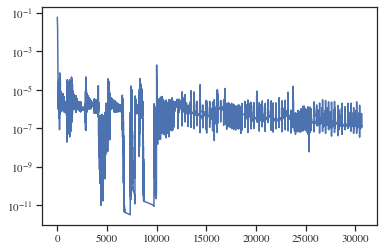

In [96]:
log = ses.get_log()
plt.semilogy(log.index, log["loss_fwd"])

Once training is done, we can obtain training metrics using `ses.get_log()`, or evaluate the model by accessing the learned forward operator function through the session object `ses`. The recursive training in particular will regularly output reconstructions during training which can be found in the `test_session/output_img` folder. These are overwritten in order to save storage space however, so the images will only show the current state of the learned forward operators.

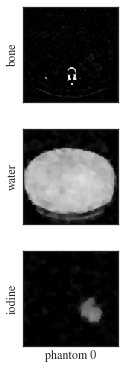

In [97]:
n = 2950#2000 #2950
x = torch.load(ses.session_path + f"/output_img/phantom_{n}.Tensor").to("cpu")

plot_image_channels(x,
                    image_labels=[f"phantom {i}" for i in range(3)],
                    channel_labels=["bone", "water", "iodine"],
                    cmap="Greys_r",
                    vmax=1,
                    vmin=0)
